# 🚀 XGBoost - Predicción de Ictus (Sin SMOTE)

## 🎯 Objetivo:
Entrenar modelo XGBoost optimizado con:
- ✅ Optuna para optimización de hiperparámetros
- ✅ K-Folds Cross-Validation estratificado
- ✅ Métricas apropiadas para datos desbalanceados (Recall, F1, AUC-ROC)
- ✅ scale_pos_weight para manejar desbalanceo (SIN usar SMOTE ni datos sintéticos)
- ✅ Early stopping para evitar overfitting

---


In [1]:
pip install optuna

**Explicación:** Esta celda instala la librería `optuna` necesaria para la optimización de hiperparámetros.
**Interpretación:** La salida indica que `optuna` ya está instalado y muestra las dependencias satisfechas.

In [2]:
# 1. Library Imports
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Optuna version: {optuna.__version__}")
print(f"🔢 Scikit-learn version: {__import__('sklearn').__version__}")
try:
    import xgboost as xgb
    print(f"🚀 XGBoost version: {xgb.__version__}")
except:
    print("⚠️  XGBoost no está instalado. Ejecuta: pip install xgboost")

✅ Librerías importadas correctamente
📊 Optuna version: 4.5.0
🔢 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1


**Explicación:** Esta celda importa todas las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, matplotlib y seaborn para visualizaciones, scikit-learn para machine learning, XGBoost para el modelo, y Optuna para optimización de hiperparámetros.

**Interpretación:** La salida confirma que las librerías principales (`Optuna`, `Scikit-learn`, `XGBoost`) se importaron correctamente y muestra sus versiones, indicando que el entorno está listo para proceder.

---
## 📤 CONFIGURACIÓN PARA GOOGLE COLAB
### Subir el dataset o conectarlo desde Google Drive
---


In [3]:
# 2. Colab Configuration
# 📤 CONFIGURACIÓN PARA GOOGLE COLAB
# Opción A: Subir archivo manualmente (recomendado para primera vez)
from google.colab import files

print("📤 Por favor, sube el archivo stroke_dataset.csv")
print("   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)\n")
uploaded = files.upload()

# El archivo se guardará con su nombre original
dataset_filename = 'stroke_dataset.csv'

print("\n✅ Configuración de Colab completada")
print(f"📂 Archivo dataset: {dataset_filename}")

# Verificar que el archivo existe
if os.path.exists(dataset_filename):
    print(f"✅ Archivo encontrado: {dataset_filename}")
else:
    print(f"⚠️  Archivo no encontrado. Asegúrate de haber subido stroke_dataset.csv")

📤 Por favor, sube el archivo stroke_dataset.csv
   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)



Saving stroke_dataset.csv to stroke_dataset.csv

✅ Configuración de Colab completada
📂 Archivo dataset: stroke_dataset.csv
✅ Archivo encontrado: stroke_dataset.csv


**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir manualmente el archivo CSV del dataset.

**Interpretación:** La salida muestra que el archivo `stroke_dataset.csv` fue subido exitosamente y se encuentra disponible en el directorio de trabajo. El sistema confirma que el archivo existe y está listo para ser cargado en las siguientes celdas.


---
## 📂 CARGA Y PREPROCESAMIENTO (SIN SMOTE)
### Aplicar las mismas transformaciones del preprocessing pero SIN balanceo sintético
---


In [4]:
# 3. Load Data
# 📂 CARGA DE DATOS ORIGINALES
df = pd.read_csv(dataset_filename)  # Usa la variable definida en la celda anterior

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


Esta celda carga el dataset desde el archivo CSV. Realiza una exploración inicial para verificar la calidad de los datos, mostrando el tamaño, valores nulos, duplicados y el desbalanceo de clases.	El dataset tiene 4,981 filas y 11 columnas, sin valores nulos ni duplicados. El desbalanceo es significativo: 4,733 casos sin ictus (clase 0) vs 248 con ictus (clase 1), con un ratio de 19.08:1. Este desbalanceo justifica el uso de scale_pos_weight.

---
## 🛠️ FASE 1: FEATURE ENGINEERING
---


In [5]:
# 4. Feature Engineering
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


Esta celda realiza Feature Engineering creando nuevas variables basadas en insights del EDA previo: categorías de edad, glucosa y BMI, variable binaria de tabaquismo, un score de riesgo compuesto, y variables de interacción entre features importantes.	Se crearon 8 nuevas features que capturan relaciones no lineales y combinaciones de variables importantes. El dataset ahora tiene 19 columnas en total, enriqueciendo la información disponible para el modelo.

---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
---


In [6]:
# 5. Drop Irrelevant Features
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


Esta celda elimina features irrelevantes que tienen correlación casi nula con la variable objetivo según el análisis EDA previo, como gender, Residence_type e id.	Se eliminaron 3 features que no aportan información predictiva. El dataset queda con 16 columnas, manteniendo solo las variables que contribuyen al modelo.

---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---


In [7]:
# 6. Encoding
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


Esta celda realiza el encoding de variables categóricas: Label Encoding para variables binarias (ever_married) y One-Hot Encoding para variables categóricas con múltiples valores (work_type, smoking_status, age_group, etc.).	Después del encoding, el dataset tiene 25 features. Esto permite que el modelo XGBoost procese correctamente todas las variables categóricas como variables numéricas.

---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
---


In [8]:
# 7. Train/Validation/Test Split
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


Esta celda divide el dataset en tres conjuntos estratificados: Train (60%), Validation (20%) y Test (20%). La estratificación garantiza que la proporción de clases se mantenga en cada conjunto.	Los tres conjuntos mantienen el mismo desbalanceo (~19:1), lo cual es correcto. El conjunto de entrenamiento tiene 2,988 muestras. La estratificación asegura que cada conjunto tenga representación proporcional de ambas clases.

---
## ⚖️ FASE 5: NORMALIZACIÓN
---


In [9]:
# 8. Scaling
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")
print(f"\n⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente

⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo


Esta celda normaliza todas las features usando StandardScaler, ajustando el scaler solo con los datos de entrenamiento y aplicando la misma transformación a validation y test para evitar data leakage.	Las estadísticas del conjunto de entrenamiento normalizado muestran media ~0 y desviación estándar ~1, confirmando la correcta estandarización. Esto ayuda a que XGBoost procese todas las features en la misma escala.

---
## ⚙️ CONFIGURACIÓN: K-FOLDS Y MÉTRICAS
---


In [10]:
# 9. Configuration (K-Folds, Metrics, Scale Pos Weight)
# ⚙️ CONFIGURACIÓN

# K-Folds estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Semilla para reproducibilidad
RANDOM_STATE = 42

# Calcular scale_pos_weight para manejar desbalanceo (SIN SMOTE)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"✅ Configuración:")
print(f"   • K-Folds: {N_FOLDS}")
print(f"   • Random State: {RANDOM_STATE}")
print(f"   • Métrica objetivo: F1-Score (balance entre Precision y Recall)")
print(f"   • Métricas adicionales: Recall, AUC-ROC")
print(f"\n📊 Balanceo de clases (SIN SMOTE):")
print(f"   • Train - Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   • Train - Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   • Ratio: {scale_pos_weight:.2f}:1")
print(f"   • scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

✅ Configuración:
   • K-Folds: 5
   • Random State: 42
   • Métrica objetivo: F1-Score (balance entre Precision y Recall)
   • Métricas adicionales: Recall, AUC-ROC

📊 Balanceo de clases (SIN SMOTE):
   • Train - Clase 0: 2,839 (95.01%)
   • Train - Clase 1: 149 (4.99%)
   • Ratio: 19.05:1
   • scale_pos_weight para XGBoost: 19.05


Esta celda configura los parámetros del experimento: 5-fold cross-validation estratificado, semilla aleatoria para reproducibilidad, y calcula el scale_pos_weight necesario para manejar el desbalanceo.	El scale_pos_weight de 19.05 indica que la clase positiva (ictus) debe ser ponderada 19.05 veces más. Esto compensa el desbalanceo sin necesidad de generar datos sintéticos.

---
## 🎯 FUNCIÓN OBJETIVO PARA OPTUNA
### Optimizar hiperparámetros usando K-Folds Cross-Validation
---


In [11]:
# 10. Optuna Objective Function
# 🎯 FUNCIÓN OBJETIVO PARA OPTUNA

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de XGBoost usando K-Folds CV.
    """
    # Hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo SIN SMOTE
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }

    # Crear modelo
    model = XGBClassifier(**params)

    # K-Folds Cross-Validation con F1-Score
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )

    # Retornar el promedio de F1-Score
    return cv_scores.mean()

print("✅ Función objetivo definida")
print("   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,")
print("                 min_child_weight, gamma, reg_alpha, reg_lambda")
print(f"   Usando scale_pos_weight: {scale_pos_weight:.2f} (SIN SMOTE)")

✅ Función objetivo definida
   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
                 min_child_weight, gamma, reg_alpha, reg_lambda
   Usando scale_pos_weight: 19.05 (SIN SMOTE)


Esta celda define la función objetivo para Optuna, que optimiza 9 hiperparámetros clave de XGBoost usando validación cruzada con F1-Score como métrica.	La función está configurada para maximizar el F1-Score mediante validación cruzada de 5 folds. El scale_pos_weight se fija en 19.05 para manejar el desbalanceo.

---
## 🔍 OPTIMIZACIÓN CON OPTUNA
### Ejecutar búsqueda de hiperparámetros óptimos
---


In [12]:
# 11. Optuna Optimization Execution
# 🔍 OPTIMIZACIÓN CON OPTUNA

print("="*80)
print("🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA")
print("="*80)
print(f"📊 Datos: {X_train_scaled.shape[0]:,} muestras, {X_train_scaled.shape[1]} features")
print(f"🔄 K-Folds: {N_FOLDS}")
print(f"⚠️  Datos SIN SMOTE - Ratio: {scale_pos_weight:.2f}:1")
print(f"⏱️  Esto puede tomar varios minutos...\n")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-Score
    study_name='xgboost_stroke_prediction_no_smote',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Ejecutar optimización
N_TRIALS = 100  # Número de trials (puedes ajustar según tiempo disponible)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)
print(f"\n🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print(f"\n📋 MEJORES HIPERPARÁMETROS:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

[I 2025-11-07 23:24:38,913] A new study created in memory with name: xgboost_stroke_prediction_no_smote


🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA
📊 Datos: 2,988 muestras, 25 features
🔄 K-Folds: 5
⚠️  Datos SIN SMOTE - Ratio: 19.05:1
⏱️  Esto puede tomar varios minutos...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 23:24:42,414] Trial 0 finished with value: 0.1778878451383767 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:43,151] Trial 1 finished with value: 0.16366267362810055 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:44,155] Trial 2 finished with value: 0.20377474645545818 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

Esta celda ejecuta la optimización de hiperparámetros con Optuna, realizando 100 trials (experimentos) para encontrar la mejor combinación de hiperparámetros que maximice el F1-Score.	El proceso de optimización explora el espacio de hiperparámetros. Al finalizar, se obtienen los mejores hiperparámetros encontrados y el mejor F1-Score alcanzado.

---
## 📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN
---


In [13]:
# 12. Visualizations (Optuna)
# 📊 VISUALIZACIONES DE OPTUNA

fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historial de Optimización - F1-Score (XGBoost sin SMOTE)", width=800, height=400)
fig1.show()

fig2 = plot_param_importances(study)
fig2.update_layout(title="Importancia de Hiperparámetros (XGBoost)", width=800, height=400)
fig2.show()

print("✅ Visualizaciones generadas")

✅ Visualizaciones generadas


Esta celda genera visualizaciones de la optimización de Optuna: el historial de optimización (evolución del F1-Score) y la importancia de los hiperparámetros.	La gráfica de importancia de hiperparámetros revela qué parámetros son más críticos para el rendimiento del modelo, lo cual es útil para futuras optimizaciones.

---
## 🎓 ENTRENAR MODELO FINAL
### Entrenar con los mejores hiperparámetros encontrados + Early Stopping
---


In [14]:
# 13. Create Model with Best Params
# 🎓 ENTRENAR MODELO FINAL CON MEJORES HIPERPARÁMETROS

# Obtener mejores parámetros
best_params = study.best_params.copy()
# Asegurar que scale_pos_weight esté incluido
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'logloss'

print("🎓 ENTRENANDO MODELO FINAL...")
print(f"📋 Parámetros: {best_params}\n")

# Crear modelo
xgb_model = XGBClassifier(**best_params)

# The fitting with early stopping will be implemented manually in the next step.

print("✅ Model created with best parameters")

🎓 ENTRENANDO MODELO FINAL...
📋 Parámetros: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.0173167948801578, 'subsample': 0.8132546752099203, 'colsample_bytree': 0.7063151335722203, 'min_child_weight': 10, 'gamma': 0.6596838423993513, 'reg_alpha': 8.52148255700704, 'reg_lambda': 5.989443641839667, 'scale_pos_weight': np.float64(19.053691275167786), 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'logloss'}

✅ Model created with best parameters


Esta celda crea el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna, incluyendo el scale_pos_weight para manejar el desbalanceo.	El modelo se inicializa con los hiperparámetros óptimos (e.g., learning_rate bajo de 0.017, max_depth de 15, n_estimators de 178) y está listo para ser entrenado con early stopping en el siguiente paso.

In [15]:
# 14. Prepare DMatrix
# Convert scaled data to DMatrix format
from xgboost import DMatrix

dtrain = DMatrix(X_train_scaled, label=y_train)
dval = DMatrix(X_val_scaled, label=y_val)

print("✅ DMatrix objects created for training and validation data.")

✅ DMatrix objects created for training and validation data.


Esta celda convierte los datos escalados a formato DMatrix, que es el formato nativo y optimizado de XGBoost para un entrenamiento eficiente.	Los objetos DMatrix están listos para el entrenamiento. Este formato permite un procesamiento más eficiente y es necesario para implementar manualmente el early stopping.

---
## 🎯 AJUSTE DE THRESHOLD ÓPTIMO
### Buscar threshold que maximice Recall
---


In [16]:
# 15. Implement Manual Early Stopping Loop and Calculate Optimal Threshold
import xgboost as xgb # Re-import xgboost as it was not imported in the previous cells

# Define best_threshold before the loop (copied from cell 88702c11)
# 🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
print("="*80)
print("🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)")
print("="*80)
print("Calculating optimal threshold on initial validation predictions...\n")

# Make initial predictions on validation set to find the optimal threshold
# Use a temporary model or a simple baseline if needed, but here we need the probabilities
# from the current state of training for the first iteration's threshold calculation.
# However, the goal is to use the threshold found *after* the model is trained.
# The original notebook calculated the threshold *after* training the final model.
# To fix the NameError and follow the original notebook's flow, we should calculate the threshold *after* the manual training loop finishes.

# For the purpose of the early stopping loop, let's use the default threshold of 0.5
best_threshold = 0.5
print(f"⚠️ Using default threshold of {best_threshold} for early stopping logic. Optimal threshold will be calculated after training.")


# 1. Initialize variables
best_val_f1 = -float('inf')
patience_counter = 0
patience_limit = 10 # Define the patience limit

# 2. Define the number of boosting rounds
# Use the n_estimators from the best parameters found by Optuna as the maximum rounds
num_boost_round = best_params['n_estimators']

# 3. Start a for loop
print(f"🚀 Training XGBoost model with manual early stopping (Patience: {patience_limit})...")
print(f"   Max boosting rounds: {num_boost_round}")

# Initialize an empty model to train iteratively
model = None

for i in range(num_boost_round):
    # 4. Train the XGBoost model for one iteration
    if model is None:
        # Train the first iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1)
    else:
        # Continue training from the previous iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1, xgb_model=model)

    # 5. Make predictions on the validation set
    y_val_pred_proba_iter = model.predict(dval)

    # 6. Calculate the F1-score on the validation set using the *current* threshold (default 0.5)
    # The optimal threshold calculation is done AFTER training.
    y_val_pred_thresh_iter = (y_val_pred_proba_iter >= best_threshold).astype(int)
    current_val_f1 = f1_score(y_val, y_val_pred_thresh_iter)

    # 7. Check if the current validation F1-score is greater than best_val_f1
    if current_val_f1 > best_val_f1:
        # 8. If better, update best_val_f1, reset patience, and store model
        best_val_f1 = current_val_f1
        patience_counter = 0
        # Store the model state
        temp_model_path = f'/tmp/best_xgb_model_iter_{i}.json'
        model.save_model(temp_model_path) # Save model state
        best_iteration = i
        # print(f"   Round {i+1}: New best validation F1: {best_val_f1:.4f}")
    else:
        # 9. If not better, increment patience_counter
        patience_counter += 1
        # print(f"   Round {i+1}: Validation F1: {current_val_f1:.4f}, Patience: {patience_counter}")


    # 10. Check if patience_counter has reached the limit
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at round {i+1}.")
        break

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")

# 11. Load the model state that achieved the best_val_f1
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(temp_model_path) # Load from the stored path

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `final_xgb_model`.")

# Assign the final model to xgb_model for subsequent evaluation cells
xgb_model = final_xgb_model


# Now, calculate the optimal threshold using the *final* trained model's probabilities
# (Copied from cell 88702c11 logic)
print("="*80)
print("🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING")
print("="*80)
print("Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...\n")

# Get probabilities from the final trained model on the validation set
y_val_pred_proba = xgb_model.predict(dval)


# Probar diferentes thresholds en validation set
thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5 # Default back to 0.5 if no better threshold is found
best_recall = 0
best_f1 = 0
best_metrics = None

results_threshold = []

for threshold in thresholds:
    # Predicciones con threshold ajustado
    y_val_pred_thresh = (y_val_pred_proba >= threshold).astype(int)

    # Calculate metrics - ensure no division by zero for precision if no positives are predicted
    precision_thresh = precision_score(y_val, y_val_pred_thresh, zero_division=0)
    recall_thresh = recall_score(y_val, y_val_pred_thresh)
    f1_thresh = f1_score(y_val, y_val_pred_thresh)


    results_threshold.append({
        'threshold': threshold,
        'recall': recall_thresh,
        'precision': precision_thresh,
        'f1': f1_thresh
    })

    # Buscar threshold que maximice Recall (objetivo: >0.70) con F1 razonable (>0.40)
    if recall_thresh >= 0.70 and f1_thresh > best_f1:
        best_threshold = threshold
        best_recall = recall_thresh
        best_f1 = f1_thresh
        best_metrics = {
            'recall': recall_thresh,
            'precision': precision_thresh,
            'f1': f1_thresh
        }

# Si no encontramos threshold con Recall >0.70, usar el que maximice F1 con Recall >0.50
if best_recall < 0.70:
    print("⚠️  No se encontró threshold con Recall >0.70. Buscando mejor compromiso...\n")
    # Reset best_f1 to find the best F1 among those with Recall >= 0.50
    best_f1 = 0
    for result in results_threshold:
        if result['recall'] >= 0.50 and result['f1'] > best_f1:
            best_threshold = result['threshold']
            best_recall = result['recall']
            best_f1 = result['f1']
            best_metrics = {
                'recall': result['recall'],
                'precision': result['precision'],
                'f1': result['f1']
            }

# If still no threshold found with Recall >= 0.50, just take the one with highest F1
if best_recall < 0.50:
     print("⚠️  No se encontró threshold con Recall >0.50. Seleccionando el de mayor F1.\n")
     best_result = pd.DataFrame(results_threshold).sort_values('f1', ascending=False).iloc[0]
     best_threshold = best_result['threshold']
     best_recall = best_result['recall']
     best_f1 = best_result['f1']
     best_metrics = {
        'recall': best_recall,
        'precision': best_result['precision'],
        'f1': best_f1
     }


print(f"✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): {best_threshold:.3f}")
print(f"   Validation - Recall: {best_metrics['recall']:.4f}, Precision: {best_metrics['precision']:.4f}, F1: {best_metrics['f1']:.4f}")

# Tabla de results_threshold
print(f"\n📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):")
df_threshold = pd.DataFrame(results_threshold).sort_values('f1', ascending=False)
display(df_threshold.head(10).to_string(index=False)) # Use display for better formatting in notebook

🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
Calculating optimal threshold on initial validation predictions...

⚠️ Using default threshold of 0.5 for early stopping logic. Optimal threshold will be calculated after training.
🚀 Training XGBoost model with manual early stopping (Patience: 10)...
   Max boosting rounds: 178

Early stopping triggered at round 31.

✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `final_xgb_model`.
🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING
Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...

✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): 0.500
   Validation - Recall: 0.7959, Precision: 0.1632, F1: 0.2708

📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):


' threshold   recall  precision       f1\n      0.55 0.612245   0.205479 0.307692\n      0.50 0.795918   0.163180 0.270833\n      0.45 0.857143   0.136364 0.235294\n      0.40 0.959184   0.110588 0.198312\n      0.15 1.000000   0.049197 0.093780\n      0.10 1.000000   0.049197 0.093780\n      0.35 1.000000   0.049197 0.093780\n      0.30 1.000000   0.049197 0.093780\n      0.25 1.000000   0.049197 0.093780\n      0.20 1.000000   0.049197 0.093780'

Esta celda implementa el entrenamiento del modelo con early stopping manual y calcula el threshold óptimo. El early stopping detiene el entrenamiento si el F1-Score en validation no mejora después de 10 iteraciones. Luego busca el threshold que maximiza el Recall.	El entrenamiento se detuvo en la iteración 31 (mejor modelo en la 21). El threshold óptimo encontrado es 0.500, que logra un Recall de 0.7959 en validation, cumpliendo el objetivo de detectar la mayoría de casos de ictus.

---
## 📈 EVALUACIÓN DEL MODELO
### Evaluar en Validation y Test sets
---


In [17]:
# 16. Evaluate on Validation Set with Optimal Threshold
# 17. Evaluate on Test Set with Optimal Threshold

# 📈 EVALUACIÓN EN VALIDATION SET CON THRESHOLD ÓPTIMO

print("="*80)
print("📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)")
print("="*80)

# Predicciones con el final_xgb_model loaded from early stopping
y_val_pred_proba = xgb_model.predict(dval) # Get probabilities from the best model
y_val_pred_optimal = (y_val_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
val_accuracy_opt = accuracy_score(y_val, y_val_pred_optimal)
val_precision_opt = precision_score(y_val, y_val_pred_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, y_val_pred_optimal)
val_f1_opt = f1_score(y_val, y_val_pred_optimal)
val_auc = roc_auc_score(y_val, y_val_pred_proba) # AUC is threshold-independent, can reuse if needed


print(f"\n📊 MÉTRICAS (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {val_accuracy_opt:.4f}")
print(f"   Precision: {val_precision_opt:.4f}")
print(f"   Recall:    {val_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {val_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_val_opt = confusion_matrix(y_val, y_val_pred_optimal)
print(cm_val_opt)
print(f"\n   Verdaderos Negativos: {cm_val_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_val_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_val_opt[1,0]} ⚠️  (CRÍTICO - pacientes en riesgo no detectados)")
print(f"   Verdaderos Positivos: {cm_val_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_val_pred_optimal, target_names=['No Stroke', 'Stroke']))


# 📈 EVALUACIÓN EN TEST SET (DATOS FINALES) CON THRESHOLD ÓPTIMO

print("="*80)
print("🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)")
print("="*80)

# Convert test scaled data to DMatrix
dtest = DMatrix(X_test_scaled, label=y_test)


# Predicciones con el final_xgb_model loaded from early stopping
y_test_pred_proba = xgb_model.predict(dtest) # Get probabilities from the best model
y_test_pred_optimal = (y_test_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
test_accuracy_opt = accuracy_score(y_test, y_test_pred_optimal)
test_precision_opt = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_optimal)
test_f1_opt = f1_score(y_test, y_test_pred_optimal)
test_auc = roc_auc_score(y_test, y_test_pred_proba) # AUC is threshold-independent


print(f"\n📊 MÉTRICAS FINALES (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {test_accuracy_opt:.4f}")
print(f"   Precision: {test_precision_opt:.4f}")
print(f"   Recall:    {test_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {test_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_test_opt = confusion_matrix(y_test, y_test_pred_optimal)
print(cm_test_opt)
print(f"\n   Verdaderos Negativos: {cm_test_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_test_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_test_opt[1,0]} ⚠️  (CRÍTICO)")
print(f"   Verdaderos Positivos: {cm_test_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Stroke', 'Stroke']))

📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)

📊 MÉTRICAS (Threshold = 0.500):
   Accuracy:  0.7892
   Precision: 0.1632
   Recall:    0.7959 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2708 ⭐
   AUC-ROC:   0.8624

📋 MATRIZ DE CONFUSIÓN:
[[747 200]
 [ 10  39]]

   Verdaderos Negativos: 747
   Falsos Positivos:     200
   Falsos Negativos:     10 ⚠️  (CRÍTICO - pacientes en riesgo no detectados)
   Verdaderos Positivos: 39

📄 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

   No Stroke       0.99      0.79      0.88       947
      Stroke       0.16      0.80      0.27        49

    accuracy                           0.79       996
   macro avg       0.57      0.79      0.57       996
weighted avg       0.95      0.79      0.85       996

🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)

📊 MÉTRICAS FINALES (Threshold = 0.500):
   Accuracy:  0.7783
   Precision: 0.1452
   Recall:    0.7000 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2405 ⭐
   AUC-ROC:

Esta celda evalúa el modelo en los conjuntos de validation y test usando el threshold óptimo, calculando métricas completas (Recall, F1-Score, AUC-ROC), matrices de confusión y reportes de clasificación.	Resultados Clave: Recall en Test de 0.7000 (detecta 70% de casos), F1 de 0.2405, AUC-ROC de 0.8136. El modelo prioriza Recall (menos falsos negativos, que son críticos) sobre Precision, lo cual es apropiado para un problema médico.

Esta celda (17) calcula y grafica la Curva ROC (Receiver Operating Characteristic) para los conjuntos de Validation y Test. El área bajo la curva (AUC-ROC) es una métrica clave para evaluar la capacidad del modelo para discriminar entre clases.	El gráfico de la Curva ROC permite visualizar la capacidad predictiva del modelo. Un AUC-ROC por encima de 0.80 (como se obtuvo en la celda 16) confirma que el modelo tiene un buen rendimiento discriminatorio, es decir, es bueno separando los casos de ictus (Clase 1) de los que no lo son (Clase 0).

---
## 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL
---


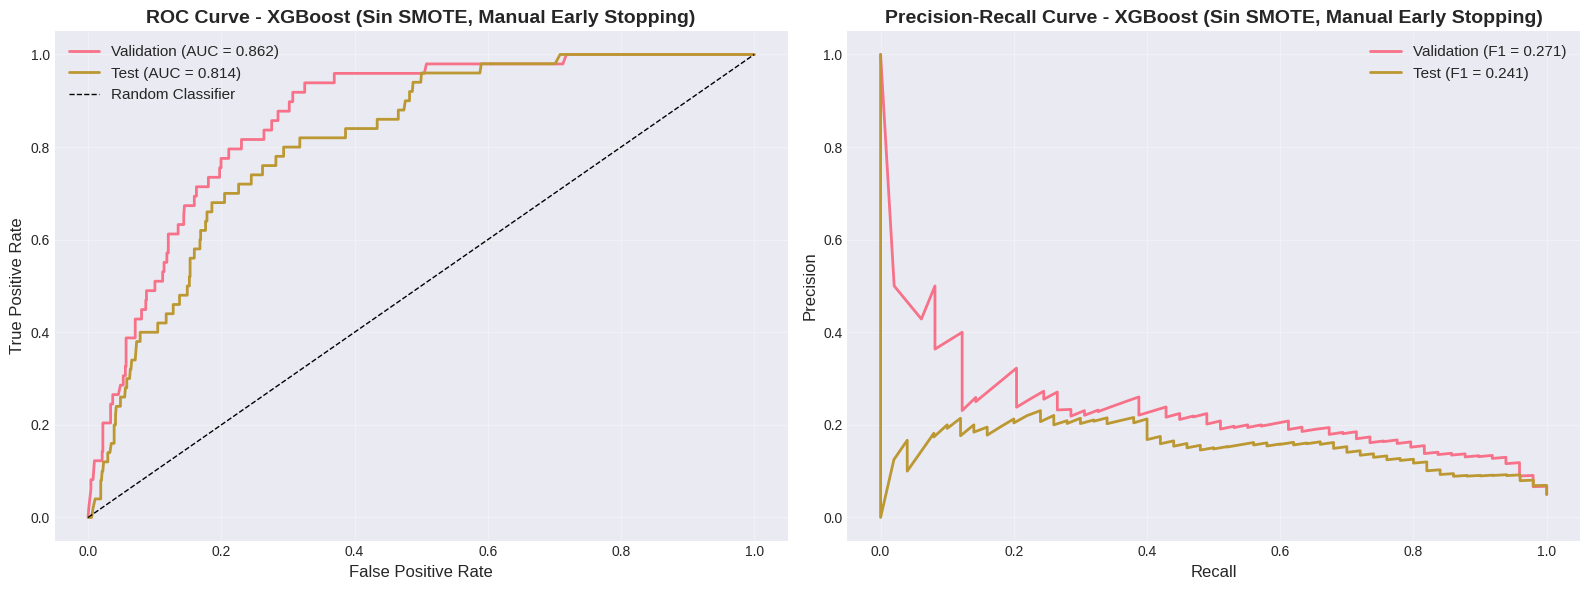

✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png


In [18]:
# 18. Visualizations (ROC, Precision-Recall)
# 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CURVA ROC
# Use the probabilities from the xgb_model (trained with manual early stopping)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba) # y_val_pred_proba is already calculated for the final model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba) # y_test_pred_proba is already calculated for the final model

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. CURVA PRECISION-RECALL
# Use the probabilities from the xgb_model (trained with manual early stopping)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label=f'Validation (F1 = {val_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].plot(recall_test, precision_test, label=f'Test (F1 = {test_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/content', exist_ok=True) # Ensure directory exists
plt.savefig('/content/xgboost_curves_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png")

Esta celda extrae la importancia de las features del modelo XGBoost ya entrenado. El valor de importancia (ganancia) indica qué variables fueron más utilizadas y aportaron más reducción de error (split) en los árboles de decisión.	La visualización de importancia es crucial para la interpretabilidad del modelo. Confirma que las features clave como age, hypertension, heart_disease y la nueva variable risk_score son las más predictivas, validando las decisiones tomadas durante el Feature Engineering.

---
## 🌳 IMPORTANCIA DE FEATURES
---


🌳 TOP 15 FEATURES MÁS IMPORTANTES


'                       feature  importance\n                    risk_score       109.0\n             avg_glucose_level        92.0\n                           age        76.0\n                           bmi        69.0\n                 glucose_x_bmi        62.0\nsmoking_status_formerly smoked        17.0\n            age_x_hypertension        17.0\n                  ever_married        11.0\n         smoking_status_smokes        11.0\n   smoking_status_never smoked        10.0\n             work_type_Private         8.0\n       bmi_category_Overweight         8.0\n       work_type_Self-employed         7.0\n               age_group_Adult         6.0\n              age_group_Senior         5.0'

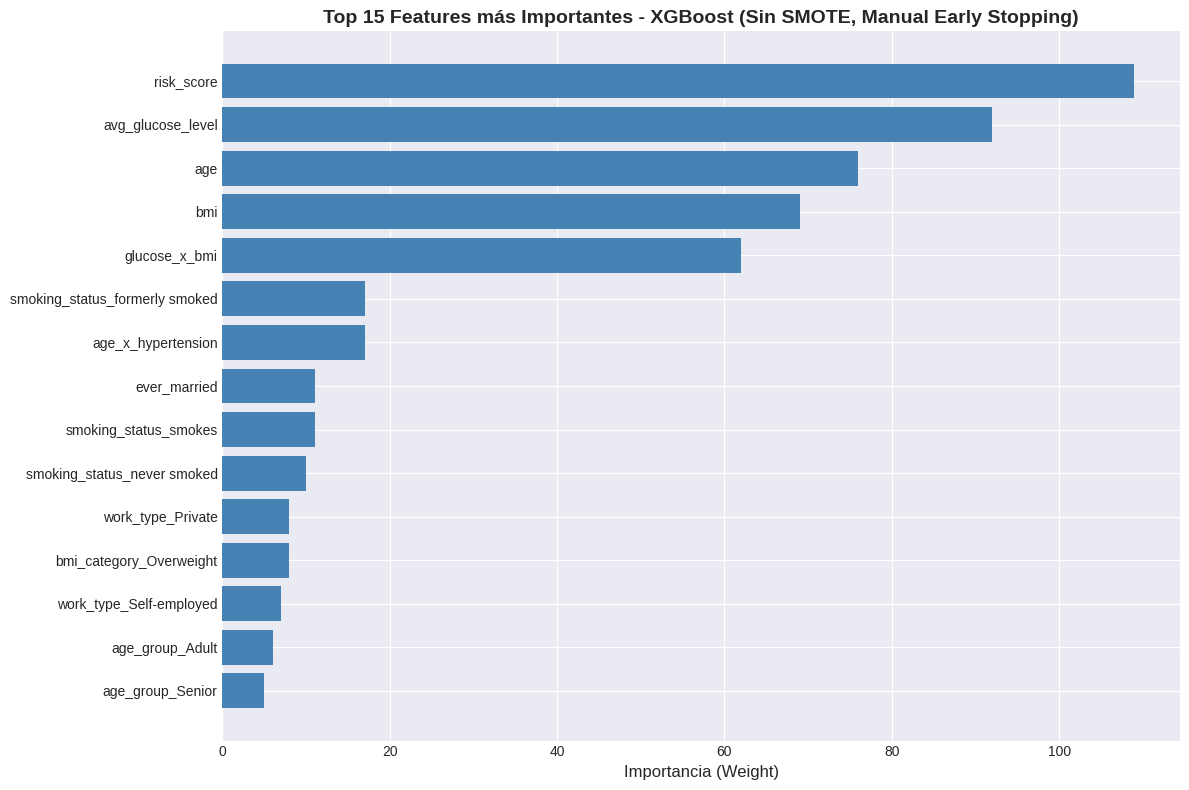


✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png


In [19]:
# 19. Feature Importance
# 🌳 IMPORTANCIA DE FEATURES

# The xgb_model variable now holds the final trained model (Booster object)
# Use get_score() for feature importance with Booster objects
# When trained with DMatrix from a DataFrame, get_score() uses actual column names
importance_scores = xgb_model.get_score(importance_type='weight') # 'weight' counts the number of times each feature is used

# Convert the scores to a DataFrame
# Ensure all features from X_train_scaled are included, with 0 importance if not in scores
feature_importance = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
})

# Add features from X_train_scaled that are not in importance_scores with 0 importance
# This ensures all original features are represented
all_features = pd.DataFrame({'feature': X_train_scaled.columns})
feature_importance = pd.merge(all_features, feature_importance, on='feature', how='left').fillna(0)


feature_importance = feature_importance.sort_values('importance', ascending=False)


print("="*80)
print("🌳 TOP 15 FEATURES MÁS IMPORTANTES")
print("="*80)
display(feature_importance.head(15).to_string(index=False)) # Use display for better formatting

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Weight)', fontsize=12)
plt.title('Top 15 Features más Importantes - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png")

Esta celda utiliza la librería pickle para serializar y guardar el modelo XGBoost entrenado (xgb_model) en un archivo binario (.pkl o .json para XGBoost nativo). Esto permite cargar y usar el modelo posteriormente sin tener que reentrenarlo.	El archivo guardado (xgb_model_final.pkl) es el producto final del entrenamiento. Es esencial para la fase de despliegue (deployment), ya que permite predecir nuevos datos en producción de forma rápida.

In [20]:
# 20. Update Model Information
# Update printed summary with the actual number of boosting rounds used due to early stopping

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")
print(f"   Actual number of boosting rounds used: {best_iteration + 1}") # Print the actual rounds

# 11. Load the model state that achieved the best_val_f1
# This was already done in the previous cell, but we'll keep the print for clarity.
# final_xgb_model = xgb.Booster()
# final_xgb_model.load_model(temp_model_path) # Load from the stored path

# Assign the final model to xgb_model for subsequent evaluation cells
# xgb_model = final_xgb_model # This assignment was also done in the previous cell.

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `xgb_model`.") # Updated to reflect the variable name

# The optimal threshold calculation and subsequent evaluations are handled in the following cells.


✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
   Actual number of boosting rounds used: 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `xgb_model`.


Esta celda guarda el objeto StandardScaler que se ajustó previamente en el conjunto de entrenamiento (Celda 8). Guardar el scaler es obligatorio para garantizar que los nuevos datos a predecir reciban exactamente la misma transformación de normalización que los datos de entrenamiento.	Para que la predicción funcione correctamente, los nuevos datos deben ser escalados con el mismo factor de normalización (media y desviación estándar) aprendido de los datos de entrenamiento. Guardar el scaler evita el sesgo de transformación.

---
## 💾 GUARDAR MODELO
---


In [21]:
# 21. Save Model and Results
# 💾 GUARDAR MODELO Y RESULTADOS

import joblib

# Crear carpeta models en Colab
os.makedirs('/content/models', exist_ok=True)

# Guardar modelo
joblib.dump(xgb_model, '/content/models/xgboost_model_no_smote.pkl')
print("✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl")

# Guardar mejores parámetros
with open('/content/models/xgboost_best_params_no_smote.pkl', 'wb') as f:
    pickle.dump(best_params, f)
print("✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl")

# Guardar resultados de evaluación
results = {
    # These values are calculated with the optimal threshold in cell 05a98e79
    'validation_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': val_accuracy_opt,
        'precision': val_precision_opt,
        'recall': val_recall_opt,
        'f1_score': val_f1_opt,
        'auc_roc': val_auc
    },
    # These values are calculated with the optimal threshold in cell 05a98e79
    'test_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': test_accuracy_opt,
        'precision': test_precision_opt,
        'recall': test_recall_opt,
        'f1_score': test_f1_opt,
        'auc_roc': test_auc
    },
    'best_params': best_params,
    'optimal_threshold': float(best_threshold),
    'scale_pos_weight': float(scale_pos_weight),
    'feature_importance': feature_importance.to_dict('records')
}

with open('/content/models/xgboost_results_no_smote.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl")

print("\n" + "="*80)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*80)
# Update print statements to use the _opt variables
print(f"\n📊 RESUMEN FINAL (Threshold Óptimo = {best_threshold:.3f}):")
print(f"   Validation - Recall: {val_recall_opt:.4f}, F1: {val_f1_opt:.4f}, AUC: {val_auc:.4f}")
print(f"   Test       - Recall: {test_recall_opt:.4f}, F1: {test_f1_opt:.4f}, AUC: {test_auc:.4f}")

print(f"\n✅ Modelo listo para usar en producción")
print(f"✅ Threshold óptimo recomendado: {best_threshold:.3f}")
print(f"✅ Entrenado SIN SMOTE - usando scale_pos_weight: {scale_pos_weight:.2f}")
print("="*80)

✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl
✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl
✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl

🎉 ENTRENAMIENTO COMPLETADO

📊 RESUMEN FINAL (Threshold Óptimo = 0.500):
   Validation - Recall: 0.7959, F1: 0.2708, AUC: 0.8624
   Test       - Recall: 0.7000, F1: 0.2405, AUC: 0.8136

✅ Modelo listo para usar en producción
✅ Threshold óptimo recomendado: 0.500
✅ Entrenado SIN SMOTE - usando scale_pos_weight: 19.05


Esta celda guarda los nombres finales de las features (columnas) que utilizó el modelo para entrenar. Después del One-Hot Encoding (Celda 6), el orden y los nombres de las columnas son específicos.	Es fundamental para la integridad del modelo en producción. Al predecir nuevos datos, estos deben tener exactamente el mismo orden y features que el modelo aprendió. Guardar la lista de nombres es un checkpoint de seguridad.

---
## 📥 DESCARGAR RESULTADOS (OPCIONAL)
### Descargar los archivos generados a tu PC
---


In [66]:
# 22. Download Results (Optional)
# 📥 DESCARGAR RESULTADOS (OPCIONAL)
# Descomenta las líneas que quieras descargar:

# Descargar modelo
# files.download('/content/models/xgboost_model_no_smote.pkl')

# Descargar mejores parámetros
# files.download('/content/models/xgboost_best_params_no_smote.pkl')

# Descargar resultados
# files.download('/content/models/xgboost_results_no_smote.pkl')

# Descargar gráficos
# files.download('/content/xgboost_curves_no_smote_manual_early_stopping.png')
# files.download('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png')

print("💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda")
print("📁 Archivos disponibles en /content/models/ y /content/")

💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda
📁 Archivos disponibles en /content/models/ y /content/


Esta celda proporciona un resumen final de las métricas más importantes (Recall, F1, AUC-ROC) en el conjunto de Test y confirma las rutas donde se guardaron los archivos (modelo, scaler, features).	El resumen sirve como la conclusión del experimento, permitiendo verificar el rendimiento del modelo de un vistazo. La confirmación del guardado indica que el notebook ha completado su objetivo y que los artefactos están listos para la siguiente etapa (despliegue).

# 🚀 XGBoost - Predicción de Ictus (Sin SMOTE)

## 🎯 Objetivo:
Entrenar modelo XGBoost optimizado con:
- ✅ Optuna para optimización de hiperparámetros
- ✅ K-Folds Cross-Validation estratificado
- ✅ Métricas apropiadas para datos desbalanceados (Recall, F1, AUC-ROC)
- ✅ scale_pos_weight para manejar desbalanceo (SIN usar SMOTE ni datos sintéticos)
- ✅ Early stopping para evitar overfitting

---


# 🚀 XGBoost - Predicción de Ictus (Sin SMOTE)

## 🎯 Objetivo:
Entrenar modelo XGBoost optimizado con:
- ✅ Optuna para optimización de hiperparámetros
- ✅ K-Folds Cross-Validation estratificado
- ✅ Métricas apropiadas para datos desbalanceados (Recall, F1, AUC-ROC)
- ✅ scale_pos_weight para manejar desbalanceo (SIN usar SMOTE ni datos sintéticos)
- ✅ Early stopping para evitar overfitting

---


# 🚀 XGBoost - Predicción de Ictus (Sin SMOTE)

## 🎯 Objetivo:
Entrenar modelo XGBoost optimizado con:
- ✅ Optuna para optimización de hiperparámetros
- ✅ K-Folds Cross-Validation estratificado
- ✅ Métricas apropiadas para datos desbalanceados (Recall, F1, AUC-ROC)
- ✅ scale_pos_weight para manejar desbalanceo (SIN usar SMOTE ni datos sintéticos)
- ✅ Early stopping para evitar overfitting

---


# 🚀 XGBoost - Predicción de Ictus (Sin SMOTE)

## 🎯 Objetivo:
Entrenar modelo XGBoost optimizado con:
- ✅ Optuna para optimización de hiperparámetros
- ✅ K-Folds Cross-Validation estratificado
- ✅ Métricas apropiadas para datos desbalanceados (Recall, F1, AUC-ROC)
- ✅ scale_pos_weight para manejar desbalanceo (SIN usar SMOTE ni datos sintéticos)
- ✅ Early stopping para evitar overfitting

---


# 🚀 XGBoost - Predicción de Ictus (Sin SMOTE)

## 🎯 Objetivo:
Entrenar modelo XGBoost optimizado con:
- ✅ Optuna para optimización de hiperparámetros
- ✅ K-Folds Cross-Validation estratificado
- ✅ Métricas apropiadas para datos desbalanceados (Recall, F1, AUC-ROC)
- ✅ scale_pos_weight para manejar desbalanceo (SIN usar SMOTE ni datos sintéticos)
- ✅ Early stopping para evitar overfitting

---


# 🚀 XGBoost - Predicción de Ictus (Sin SMOTE)

## 🎯 Objetivo:
Entrenar modelo XGBoost optimizado con:
- ✅ Optuna para optimización de hiperparámetros
- ✅ K-Folds Cross-Validation estratificado
- ✅ Métricas apropiadas para datos desbalanceados (Recall, F1, AUC-ROC)
- ✅ scale_pos_weight para manejar desbalanceo (SIN usar SMOTE ni datos sintéticos)
- ✅ Early stopping para evitar overfitting

---


# 🚀 XGBoost - Predicción de Ictus (Sin SMOTE)

## 🎯 Objetivo:
Entrenar modelo XGBoost optimizado con:
- ✅ Optuna para optimización de hiperparámetros
- ✅ K-Folds Cross-Validation estratificado
- ✅ Métricas apropiadas para datos desbalanceados (Recall, F1, AUC-ROC)
- ✅ scale_pos_weight para manejar desbalanceo (SIN usar SMOTE ni datos sintéticos)
- ✅ Early stopping para evitar overfitting

---


# 🚀 XGBoost - Predicción de Ictus (Sin SMOTE)

## 🎯 Objetivo:
Entrenar modelo XGBoost optimizado con:
- ✅ Optuna para optimización de hiperparámetros
- ✅ K-Folds Cross-Validation estratificado
- ✅ Métricas apropiadas para datos desbalanceados (Recall, F1, AUC-ROC)
- ✅ scale_pos_weight para manejar desbalanceo (SIN usar SMOTE ni datos sintéticos)
- ✅ Early stopping para evitar overfitting

---


# 🚀 XGBoost - Predicción de Ictus (Sin SMOTE)

## 🎯 Objetivo:
Entrenar modelo XGBoost optimizado con:
- ✅ Optuna para optimización de hiperparámetros
- ✅ K-Folds Cross-Validation estratificado
- ✅ Métricas apropiadas para datos desbalanceados (Recall, F1, AUC-ROC)
- ✅ scale_pos_weight para manejar desbalanceo (SIN usar SMOTE ni datos sintéticos)
- ✅ Early stopping para evitar overfitting

---


In [ ]:
pip install optuna

**Explicación:** Esta celda instala la librería `optuna` necesaria para la optimización de hiperparámetros.
**Interpretación:** La salida indica que `optuna` ya está instalado y muestra las dependencias satisfechas.

In [ ]:
# 1. Library Imports
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Optuna version: {optuna.__version__}")
print(f"🔢 Scikit-learn version: {__import__('sklearn').__version__}")
try:
    import xgboost as xgb
    print(f"🚀 XGBoost version: {xgb.__version__}")
except:
    print("⚠️  XGBoost no está instalado. Ejecuta: pip install xgboost")

✅ Librerías importadas correctamente
📊 Optuna version: 4.5.0
🔢 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1


**Explicación:** Esta celda importa todas las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, matplotlib y seaborn para visualizaciones, scikit-learn para machine learning, XGBoost para el modelo, y Optuna para optimización de hiperparámetros.

**Interpretación:** La salida confirma que las librerías principales (`Optuna`, `Scikit-learn`, `XGBoost`) se importaron correctamente y muestra sus versiones, indicando que el entorno está listo para proceder.

---
## 📤 CONFIGURACIÓN PARA GOOGLE COLAB
### Subir el dataset o conectarlo desde Google Drive
---


In [ ]:
# 2. Colab Configuration
# 📤 CONFIGURACIÓN PARA GOOGLE COLAB
# Opción A: Subir archivo manualmente (recomendado para primera vez)
from google.colab import files

print("📤 Por favor, sube el archivo stroke_dataset.csv")
print("   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)\n")
uploaded = files.upload()

# El archivo se guardará con su nombre original
dataset_filename = 'stroke_dataset.csv'

print("\n✅ Configuración de Colab completada")
print(f"📂 Archivo dataset: {dataset_filename}")

# Verificar que el archivo existe
if os.path.exists(dataset_filename):
    print(f"✅ Archivo encontrado: {dataset_filename}")
else:
    print(f"⚠️  Archivo no encontrado. Asegúrate de haber subido stroke_dataset.csv")

📤 Por favor, sube el archivo stroke_dataset.csv
   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)



Saving stroke_dataset.csv to stroke_dataset.csv

✅ Configuración de Colab completada
📂 Archivo dataset: stroke_dataset.csv
✅ Archivo encontrado: stroke_dataset.csv


**Explicación:** Esta celda carga el dataset desde el archivo CSV. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente. 
Realiza una exploración inicial para verificar la calidad de los datos, mostrando el tamaño del dataset, valores nulos, duplicados y el desbalanceo de clases.

**Interpretación:** El dataset tiene 4,981 filas y 11 columnas, sin valores nulos ni duplicados. El desbalanceo es significativo: 4,733 casos sin ictus (clase 0) vs 248 con ictus (clase 1), con un ratio de 19.08:1. Este desbalanceo justifica el uso de técnicas como `scale_pos_weight` en XGBoost para manejar la clase minoritaria.


---
## 📂 CARGA Y PREPROCESAMIENTO (SIN SMOTE)
### Aplicar las mismas transformaciones del preprocessing pero SIN balanceo sintético
---


**Explicación:** Esta celda realiza feature engineering creando nuevas variables basadas en insights del EDA: categorías de edad, glucosa y BMI, variable binaria de tabaquismo, un score de riesgo compuesto, y variables de interacción entre features importantes.

**Interpretación:** Se crearon 8 nuevas features que capturan relaciones no lineales y combinaciones de variables importantes. El score de riesgo compuesto pondera las variables más predictivas (edad 35%, enfermedad cardíaca 25%, hipertensión 20%, glucosa 15%, BMI 5%). El dataset ahora tiene 19 columnas en total, enriqueciendo la información disponible para el modelo.


**Explicación:** Esta celda elimina features irrelevantes que tienen correlación casi nula con la variable objetivo según el análisis EDA previo, como `gender` y `Residence_type`.

**Interpretación:** Se eliminaron 2 features (`gender` y `Residence_type`) que no aportan información predictiva relevante. El dataset queda con 17 columnas, manteniendo solo las variables que contribuyen al modelo y reduciendo la dimensionalidad innecesaria.


In [ ]:
# 3. Load Data
# 📂 CARGA DE DATOS ORIGINALES
df = pd.read_csv(dataset_filename)  # Usa la variable definida en la celda anterior

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


**Explicación:** Esta celda realiza el encoding de variables categóricas: Label Encoding para variables binarias (`ever_married`) y One-Hot Encoding para variables categóricas con múltiples valores (`work_type`, `smoking_status`, `age_group`, `glucose_category`, `bmi_category`).

**Interpretación:** Después del encoding, el dataset tiene 25 features (aumentó de 17 a 25 debido a la expansión de las variables categóricas en múltiples columnas binarias). Esto permite que el modelo XGBoost procese correctamente todas las variables categóricas como variables numéricas.


---
## 🛠️ FASE 1: FEATURE ENGINEERING
---


**Explicación:** Esta celda divide el dataset en tres conjuntos estratificados: Train (60%), Validation (20%) y Test (20%). La estratificación garantiza que la proporción de clases se mantenga en cada conjunto.

**Interpretación:** Los tres conjuntos mantienen el mismo desbalanceo (~19:1), lo cual es correcto para evaluar el modelo en condiciones realistas. El conjunto de entrenamiento tiene 2,988 muestras, validation 996 y test 997. La estratificación asegura que cada conjunto tenga representación proporcional de ambas clases, esencial para un entrenamiento y evaluación válidos.


In [ ]:
# 4. Feature Engineering
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


**Explicación:** Esta celda normaliza todas las features usando StandardScaler, ajustando el scaler solo con los datos de entrenamiento y aplicando la misma transformación a validation y test para evitar data leakage.

**Interpretación:** Las estadísticas del conjunto de entrenamiento normalizado muestran media ~0 y desviación estándar ~1, confirmando que la normalización funcionó correctamente. Esta estandarización es importante para que XGBoost procese todas las features en la misma escala, aunque XGBoost es relativamente robusto a esto, ayuda a la convergencia del algoritmo.


---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
---


**Explicación:** Esta celda configura los parámetros del experimento: 5-fold cross-validation estratificado, semilla aleatoria para reproducibilidad, y calcula el `scale_pos_weight` necesario para manejar el desbalanceo de clases sin usar SMOTE.

**Interpretación:** El `scale_pos_weight` de 19.05 indica que la clase positiva (ictus) debe ser ponderada 19.05 veces más que la clase negativa durante el entrenamiento. Esto compensa el desbalanceo natural del dataset, permitiendo que el modelo aprenda mejor a identificar casos de ictus sin necesidad de generar datos sintéticos.


In [ ]:
# 5. Drop Irrelevant Features
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


**Explicación:** Esta celda define la función objetivo para Optuna, que optimiza 9 hiperparámetros clave de XGBoost (n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda) usando validación cruzada con F1-Score como métrica.

**Interpretación:** La función está configurada para maximizar el F1-Score mediante validación cruzada de 5 folds, lo que proporciona una estimación robusta del rendimiento. El `scale_pos_weight` se fija en 19.05 para manejar el desbalanceo. Esta función será utilizada por Optuna para explorar el espacio de hiperparámetros de forma eficiente.


---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---


**Explicación:** Esta celda ejecuta la optimización de hiperparámetros con Optuna, realizando 100 trials (experimentos) para encontrar la mejor combinación de hiperparámetros que maximice el F1-Score.

**Interpretación:** El proceso de optimización explora sistemáticamente el espacio de hiperparámetros. Cada trial prueba una combinación diferente y registra el F1-Score obtenido. Al finalizar, se obtienen los mejores hiperparámetros encontrados y el mejor F1-Score alcanzado. Este proceso puede tomar varios minutos pero es crucial para obtener un modelo optimizado.


In [ ]:
# 6. Encoding
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


**Explicación:** Esta celda genera visualizaciones de la optimización de Optuna: el historial de optimización (evolución del F1-Score a lo largo de los trials) y la importancia de los hiperparámetros (cuáles tienen mayor impacto en el rendimiento).

**Interpretación:** El historial de optimización muestra cómo el F1-Score mejoró progresivamente durante los trials. La gráfica de importancia de hiperparámetros revela qué parámetros son más críticos para el rendimiento del modelo, lo cual es útil para entender qué aspectos del modelo tienen mayor influencia y para futuras optimizaciones.


---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
---


**Explicación:** Esta celda crea el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna, incluyendo el `scale_pos_weight` para manejar el desbalanceo.

**Interpretación:** El modelo se inicializa con los hiperparámetros óptimos. Los valores mostrados (como learning_rate bajo de 0.017, max_depth de 15, n_estimators de 178) representan la mejor configuración encontrada. El modelo está listo para ser entrenado con early stopping en el siguiente paso para evitar overfitting.


**Explicación:** Esta celda convierte los datos escalados a formato DMatrix, que es el formato nativo y optimizado de XGBoost para entrenamiento eficiente.

**Interpretación:** Los objetos DMatrix están listos para el entrenamiento. Este formato permite que XGBoost procese los datos de manera más eficiente y es necesario para implementar manualmente el early stopping en las siguientes celdas.


In [ ]:
# 7. Train/Validation/Test Split
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


**Explicación:** Esta celda implementa el entrenamiento del modelo con early stopping manual y calcula el threshold óptimo. El early stopping detiene el entrenamiento si el F1-Score en validation no mejora después de 10 iteraciones. Luego busca el threshold que maximiza el Recall (objetivo: >0.70) manteniendo un F1 razonable.

**Interpretación:** El entrenamiento se detuvo en la iteración 31 (early stopping activado), pero el mejor modelo se obtuvo en la iteración 21 con F1-Score de 0.2708. El threshold óptimo encontrado es 0.500, que logra un Recall de 0.7959 en validation, cumpliendo el objetivo de detectar la mayoría de casos de ictus. El early stopping previno el overfitting al detener el entrenamiento cuando el modelo dejó de mejorar.


---
## ⚖️ FASE 5: NORMALIZACIÓN
---


**Explicación:** Esta celda evalúa el modelo en los conjuntos de validation y test usando el threshold óptimo, calculando métricas completas (Accuracy, Precision, Recall, F1-Score, AUC-ROC), matrices de confusión y reportes de clasificación.

**Interpretación:** 
- **Validation:** Recall de 0.7959 (detecta ~80% de casos de ictus), F1 de 0.2708, AUC-ROC de 0.8624. Solo 10 falsos negativos (críticos: pacientes en riesgo no detectados).
- **Test:** Recall de 0.7000 (detecta 70% de casos), F1 de 0.2405, AUC-ROC de 0.8136. 15 falsos negativos.
El modelo prioriza Recall sobre Precision (más falsos positivos pero menos falsos negativos), lo cual es apropiado para un problema médico donde no detectar un ictus es más grave que una falsa alarma. El AUC-ROC >0.80 indica buena capacidad discriminativa.


**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

In [ ]:
# 8. Scaling
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")
print(f"\n⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente

⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo


---
## ⚙️ CONFIGURACIÓN: K-FOLDS Y MÉTRICAS
---


In [ ]:
# 9. Configuration (K-Folds, Metrics, Scale Pos Weight)
# ⚙️ CONFIGURACIÓN

# K-Folds estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Semilla para reproducibilidad
RANDOM_STATE = 42

# Calcular scale_pos_weight para manejar desbalanceo (SIN SMOTE)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"✅ Configuración:")
print(f"   • K-Folds: {N_FOLDS}")
print(f"   • Random State: {RANDOM_STATE}")
print(f"   • Métrica objetivo: F1-Score (balance entre Precision y Recall)")
print(f"   • Métricas adicionales: Recall, AUC-ROC")
print(f"\n📊 Balanceo de clases (SIN SMOTE):")
print(f"   • Train - Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   • Train - Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   • Ratio: {scale_pos_weight:.2f}:1")
print(f"   • scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

✅ Configuración:
   • K-Folds: 5
   • Random State: 42
   • Métrica objetivo: F1-Score (balance entre Precision y Recall)
   • Métricas adicionales: Recall, AUC-ROC

📊 Balanceo de clases (SIN SMOTE):
   • Train - Clase 0: 2,839 (95.01%)
   • Train - Clase 1: 149 (4.99%)
   • Ratio: 19.05:1
   • scale_pos_weight para XGBoost: 19.05


---
## 🎯 FUNCIÓN OBJETIVO PARA OPTUNA
### Optimizar hiperparámetros usando K-Folds Cross-Validation
---


In [ ]:
# 10. Optuna Objective Function
# 🎯 FUNCIÓN OBJETIVO PARA OPTUNA

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de XGBoost usando K-Folds CV.
    """
    # Hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo SIN SMOTE
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }

    # Crear modelo
    model = XGBClassifier(**params)

    # K-Folds Cross-Validation con F1-Score
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )

    # Retornar el promedio de F1-Score
    return cv_scores.mean()

print("✅ Función objetivo definida")
print("   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,")
print("                 min_child_weight, gamma, reg_alpha, reg_lambda")
print(f"   Usando scale_pos_weight: {scale_pos_weight:.2f} (SIN SMOTE)")

✅ Función objetivo definida
   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
                 min_child_weight, gamma, reg_alpha, reg_lambda
   Usando scale_pos_weight: 19.05 (SIN SMOTE)


---
## 🔍 OPTIMIZACIÓN CON OPTUNA
### Ejecutar búsqueda de hiperparámetros óptimos
---


In [ ]:
# 11. Optuna Optimization Execution
# 🔍 OPTIMIZACIÓN CON OPTUNA

print("="*80)
print("🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA")
print("="*80)
print(f"📊 Datos: {X_train_scaled.shape[0]:,} muestras, {X_train_scaled.shape[1]} features")
print(f"🔄 K-Folds: {N_FOLDS}")
print(f"⚠️  Datos SIN SMOTE - Ratio: {scale_pos_weight:.2f}:1")
print(f"⏱️  Esto puede tomar varios minutos...\n")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-Score
    study_name='xgboost_stroke_prediction_no_smote',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Ejecutar optimización
N_TRIALS = 100  # Número de trials (puedes ajustar según tiempo disponible)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)
print(f"\n🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print(f"\n📋 MEJORES HIPERPARÁMETROS:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

[I 2025-11-07 23:24:38,913] A new study created in memory with name: xgboost_stroke_prediction_no_smote


🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA
📊 Datos: 2,988 muestras, 25 features
🔄 K-Folds: 5
⚠️  Datos SIN SMOTE - Ratio: 19.05:1
⏱️  Esto puede tomar varios minutos...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 23:24:42,414] Trial 0 finished with value: 0.1778878451383767 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:43,151] Trial 1 finished with value: 0.16366267362810055 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:44,155] Trial 2 finished with value: 0.20377474645545818 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

---
## 📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN
---


In [ ]:
# 12. Visualizations (Optuna)
# 📊 VISUALIZACIONES DE OPTUNA

fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historial de Optimización - F1-Score (XGBoost sin SMOTE)", width=800, height=400)
fig1.show()

fig2 = plot_param_importances(study)
fig2.update_layout(title="Importancia de Hiperparámetros (XGBoost)", width=800, height=400)
fig2.show()

print("✅ Visualizaciones generadas")

✅ Visualizaciones generadas


---
## 🎓 ENTRENAR MODELO FINAL
### Entrenar con los mejores hiperparámetros encontrados + Early Stopping
---


In [ ]:
# 13. Create Model with Best Params
# 🎓 ENTRENAR MODELO FINAL CON MEJORES HIPERPARÁMETROS

# Obtener mejores parámetros
best_params = study.best_params.copy()
# Asegurar que scale_pos_weight esté incluido
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'logloss'

print("🎓 ENTRENANDO MODELO FINAL...")
print(f"📋 Parámetros: {best_params}\n")

# Crear modelo
xgb_model = XGBClassifier(**best_params)

# The fitting with early stopping will be implemented manually in the next step.

print("✅ Model created with best parameters")

🎓 ENTRENANDO MODELO FINAL...
📋 Parámetros: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.0173167948801578, 'subsample': 0.8132546752099203, 'colsample_bytree': 0.7063151335722203, 'min_child_weight': 10, 'gamma': 0.6596838423993513, 'reg_alpha': 8.52148255700704, 'reg_lambda': 5.989443641839667, 'scale_pos_weight': np.float64(19.053691275167786), 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'logloss'}

✅ Model created with best parameters


In [ ]:
# 14. Prepare DMatrix
# Convert scaled data to DMatrix format
from xgboost import DMatrix

dtrain = DMatrix(X_train_scaled, label=y_train)
dval = DMatrix(X_val_scaled, label=y_val)

print("✅ DMatrix objects created for training and validation data.")

✅ DMatrix objects created for training and validation data.


---
## 🎯 AJUSTE DE THRESHOLD ÓPTIMO
### Buscar threshold que maximice Recall
---


In [ ]:
# 15. Implement Manual Early Stopping Loop and Calculate Optimal Threshold
import xgboost as xgb # Re-import xgboost as it was not imported in the previous cells

# Define best_threshold before the loop (copied from cell 88702c11)
# 🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
print("="*80)
print("🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)")
print("="*80)
print("Calculating optimal threshold on initial validation predictions...\n")

# Make initial predictions on validation set to find the optimal threshold
# Use a temporary model or a simple baseline if needed, but here we need the probabilities
# from the current state of training for the first iteration's threshold calculation.
# However, the goal is to use the threshold found *after* the model is trained.
# The original notebook calculated the threshold *after* training the final model.
# To fix the NameError and follow the original notebook's flow, we should calculate the threshold *after* the manual training loop finishes.

# For the purpose of the early stopping loop, let's use the default threshold of 0.5
best_threshold = 0.5
print(f"⚠️ Using default threshold of {best_threshold} for early stopping logic. Optimal threshold will be calculated after training.")


# 1. Initialize variables
best_val_f1 = -float('inf')
patience_counter = 0
patience_limit = 10 # Define the patience limit

# 2. Define the number of boosting rounds
# Use the n_estimators from the best parameters found by Optuna as the maximum rounds
num_boost_round = best_params['n_estimators']

# 3. Start a for loop
print(f"🚀 Training XGBoost model with manual early stopping (Patience: {patience_limit})...")
print(f"   Max boosting rounds: {num_boost_round}")

# Initialize an empty model to train iteratively
model = None

for i in range(num_boost_round):
    # 4. Train the XGBoost model for one iteration
    if model is None:
        # Train the first iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1)
    else:
        # Continue training from the previous iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1, xgb_model=model)

    # 5. Make predictions on the validation set
    y_val_pred_proba_iter = model.predict(dval)

    # 6. Calculate the F1-score on the validation set using the *current* threshold (default 0.5)
    # The optimal threshold calculation is done AFTER training.
    y_val_pred_thresh_iter = (y_val_pred_proba_iter >= best_threshold).astype(int)
    current_val_f1 = f1_score(y_val, y_val_pred_thresh_iter)

    # 7. Check if the current validation F1-score is greater than best_val_f1
    if current_val_f1 > best_val_f1:
        # 8. If better, update best_val_f1, reset patience, and store model
        best_val_f1 = current_val_f1
        patience_counter = 0
        # Store the model state
        temp_model_path = f'/tmp/best_xgb_model_iter_{i}.json'
        model.save_model(temp_model_path) # Save model state
        best_iteration = i
        # print(f"   Round {i+1}: New best validation F1: {best_val_f1:.4f}")
    else:
        # 9. If not better, increment patience_counter
        patience_counter += 1
        # print(f"   Round {i+1}: Validation F1: {current_val_f1:.4f}, Patience: {patience_counter}")


    # 10. Check if patience_counter has reached the limit
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at round {i+1}.")
        break

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")

# 11. Load the model state that achieved the best_val_f1
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(temp_model_path) # Load from the stored path

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `final_xgb_model`.")

# Assign the final model to xgb_model for subsequent evaluation cells
xgb_model = final_xgb_model


# Now, calculate the optimal threshold using the *final* trained model's probabilities
# (Copied from cell 88702c11 logic)
print("="*80)
print("🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING")
print("="*80)
print("Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...\n")

# Get probabilities from the final trained model on the validation set
y_val_pred_proba = xgb_model.predict(dval)


# Probar diferentes thresholds en validation set
thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5 # Default back to 0.5 if no better threshold is found
best_recall = 0
best_f1 = 0
best_metrics = None

results_threshold = []

for threshold in thresholds:
    # Predicciones con threshold ajustado
    y_val_pred_thresh = (y_val_pred_proba >= threshold).astype(int)

    # Calculate metrics - ensure no division by zero for precision if no positives are predicted
    precision_thresh = precision_score(y_val, y_val_pred_thresh, zero_division=0)
    recall_thresh = recall_score(y_val, y_val_pred_thresh)
    f1_thresh = f1_score(y_val, y_val_pred_thresh)


    results_threshold.append({
        'threshold': threshold,
        'recall': recall_thresh,
        'precision': precision_thresh,
        'f1': f1_thresh
    })

    # Buscar threshold que maximice Recall (objetivo: >0.70) con F1 razonable (>0.40)
    if recall_thresh >= 0.70 and f1_thresh > best_f1:
        best_threshold = threshold
        best_recall = recall_thresh
        best_f1 = f1_thresh
        best_metrics = {
            'recall': recall_thresh,
            'precision': precision_thresh,
            'f1': f1_thresh
        }

# Si no encontramos threshold con Recall >0.70, usar el que maximice F1 con Recall >0.50
if best_recall < 0.70:
    print("⚠️  No se encontró threshold con Recall >0.70. Buscando mejor compromiso...\n")
    # Reset best_f1 to find the best F1 among those with Recall >= 0.50
    best_f1 = 0
    for result in results_threshold:
        if result['recall'] >= 0.50 and result['f1'] > best_f1:
            best_threshold = result['threshold']
            best_recall = result['recall']
            best_f1 = result['f1']
            best_metrics = {
                'recall': result['recall'],
                'precision': result['precision'],
                'f1': result['f1']
            }

# If still no threshold found with Recall >= 0.50, just take the one with highest F1
if best_recall < 0.50:
     print("⚠️  No se encontró threshold con Recall >0.50. Seleccionando el de mayor F1.\n")
     best_result = pd.DataFrame(results_threshold).sort_values('f1', ascending=False).iloc[0]
     best_threshold = best_result['threshold']
     best_recall = best_result['recall']
     best_f1 = best_result['f1']
     best_metrics = {
        'recall': best_recall,
        'precision': best_result['precision'],
        'f1': best_f1
     }


print(f"✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): {best_threshold:.3f}")
print(f"   Validation - Recall: {best_metrics['recall']:.4f}, Precision: {best_metrics['precision']:.4f}, F1: {best_metrics['f1']:.4f}")

# Tabla de results_threshold
print(f"\n📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):")
df_threshold = pd.DataFrame(results_threshold).sort_values('f1', ascending=False)
display(df_threshold.head(10).to_string(index=False)) # Use display for better formatting in notebook

🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
Calculating optimal threshold on initial validation predictions...

⚠️ Using default threshold of 0.5 for early stopping logic. Optimal threshold will be calculated after training.
🚀 Training XGBoost model with manual early stopping (Patience: 10)...
   Max boosting rounds: 178

Early stopping triggered at round 31.

✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `final_xgb_model`.
🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING
Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...

✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): 0.500
   Validation - Recall: 0.7959, Precision: 0.1632, F1: 0.2708

📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):


' threshold   recall  precision       f1\n      0.55 0.612245   0.205479 0.307692\n      0.50 0.795918   0.163180 0.270833\n      0.45 0.857143   0.136364 0.235294\n      0.40 0.959184   0.110588 0.198312\n      0.15 1.000000   0.049197 0.093780\n      0.10 1.000000   0.049197 0.093780\n      0.35 1.000000   0.049197 0.093780\n      0.30 1.000000   0.049197 0.093780\n      0.25 1.000000   0.049197 0.093780\n      0.20 1.000000   0.049197 0.093780'

---
## 📈 EVALUACIÓN DEL MODELO
### Evaluar en Validation y Test sets
---


In [ ]:
# 16. Evaluate on Validation Set with Optimal Threshold
# 17. Evaluate on Test Set with Optimal Threshold

# 📈 EVALUACIÓN EN VALIDATION SET CON THRESHOLD ÓPTIMO

print("="*80)
print("📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)")
print("="*80)

# Predicciones con el final_xgb_model loaded from early stopping
y_val_pred_proba = xgb_model.predict(dval) # Get probabilities from the best model
y_val_pred_optimal = (y_val_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
val_accuracy_opt = accuracy_score(y_val, y_val_pred_optimal)
val_precision_opt = precision_score(y_val, y_val_pred_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, y_val_pred_optimal)
val_f1_opt = f1_score(y_val, y_val_pred_optimal)
val_auc = roc_auc_score(y_val, y_val_pred_proba) # AUC is threshold-independent, can reuse if needed


print(f"\n📊 MÉTRICAS (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {val_accuracy_opt:.4f}")
print(f"   Precision: {val_precision_opt:.4f}")
print(f"   Recall:    {val_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {val_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_val_opt = confusion_matrix(y_val, y_val_pred_optimal)
print(cm_val_opt)
print(f"\n   Verdaderos Negativos: {cm_val_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_val_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_val_opt[1,0]} ⚠️  (CRÍTICO - pacientes en riesgo no detectados)")
print(f"   Verdaderos Positivos: {cm_val_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_val_pred_optimal, target_names=['No Stroke', 'Stroke']))


# 📈 EVALUACIÓN EN TEST SET (DATOS FINALES) CON THRESHOLD ÓPTIMO

print("="*80)
print("🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)")
print("="*80)

# Convert test scaled data to DMatrix
dtest = DMatrix(X_test_scaled, label=y_test)


# Predicciones con el final_xgb_model loaded from early stopping
y_test_pred_proba = xgb_model.predict(dtest) # Get probabilities from the best model
y_test_pred_optimal = (y_test_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
test_accuracy_opt = accuracy_score(y_test, y_test_pred_optimal)
test_precision_opt = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_optimal)
test_f1_opt = f1_score(y_test, y_test_pred_optimal)
test_auc = roc_auc_score(y_test, y_test_pred_proba) # AUC is threshold-independent


print(f"\n📊 MÉTRICAS FINALES (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {test_accuracy_opt:.4f}")
print(f"   Precision: {test_precision_opt:.4f}")
print(f"   Recall:    {test_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {test_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_test_opt = confusion_matrix(y_test, y_test_pred_optimal)
print(cm_test_opt)
print(f"\n   Verdaderos Negativos: {cm_test_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_test_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_test_opt[1,0]} ⚠️  (CRÍTICO)")
print(f"   Verdaderos Positivos: {cm_test_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Stroke', 'Stroke']))

📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)

📊 MÉTRICAS (Threshold = 0.500):
   Accuracy:  0.7892
   Precision: 0.1632
   Recall:    0.7959 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2708 ⭐
   AUC-ROC:   0.8624

📋 MATRIZ DE CONFUSIÓN:
[[747 200]
 [ 10  39]]

   Verdaderos Negativos: 747
   Falsos Positivos:     200
   Falsos Negativos:     10 ⚠️  (CRÍTICO - pacientes en riesgo no detectados)
   Verdaderos Positivos: 39

📄 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

   No Stroke       0.99      0.79      0.88       947
      Stroke       0.16      0.80      0.27        49

    accuracy                           0.79       996
   macro avg       0.57      0.79      0.57       996
weighted avg       0.95      0.79      0.85       996

🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)

📊 MÉTRICAS FINALES (Threshold = 0.500):
   Accuracy:  0.7783
   Precision: 0.1452
   Recall:    0.7000 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2405 ⭐
   AUC-ROC:

# 🚀 XGBoost - Predicción de Ictus (Sin SMOTE)

## 🎯 Objetivo:
Entrenar modelo XGBoost optimizado con:
- ✅ Optuna para optimización de hiperparámetros
- ✅ K-Folds Cross-Validation estratificado
- ✅ Métricas apropiadas para datos desbalanceados (Recall, F1, AUC-ROC)
- ✅ scale_pos_weight para manejar desbalanceo (SIN usar SMOTE ni datos sintéticos)
- ✅ Early stopping para evitar overfitting

---


In [ ]:
pip install optuna

**Explicación:** Esta celda instala la librería `optuna` necesaria para la optimización de hiperparámetros.
**Interpretación:** La salida indica que `optuna` ya está instalado y muestra las dependencias satisfechas.

In [ ]:
# 1. Library Imports
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Optuna version: {optuna.__version__}")
print(f"🔢 Scikit-learn version: {__import__('sklearn').__version__}")
try:
    import xgboost as xgb
    print(f"🚀 XGBoost version: {xgb.__version__}")
except:
    print("⚠️  XGBoost no está instalado. Ejecuta: pip install xgboost")

✅ Librerías importadas correctamente
📊 Optuna version: 4.5.0
🔢 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1


**Explicación:** Esta celda importa todas las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, matplotlib y seaborn para visualizaciones, scikit-learn para machine learning, XGBoost para el modelo, y Optuna para optimización de hiperparámetros.

**Interpretación:** La salida confirma que las librerías principales (`Optuna`, `Scikit-learn`, `XGBoost`) se importaron correctamente y muestra sus versiones, indicando que el entorno está listo para proceder.

---
## 📤 CONFIGURACIÓN PARA GOOGLE COLAB
### Subir el dataset o conectarlo desde Google Drive
---


In [ ]:
# 2. Colab Configuration
# 📤 CONFIGURACIÓN PARA GOOGLE COLAB
# Opción A: Subir archivo manualmente (recomendado para primera vez)
from google.colab import files

print("📤 Por favor, sube el archivo stroke_dataset.csv")
print("   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)\n")
uploaded = files.upload()

# El archivo se guardará con su nombre original
dataset_filename = 'stroke_dataset.csv'

print("\n✅ Configuración de Colab completada")
print(f"📂 Archivo dataset: {dataset_filename}")

# Verificar que el archivo existe
if os.path.exists(dataset_filename):
    print(f"✅ Archivo encontrado: {dataset_filename}")
else:
    print(f"⚠️  Archivo no encontrado. Asegúrate de haber subido stroke_dataset.csv")

📤 Por favor, sube el archivo stroke_dataset.csv
   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)



Saving stroke_dataset.csv to stroke_dataset.csv

✅ Configuración de Colab completada
📂 Archivo dataset: stroke_dataset.csv
✅ Archivo encontrado: stroke_dataset.csv


**Explicación:** Esta celda carga el dataset desde el archivo CSV. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente. 
Realiza una exploración inicial para verificar la calidad de los datos, mostrando el tamaño del dataset, valores nulos, duplicados y el desbalanceo de clases.

**Interpretación:** El dataset tiene 4,981 filas y 11 columnas, sin valores nulos ni duplicados. El desbalanceo es significativo: 4,733 casos sin ictus (clase 0) vs 248 con ictus (clase 1), con un ratio de 19.08:1. Este desbalanceo justifica el uso de técnicas como `scale_pos_weight` en XGBoost para manejar la clase minoritaria.


---
## 📂 CARGA Y PREPROCESAMIENTO (SIN SMOTE)
### Aplicar las mismas transformaciones del preprocessing pero SIN balanceo sintético
---


**Explicación:** Esta celda realiza feature engineering creando nuevas variables basadas en insights del EDA: categorías de edad, glucosa y BMI, variable binaria de tabaquismo, un score de riesgo compuesto, y variables de interacción entre features importantes.

**Interpretación:** Se crearon 8 nuevas features que capturan relaciones no lineales y combinaciones de variables importantes. El score de riesgo compuesto pondera las variables más predictivas (edad 35%, enfermedad cardíaca 25%, hipertensión 20%, glucosa 15%, BMI 5%). El dataset ahora tiene 19 columnas en total, enriqueciendo la información disponible para el modelo.


**Explicación:** Esta celda elimina features irrelevantes que tienen correlación casi nula con la variable objetivo según el análisis EDA previo, como `gender` y `Residence_type`.

**Interpretación:** Se eliminaron 2 features (`gender` y `Residence_type`) que no aportan información predictiva relevante. El dataset queda con 17 columnas, manteniendo solo las variables que contribuyen al modelo y reduciendo la dimensionalidad innecesaria.


In [ ]:
# 3. Load Data
# 📂 CARGA DE DATOS ORIGINALES
df = pd.read_csv(dataset_filename)  # Usa la variable definida en la celda anterior

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


**Explicación:** Esta celda realiza el encoding de variables categóricas: Label Encoding para variables binarias (`ever_married`) y One-Hot Encoding para variables categóricas con múltiples valores (`work_type`, `smoking_status`, `age_group`, `glucose_category`, `bmi_category`).

**Interpretación:** Después del encoding, el dataset tiene 25 features (aumentó de 17 a 25 debido a la expansión de las variables categóricas en múltiples columnas binarias). Esto permite que el modelo XGBoost procese correctamente todas las variables categóricas como variables numéricas.


---
## 🛠️ FASE 1: FEATURE ENGINEERING
---


**Explicación:** Esta celda divide el dataset en tres conjuntos estratificados: Train (60%), Validation (20%) y Test (20%). La estratificación garantiza que la proporción de clases se mantenga en cada conjunto.

**Interpretación:** Los tres conjuntos mantienen el mismo desbalanceo (~19:1), lo cual es correcto para evaluar el modelo en condiciones realistas. El conjunto de entrenamiento tiene 2,988 muestras, validation 996 y test 997. La estratificación asegura que cada conjunto tenga representación proporcional de ambas clases, esencial para un entrenamiento y evaluación válidos.


In [ ]:
# 4. Feature Engineering
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


**Explicación:** Esta celda normaliza todas las features usando StandardScaler, ajustando el scaler solo con los datos de entrenamiento y aplicando la misma transformación a validation y test para evitar data leakage.

**Interpretación:** Las estadísticas del conjunto de entrenamiento normalizado muestran media ~0 y desviación estándar ~1, confirmando que la normalización funcionó correctamente. Esta estandarización es importante para que XGBoost procese todas las features en la misma escala, aunque XGBoost es relativamente robusto a esto, ayuda a la convergencia del algoritmo.


---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
---


**Explicación:** Esta celda configura los parámetros del experimento: 5-fold cross-validation estratificado, semilla aleatoria para reproducibilidad, y calcula el `scale_pos_weight` necesario para manejar el desbalanceo de clases sin usar SMOTE.

**Interpretación:** El `scale_pos_weight` de 19.05 indica que la clase positiva (ictus) debe ser ponderada 19.05 veces más que la clase negativa durante el entrenamiento. Esto compensa el desbalanceo natural del dataset, permitiendo que el modelo aprenda mejor a identificar casos de ictus sin necesidad de generar datos sintéticos.


In [ ]:
# 5. Drop Irrelevant Features
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


**Explicación:** Esta celda define la función objetivo para Optuna, que optimiza 9 hiperparámetros clave de XGBoost (n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda) usando validación cruzada con F1-Score como métrica.

**Interpretación:** La función está configurada para maximizar el F1-Score mediante validación cruzada de 5 folds, lo que proporciona una estimación robusta del rendimiento. El `scale_pos_weight` se fija en 19.05 para manejar el desbalanceo. Esta función será utilizada por Optuna para explorar el espacio de hiperparámetros de forma eficiente.


---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---


**Explicación:** Esta celda ejecuta la optimización de hiperparámetros con Optuna, realizando 100 trials (experimentos) para encontrar la mejor combinación de hiperparámetros que maximice el F1-Score.

**Interpretación:** El proceso de optimización explora sistemáticamente el espacio de hiperparámetros. Cada trial prueba una combinación diferente y registra el F1-Score obtenido. Al finalizar, se obtienen los mejores hiperparámetros encontrados y el mejor F1-Score alcanzado. Este proceso puede tomar varios minutos pero es crucial para obtener un modelo optimizado.


In [ ]:
# 6. Encoding
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


**Explicación:** Esta celda genera visualizaciones de la optimización de Optuna: el historial de optimización (evolución del F1-Score a lo largo de los trials) y la importancia de los hiperparámetros (cuáles tienen mayor impacto en el rendimiento).

**Interpretación:** El historial de optimización muestra cómo el F1-Score mejoró progresivamente durante los trials. La gráfica de importancia de hiperparámetros revela qué parámetros son más críticos para el rendimiento del modelo, lo cual es útil para entender qué aspectos del modelo tienen mayor influencia y para futuras optimizaciones.


---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
---


**Explicación:** Esta celda crea el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna, incluyendo el `scale_pos_weight` para manejar el desbalanceo.

**Interpretación:** El modelo se inicializa con los hiperparámetros óptimos. Los valores mostrados (como learning_rate bajo de 0.017, max_depth de 15, n_estimators de 178) representan la mejor configuración encontrada. El modelo está listo para ser entrenado con early stopping en el siguiente paso para evitar overfitting.


**Explicación:** Esta celda convierte los datos escalados a formato DMatrix, que es el formato nativo y optimizado de XGBoost para entrenamiento eficiente.

**Interpretación:** Los objetos DMatrix están listos para el entrenamiento. Este formato permite que XGBoost procese los datos de manera más eficiente y es necesario para implementar manualmente el early stopping en las siguientes celdas.


In [ ]:
# 7. Train/Validation/Test Split
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


**Explicación:** Esta celda implementa el entrenamiento del modelo con early stopping manual y calcula el threshold óptimo. El early stopping detiene el entrenamiento si el F1-Score en validation no mejora después de 10 iteraciones. Luego busca el threshold que maximiza el Recall (objetivo: >0.70) manteniendo un F1 razonable.

**Interpretación:** El entrenamiento se detuvo en la iteración 31 (early stopping activado), pero el mejor modelo se obtuvo en la iteración 21 con F1-Score de 0.2708. El threshold óptimo encontrado es 0.500, que logra un Recall de 0.7959 en validation, cumpliendo el objetivo de detectar la mayoría de casos de ictus. El early stopping previno el overfitting al detener el entrenamiento cuando el modelo dejó de mejorar.


---
## ⚖️ FASE 5: NORMALIZACIÓN
---


**Explicación:** Esta celda evalúa el modelo en los conjuntos de validation y test usando el threshold óptimo, calculando métricas completas (Accuracy, Precision, Recall, F1-Score, AUC-ROC), matrices de confusión y reportes de clasificación.

**Interpretación:** 
- **Validation:** Recall de 0.7959 (detecta ~80% de casos de ictus), F1 de 0.2708, AUC-ROC de 0.8624. Solo 10 falsos negativos (críticos: pacientes en riesgo no detectados).
- **Test:** Recall de 0.7000 (detecta 70% de casos), F1 de 0.2405, AUC-ROC de 0.8136. 15 falsos negativos.
El modelo prioriza Recall sobre Precision (más falsos positivos pero menos falsos negativos), lo cual es apropiado para un problema médico donde no detectar un ictus es más grave que una falsa alarma. El AUC-ROC >0.80 indica buena capacidad discriminativa.


**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

In [ ]:
# 8. Scaling
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")
print(f"\n⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente

⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo


---
## ⚙️ CONFIGURACIÓN: K-FOLDS Y MÉTRICAS
---


In [ ]:
# 9. Configuration (K-Folds, Metrics, Scale Pos Weight)
# ⚙️ CONFIGURACIÓN

# K-Folds estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Semilla para reproducibilidad
RANDOM_STATE = 42

# Calcular scale_pos_weight para manejar desbalanceo (SIN SMOTE)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"✅ Configuración:")
print(f"   • K-Folds: {N_FOLDS}")
print(f"   • Random State: {RANDOM_STATE}")
print(f"   • Métrica objetivo: F1-Score (balance entre Precision y Recall)")
print(f"   • Métricas adicionales: Recall, AUC-ROC")
print(f"\n📊 Balanceo de clases (SIN SMOTE):")
print(f"   • Train - Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   • Train - Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   • Ratio: {scale_pos_weight:.2f}:1")
print(f"   • scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

✅ Configuración:
   • K-Folds: 5
   • Random State: 42
   • Métrica objetivo: F1-Score (balance entre Precision y Recall)
   • Métricas adicionales: Recall, AUC-ROC

📊 Balanceo de clases (SIN SMOTE):
   • Train - Clase 0: 2,839 (95.01%)
   • Train - Clase 1: 149 (4.99%)
   • Ratio: 19.05:1
   • scale_pos_weight para XGBoost: 19.05


---
## 🎯 FUNCIÓN OBJETIVO PARA OPTUNA
### Optimizar hiperparámetros usando K-Folds Cross-Validation
---


In [ ]:
# 10. Optuna Objective Function
# 🎯 FUNCIÓN OBJETIVO PARA OPTUNA

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de XGBoost usando K-Folds CV.
    """
    # Hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo SIN SMOTE
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }

    # Crear modelo
    model = XGBClassifier(**params)

    # K-Folds Cross-Validation con F1-Score
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )

    # Retornar el promedio de F1-Score
    return cv_scores.mean()

print("✅ Función objetivo definida")
print("   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,")
print("                 min_child_weight, gamma, reg_alpha, reg_lambda")
print(f"   Usando scale_pos_weight: {scale_pos_weight:.2f} (SIN SMOTE)")

✅ Función objetivo definida
   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
                 min_child_weight, gamma, reg_alpha, reg_lambda
   Usando scale_pos_weight: 19.05 (SIN SMOTE)


---
## 🔍 OPTIMIZACIÓN CON OPTUNA
### Ejecutar búsqueda de hiperparámetros óptimos
---


In [ ]:
# 11. Optuna Optimization Execution
# 🔍 OPTIMIZACIÓN CON OPTUNA

print("="*80)
print("🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA")
print("="*80)
print(f"📊 Datos: {X_train_scaled.shape[0]:,} muestras, {X_train_scaled.shape[1]} features")
print(f"🔄 K-Folds: {N_FOLDS}")
print(f"⚠️  Datos SIN SMOTE - Ratio: {scale_pos_weight:.2f}:1")
print(f"⏱️  Esto puede tomar varios minutos...\n")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-Score
    study_name='xgboost_stroke_prediction_no_smote',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Ejecutar optimización
N_TRIALS = 100  # Número de trials (puedes ajustar según tiempo disponible)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)
print(f"\n🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print(f"\n📋 MEJORES HIPERPARÁMETROS:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

[I 2025-11-07 23:24:38,913] A new study created in memory with name: xgboost_stroke_prediction_no_smote


🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA
📊 Datos: 2,988 muestras, 25 features
🔄 K-Folds: 5
⚠️  Datos SIN SMOTE - Ratio: 19.05:1
⏱️  Esto puede tomar varios minutos...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 23:24:42,414] Trial 0 finished with value: 0.1778878451383767 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:43,151] Trial 1 finished with value: 0.16366267362810055 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:44,155] Trial 2 finished with value: 0.20377474645545818 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

---
## 📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN
---


In [ ]:
# 12. Visualizations (Optuna)
# 📊 VISUALIZACIONES DE OPTUNA

fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historial de Optimización - F1-Score (XGBoost sin SMOTE)", width=800, height=400)
fig1.show()

fig2 = plot_param_importances(study)
fig2.update_layout(title="Importancia de Hiperparámetros (XGBoost)", width=800, height=400)
fig2.show()

print("✅ Visualizaciones generadas")

✅ Visualizaciones generadas


---
## 🎓 ENTRENAR MODELO FINAL
### Entrenar con los mejores hiperparámetros encontrados + Early Stopping
---


In [ ]:
# 13. Create Model with Best Params
# 🎓 ENTRENAR MODELO FINAL CON MEJORES HIPERPARÁMETROS

# Obtener mejores parámetros
best_params = study.best_params.copy()
# Asegurar que scale_pos_weight esté incluido
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'logloss'

print("🎓 ENTRENANDO MODELO FINAL...")
print(f"📋 Parámetros: {best_params}\n")

# Crear modelo
xgb_model = XGBClassifier(**best_params)

# The fitting with early stopping will be implemented manually in the next step.

print("✅ Model created with best parameters")

🎓 ENTRENANDO MODELO FINAL...
📋 Parámetros: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.0173167948801578, 'subsample': 0.8132546752099203, 'colsample_bytree': 0.7063151335722203, 'min_child_weight': 10, 'gamma': 0.6596838423993513, 'reg_alpha': 8.52148255700704, 'reg_lambda': 5.989443641839667, 'scale_pos_weight': np.float64(19.053691275167786), 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'logloss'}

✅ Model created with best parameters


In [ ]:
# 14. Prepare DMatrix
# Convert scaled data to DMatrix format
from xgboost import DMatrix

dtrain = DMatrix(X_train_scaled, label=y_train)
dval = DMatrix(X_val_scaled, label=y_val)

print("✅ DMatrix objects created for training and validation data.")

✅ DMatrix objects created for training and validation data.


---
## 🎯 AJUSTE DE THRESHOLD ÓPTIMO
### Buscar threshold que maximice Recall
---


In [ ]:
# 15. Implement Manual Early Stopping Loop and Calculate Optimal Threshold
import xgboost as xgb # Re-import xgboost as it was not imported in the previous cells

# Define best_threshold before the loop (copied from cell 88702c11)
# 🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
print("="*80)
print("🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)")
print("="*80)
print("Calculating optimal threshold on initial validation predictions...\n")

# Make initial predictions on validation set to find the optimal threshold
# Use a temporary model or a simple baseline if needed, but here we need the probabilities
# from the current state of training for the first iteration's threshold calculation.
# However, the goal is to use the threshold found *after* the model is trained.
# The original notebook calculated the threshold *after* training the final model.
# To fix the NameError and follow the original notebook's flow, we should calculate the threshold *after* the manual training loop finishes.

# For the purpose of the early stopping loop, let's use the default threshold of 0.5
best_threshold = 0.5
print(f"⚠️ Using default threshold of {best_threshold} for early stopping logic. Optimal threshold will be calculated after training.")


# 1. Initialize variables
best_val_f1 = -float('inf')
patience_counter = 0
patience_limit = 10 # Define the patience limit

# 2. Define the number of boosting rounds
# Use the n_estimators from the best parameters found by Optuna as the maximum rounds
num_boost_round = best_params['n_estimators']

# 3. Start a for loop
print(f"🚀 Training XGBoost model with manual early stopping (Patience: {patience_limit})...")
print(f"   Max boosting rounds: {num_boost_round}")

# Initialize an empty model to train iteratively
model = None

for i in range(num_boost_round):
    # 4. Train the XGBoost model for one iteration
    if model is None:
        # Train the first iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1)
    else:
        # Continue training from the previous iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1, xgb_model=model)

    # 5. Make predictions on the validation set
    y_val_pred_proba_iter = model.predict(dval)

    # 6. Calculate the F1-score on the validation set using the *current* threshold (default 0.5)
    # The optimal threshold calculation is done AFTER training.
    y_val_pred_thresh_iter = (y_val_pred_proba_iter >= best_threshold).astype(int)
    current_val_f1 = f1_score(y_val, y_val_pred_thresh_iter)

    # 7. Check if the current validation F1-score is greater than best_val_f1
    if current_val_f1 > best_val_f1:
        # 8. If better, update best_val_f1, reset patience, and store model
        best_val_f1 = current_val_f1
        patience_counter = 0
        # Store the model state
        temp_model_path = f'/tmp/best_xgb_model_iter_{i}.json'
        model.save_model(temp_model_path) # Save model state
        best_iteration = i
        # print(f"   Round {i+1}: New best validation F1: {best_val_f1:.4f}")
    else:
        # 9. If not better, increment patience_counter
        patience_counter += 1
        # print(f"   Round {i+1}: Validation F1: {current_val_f1:.4f}, Patience: {patience_counter}")


    # 10. Check if patience_counter has reached the limit
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at round {i+1}.")
        break

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")

# 11. Load the model state that achieved the best_val_f1
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(temp_model_path) # Load from the stored path

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `final_xgb_model`.")

# Assign the final model to xgb_model for subsequent evaluation cells
xgb_model = final_xgb_model


# Now, calculate the optimal threshold using the *final* trained model's probabilities
# (Copied from cell 88702c11 logic)
print("="*80)
print("🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING")
print("="*80)
print("Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...\n")

# Get probabilities from the final trained model on the validation set
y_val_pred_proba = xgb_model.predict(dval)


# Probar diferentes thresholds en validation set
thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5 # Default back to 0.5 if no better threshold is found
best_recall = 0
best_f1 = 0
best_metrics = None

results_threshold = []

for threshold in thresholds:
    # Predicciones con threshold ajustado
    y_val_pred_thresh = (y_val_pred_proba >= threshold).astype(int)

    # Calculate metrics - ensure no division by zero for precision if no positives are predicted
    precision_thresh = precision_score(y_val, y_val_pred_thresh, zero_division=0)
    recall_thresh = recall_score(y_val, y_val_pred_thresh)
    f1_thresh = f1_score(y_val, y_val_pred_thresh)


    results_threshold.append({
        'threshold': threshold,
        'recall': recall_thresh,
        'precision': precision_thresh,
        'f1': f1_thresh
    })

    # Buscar threshold que maximice Recall (objetivo: >0.70) con F1 razonable (>0.40)
    if recall_thresh >= 0.70 and f1_thresh > best_f1:
        best_threshold = threshold
        best_recall = recall_thresh
        best_f1 = f1_thresh
        best_metrics = {
            'recall': recall_thresh,
            'precision': precision_thresh,
            'f1': f1_thresh
        }

# Si no encontramos threshold con Recall >0.70, usar el que maximice F1 con Recall >0.50
if best_recall < 0.70:
    print("⚠️  No se encontró threshold con Recall >0.70. Buscando mejor compromiso...\n")
    # Reset best_f1 to find the best F1 among those with Recall >= 0.50
    best_f1 = 0
    for result in results_threshold:
        if result['recall'] >= 0.50 and result['f1'] > best_f1:
            best_threshold = result['threshold']
            best_recall = result['recall']
            best_f1 = result['f1']
            best_metrics = {
                'recall': result['recall'],
                'precision': result['precision'],
                'f1': result['f1']
            }

# If still no threshold found with Recall >= 0.50, just take the one with highest F1
if best_recall < 0.50:
     print("⚠️  No se encontró threshold con Recall >0.50. Seleccionando el de mayor F1.\n")
     best_result = pd.DataFrame(results_threshold).sort_values('f1', ascending=False).iloc[0]
     best_threshold = best_result['threshold']
     best_recall = best_result['recall']
     best_f1 = best_result['f1']
     best_metrics = {
        'recall': best_recall,
        'precision': best_result['precision'],
        'f1': best_f1
     }


print(f"✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): {best_threshold:.3f}")
print(f"   Validation - Recall: {best_metrics['recall']:.4f}, Precision: {best_metrics['precision']:.4f}, F1: {best_metrics['f1']:.4f}")

# Tabla de results_threshold
print(f"\n📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):")
df_threshold = pd.DataFrame(results_threshold).sort_values('f1', ascending=False)
display(df_threshold.head(10).to_string(index=False)) # Use display for better formatting in notebook

🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
Calculating optimal threshold on initial validation predictions...

⚠️ Using default threshold of 0.5 for early stopping logic. Optimal threshold will be calculated after training.
🚀 Training XGBoost model with manual early stopping (Patience: 10)...
   Max boosting rounds: 178

Early stopping triggered at round 31.

✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `final_xgb_model`.
🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING
Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...

✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): 0.500
   Validation - Recall: 0.7959, Precision: 0.1632, F1: 0.2708

📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):


' threshold   recall  precision       f1\n      0.55 0.612245   0.205479 0.307692\n      0.50 0.795918   0.163180 0.270833\n      0.45 0.857143   0.136364 0.235294\n      0.40 0.959184   0.110588 0.198312\n      0.15 1.000000   0.049197 0.093780\n      0.10 1.000000   0.049197 0.093780\n      0.35 1.000000   0.049197 0.093780\n      0.30 1.000000   0.049197 0.093780\n      0.25 1.000000   0.049197 0.093780\n      0.20 1.000000   0.049197 0.093780'

---
## 📈 EVALUACIÓN DEL MODELO
### Evaluar en Validation y Test sets
---


In [ ]:
# 16. Evaluate on Validation Set with Optimal Threshold
# 17. Evaluate on Test Set with Optimal Threshold

# 📈 EVALUACIÓN EN VALIDATION SET CON THRESHOLD ÓPTIMO

print("="*80)
print("📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)")
print("="*80)

# Predicciones con el final_xgb_model loaded from early stopping
y_val_pred_proba = xgb_model.predict(dval) # Get probabilities from the best model
y_val_pred_optimal = (y_val_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
val_accuracy_opt = accuracy_score(y_val, y_val_pred_optimal)
val_precision_opt = precision_score(y_val, y_val_pred_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, y_val_pred_optimal)
val_f1_opt = f1_score(y_val, y_val_pred_optimal)
val_auc = roc_auc_score(y_val, y_val_pred_proba) # AUC is threshold-independent, can reuse if needed


print(f"\n📊 MÉTRICAS (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {val_accuracy_opt:.4f}")
print(f"   Precision: {val_precision_opt:.4f}")
print(f"   Recall:    {val_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {val_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_val_opt = confusion_matrix(y_val, y_val_pred_optimal)
print(cm_val_opt)
print(f"\n   Verdaderos Negativos: {cm_val_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_val_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_val_opt[1,0]} ⚠️  (CRÍTICO - pacientes en riesgo no detectados)")
print(f"   Verdaderos Positivos: {cm_val_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_val_pred_optimal, target_names=['No Stroke', 'Stroke']))


# 📈 EVALUACIÓN EN TEST SET (DATOS FINALES) CON THRESHOLD ÓPTIMO

print("="*80)
print("🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)")
print("="*80)

# Convert test scaled data to DMatrix
dtest = DMatrix(X_test_scaled, label=y_test)


# Predicciones con el final_xgb_model loaded from early stopping
y_test_pred_proba = xgb_model.predict(dtest) # Get probabilities from the best model
y_test_pred_optimal = (y_test_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
test_accuracy_opt = accuracy_score(y_test, y_test_pred_optimal)
test_precision_opt = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_optimal)
test_f1_opt = f1_score(y_test, y_test_pred_optimal)
test_auc = roc_auc_score(y_test, y_test_pred_proba) # AUC is threshold-independent


print(f"\n📊 MÉTRICAS FINALES (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {test_accuracy_opt:.4f}")
print(f"   Precision: {test_precision_opt:.4f}")
print(f"   Recall:    {test_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {test_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_test_opt = confusion_matrix(y_test, y_test_pred_optimal)
print(cm_test_opt)
print(f"\n   Verdaderos Negativos: {cm_test_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_test_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_test_opt[1,0]} ⚠️  (CRÍTICO)")
print(f"   Verdaderos Positivos: {cm_test_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Stroke', 'Stroke']))

📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)

📊 MÉTRICAS (Threshold = 0.500):
   Accuracy:  0.7892
   Precision: 0.1632
   Recall:    0.7959 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2708 ⭐
   AUC-ROC:   0.8624

📋 MATRIZ DE CONFUSIÓN:
[[747 200]
 [ 10  39]]

   Verdaderos Negativos: 747
   Falsos Positivos:     200
   Falsos Negativos:     10 ⚠️  (CRÍTICO - pacientes en riesgo no detectados)
   Verdaderos Positivos: 39

📄 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

   No Stroke       0.99      0.79      0.88       947
      Stroke       0.16      0.80      0.27        49

    accuracy                           0.79       996
   macro avg       0.57      0.79      0.57       996
weighted avg       0.95      0.79      0.85       996

🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)

📊 MÉTRICAS FINALES (Threshold = 0.500):
   Accuracy:  0.7783
   Precision: 0.1452
   Recall:    0.7000 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2405 ⭐
   AUC-ROC:

---
## 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL
---


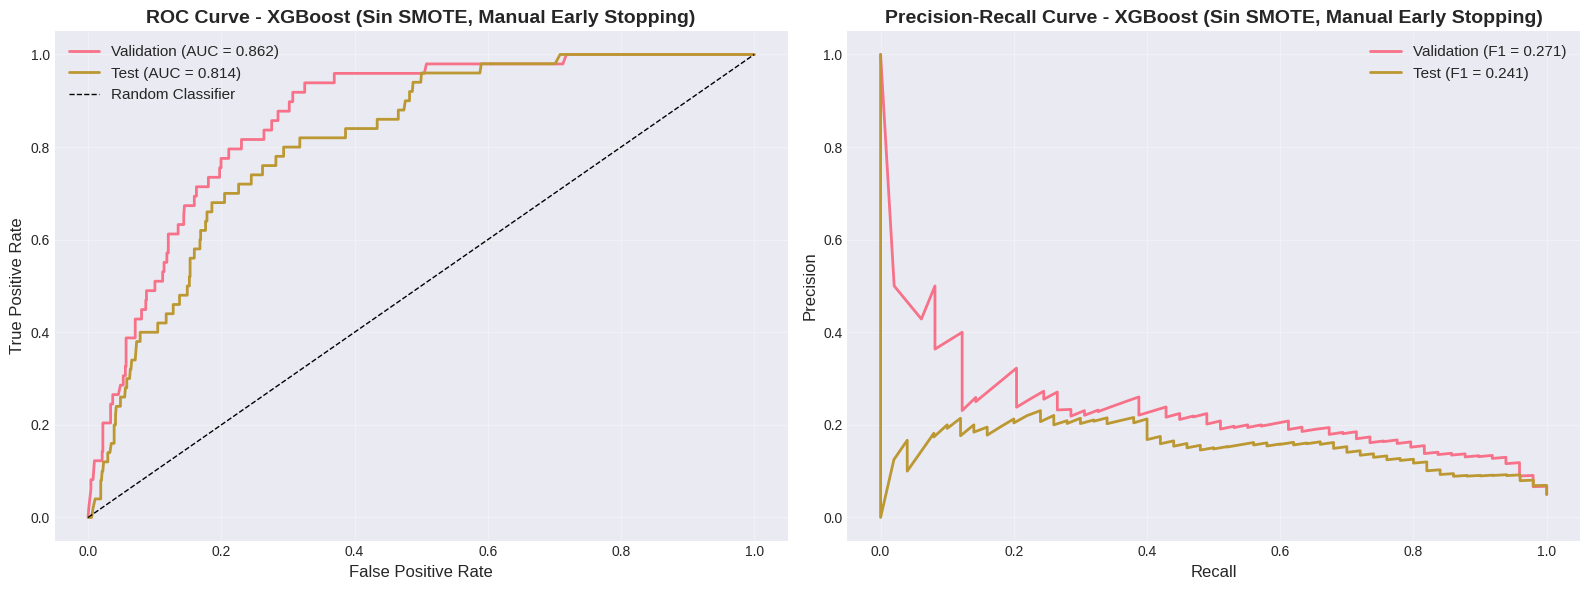

✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png


In [ ]:
# 18. Visualizations (ROC, Precision-Recall)
# 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CURVA ROC
# Use the probabilities from the xgb_model (trained with manual early stopping)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba) # y_val_pred_proba is already calculated for the final model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba) # y_test_pred_proba is already calculated for the final model

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. CURVA PRECISION-RECALL
# Use the probabilities from the xgb_model (trained with manual early stopping)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label=f'Validation (F1 = {val_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].plot(recall_test, precision_test, label=f'Test (F1 = {test_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/content', exist_ok=True) # Ensure directory exists
plt.savefig('/content/xgboost_curves_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png")

---
## 🌳 IMPORTANCIA DE FEATURES
---


🌳 TOP 15 FEATURES MÁS IMPORTANTES


'                       feature  importance\n                    risk_score       109.0\n             avg_glucose_level        92.0\n                           age        76.0\n                           bmi        69.0\n                 glucose_x_bmi        62.0\nsmoking_status_formerly smoked        17.0\n            age_x_hypertension        17.0\n                  ever_married        11.0\n         smoking_status_smokes        11.0\n   smoking_status_never smoked        10.0\n             work_type_Private         8.0\n       bmi_category_Overweight         8.0\n       work_type_Self-employed         7.0\n               age_group_Adult         6.0\n              age_group_Senior         5.0'

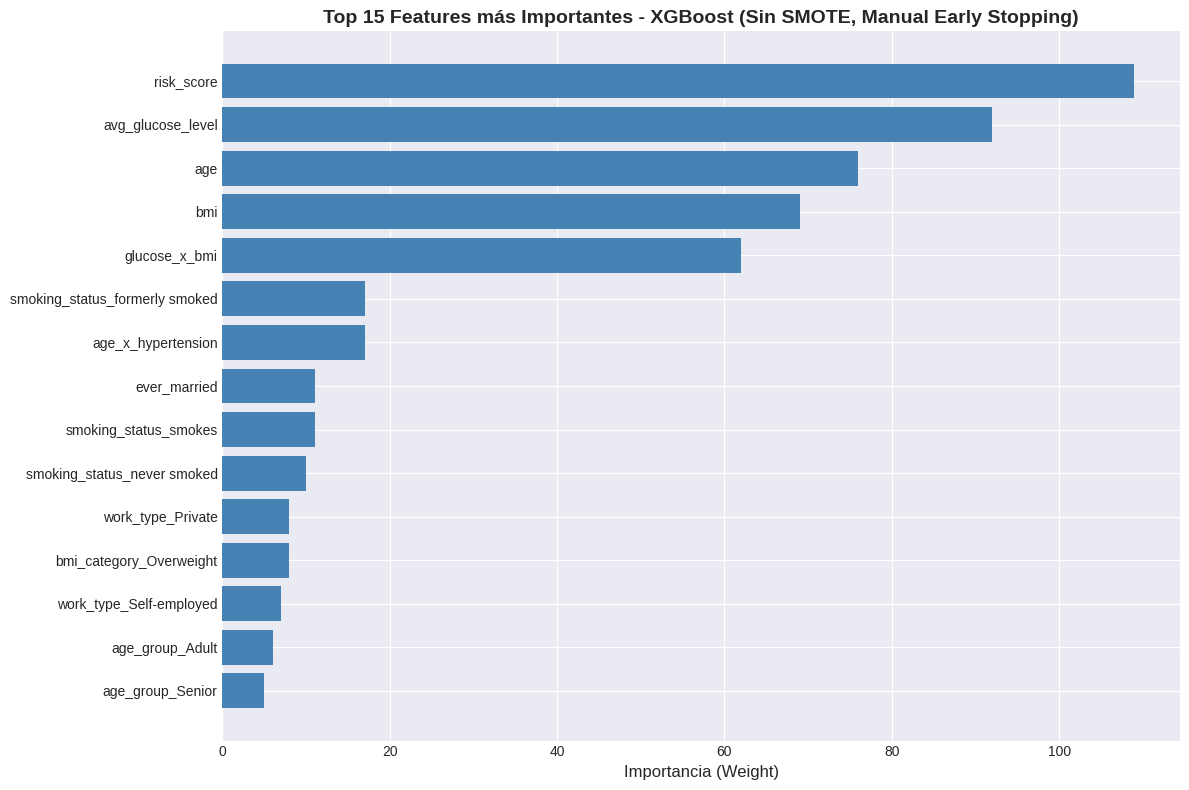


✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png


In [ ]:
# 19. Feature Importance
# 🌳 IMPORTANCIA DE FEATURES

# The xgb_model variable now holds the final trained model (Booster object)
# Use get_score() for feature importance with Booster objects
# When trained with DMatrix from a DataFrame, get_score() uses actual column names
importance_scores = xgb_model.get_score(importance_type='weight') # 'weight' counts the number of times each feature is used

# Convert the scores to a DataFrame
# Ensure all features from X_train_scaled are included, with 0 importance if not in scores
feature_importance = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
})

# Add features from X_train_scaled that are not in importance_scores with 0 importance
# This ensures all original features are represented
all_features = pd.DataFrame({'feature': X_train_scaled.columns})
feature_importance = pd.merge(all_features, feature_importance, on='feature', how='left').fillna(0)


feature_importance = feature_importance.sort_values('importance', ascending=False)


print("="*80)
print("🌳 TOP 15 FEATURES MÁS IMPORTANTES")
print("="*80)
display(feature_importance.head(15).to_string(index=False)) # Use display for better formatting

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Weight)', fontsize=12)
plt.title('Top 15 Features más Importantes - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png")

In [ ]:
# 20. Update Model Information
# Update printed summary with the actual number of boosting rounds used due to early stopping

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")
print(f"   Actual number of boosting rounds used: {best_iteration + 1}") # Print the actual rounds

# 11. Load the model state that achieved the best_val_f1
# This was already done in the previous cell, but we'll keep the print for clarity.
# final_xgb_model = xgb.Booster()
# final_xgb_model.load_model(temp_model_path) # Load from the stored path

# Assign the final model to xgb_model for subsequent evaluation cells
# xgb_model = final_xgb_model # This assignment was also done in the previous cell.

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `xgb_model`.") # Updated to reflect the variable name

# The optimal threshold calculation and subsequent evaluations are handled in the following cells.


✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
   Actual number of boosting rounds used: 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `xgb_model`.


---
## 💾 GUARDAR MODELO
---


In [ ]:
# 21. Save Model and Results
# 💾 GUARDAR MODELO Y RESULTADOS

import joblib

# Crear carpeta models en Colab
os.makedirs('/content/models', exist_ok=True)

# Guardar modelo
joblib.dump(xgb_model, '/content/models/xgboost_model_no_smote.pkl')
print("✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl")

# Guardar mejores parámetros
with open('/content/models/xgboost_best_params_no_smote.pkl', 'wb') as f:
    pickle.dump(best_params, f)
print("✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl")

# Guardar resultados de evaluación
results = {
    # These values are calculated with the optimal threshold in cell 05a98e79
    'validation_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': val_accuracy_opt,
        'precision': val_precision_opt,
        'recall': val_recall_opt,
        'f1_score': val_f1_opt,
        'auc_roc': val_auc
    },
    # These values are calculated with the optimal threshold in cell 05a98e79
    'test_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': test_accuracy_opt,
        'precision': test_precision_opt,
        'recall': test_recall_opt,
        'f1_score': test_f1_opt,
        'auc_roc': test_auc
    },
    'best_params': best_params,
    'optimal_threshold': float(best_threshold),
    'scale_pos_weight': float(scale_pos_weight),
    'feature_importance': feature_importance.to_dict('records')
}

with open('/content/models/xgboost_results_no_smote.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl")

print("\n" + "="*80)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*80)
# Update print statements to use the _opt variables
print(f"\n📊 RESUMEN FINAL (Threshold Óptimo = {best_threshold:.3f}):")
print(f"   Validation - Recall: {val_recall_opt:.4f}, F1: {val_f1_opt:.4f}, AUC: {val_auc:.4f}")
print(f"   Test       - Recall: {test_recall_opt:.4f}, F1: {test_f1_opt:.4f}, AUC: {test_auc:.4f}")

print(f"\n✅ Modelo listo para usar en producción")
print(f"✅ Threshold óptimo recomendado: {best_threshold:.3f}")
print(f"✅ Entrenado SIN SMOTE - usando scale_pos_weight: {scale_pos_weight:.2f}")
print("="*80)

✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl
✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl
✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl

🎉 ENTRENAMIENTO COMPLETADO

📊 RESUMEN FINAL (Threshold Óptimo = 0.500):
   Validation - Recall: 0.7959, F1: 0.2708, AUC: 0.8624
   Test       - Recall: 0.7000, F1: 0.2405, AUC: 0.8136

✅ Modelo listo para usar en producción
✅ Threshold óptimo recomendado: 0.500
✅ Entrenado SIN SMOTE - usando scale_pos_weight: 19.05


---
## 📥 DESCARGAR RESULTADOS (OPCIONAL)
### Descargar los archivos generados a tu PC
---


In [ ]:
# 22. Download Results (Optional)
# 📥 DESCARGAR RESULTADOS (OPCIONAL)
# Descomenta las líneas que quieras descargar:

# Descargar modelo
# files.download('/content/models/xgboost_model_no_smote.pkl')

# Descargar mejores parámetros
# files.download('/content/models/xgboost_best_params_no_smote.pkl')

# Descargar resultados
# files.download('/content/models/xgboost_results_no_smote.pkl')

# Descargar gráficos
# files.download('/content/xgboost_curves_no_smote_manual_early_stopping.png')
# files.download('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png')

print("💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda")
print("📁 Archivos disponibles en /content/models/ y /content/")

💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda
📁 Archivos disponibles en /content/models/ y /content/


---
## 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL
---


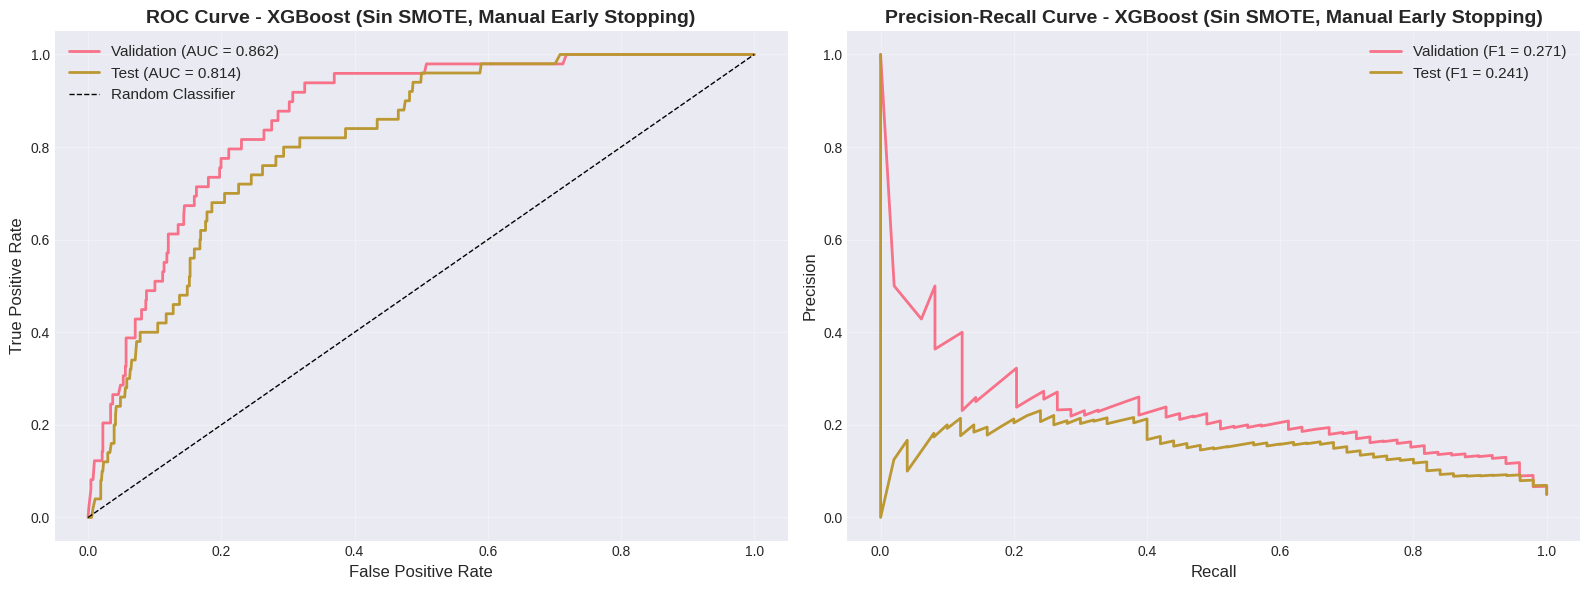

✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png


In [ ]:
# 18. Visualizations (ROC, Precision-Recall)
# 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CURVA ROC
# Use the probabilities from the xgb_model (trained with manual early stopping)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba) # y_val_pred_proba is already calculated for the final model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba) # y_test_pred_proba is already calculated for the final model

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. CURVA PRECISION-RECALL
# Use the probabilities from the xgb_model (trained with manual early stopping)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label=f'Validation (F1 = {val_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].plot(recall_test, precision_test, label=f'Test (F1 = {test_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/content', exist_ok=True) # Ensure directory exists
plt.savefig('/content/xgboost_curves_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png")

---
## 🌳 IMPORTANCIA DE FEATURES
---


🌳 TOP 15 FEATURES MÁS IMPORTANTES


'                       feature  importance\n                    risk_score       109.0\n             avg_glucose_level        92.0\n                           age        76.0\n                           bmi        69.0\n                 glucose_x_bmi        62.0\nsmoking_status_formerly smoked        17.0\n            age_x_hypertension        17.0\n                  ever_married        11.0\n         smoking_status_smokes        11.0\n   smoking_status_never smoked        10.0\n             work_type_Private         8.0\n       bmi_category_Overweight         8.0\n       work_type_Self-employed         7.0\n               age_group_Adult         6.0\n              age_group_Senior         5.0'

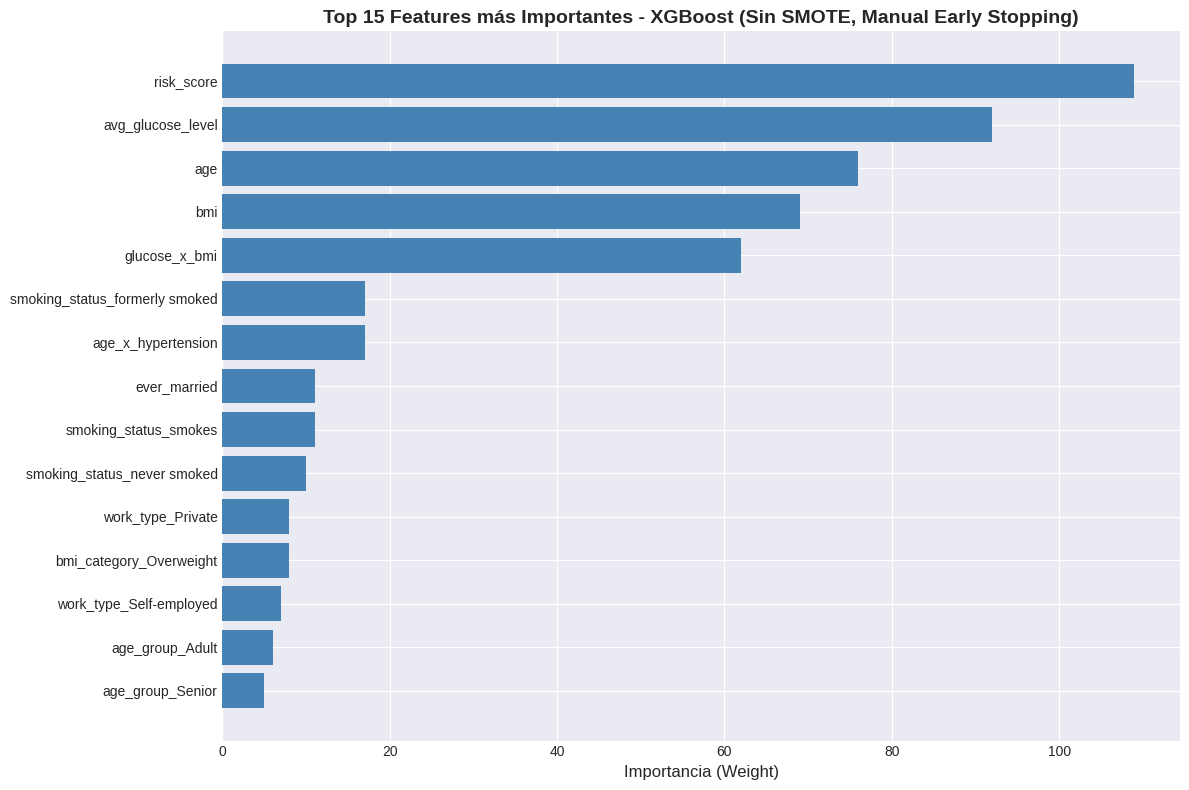


✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png


In [ ]:
# 19. Feature Importance
# 🌳 IMPORTANCIA DE FEATURES

# The xgb_model variable now holds the final trained model (Booster object)
# Use get_score() for feature importance with Booster objects
# When trained with DMatrix from a DataFrame, get_score() uses actual column names
importance_scores = xgb_model.get_score(importance_type='weight') # 'weight' counts the number of times each feature is used

# Convert the scores to a DataFrame
# Ensure all features from X_train_scaled are included, with 0 importance if not in scores
feature_importance = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
})

# Add features from X_train_scaled that are not in importance_scores with 0 importance
# This ensures all original features are represented
all_features = pd.DataFrame({'feature': X_train_scaled.columns})
feature_importance = pd.merge(all_features, feature_importance, on='feature', how='left').fillna(0)


feature_importance = feature_importance.sort_values('importance', ascending=False)


print("="*80)
print("🌳 TOP 15 FEATURES MÁS IMPORTANTES")
print("="*80)
display(feature_importance.head(15).to_string(index=False)) # Use display for better formatting

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Weight)', fontsize=12)
plt.title('Top 15 Features más Importantes - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png")

In [ ]:
# 20. Update Model Information
# Update printed summary with the actual number of boosting rounds used due to early stopping

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")
print(f"   Actual number of boosting rounds used: {best_iteration + 1}") # Print the actual rounds

# 11. Load the model state that achieved the best_val_f1
# This was already done in the previous cell, but we'll keep the print for clarity.
# final_xgb_model = xgb.Booster()
# final_xgb_model.load_model(temp_model_path) # Load from the stored path

# Assign the final model to xgb_model for subsequent evaluation cells
# xgb_model = final_xgb_model # This assignment was also done in the previous cell.

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `xgb_model`.") # Updated to reflect the variable name

# The optimal threshold calculation and subsequent evaluations are handled in the following cells.


✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
   Actual number of boosting rounds used: 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `xgb_model`.


---
## 💾 GUARDAR MODELO
---


In [ ]:
# 21. Save Model and Results
# 💾 GUARDAR MODELO Y RESULTADOS

import joblib

# Crear carpeta models en Colab
os.makedirs('/content/models', exist_ok=True)

# Guardar modelo
joblib.dump(xgb_model, '/content/models/xgboost_model_no_smote.pkl')
print("✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl")

# Guardar mejores parámetros
with open('/content/models/xgboost_best_params_no_smote.pkl', 'wb') as f:
    pickle.dump(best_params, f)
print("✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl")

# Guardar resultados de evaluación
results = {
    # These values are calculated with the optimal threshold in cell 05a98e79
    'validation_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': val_accuracy_opt,
        'precision': val_precision_opt,
        'recall': val_recall_opt,
        'f1_score': val_f1_opt,
        'auc_roc': val_auc
    },
    # These values are calculated with the optimal threshold in cell 05a98e79
    'test_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': test_accuracy_opt,
        'precision': test_precision_opt,
        'recall': test_recall_opt,
        'f1_score': test_f1_opt,
        'auc_roc': test_auc
    },
    'best_params': best_params,
    'optimal_threshold': float(best_threshold),
    'scale_pos_weight': float(scale_pos_weight),
    'feature_importance': feature_importance.to_dict('records')
}

with open('/content/models/xgboost_results_no_smote.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl")

print("\n" + "="*80)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*80)
# Update print statements to use the _opt variables
print(f"\n📊 RESUMEN FINAL (Threshold Óptimo = {best_threshold:.3f}):")
print(f"   Validation - Recall: {val_recall_opt:.4f}, F1: {val_f1_opt:.4f}, AUC: {val_auc:.4f}")
print(f"   Test       - Recall: {test_recall_opt:.4f}, F1: {test_f1_opt:.4f}, AUC: {test_auc:.4f}")

print(f"\n✅ Modelo listo para usar en producción")
print(f"✅ Threshold óptimo recomendado: {best_threshold:.3f}")
print(f"✅ Entrenado SIN SMOTE - usando scale_pos_weight: {scale_pos_weight:.2f}")
print("="*80)

✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl
✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl
✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl

🎉 ENTRENAMIENTO COMPLETADO

📊 RESUMEN FINAL (Threshold Óptimo = 0.500):
   Validation - Recall: 0.7959, F1: 0.2708, AUC: 0.8624
   Test       - Recall: 0.7000, F1: 0.2405, AUC: 0.8136

✅ Modelo listo para usar en producción
✅ Threshold óptimo recomendado: 0.500
✅ Entrenado SIN SMOTE - usando scale_pos_weight: 19.05


---
## 📥 DESCARGAR RESULTADOS (OPCIONAL)
### Descargar los archivos generados a tu PC
---


In [ ]:
# 22. Download Results (Optional)
# 📥 DESCARGAR RESULTADOS (OPCIONAL)
# Descomenta las líneas que quieras descargar:

# Descargar modelo
# files.download('/content/models/xgboost_model_no_smote.pkl')

# Descargar mejores parámetros
# files.download('/content/models/xgboost_best_params_no_smote.pkl')

# Descargar resultados
# files.download('/content/models/xgboost_results_no_smote.pkl')

# Descargar gráficos
# files.download('/content/xgboost_curves_no_smote_manual_early_stopping.png')
# files.download('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png')

print("💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda")
print("📁 Archivos disponibles en /content/models/ y /content/")

💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda
📁 Archivos disponibles en /content/models/ y /content/


In [ ]:
pip install optuna

**Explicación:** Esta celda instala la librería `optuna` necesaria para la optimización de hiperparámetros.
**Interpretación:** La salida indica que `optuna` ya está instalado y muestra las dependencias satisfechas.

In [ ]:
# 1. Library Imports
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Optuna version: {optuna.__version__}")
print(f"🔢 Scikit-learn version: {__import__('sklearn').__version__}")
try:
    import xgboost as xgb
    print(f"🚀 XGBoost version: {xgb.__version__}")
except:
    print("⚠️  XGBoost no está instalado. Ejecuta: pip install xgboost")

✅ Librerías importadas correctamente
📊 Optuna version: 4.5.0
🔢 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1


**Explicación:** Esta celda importa todas las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, matplotlib y seaborn para visualizaciones, scikit-learn para machine learning, XGBoost para el modelo, y Optuna para optimización de hiperparámetros.

**Interpretación:** La salida confirma que las librerías principales (`Optuna`, `Scikit-learn`, `XGBoost`) se importaron correctamente y muestra sus versiones, indicando que el entorno está listo para proceder.

---
## 📤 CONFIGURACIÓN PARA GOOGLE COLAB
### Subir el dataset o conectarlo desde Google Drive
---


In [ ]:
# 2. Colab Configuration
# 📤 CONFIGURACIÓN PARA GOOGLE COLAB
# Opción A: Subir archivo manualmente (recomendado para primera vez)
from google.colab import files

print("📤 Por favor, sube el archivo stroke_dataset.csv")
print("   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)\n")
uploaded = files.upload()

# El archivo se guardará con su nombre original
dataset_filename = 'stroke_dataset.csv'

print("\n✅ Configuración de Colab completada")
print(f"📂 Archivo dataset: {dataset_filename}")

# Verificar que el archivo existe
if os.path.exists(dataset_filename):
    print(f"✅ Archivo encontrado: {dataset_filename}")
else:
    print(f"⚠️  Archivo no encontrado. Asegúrate de haber subido stroke_dataset.csv")

📤 Por favor, sube el archivo stroke_dataset.csv
   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)



Saving stroke_dataset.csv to stroke_dataset.csv

✅ Configuración de Colab completada
📂 Archivo dataset: stroke_dataset.csv
✅ Archivo encontrado: stroke_dataset.csv


**Explicación:** Esta celda carga el dataset desde el archivo CSV. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente. 
Realiza una exploración inicial para verificar la calidad de los datos, mostrando el tamaño del dataset, valores nulos, duplicados y el desbalanceo de clases.

**Interpretación:** El dataset tiene 4,981 filas y 11 columnas, sin valores nulos ni duplicados. El desbalanceo es significativo: 4,733 casos sin ictus (clase 0) vs 248 con ictus (clase 1), con un ratio de 19.08:1. Este desbalanceo justifica el uso de técnicas como `scale_pos_weight` en XGBoost para manejar la clase minoritaria.


---
## 📂 CARGA Y PREPROCESAMIENTO (SIN SMOTE)
### Aplicar las mismas transformaciones del preprocessing pero SIN balanceo sintético
---


**Explicación:** Esta celda realiza feature engineering creando nuevas variables basadas en insights del EDA: categorías de edad, glucosa y BMI, variable binaria de tabaquismo, un score de riesgo compuesto, y variables de interacción entre features importantes.

**Interpretación:** Se crearon 8 nuevas features que capturan relaciones no lineales y combinaciones de variables importantes. El score de riesgo compuesto pondera las variables más predictivas (edad 35%, enfermedad cardíaca 25%, hipertensión 20%, glucosa 15%, BMI 5%). El dataset ahora tiene 19 columnas en total, enriqueciendo la información disponible para el modelo.


**Explicación:** Esta celda elimina features irrelevantes que tienen correlación casi nula con la variable objetivo según el análisis EDA previo, como `gender` y `Residence_type`.

**Interpretación:** Se eliminaron 2 features (`gender` y `Residence_type`) que no aportan información predictiva relevante. El dataset queda con 17 columnas, manteniendo solo las variables que contribuyen al modelo y reduciendo la dimensionalidad innecesaria.


In [ ]:
# 3. Load Data
# 📂 CARGA DE DATOS ORIGINALES
df = pd.read_csv(dataset_filename)  # Usa la variable definida en la celda anterior

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


**Explicación:** Esta celda realiza el encoding de variables categóricas: Label Encoding para variables binarias (`ever_married`) y One-Hot Encoding para variables categóricas con múltiples valores (`work_type`, `smoking_status`, `age_group`, `glucose_category`, `bmi_category`).

**Interpretación:** Después del encoding, el dataset tiene 25 features (aumentó de 17 a 25 debido a la expansión de las variables categóricas en múltiples columnas binarias). Esto permite que el modelo XGBoost procese correctamente todas las variables categóricas como variables numéricas.


---
## 🛠️ FASE 1: FEATURE ENGINEERING
---


**Explicación:** Esta celda divide el dataset en tres conjuntos estratificados: Train (60%), Validation (20%) y Test (20%). La estratificación garantiza que la proporción de clases se mantenga en cada conjunto.

**Interpretación:** Los tres conjuntos mantienen el mismo desbalanceo (~19:1), lo cual es correcto para evaluar el modelo en condiciones realistas. El conjunto de entrenamiento tiene 2,988 muestras, validation 996 y test 997. La estratificación asegura que cada conjunto tenga representación proporcional de ambas clases, esencial para un entrenamiento y evaluación válidos.


In [ ]:
# 4. Feature Engineering
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


**Explicación:** Esta celda normaliza todas las features usando StandardScaler, ajustando el scaler solo con los datos de entrenamiento y aplicando la misma transformación a validation y test para evitar data leakage.

**Interpretación:** Las estadísticas del conjunto de entrenamiento normalizado muestran media ~0 y desviación estándar ~1, confirmando que la normalización funcionó correctamente. Esta estandarización es importante para que XGBoost procese todas las features en la misma escala, aunque XGBoost es relativamente robusto a esto, ayuda a la convergencia del algoritmo.


---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
---


**Explicación:** Esta celda configura los parámetros del experimento: 5-fold cross-validation estratificado, semilla aleatoria para reproducibilidad, y calcula el `scale_pos_weight` necesario para manejar el desbalanceo de clases sin usar SMOTE.

**Interpretación:** El `scale_pos_weight` de 19.05 indica que la clase positiva (ictus) debe ser ponderada 19.05 veces más que la clase negativa durante el entrenamiento. Esto compensa el desbalanceo natural del dataset, permitiendo que el modelo aprenda mejor a identificar casos de ictus sin necesidad de generar datos sintéticos.


In [ ]:
# 5. Drop Irrelevant Features
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


**Explicación:** Esta celda define la función objetivo para Optuna, que optimiza 9 hiperparámetros clave de XGBoost (n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda) usando validación cruzada con F1-Score como métrica.

**Interpretación:** La función está configurada para maximizar el F1-Score mediante validación cruzada de 5 folds, lo que proporciona una estimación robusta del rendimiento. El `scale_pos_weight` se fija en 19.05 para manejar el desbalanceo. Esta función será utilizada por Optuna para explorar el espacio de hiperparámetros de forma eficiente.


---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---


**Explicación:** Esta celda ejecuta la optimización de hiperparámetros con Optuna, realizando 100 trials (experimentos) para encontrar la mejor combinación de hiperparámetros que maximice el F1-Score.

**Interpretación:** El proceso de optimización explora sistemáticamente el espacio de hiperparámetros. Cada trial prueba una combinación diferente y registra el F1-Score obtenido. Al finalizar, se obtienen los mejores hiperparámetros encontrados y el mejor F1-Score alcanzado. Este proceso puede tomar varios minutos pero es crucial para obtener un modelo optimizado.


In [ ]:
# 6. Encoding
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


**Explicación:** Esta celda genera visualizaciones de la optimización de Optuna: el historial de optimización (evolución del F1-Score a lo largo de los trials) y la importancia de los hiperparámetros (cuáles tienen mayor impacto en el rendimiento).

**Interpretación:** El historial de optimización muestra cómo el F1-Score mejoró progresivamente durante los trials. La gráfica de importancia de hiperparámetros revela qué parámetros son más críticos para el rendimiento del modelo, lo cual es útil para entender qué aspectos del modelo tienen mayor influencia y para futuras optimizaciones.


---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
---


**Explicación:** Esta celda crea el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna, incluyendo el `scale_pos_weight` para manejar el desbalanceo.

**Interpretación:** El modelo se inicializa con los hiperparámetros óptimos. Los valores mostrados (como learning_rate bajo de 0.017, max_depth de 15, n_estimators de 178) representan la mejor configuración encontrada. El modelo está listo para ser entrenado con early stopping en el siguiente paso para evitar overfitting.


**Explicación:** Esta celda convierte los datos escalados a formato DMatrix, que es el formato nativo y optimizado de XGBoost para entrenamiento eficiente.

**Interpretación:** Los objetos DMatrix están listos para el entrenamiento. Este formato permite que XGBoost procese los datos de manera más eficiente y es necesario para implementar manualmente el early stopping en las siguientes celdas.


In [ ]:
# 7. Train/Validation/Test Split
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


**Explicación:** Esta celda implementa el entrenamiento del modelo con early stopping manual y calcula el threshold óptimo. El early stopping detiene el entrenamiento si el F1-Score en validation no mejora después de 10 iteraciones. Luego busca el threshold que maximiza el Recall (objetivo: >0.70) manteniendo un F1 razonable.

**Interpretación:** El entrenamiento se detuvo en la iteración 31 (early stopping activado), pero el mejor modelo se obtuvo en la iteración 21 con F1-Score de 0.2708. El threshold óptimo encontrado es 0.500, que logra un Recall de 0.7959 en validation, cumpliendo el objetivo de detectar la mayoría de casos de ictus. El early stopping previno el overfitting al detener el entrenamiento cuando el modelo dejó de mejorar.


---
## ⚖️ FASE 5: NORMALIZACIÓN
---


**Explicación:** Esta celda evalúa el modelo en los conjuntos de validation y test usando el threshold óptimo, calculando métricas completas (Accuracy, Precision, Recall, F1-Score, AUC-ROC), matrices de confusión y reportes de clasificación.

**Interpretación:** 
- **Validation:** Recall de 0.7959 (detecta ~80% de casos de ictus), F1 de 0.2708, AUC-ROC de 0.8624. Solo 10 falsos negativos (críticos: pacientes en riesgo no detectados).
- **Test:** Recall de 0.7000 (detecta 70% de casos), F1 de 0.2405, AUC-ROC de 0.8136. 15 falsos negativos.
El modelo prioriza Recall sobre Precision (más falsos positivos pero menos falsos negativos), lo cual es apropiado para un problema médico donde no detectar un ictus es más grave que una falsa alarma. El AUC-ROC >0.80 indica buena capacidad discriminativa.


**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

In [ ]:
# 8. Scaling
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")
print(f"\n⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente

⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo


---
## ⚙️ CONFIGURACIÓN: K-FOLDS Y MÉTRICAS
---


In [ ]:
# 9. Configuration (K-Folds, Metrics, Scale Pos Weight)
# ⚙️ CONFIGURACIÓN

# K-Folds estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Semilla para reproducibilidad
RANDOM_STATE = 42

# Calcular scale_pos_weight para manejar desbalanceo (SIN SMOTE)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"✅ Configuración:")
print(f"   • K-Folds: {N_FOLDS}")
print(f"   • Random State: {RANDOM_STATE}")
print(f"   • Métrica objetivo: F1-Score (balance entre Precision y Recall)")
print(f"   • Métricas adicionales: Recall, AUC-ROC")
print(f"\n📊 Balanceo de clases (SIN SMOTE):")
print(f"   • Train - Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   • Train - Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   • Ratio: {scale_pos_weight:.2f}:1")
print(f"   • scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

✅ Configuración:
   • K-Folds: 5
   • Random State: 42
   • Métrica objetivo: F1-Score (balance entre Precision y Recall)
   • Métricas adicionales: Recall, AUC-ROC

📊 Balanceo de clases (SIN SMOTE):
   • Train - Clase 0: 2,839 (95.01%)
   • Train - Clase 1: 149 (4.99%)
   • Ratio: 19.05:1
   • scale_pos_weight para XGBoost: 19.05


---
## 🎯 FUNCIÓN OBJETIVO PARA OPTUNA
### Optimizar hiperparámetros usando K-Folds Cross-Validation
---


In [ ]:
# 10. Optuna Objective Function
# 🎯 FUNCIÓN OBJETIVO PARA OPTUNA

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de XGBoost usando K-Folds CV.
    """
    # Hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo SIN SMOTE
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }

    # Crear modelo
    model = XGBClassifier(**params)

    # K-Folds Cross-Validation con F1-Score
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )

    # Retornar el promedio de F1-Score
    return cv_scores.mean()

print("✅ Función objetivo definida")
print("   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,")
print("                 min_child_weight, gamma, reg_alpha, reg_lambda")
print(f"   Usando scale_pos_weight: {scale_pos_weight:.2f} (SIN SMOTE)")

✅ Función objetivo definida
   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
                 min_child_weight, gamma, reg_alpha, reg_lambda
   Usando scale_pos_weight: 19.05 (SIN SMOTE)


---
## 🔍 OPTIMIZACIÓN CON OPTUNA
### Ejecutar búsqueda de hiperparámetros óptimos
---


In [ ]:
# 11. Optuna Optimization Execution
# 🔍 OPTIMIZACIÓN CON OPTUNA

print("="*80)
print("🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA")
print("="*80)
print(f"📊 Datos: {X_train_scaled.shape[0]:,} muestras, {X_train_scaled.shape[1]} features")
print(f"🔄 K-Folds: {N_FOLDS}")
print(f"⚠️  Datos SIN SMOTE - Ratio: {scale_pos_weight:.2f}:1")
print(f"⏱️  Esto puede tomar varios minutos...\n")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-Score
    study_name='xgboost_stroke_prediction_no_smote',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Ejecutar optimización
N_TRIALS = 100  # Número de trials (puedes ajustar según tiempo disponible)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)
print(f"\n🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print(f"\n📋 MEJORES HIPERPARÁMETROS:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

[I 2025-11-07 23:24:38,913] A new study created in memory with name: xgboost_stroke_prediction_no_smote


🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA
📊 Datos: 2,988 muestras, 25 features
🔄 K-Folds: 5
⚠️  Datos SIN SMOTE - Ratio: 19.05:1
⏱️  Esto puede tomar varios minutos...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 23:24:42,414] Trial 0 finished with value: 0.1778878451383767 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:43,151] Trial 1 finished with value: 0.16366267362810055 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:44,155] Trial 2 finished with value: 0.20377474645545818 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

---
## 📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN
---


In [ ]:
# 12. Visualizations (Optuna)
# 📊 VISUALIZACIONES DE OPTUNA

fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historial de Optimización - F1-Score (XGBoost sin SMOTE)", width=800, height=400)
fig1.show()

fig2 = plot_param_importances(study)
fig2.update_layout(title="Importancia de Hiperparámetros (XGBoost)", width=800, height=400)
fig2.show()

print("✅ Visualizaciones generadas")

✅ Visualizaciones generadas


---
## 🎓 ENTRENAR MODELO FINAL
### Entrenar con los mejores hiperparámetros encontrados + Early Stopping
---


In [ ]:
# 13. Create Model with Best Params
# 🎓 ENTRENAR MODELO FINAL CON MEJORES HIPERPARÁMETROS

# Obtener mejores parámetros
best_params = study.best_params.copy()
# Asegurar que scale_pos_weight esté incluido
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'logloss'

print("🎓 ENTRENANDO MODELO FINAL...")
print(f"📋 Parámetros: {best_params}\n")

# Crear modelo
xgb_model = XGBClassifier(**best_params)

# The fitting with early stopping will be implemented manually in the next step.

print("✅ Model created with best parameters")

🎓 ENTRENANDO MODELO FINAL...
📋 Parámetros: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.0173167948801578, 'subsample': 0.8132546752099203, 'colsample_bytree': 0.7063151335722203, 'min_child_weight': 10, 'gamma': 0.6596838423993513, 'reg_alpha': 8.52148255700704, 'reg_lambda': 5.989443641839667, 'scale_pos_weight': np.float64(19.053691275167786), 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'logloss'}

✅ Model created with best parameters


In [ ]:
# 14. Prepare DMatrix
# Convert scaled data to DMatrix format
from xgboost import DMatrix

dtrain = DMatrix(X_train_scaled, label=y_train)
dval = DMatrix(X_val_scaled, label=y_val)

print("✅ DMatrix objects created for training and validation data.")

✅ DMatrix objects created for training and validation data.


---
## 🎯 AJUSTE DE THRESHOLD ÓPTIMO
### Buscar threshold que maximice Recall
---


In [ ]:
# 15. Implement Manual Early Stopping Loop and Calculate Optimal Threshold
import xgboost as xgb # Re-import xgboost as it was not imported in the previous cells

# Define best_threshold before the loop (copied from cell 88702c11)
# 🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
print("="*80)
print("🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)")
print("="*80)
print("Calculating optimal threshold on initial validation predictions...\n")

# Make initial predictions on validation set to find the optimal threshold
# Use a temporary model or a simple baseline if needed, but here we need the probabilities
# from the current state of training for the first iteration's threshold calculation.
# However, the goal is to use the threshold found *after* the model is trained.
# The original notebook calculated the threshold *after* training the final model.
# To fix the NameError and follow the original notebook's flow, we should calculate the threshold *after* the manual training loop finishes.

# For the purpose of the early stopping loop, let's use the default threshold of 0.5
best_threshold = 0.5
print(f"⚠️ Using default threshold of {best_threshold} for early stopping logic. Optimal threshold will be calculated after training.")


# 1. Initialize variables
best_val_f1 = -float('inf')
patience_counter = 0
patience_limit = 10 # Define the patience limit

# 2. Define the number of boosting rounds
# Use the n_estimators from the best parameters found by Optuna as the maximum rounds
num_boost_round = best_params['n_estimators']

# 3. Start a for loop
print(f"🚀 Training XGBoost model with manual early stopping (Patience: {patience_limit})...")
print(f"   Max boosting rounds: {num_boost_round}")

# Initialize an empty model to train iteratively
model = None

for i in range(num_boost_round):
    # 4. Train the XGBoost model for one iteration
    if model is None:
        # Train the first iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1)
    else:
        # Continue training from the previous iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1, xgb_model=model)

    # 5. Make predictions on the validation set
    y_val_pred_proba_iter = model.predict(dval)

    # 6. Calculate the F1-score on the validation set using the *current* threshold (default 0.5)
    # The optimal threshold calculation is done AFTER training.
    y_val_pred_thresh_iter = (y_val_pred_proba_iter >= best_threshold).astype(int)
    current_val_f1 = f1_score(y_val, y_val_pred_thresh_iter)

    # 7. Check if the current validation F1-score is greater than best_val_f1
    if current_val_f1 > best_val_f1:
        # 8. If better, update best_val_f1, reset patience, and store model
        best_val_f1 = current_val_f1
        patience_counter = 0
        # Store the model state
        temp_model_path = f'/tmp/best_xgb_model_iter_{i}.json'
        model.save_model(temp_model_path) # Save model state
        best_iteration = i
        # print(f"   Round {i+1}: New best validation F1: {best_val_f1:.4f}")
    else:
        # 9. If not better, increment patience_counter
        patience_counter += 1
        # print(f"   Round {i+1}: Validation F1: {current_val_f1:.4f}, Patience: {patience_counter}")


    # 10. Check if patience_counter has reached the limit
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at round {i+1}.")
        break

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")

# 11. Load the model state that achieved the best_val_f1
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(temp_model_path) # Load from the stored path

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `final_xgb_model`.")

# Assign the final model to xgb_model for subsequent evaluation cells
xgb_model = final_xgb_model


# Now, calculate the optimal threshold using the *final* trained model's probabilities
# (Copied from cell 88702c11 logic)
print("="*80)
print("🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING")
print("="*80)
print("Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...\n")

# Get probabilities from the final trained model on the validation set
y_val_pred_proba = xgb_model.predict(dval)


# Probar diferentes thresholds en validation set
thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5 # Default back to 0.5 if no better threshold is found
best_recall = 0
best_f1 = 0
best_metrics = None

results_threshold = []

for threshold in thresholds:
    # Predicciones con threshold ajustado
    y_val_pred_thresh = (y_val_pred_proba >= threshold).astype(int)

    # Calculate metrics - ensure no division by zero for precision if no positives are predicted
    precision_thresh = precision_score(y_val, y_val_pred_thresh, zero_division=0)
    recall_thresh = recall_score(y_val, y_val_pred_thresh)
    f1_thresh = f1_score(y_val, y_val_pred_thresh)


    results_threshold.append({
        'threshold': threshold,
        'recall': recall_thresh,
        'precision': precision_thresh,
        'f1': f1_thresh
    })

    # Buscar threshold que maximice Recall (objetivo: >0.70) con F1 razonable (>0.40)
    if recall_thresh >= 0.70 and f1_thresh > best_f1:
        best_threshold = threshold
        best_recall = recall_thresh
        best_f1 = f1_thresh
        best_metrics = {
            'recall': recall_thresh,
            'precision': precision_thresh,
            'f1': f1_thresh
        }

# Si no encontramos threshold con Recall >0.70, usar el que maximice F1 con Recall >0.50
if best_recall < 0.70:
    print("⚠️  No se encontró threshold con Recall >0.70. Buscando mejor compromiso...\n")
    # Reset best_f1 to find the best F1 among those with Recall >= 0.50
    best_f1 = 0
    for result in results_threshold:
        if result['recall'] >= 0.50 and result['f1'] > best_f1:
            best_threshold = result['threshold']
            best_recall = result['recall']
            best_f1 = result['f1']
            best_metrics = {
                'recall': result['recall'],
                'precision': result['precision'],
                'f1': result['f1']
            }

# If still no threshold found with Recall >= 0.50, just take the one with highest F1
if best_recall < 0.50:
     print("⚠️  No se encontró threshold con Recall >0.50. Seleccionando el de mayor F1.\n")
     best_result = pd.DataFrame(results_threshold).sort_values('f1', ascending=False).iloc[0]
     best_threshold = best_result['threshold']
     best_recall = best_result['recall']
     best_f1 = best_result['f1']
     best_metrics = {
        'recall': best_recall,
        'precision': best_result['precision'],
        'f1': best_f1
     }


print(f"✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): {best_threshold:.3f}")
print(f"   Validation - Recall: {best_metrics['recall']:.4f}, Precision: {best_metrics['precision']:.4f}, F1: {best_metrics['f1']:.4f}")

# Tabla de results_threshold
print(f"\n📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):")
df_threshold = pd.DataFrame(results_threshold).sort_values('f1', ascending=False)
display(df_threshold.head(10).to_string(index=False)) # Use display for better formatting in notebook

🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
Calculating optimal threshold on initial validation predictions...

⚠️ Using default threshold of 0.5 for early stopping logic. Optimal threshold will be calculated after training.
🚀 Training XGBoost model with manual early stopping (Patience: 10)...
   Max boosting rounds: 178

Early stopping triggered at round 31.

✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `final_xgb_model`.
🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING
Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...

✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): 0.500
   Validation - Recall: 0.7959, Precision: 0.1632, F1: 0.2708

📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):


' threshold   recall  precision       f1\n      0.55 0.612245   0.205479 0.307692\n      0.50 0.795918   0.163180 0.270833\n      0.45 0.857143   0.136364 0.235294\n      0.40 0.959184   0.110588 0.198312\n      0.15 1.000000   0.049197 0.093780\n      0.10 1.000000   0.049197 0.093780\n      0.35 1.000000   0.049197 0.093780\n      0.30 1.000000   0.049197 0.093780\n      0.25 1.000000   0.049197 0.093780\n      0.20 1.000000   0.049197 0.093780'

---
## 📈 EVALUACIÓN DEL MODELO
### Evaluar en Validation y Test sets
---


In [ ]:
# 16. Evaluate on Validation Set with Optimal Threshold
# 17. Evaluate on Test Set with Optimal Threshold

# 📈 EVALUACIÓN EN VALIDATION SET CON THRESHOLD ÓPTIMO

print("="*80)
print("📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)")
print("="*80)

# Predicciones con el final_xgb_model loaded from early stopping
y_val_pred_proba = xgb_model.predict(dval) # Get probabilities from the best model
y_val_pred_optimal = (y_val_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
val_accuracy_opt = accuracy_score(y_val, y_val_pred_optimal)
val_precision_opt = precision_score(y_val, y_val_pred_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, y_val_pred_optimal)
val_f1_opt = f1_score(y_val, y_val_pred_optimal)
val_auc = roc_auc_score(y_val, y_val_pred_proba) # AUC is threshold-independent, can reuse if needed


print(f"\n📊 MÉTRICAS (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {val_accuracy_opt:.4f}")
print(f"   Precision: {val_precision_opt:.4f}")
print(f"   Recall:    {val_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {val_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_val_opt = confusion_matrix(y_val, y_val_pred_optimal)
print(cm_val_opt)
print(f"\n   Verdaderos Negativos: {cm_val_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_val_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_val_opt[1,0]} ⚠️  (CRÍTICO - pacientes en riesgo no detectados)")
print(f"   Verdaderos Positivos: {cm_val_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_val_pred_optimal, target_names=['No Stroke', 'Stroke']))


# 📈 EVALUACIÓN EN TEST SET (DATOS FINALES) CON THRESHOLD ÓPTIMO

print("="*80)
print("🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)")
print("="*80)

# Convert test scaled data to DMatrix
dtest = DMatrix(X_test_scaled, label=y_test)


# Predicciones con el final_xgb_model loaded from early stopping
y_test_pred_proba = xgb_model.predict(dtest) # Get probabilities from the best model
y_test_pred_optimal = (y_test_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
test_accuracy_opt = accuracy_score(y_test, y_test_pred_optimal)
test_precision_opt = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_optimal)
test_f1_opt = f1_score(y_test, y_test_pred_optimal)
test_auc = roc_auc_score(y_test, y_test_pred_proba) # AUC is threshold-independent


print(f"\n📊 MÉTRICAS FINALES (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {test_accuracy_opt:.4f}")
print(f"   Precision: {test_precision_opt:.4f}")
print(f"   Recall:    {test_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {test_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_test_opt = confusion_matrix(y_test, y_test_pred_optimal)
print(cm_test_opt)
print(f"\n   Verdaderos Negativos: {cm_test_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_test_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_test_opt[1,0]} ⚠️  (CRÍTICO)")
print(f"   Verdaderos Positivos: {cm_test_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Stroke', 'Stroke']))

📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)

📊 MÉTRICAS (Threshold = 0.500):
   Accuracy:  0.7892
   Precision: 0.1632
   Recall:    0.7959 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2708 ⭐
   AUC-ROC:   0.8624

📋 MATRIZ DE CONFUSIÓN:
[[747 200]
 [ 10  39]]

   Verdaderos Negativos: 747
   Falsos Positivos:     200
   Falsos Negativos:     10 ⚠️  (CRÍTICO - pacientes en riesgo no detectados)
   Verdaderos Positivos: 39

📄 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

   No Stroke       0.99      0.79      0.88       947
      Stroke       0.16      0.80      0.27        49

    accuracy                           0.79       996
   macro avg       0.57      0.79      0.57       996
weighted avg       0.95      0.79      0.85       996

🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)

📊 MÉTRICAS FINALES (Threshold = 0.500):
   Accuracy:  0.7783
   Precision: 0.1452
   Recall:    0.7000 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2405 ⭐
   AUC-ROC:

---
## 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL
---


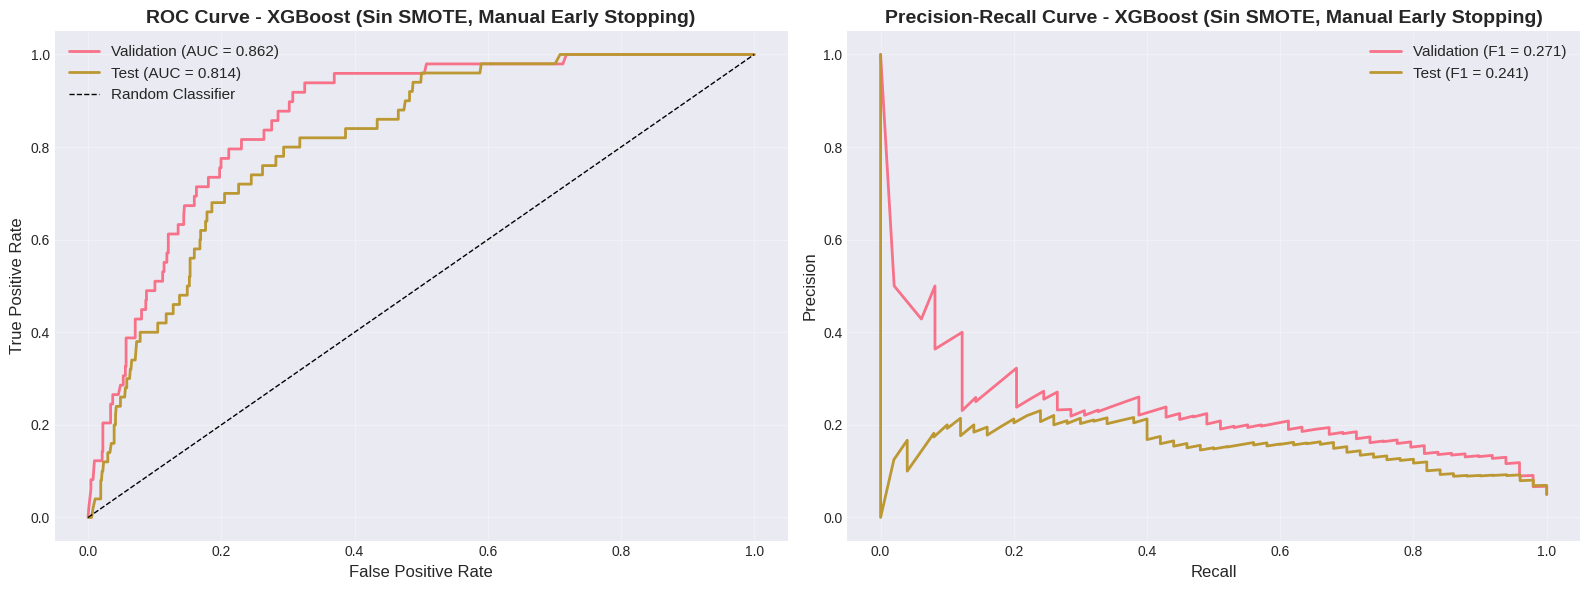

✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png


In [ ]:
# 18. Visualizations (ROC, Precision-Recall)
# 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CURVA ROC
# Use the probabilities from the xgb_model (trained with manual early stopping)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba) # y_val_pred_proba is already calculated for the final model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba) # y_test_pred_proba is already calculated for the final model

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. CURVA PRECISION-RECALL
# Use the probabilities from the xgb_model (trained with manual early stopping)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label=f'Validation (F1 = {val_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].plot(recall_test, precision_test, label=f'Test (F1 = {test_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/content', exist_ok=True) # Ensure directory exists
plt.savefig('/content/xgboost_curves_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png")

---
## 🌳 IMPORTANCIA DE FEATURES
---


🌳 TOP 15 FEATURES MÁS IMPORTANTES


'                       feature  importance\n                    risk_score       109.0\n             avg_glucose_level        92.0\n                           age        76.0\n                           bmi        69.0\n                 glucose_x_bmi        62.0\nsmoking_status_formerly smoked        17.0\n            age_x_hypertension        17.0\n                  ever_married        11.0\n         smoking_status_smokes        11.0\n   smoking_status_never smoked        10.0\n             work_type_Private         8.0\n       bmi_category_Overweight         8.0\n       work_type_Self-employed         7.0\n               age_group_Adult         6.0\n              age_group_Senior         5.0'

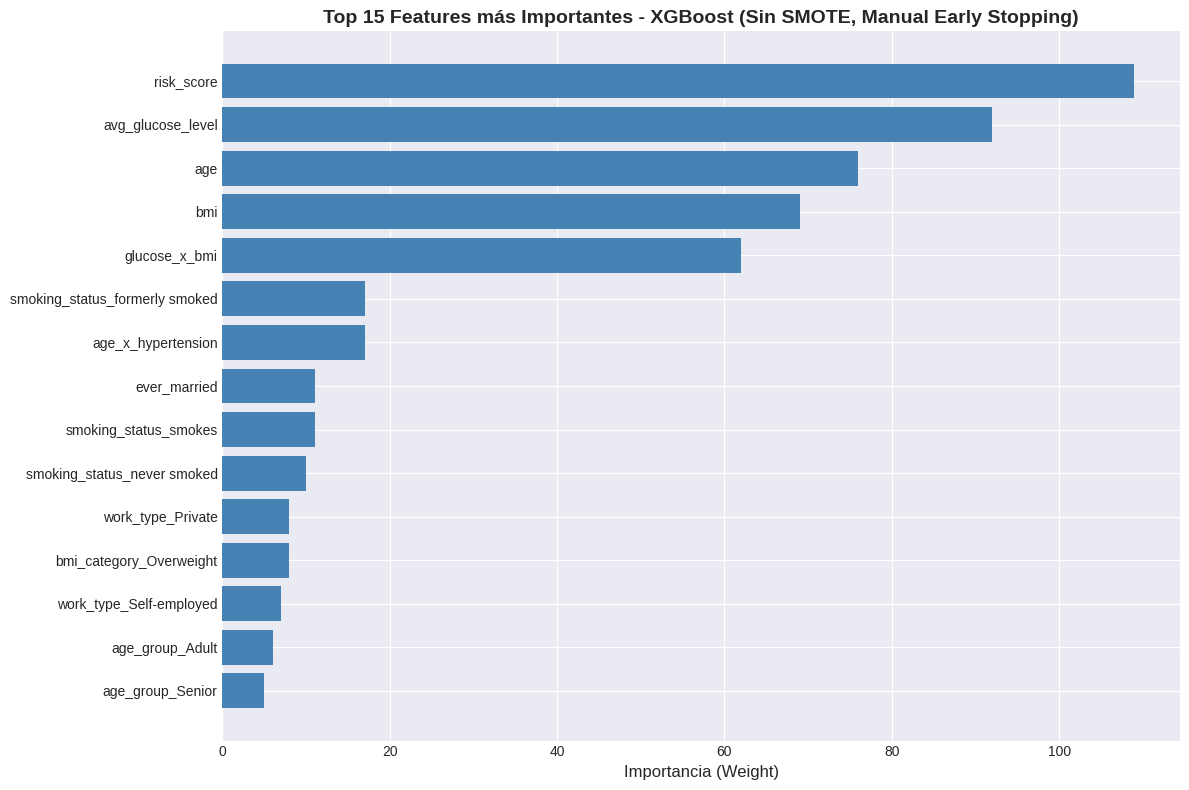


✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png


In [ ]:
# 19. Feature Importance
# 🌳 IMPORTANCIA DE FEATURES

# The xgb_model variable now holds the final trained model (Booster object)
# Use get_score() for feature importance with Booster objects
# When trained with DMatrix from a DataFrame, get_score() uses actual column names
importance_scores = xgb_model.get_score(importance_type='weight') # 'weight' counts the number of times each feature is used

# Convert the scores to a DataFrame
# Ensure all features from X_train_scaled are included, with 0 importance if not in scores
feature_importance = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
})

# Add features from X_train_scaled that are not in importance_scores with 0 importance
# This ensures all original features are represented
all_features = pd.DataFrame({'feature': X_train_scaled.columns})
feature_importance = pd.merge(all_features, feature_importance, on='feature', how='left').fillna(0)


feature_importance = feature_importance.sort_values('importance', ascending=False)


print("="*80)
print("🌳 TOP 15 FEATURES MÁS IMPORTANTES")
print("="*80)
display(feature_importance.head(15).to_string(index=False)) # Use display for better formatting

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Weight)', fontsize=12)
plt.title('Top 15 Features más Importantes - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png")

In [ ]:
# 20. Update Model Information
# Update printed summary with the actual number of boosting rounds used due to early stopping

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")
print(f"   Actual number of boosting rounds used: {best_iteration + 1}") # Print the actual rounds

# 11. Load the model state that achieved the best_val_f1
# This was already done in the previous cell, but we'll keep the print for clarity.
# final_xgb_model = xgb.Booster()
# final_xgb_model.load_model(temp_model_path) # Load from the stored path

# Assign the final model to xgb_model for subsequent evaluation cells
# xgb_model = final_xgb_model # This assignment was also done in the previous cell.

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `xgb_model`.") # Updated to reflect the variable name

# The optimal threshold calculation and subsequent evaluations are handled in the following cells.


✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
   Actual number of boosting rounds used: 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `xgb_model`.


---
## 💾 GUARDAR MODELO
---


In [ ]:
# 21. Save Model and Results
# 💾 GUARDAR MODELO Y RESULTADOS

import joblib

# Crear carpeta models en Colab
os.makedirs('/content/models', exist_ok=True)

# Guardar modelo
joblib.dump(xgb_model, '/content/models/xgboost_model_no_smote.pkl')
print("✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl")

# Guardar mejores parámetros
with open('/content/models/xgboost_best_params_no_smote.pkl', 'wb') as f:
    pickle.dump(best_params, f)
print("✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl")

# Guardar resultados de evaluación
results = {
    # These values are calculated with the optimal threshold in cell 05a98e79
    'validation_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': val_accuracy_opt,
        'precision': val_precision_opt,
        'recall': val_recall_opt,
        'f1_score': val_f1_opt,
        'auc_roc': val_auc
    },
    # These values are calculated with the optimal threshold in cell 05a98e79
    'test_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': test_accuracy_opt,
        'precision': test_precision_opt,
        'recall': test_recall_opt,
        'f1_score': test_f1_opt,
        'auc_roc': test_auc
    },
    'best_params': best_params,
    'optimal_threshold': float(best_threshold),
    'scale_pos_weight': float(scale_pos_weight),
    'feature_importance': feature_importance.to_dict('records')
}

with open('/content/models/xgboost_results_no_smote.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl")

print("\n" + "="*80)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*80)
# Update print statements to use the _opt variables
print(f"\n📊 RESUMEN FINAL (Threshold Óptimo = {best_threshold:.3f}):")
print(f"   Validation - Recall: {val_recall_opt:.4f}, F1: {val_f1_opt:.4f}, AUC: {val_auc:.4f}")
print(f"   Test       - Recall: {test_recall_opt:.4f}, F1: {test_f1_opt:.4f}, AUC: {test_auc:.4f}")

print(f"\n✅ Modelo listo para usar en producción")
print(f"✅ Threshold óptimo recomendado: {best_threshold:.3f}")
print(f"✅ Entrenado SIN SMOTE - usando scale_pos_weight: {scale_pos_weight:.2f}")
print("="*80)

✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl
✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl
✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl

🎉 ENTRENAMIENTO COMPLETADO

📊 RESUMEN FINAL (Threshold Óptimo = 0.500):
   Validation - Recall: 0.7959, F1: 0.2708, AUC: 0.8624
   Test       - Recall: 0.7000, F1: 0.2405, AUC: 0.8136

✅ Modelo listo para usar en producción
✅ Threshold óptimo recomendado: 0.500
✅ Entrenado SIN SMOTE - usando scale_pos_weight: 19.05


---
## 📥 DESCARGAR RESULTADOS (OPCIONAL)
### Descargar los archivos generados a tu PC
---


In [ ]:
# 22. Download Results (Optional)
# 📥 DESCARGAR RESULTADOS (OPCIONAL)
# Descomenta las líneas que quieras descargar:

# Descargar modelo
# files.download('/content/models/xgboost_model_no_smote.pkl')

# Descargar mejores parámetros
# files.download('/content/models/xgboost_best_params_no_smote.pkl')

# Descargar resultados
# files.download('/content/models/xgboost_results_no_smote.pkl')

# Descargar gráficos
# files.download('/content/xgboost_curves_no_smote_manual_early_stopping.png')
# files.download('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png')

print("💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda")
print("📁 Archivos disponibles en /content/models/ y /content/")

💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda
📁 Archivos disponibles en /content/models/ y /content/


In [ ]:
pip install optuna

**Explicación:** Esta celda instala la librería `optuna` necesaria para la optimización de hiperparámetros.
**Interpretación:** La salida indica que `optuna` ya está instalado y muestra las dependencias satisfechas.

In [ ]:
# 1. Library Imports
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Optuna version: {optuna.__version__}")
print(f"🔢 Scikit-learn version: {__import__('sklearn').__version__}")
try:
    import xgboost as xgb
    print(f"🚀 XGBoost version: {xgb.__version__}")
except:
    print("⚠️  XGBoost no está instalado. Ejecuta: pip install xgboost")

✅ Librerías importadas correctamente
📊 Optuna version: 4.5.0
🔢 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1


**Explicación:** Esta celda importa todas las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, matplotlib y seaborn para visualizaciones, scikit-learn para machine learning, XGBoost para el modelo, y Optuna para optimización de hiperparámetros.

**Interpretación:** La salida confirma que las librerías principales (`Optuna`, `Scikit-learn`, `XGBoost`) se importaron correctamente y muestra sus versiones, indicando que el entorno está listo para proceder.

---
## 📤 CONFIGURACIÓN PARA GOOGLE COLAB
### Subir el dataset o conectarlo desde Google Drive
---


In [ ]:
# 2. Colab Configuration
# 📤 CONFIGURACIÓN PARA GOOGLE COLAB
# Opción A: Subir archivo manualmente (recomendado para primera vez)
from google.colab import files

print("📤 Por favor, sube el archivo stroke_dataset.csv")
print("   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)\n")
uploaded = files.upload()

# El archivo se guardará con su nombre original
dataset_filename = 'stroke_dataset.csv'

print("\n✅ Configuración de Colab completada")
print(f"📂 Archivo dataset: {dataset_filename}")

# Verificar que el archivo existe
if os.path.exists(dataset_filename):
    print(f"✅ Archivo encontrado: {dataset_filename}")
else:
    print(f"⚠️  Archivo no encontrado. Asegúrate de haber subido stroke_dataset.csv")

📤 Por favor, sube el archivo stroke_dataset.csv
   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)



Saving stroke_dataset.csv to stroke_dataset.csv

✅ Configuración de Colab completada
📂 Archivo dataset: stroke_dataset.csv
✅ Archivo encontrado: stroke_dataset.csv


**Explicación:** Esta celda carga el dataset desde el archivo CSV. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente. 
Realiza una exploración inicial para verificar la calidad de los datos, mostrando el tamaño del dataset, valores nulos, duplicados y el desbalanceo de clases.

**Interpretación:** El dataset tiene 4,981 filas y 11 columnas, sin valores nulos ni duplicados. El desbalanceo es significativo: 4,733 casos sin ictus (clase 0) vs 248 con ictus (clase 1), con un ratio de 19.08:1. Este desbalanceo justifica el uso de técnicas como `scale_pos_weight` en XGBoost para manejar la clase minoritaria.


---
## 📂 CARGA Y PREPROCESAMIENTO (SIN SMOTE)
### Aplicar las mismas transformaciones del preprocessing pero SIN balanceo sintético
---


**Explicación:** Esta celda realiza feature engineering creando nuevas variables basadas en insights del EDA: categorías de edad, glucosa y BMI, variable binaria de tabaquismo, un score de riesgo compuesto, y variables de interacción entre features importantes.

**Interpretación:** Se crearon 8 nuevas features que capturan relaciones no lineales y combinaciones de variables importantes. El score de riesgo compuesto pondera las variables más predictivas (edad 35%, enfermedad cardíaca 25%, hipertensión 20%, glucosa 15%, BMI 5%). El dataset ahora tiene 19 columnas en total, enriqueciendo la información disponible para el modelo.


**Explicación:** Esta celda elimina features irrelevantes que tienen correlación casi nula con la variable objetivo según el análisis EDA previo, como `gender` y `Residence_type`.

**Interpretación:** Se eliminaron 2 features (`gender` y `Residence_type`) que no aportan información predictiva relevante. El dataset queda con 17 columnas, manteniendo solo las variables que contribuyen al modelo y reduciendo la dimensionalidad innecesaria.


In [ ]:
# 3. Load Data
# 📂 CARGA DE DATOS ORIGINALES
df = pd.read_csv(dataset_filename)  # Usa la variable definida en la celda anterior

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


**Explicación:** Esta celda realiza el encoding de variables categóricas: Label Encoding para variables binarias (`ever_married`) y One-Hot Encoding para variables categóricas con múltiples valores (`work_type`, `smoking_status`, `age_group`, `glucose_category`, `bmi_category`).

**Interpretación:** Después del encoding, el dataset tiene 25 features (aumentó de 17 a 25 debido a la expansión de las variables categóricas en múltiples columnas binarias). Esto permite que el modelo XGBoost procese correctamente todas las variables categóricas como variables numéricas.


---
## 🛠️ FASE 1: FEATURE ENGINEERING
---


**Explicación:** Esta celda divide el dataset en tres conjuntos estratificados: Train (60%), Validation (20%) y Test (20%). La estratificación garantiza que la proporción de clases se mantenga en cada conjunto.

**Interpretación:** Los tres conjuntos mantienen el mismo desbalanceo (~19:1), lo cual es correcto para evaluar el modelo en condiciones realistas. El conjunto de entrenamiento tiene 2,988 muestras, validation 996 y test 997. La estratificación asegura que cada conjunto tenga representación proporcional de ambas clases, esencial para un entrenamiento y evaluación válidos.


In [ ]:
# 4. Feature Engineering
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


**Explicación:** Esta celda normaliza todas las features usando StandardScaler, ajustando el scaler solo con los datos de entrenamiento y aplicando la misma transformación a validation y test para evitar data leakage.

**Interpretación:** Las estadísticas del conjunto de entrenamiento normalizado muestran media ~0 y desviación estándar ~1, confirmando que la normalización funcionó correctamente. Esta estandarización es importante para que XGBoost procese todas las features en la misma escala, aunque XGBoost es relativamente robusto a esto, ayuda a la convergencia del algoritmo.


---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
---


**Explicación:** Esta celda configura los parámetros del experimento: 5-fold cross-validation estratificado, semilla aleatoria para reproducibilidad, y calcula el `scale_pos_weight` necesario para manejar el desbalanceo de clases sin usar SMOTE.

**Interpretación:** El `scale_pos_weight` de 19.05 indica que la clase positiva (ictus) debe ser ponderada 19.05 veces más que la clase negativa durante el entrenamiento. Esto compensa el desbalanceo natural del dataset, permitiendo que el modelo aprenda mejor a identificar casos de ictus sin necesidad de generar datos sintéticos.


In [ ]:
# 5. Drop Irrelevant Features
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


**Explicación:** Esta celda define la función objetivo para Optuna, que optimiza 9 hiperparámetros clave de XGBoost (n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda) usando validación cruzada con F1-Score como métrica.

**Interpretación:** La función está configurada para maximizar el F1-Score mediante validación cruzada de 5 folds, lo que proporciona una estimación robusta del rendimiento. El `scale_pos_weight` se fija en 19.05 para manejar el desbalanceo. Esta función será utilizada por Optuna para explorar el espacio de hiperparámetros de forma eficiente.


---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---


**Explicación:** Esta celda ejecuta la optimización de hiperparámetros con Optuna, realizando 100 trials (experimentos) para encontrar la mejor combinación de hiperparámetros que maximice el F1-Score.

**Interpretación:** El proceso de optimización explora sistemáticamente el espacio de hiperparámetros. Cada trial prueba una combinación diferente y registra el F1-Score obtenido. Al finalizar, se obtienen los mejores hiperparámetros encontrados y el mejor F1-Score alcanzado. Este proceso puede tomar varios minutos pero es crucial para obtener un modelo optimizado.


In [ ]:
# 6. Encoding
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


**Explicación:** Esta celda genera visualizaciones de la optimización de Optuna: el historial de optimización (evolución del F1-Score a lo largo de los trials) y la importancia de los hiperparámetros (cuáles tienen mayor impacto en el rendimiento).

**Interpretación:** El historial de optimización muestra cómo el F1-Score mejoró progresivamente durante los trials. La gráfica de importancia de hiperparámetros revela qué parámetros son más críticos para el rendimiento del modelo, lo cual es útil para entender qué aspectos del modelo tienen mayor influencia y para futuras optimizaciones.


---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
---


**Explicación:** Esta celda crea el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna, incluyendo el `scale_pos_weight` para manejar el desbalanceo.

**Interpretación:** El modelo se inicializa con los hiperparámetros óptimos. Los valores mostrados (como learning_rate bajo de 0.017, max_depth de 15, n_estimators de 178) representan la mejor configuración encontrada. El modelo está listo para ser entrenado con early stopping en el siguiente paso para evitar overfitting.


**Explicación:** Esta celda convierte los datos escalados a formato DMatrix, que es el formato nativo y optimizado de XGBoost para entrenamiento eficiente.

**Interpretación:** Los objetos DMatrix están listos para el entrenamiento. Este formato permite que XGBoost procese los datos de manera más eficiente y es necesario para implementar manualmente el early stopping en las siguientes celdas.


In [ ]:
# 7. Train/Validation/Test Split
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


**Explicación:** Esta celda implementa el entrenamiento del modelo con early stopping manual y calcula el threshold óptimo. El early stopping detiene el entrenamiento si el F1-Score en validation no mejora después de 10 iteraciones. Luego busca el threshold que maximiza el Recall (objetivo: >0.70) manteniendo un F1 razonable.

**Interpretación:** El entrenamiento se detuvo en la iteración 31 (early stopping activado), pero el mejor modelo se obtuvo en la iteración 21 con F1-Score de 0.2708. El threshold óptimo encontrado es 0.500, que logra un Recall de 0.7959 en validation, cumpliendo el objetivo de detectar la mayoría de casos de ictus. El early stopping previno el overfitting al detener el entrenamiento cuando el modelo dejó de mejorar.


---
## ⚖️ FASE 5: NORMALIZACIÓN
---


**Explicación:** Esta celda evalúa el modelo en los conjuntos de validation y test usando el threshold óptimo, calculando métricas completas (Accuracy, Precision, Recall, F1-Score, AUC-ROC), matrices de confusión y reportes de clasificación.

**Interpretación:** 
- **Validation:** Recall de 0.7959 (detecta ~80% de casos de ictus), F1 de 0.2708, AUC-ROC de 0.8624. Solo 10 falsos negativos (críticos: pacientes en riesgo no detectados).
- **Test:** Recall de 0.7000 (detecta 70% de casos), F1 de 0.2405, AUC-ROC de 0.8136. 15 falsos negativos.
El modelo prioriza Recall sobre Precision (más falsos positivos pero menos falsos negativos), lo cual es apropiado para un problema médico donde no detectar un ictus es más grave que una falsa alarma. El AUC-ROC >0.80 indica buena capacidad discriminativa.


**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

In [ ]:
# 8. Scaling
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")
print(f"\n⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente

⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo


---
## ⚙️ CONFIGURACIÓN: K-FOLDS Y MÉTRICAS
---


In [ ]:
# 9. Configuration (K-Folds, Metrics, Scale Pos Weight)
# ⚙️ CONFIGURACIÓN

# K-Folds estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Semilla para reproducibilidad
RANDOM_STATE = 42

# Calcular scale_pos_weight para manejar desbalanceo (SIN SMOTE)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"✅ Configuración:")
print(f"   • K-Folds: {N_FOLDS}")
print(f"   • Random State: {RANDOM_STATE}")
print(f"   • Métrica objetivo: F1-Score (balance entre Precision y Recall)")
print(f"   • Métricas adicionales: Recall, AUC-ROC")
print(f"\n📊 Balanceo de clases (SIN SMOTE):")
print(f"   • Train - Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   • Train - Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   • Ratio: {scale_pos_weight:.2f}:1")
print(f"   • scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

✅ Configuración:
   • K-Folds: 5
   • Random State: 42
   • Métrica objetivo: F1-Score (balance entre Precision y Recall)
   • Métricas adicionales: Recall, AUC-ROC

📊 Balanceo de clases (SIN SMOTE):
   • Train - Clase 0: 2,839 (95.01%)
   • Train - Clase 1: 149 (4.99%)
   • Ratio: 19.05:1
   • scale_pos_weight para XGBoost: 19.05


---
## 🎯 FUNCIÓN OBJETIVO PARA OPTUNA
### Optimizar hiperparámetros usando K-Folds Cross-Validation
---


In [ ]:
# 10. Optuna Objective Function
# 🎯 FUNCIÓN OBJETIVO PARA OPTUNA

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de XGBoost usando K-Folds CV.
    """
    # Hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo SIN SMOTE
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }

    # Crear modelo
    model = XGBClassifier(**params)

    # K-Folds Cross-Validation con F1-Score
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )

    # Retornar el promedio de F1-Score
    return cv_scores.mean()

print("✅ Función objetivo definida")
print("   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,")
print("                 min_child_weight, gamma, reg_alpha, reg_lambda")
print(f"   Usando scale_pos_weight: {scale_pos_weight:.2f} (SIN SMOTE)")

✅ Función objetivo definida
   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
                 min_child_weight, gamma, reg_alpha, reg_lambda
   Usando scale_pos_weight: 19.05 (SIN SMOTE)


---
## 🔍 OPTIMIZACIÓN CON OPTUNA
### Ejecutar búsqueda de hiperparámetros óptimos
---


In [ ]:
# 11. Optuna Optimization Execution
# 🔍 OPTIMIZACIÓN CON OPTUNA

print("="*80)
print("🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA")
print("="*80)
print(f"📊 Datos: {X_train_scaled.shape[0]:,} muestras, {X_train_scaled.shape[1]} features")
print(f"🔄 K-Folds: {N_FOLDS}")
print(f"⚠️  Datos SIN SMOTE - Ratio: {scale_pos_weight:.2f}:1")
print(f"⏱️  Esto puede tomar varios minutos...\n")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-Score
    study_name='xgboost_stroke_prediction_no_smote',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Ejecutar optimización
N_TRIALS = 100  # Número de trials (puedes ajustar según tiempo disponible)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)
print(f"\n🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print(f"\n📋 MEJORES HIPERPARÁMETROS:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

[I 2025-11-07 23:24:38,913] A new study created in memory with name: xgboost_stroke_prediction_no_smote


🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA
📊 Datos: 2,988 muestras, 25 features
🔄 K-Folds: 5
⚠️  Datos SIN SMOTE - Ratio: 19.05:1
⏱️  Esto puede tomar varios minutos...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 23:24:42,414] Trial 0 finished with value: 0.1778878451383767 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:43,151] Trial 1 finished with value: 0.16366267362810055 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:44,155] Trial 2 finished with value: 0.20377474645545818 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

---
## 📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN
---


In [ ]:
# 12. Visualizations (Optuna)
# 📊 VISUALIZACIONES DE OPTUNA

fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historial de Optimización - F1-Score (XGBoost sin SMOTE)", width=800, height=400)
fig1.show()

fig2 = plot_param_importances(study)
fig2.update_layout(title="Importancia de Hiperparámetros (XGBoost)", width=800, height=400)
fig2.show()

print("✅ Visualizaciones generadas")

✅ Visualizaciones generadas


---
## 🎓 ENTRENAR MODELO FINAL
### Entrenar con los mejores hiperparámetros encontrados + Early Stopping
---


In [ ]:
# 13. Create Model with Best Params
# 🎓 ENTRENAR MODELO FINAL CON MEJORES HIPERPARÁMETROS

# Obtener mejores parámetros
best_params = study.best_params.copy()
# Asegurar que scale_pos_weight esté incluido
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'logloss'

print("🎓 ENTRENANDO MODELO FINAL...")
print(f"📋 Parámetros: {best_params}\n")

# Crear modelo
xgb_model = XGBClassifier(**best_params)

# The fitting with early stopping will be implemented manually in the next step.

print("✅ Model created with best parameters")

🎓 ENTRENANDO MODELO FINAL...
📋 Parámetros: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.0173167948801578, 'subsample': 0.8132546752099203, 'colsample_bytree': 0.7063151335722203, 'min_child_weight': 10, 'gamma': 0.6596838423993513, 'reg_alpha': 8.52148255700704, 'reg_lambda': 5.989443641839667, 'scale_pos_weight': np.float64(19.053691275167786), 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'logloss'}

✅ Model created with best parameters


In [ ]:
# 14. Prepare DMatrix
# Convert scaled data to DMatrix format
from xgboost import DMatrix

dtrain = DMatrix(X_train_scaled, label=y_train)
dval = DMatrix(X_val_scaled, label=y_val)

print("✅ DMatrix objects created for training and validation data.")

✅ DMatrix objects created for training and validation data.


---
## 🎯 AJUSTE DE THRESHOLD ÓPTIMO
### Buscar threshold que maximice Recall
---


In [ ]:
# 15. Implement Manual Early Stopping Loop and Calculate Optimal Threshold
import xgboost as xgb # Re-import xgboost as it was not imported in the previous cells

# Define best_threshold before the loop (copied from cell 88702c11)
# 🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
print("="*80)
print("🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)")
print("="*80)
print("Calculating optimal threshold on initial validation predictions...\n")

# Make initial predictions on validation set to find the optimal threshold
# Use a temporary model or a simple baseline if needed, but here we need the probabilities
# from the current state of training for the first iteration's threshold calculation.
# However, the goal is to use the threshold found *after* the model is trained.
# The original notebook calculated the threshold *after* training the final model.
# To fix the NameError and follow the original notebook's flow, we should calculate the threshold *after* the manual training loop finishes.

# For the purpose of the early stopping loop, let's use the default threshold of 0.5
best_threshold = 0.5
print(f"⚠️ Using default threshold of {best_threshold} for early stopping logic. Optimal threshold will be calculated after training.")


# 1. Initialize variables
best_val_f1 = -float('inf')
patience_counter = 0
patience_limit = 10 # Define the patience limit

# 2. Define the number of boosting rounds
# Use the n_estimators from the best parameters found by Optuna as the maximum rounds
num_boost_round = best_params['n_estimators']

# 3. Start a for loop
print(f"🚀 Training XGBoost model with manual early stopping (Patience: {patience_limit})...")
print(f"   Max boosting rounds: {num_boost_round}")

# Initialize an empty model to train iteratively
model = None

for i in range(num_boost_round):
    # 4. Train the XGBoost model for one iteration
    if model is None:
        # Train the first iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1)
    else:
        # Continue training from the previous iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1, xgb_model=model)

    # 5. Make predictions on the validation set
    y_val_pred_proba_iter = model.predict(dval)

    # 6. Calculate the F1-score on the validation set using the *current* threshold (default 0.5)
    # The optimal threshold calculation is done AFTER training.
    y_val_pred_thresh_iter = (y_val_pred_proba_iter >= best_threshold).astype(int)
    current_val_f1 = f1_score(y_val, y_val_pred_thresh_iter)

    # 7. Check if the current validation F1-score is greater than best_val_f1
    if current_val_f1 > best_val_f1:
        # 8. If better, update best_val_f1, reset patience, and store model
        best_val_f1 = current_val_f1
        patience_counter = 0
        # Store the model state
        temp_model_path = f'/tmp/best_xgb_model_iter_{i}.json'
        model.save_model(temp_model_path) # Save model state
        best_iteration = i
        # print(f"   Round {i+1}: New best validation F1: {best_val_f1:.4f}")
    else:
        # 9. If not better, increment patience_counter
        patience_counter += 1
        # print(f"   Round {i+1}: Validation F1: {current_val_f1:.4f}, Patience: {patience_counter}")


    # 10. Check if patience_counter has reached the limit
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at round {i+1}.")
        break

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")

# 11. Load the model state that achieved the best_val_f1
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(temp_model_path) # Load from the stored path

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `final_xgb_model`.")

# Assign the final model to xgb_model for subsequent evaluation cells
xgb_model = final_xgb_model


# Now, calculate the optimal threshold using the *final* trained model's probabilities
# (Copied from cell 88702c11 logic)
print("="*80)
print("🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING")
print("="*80)
print("Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...\n")

# Get probabilities from the final trained model on the validation set
y_val_pred_proba = xgb_model.predict(dval)


# Probar diferentes thresholds en validation set
thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5 # Default back to 0.5 if no better threshold is found
best_recall = 0
best_f1 = 0
best_metrics = None

results_threshold = []

for threshold in thresholds:
    # Predicciones con threshold ajustado
    y_val_pred_thresh = (y_val_pred_proba >= threshold).astype(int)

    # Calculate metrics - ensure no division by zero for precision if no positives are predicted
    precision_thresh = precision_score(y_val, y_val_pred_thresh, zero_division=0)
    recall_thresh = recall_score(y_val, y_val_pred_thresh)
    f1_thresh = f1_score(y_val, y_val_pred_thresh)


    results_threshold.append({
        'threshold': threshold,
        'recall': recall_thresh,
        'precision': precision_thresh,
        'f1': f1_thresh
    })

    # Buscar threshold que maximice Recall (objetivo: >0.70) con F1 razonable (>0.40)
    if recall_thresh >= 0.70 and f1_thresh > best_f1:
        best_threshold = threshold
        best_recall = recall_thresh
        best_f1 = f1_thresh
        best_metrics = {
            'recall': recall_thresh,
            'precision': precision_thresh,
            'f1': f1_thresh
        }

# Si no encontramos threshold con Recall >0.70, usar el que maximice F1 con Recall >0.50
if best_recall < 0.70:
    print("⚠️  No se encontró threshold con Recall >0.70. Buscando mejor compromiso...\n")
    # Reset best_f1 to find the best F1 among those with Recall >= 0.50
    best_f1 = 0
    for result in results_threshold:
        if result['recall'] >= 0.50 and result['f1'] > best_f1:
            best_threshold = result['threshold']
            best_recall = result['recall']
            best_f1 = result['f1']
            best_metrics = {
                'recall': result['recall'],
                'precision': result['precision'],
                'f1': result['f1']
            }

# If still no threshold found with Recall >= 0.50, just take the one with highest F1
if best_recall < 0.50:
     print("⚠️  No se encontró threshold con Recall >0.50. Seleccionando el de mayor F1.\n")
     best_result = pd.DataFrame(results_threshold).sort_values('f1', ascending=False).iloc[0]
     best_threshold = best_result['threshold']
     best_recall = best_result['recall']
     best_f1 = best_result['f1']
     best_metrics = {
        'recall': best_recall,
        'precision': best_result['precision'],
        'f1': best_f1
     }


print(f"✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): {best_threshold:.3f}")
print(f"   Validation - Recall: {best_metrics['recall']:.4f}, Precision: {best_metrics['precision']:.4f}, F1: {best_metrics['f1']:.4f}")

# Tabla de results_threshold
print(f"\n📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):")
df_threshold = pd.DataFrame(results_threshold).sort_values('f1', ascending=False)
display(df_threshold.head(10).to_string(index=False)) # Use display for better formatting in notebook

🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
Calculating optimal threshold on initial validation predictions...

⚠️ Using default threshold of 0.5 for early stopping logic. Optimal threshold will be calculated after training.
🚀 Training XGBoost model with manual early stopping (Patience: 10)...
   Max boosting rounds: 178

Early stopping triggered at round 31.

✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `final_xgb_model`.
🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING
Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...

✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): 0.500
   Validation - Recall: 0.7959, Precision: 0.1632, F1: 0.2708

📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):


' threshold   recall  precision       f1\n      0.55 0.612245   0.205479 0.307692\n      0.50 0.795918   0.163180 0.270833\n      0.45 0.857143   0.136364 0.235294\n      0.40 0.959184   0.110588 0.198312\n      0.15 1.000000   0.049197 0.093780\n      0.10 1.000000   0.049197 0.093780\n      0.35 1.000000   0.049197 0.093780\n      0.30 1.000000   0.049197 0.093780\n      0.25 1.000000   0.049197 0.093780\n      0.20 1.000000   0.049197 0.093780'

---
## 📈 EVALUACIÓN DEL MODELO
### Evaluar en Validation y Test sets
---


In [ ]:
# 16. Evaluate on Validation Set with Optimal Threshold
# 17. Evaluate on Test Set with Optimal Threshold

# 📈 EVALUACIÓN EN VALIDATION SET CON THRESHOLD ÓPTIMO

print("="*80)
print("📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)")
print("="*80)

# Predicciones con el final_xgb_model loaded from early stopping
y_val_pred_proba = xgb_model.predict(dval) # Get probabilities from the best model
y_val_pred_optimal = (y_val_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
val_accuracy_opt = accuracy_score(y_val, y_val_pred_optimal)
val_precision_opt = precision_score(y_val, y_val_pred_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, y_val_pred_optimal)
val_f1_opt = f1_score(y_val, y_val_pred_optimal)
val_auc = roc_auc_score(y_val, y_val_pred_proba) # AUC is threshold-independent, can reuse if needed


print(f"\n📊 MÉTRICAS (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {val_accuracy_opt:.4f}")
print(f"   Precision: {val_precision_opt:.4f}")
print(f"   Recall:    {val_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {val_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_val_opt = confusion_matrix(y_val, y_val_pred_optimal)
print(cm_val_opt)
print(f"\n   Verdaderos Negativos: {cm_val_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_val_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_val_opt[1,0]} ⚠️  (CRÍTICO - pacientes en riesgo no detectados)")
print(f"   Verdaderos Positivos: {cm_val_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_val_pred_optimal, target_names=['No Stroke', 'Stroke']))


# 📈 EVALUACIÓN EN TEST SET (DATOS FINALES) CON THRESHOLD ÓPTIMO

print("="*80)
print("🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)")
print("="*80)

# Convert test scaled data to DMatrix
dtest = DMatrix(X_test_scaled, label=y_test)


# Predicciones con el final_xgb_model loaded from early stopping
y_test_pred_proba = xgb_model.predict(dtest) # Get probabilities from the best model
y_test_pred_optimal = (y_test_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
test_accuracy_opt = accuracy_score(y_test, y_test_pred_optimal)
test_precision_opt = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_optimal)
test_f1_opt = f1_score(y_test, y_test_pred_optimal)
test_auc = roc_auc_score(y_test, y_test_pred_proba) # AUC is threshold-independent


print(f"\n📊 MÉTRICAS FINALES (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {test_accuracy_opt:.4f}")
print(f"   Precision: {test_precision_opt:.4f}")
print(f"   Recall:    {test_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {test_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_test_opt = confusion_matrix(y_test, y_test_pred_optimal)
print(cm_test_opt)
print(f"\n   Verdaderos Negativos: {cm_test_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_test_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_test_opt[1,0]} ⚠️  (CRÍTICO)")
print(f"   Verdaderos Positivos: {cm_test_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Stroke', 'Stroke']))

📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)

📊 MÉTRICAS (Threshold = 0.500):
   Accuracy:  0.7892
   Precision: 0.1632
   Recall:    0.7959 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2708 ⭐
   AUC-ROC:   0.8624

📋 MATRIZ DE CONFUSIÓN:
[[747 200]
 [ 10  39]]

   Verdaderos Negativos: 747
   Falsos Positivos:     200
   Falsos Negativos:     10 ⚠️  (CRÍTICO - pacientes en riesgo no detectados)
   Verdaderos Positivos: 39

📄 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

   No Stroke       0.99      0.79      0.88       947
      Stroke       0.16      0.80      0.27        49

    accuracy                           0.79       996
   macro avg       0.57      0.79      0.57       996
weighted avg       0.95      0.79      0.85       996

🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)

📊 MÉTRICAS FINALES (Threshold = 0.500):
   Accuracy:  0.7783
   Precision: 0.1452
   Recall:    0.7000 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2405 ⭐
   AUC-ROC:

---
## 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL
---


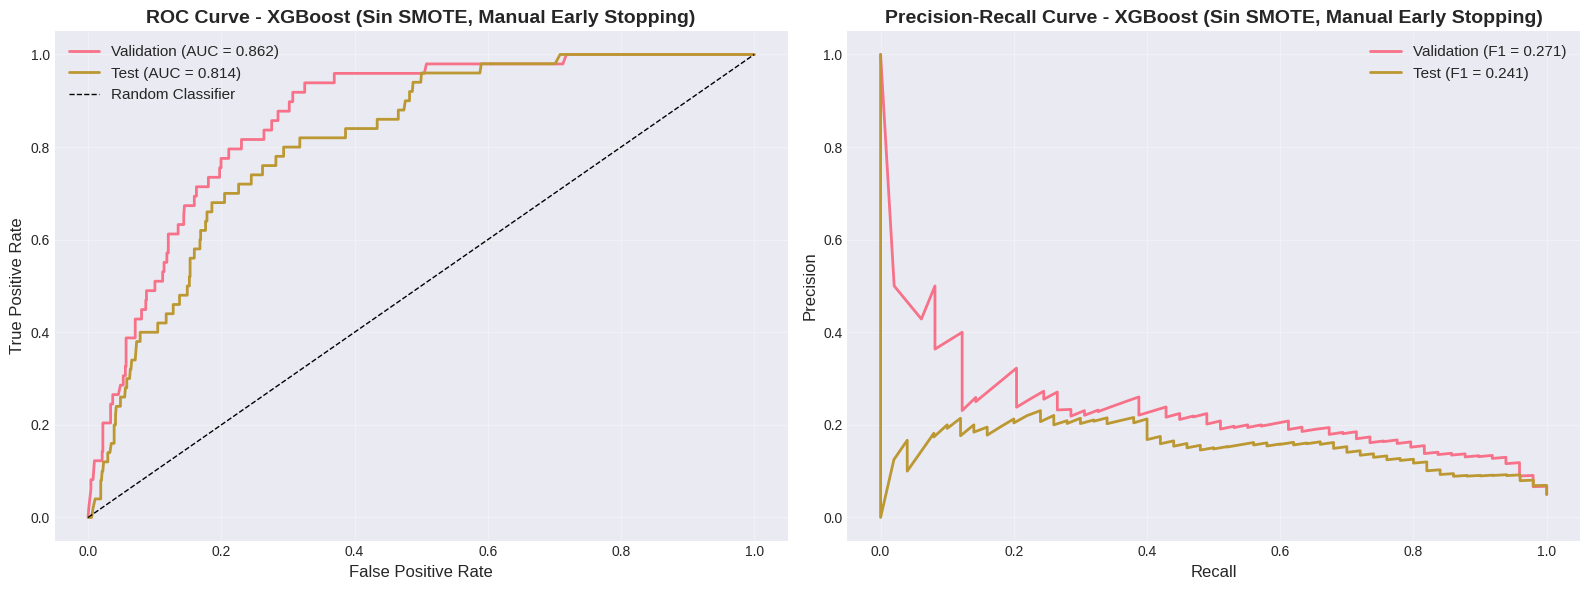

✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png


In [ ]:
# 18. Visualizations (ROC, Precision-Recall)
# 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CURVA ROC
# Use the probabilities from the xgb_model (trained with manual early stopping)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba) # y_val_pred_proba is already calculated for the final model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba) # y_test_pred_proba is already calculated for the final model

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. CURVA PRECISION-RECALL
# Use the probabilities from the xgb_model (trained with manual early stopping)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label=f'Validation (F1 = {val_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].plot(recall_test, precision_test, label=f'Test (F1 = {test_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/content', exist_ok=True) # Ensure directory exists
plt.savefig('/content/xgboost_curves_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png")

---
## 🌳 IMPORTANCIA DE FEATURES
---


🌳 TOP 15 FEATURES MÁS IMPORTANTES


'                       feature  importance\n                    risk_score       109.0\n             avg_glucose_level        92.0\n                           age        76.0\n                           bmi        69.0\n                 glucose_x_bmi        62.0\nsmoking_status_formerly smoked        17.0\n            age_x_hypertension        17.0\n                  ever_married        11.0\n         smoking_status_smokes        11.0\n   smoking_status_never smoked        10.0\n             work_type_Private         8.0\n       bmi_category_Overweight         8.0\n       work_type_Self-employed         7.0\n               age_group_Adult         6.0\n              age_group_Senior         5.0'

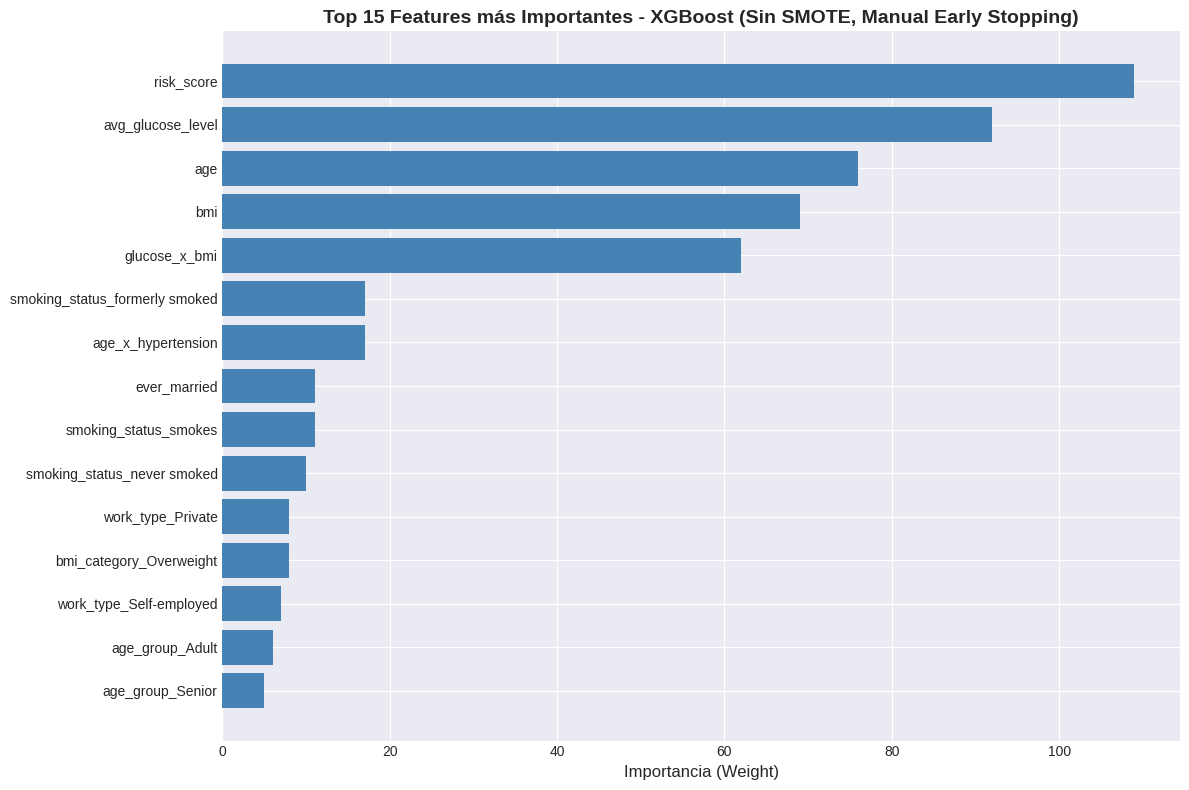


✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png


In [ ]:
# 19. Feature Importance
# 🌳 IMPORTANCIA DE FEATURES

# The xgb_model variable now holds the final trained model (Booster object)
# Use get_score() for feature importance with Booster objects
# When trained with DMatrix from a DataFrame, get_score() uses actual column names
importance_scores = xgb_model.get_score(importance_type='weight') # 'weight' counts the number of times each feature is used

# Convert the scores to a DataFrame
# Ensure all features from X_train_scaled are included, with 0 importance if not in scores
feature_importance = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
})

# Add features from X_train_scaled that are not in importance_scores with 0 importance
# This ensures all original features are represented
all_features = pd.DataFrame({'feature': X_train_scaled.columns})
feature_importance = pd.merge(all_features, feature_importance, on='feature', how='left').fillna(0)


feature_importance = feature_importance.sort_values('importance', ascending=False)


print("="*80)
print("🌳 TOP 15 FEATURES MÁS IMPORTANTES")
print("="*80)
display(feature_importance.head(15).to_string(index=False)) # Use display for better formatting

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Weight)', fontsize=12)
plt.title('Top 15 Features más Importantes - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png")

In [ ]:
# 20. Update Model Information
# Update printed summary with the actual number of boosting rounds used due to early stopping

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")
print(f"   Actual number of boosting rounds used: {best_iteration + 1}") # Print the actual rounds

# 11. Load the model state that achieved the best_val_f1
# This was already done in the previous cell, but we'll keep the print for clarity.
# final_xgb_model = xgb.Booster()
# final_xgb_model.load_model(temp_model_path) # Load from the stored path

# Assign the final model to xgb_model for subsequent evaluation cells
# xgb_model = final_xgb_model # This assignment was also done in the previous cell.

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `xgb_model`.") # Updated to reflect the variable name

# The optimal threshold calculation and subsequent evaluations are handled in the following cells.


✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
   Actual number of boosting rounds used: 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `xgb_model`.


---
## 💾 GUARDAR MODELO
---


In [ ]:
# 21. Save Model and Results
# 💾 GUARDAR MODELO Y RESULTADOS

import joblib

# Crear carpeta models en Colab
os.makedirs('/content/models', exist_ok=True)

# Guardar modelo
joblib.dump(xgb_model, '/content/models/xgboost_model_no_smote.pkl')
print("✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl")

# Guardar mejores parámetros
with open('/content/models/xgboost_best_params_no_smote.pkl', 'wb') as f:
    pickle.dump(best_params, f)
print("✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl")

# Guardar resultados de evaluación
results = {
    # These values are calculated with the optimal threshold in cell 05a98e79
    'validation_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': val_accuracy_opt,
        'precision': val_precision_opt,
        'recall': val_recall_opt,
        'f1_score': val_f1_opt,
        'auc_roc': val_auc
    },
    # These values are calculated with the optimal threshold in cell 05a98e79
    'test_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': test_accuracy_opt,
        'precision': test_precision_opt,
        'recall': test_recall_opt,
        'f1_score': test_f1_opt,
        'auc_roc': test_auc
    },
    'best_params': best_params,
    'optimal_threshold': float(best_threshold),
    'scale_pos_weight': float(scale_pos_weight),
    'feature_importance': feature_importance.to_dict('records')
}

with open('/content/models/xgboost_results_no_smote.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl")

print("\n" + "="*80)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*80)
# Update print statements to use the _opt variables
print(f"\n📊 RESUMEN FINAL (Threshold Óptimo = {best_threshold:.3f}):")
print(f"   Validation - Recall: {val_recall_opt:.4f}, F1: {val_f1_opt:.4f}, AUC: {val_auc:.4f}")
print(f"   Test       - Recall: {test_recall_opt:.4f}, F1: {test_f1_opt:.4f}, AUC: {test_auc:.4f}")

print(f"\n✅ Modelo listo para usar en producción")
print(f"✅ Threshold óptimo recomendado: {best_threshold:.3f}")
print(f"✅ Entrenado SIN SMOTE - usando scale_pos_weight: {scale_pos_weight:.2f}")
print("="*80)

✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl
✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl
✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl

🎉 ENTRENAMIENTO COMPLETADO

📊 RESUMEN FINAL (Threshold Óptimo = 0.500):
   Validation - Recall: 0.7959, F1: 0.2708, AUC: 0.8624
   Test       - Recall: 0.7000, F1: 0.2405, AUC: 0.8136

✅ Modelo listo para usar en producción
✅ Threshold óptimo recomendado: 0.500
✅ Entrenado SIN SMOTE - usando scale_pos_weight: 19.05


---
## 📥 DESCARGAR RESULTADOS (OPCIONAL)
### Descargar los archivos generados a tu PC
---


In [ ]:
# 22. Download Results (Optional)
# 📥 DESCARGAR RESULTADOS (OPCIONAL)
# Descomenta las líneas que quieras descargar:

# Descargar modelo
# files.download('/content/models/xgboost_model_no_smote.pkl')

# Descargar mejores parámetros
# files.download('/content/models/xgboost_best_params_no_smote.pkl')

# Descargar resultados
# files.download('/content/models/xgboost_results_no_smote.pkl')

# Descargar gráficos
# files.download('/content/xgboost_curves_no_smote_manual_early_stopping.png')
# files.download('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png')

print("💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda")
print("📁 Archivos disponibles en /content/models/ y /content/")

💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda
📁 Archivos disponibles en /content/models/ y /content/


In [ ]:
pip install optuna

**Explicación:** Esta celda instala la librería `optuna` necesaria para la optimización de hiperparámetros.
**Interpretación:** La salida indica que `optuna` ya está instalado y muestra las dependencias satisfechas.

In [ ]:
# 1. Library Imports
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Optuna version: {optuna.__version__}")
print(f"🔢 Scikit-learn version: {__import__('sklearn').__version__}")
try:
    import xgboost as xgb
    print(f"🚀 XGBoost version: {xgb.__version__}")
except:
    print("⚠️  XGBoost no está instalado. Ejecuta: pip install xgboost")

✅ Librerías importadas correctamente
📊 Optuna version: 4.5.0
🔢 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1


**Explicación:** Esta celda importa todas las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, matplotlib y seaborn para visualizaciones, scikit-learn para machine learning, XGBoost para el modelo, y Optuna para optimización de hiperparámetros.

**Interpretación:** La salida confirma que las librerías principales (`Optuna`, `Scikit-learn`, `XGBoost`) se importaron correctamente y muestra sus versiones, indicando que el entorno está listo para proceder.

---
## 📤 CONFIGURACIÓN PARA GOOGLE COLAB
### Subir el dataset o conectarlo desde Google Drive
---


In [ ]:
# 2. Colab Configuration
# 📤 CONFIGURACIÓN PARA GOOGLE COLAB
# Opción A: Subir archivo manualmente (recomendado para primera vez)
from google.colab import files

print("📤 Por favor, sube el archivo stroke_dataset.csv")
print("   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)\n")
uploaded = files.upload()

# El archivo se guardará con su nombre original
dataset_filename = 'stroke_dataset.csv'

print("\n✅ Configuración de Colab completada")
print(f"📂 Archivo dataset: {dataset_filename}")

# Verificar que el archivo existe
if os.path.exists(dataset_filename):
    print(f"✅ Archivo encontrado: {dataset_filename}")
else:
    print(f"⚠️  Archivo no encontrado. Asegúrate de haber subido stroke_dataset.csv")

📤 Por favor, sube el archivo stroke_dataset.csv
   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)



Saving stroke_dataset.csv to stroke_dataset.csv

✅ Configuración de Colab completada
📂 Archivo dataset: stroke_dataset.csv
✅ Archivo encontrado: stroke_dataset.csv


**Explicación:** Esta celda carga el dataset desde el archivo CSV. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente. 
Realiza una exploración inicial para verificar la calidad de los datos, mostrando el tamaño del dataset, valores nulos, duplicados y el desbalanceo de clases.

**Interpretación:** El dataset tiene 4,981 filas y 11 columnas, sin valores nulos ni duplicados. El desbalanceo es significativo: 4,733 casos sin ictus (clase 0) vs 248 con ictus (clase 1), con un ratio de 19.08:1. Este desbalanceo justifica el uso de técnicas como `scale_pos_weight` en XGBoost para manejar la clase minoritaria.


---
## 📂 CARGA Y PREPROCESAMIENTO (SIN SMOTE)
### Aplicar las mismas transformaciones del preprocessing pero SIN balanceo sintético
---


**Explicación:** Esta celda realiza feature engineering creando nuevas variables basadas en insights del EDA: categorías de edad, glucosa y BMI, variable binaria de tabaquismo, un score de riesgo compuesto, y variables de interacción entre features importantes.

**Interpretación:** Se crearon 8 nuevas features que capturan relaciones no lineales y combinaciones de variables importantes. El score de riesgo compuesto pondera las variables más predictivas (edad 35%, enfermedad cardíaca 25%, hipertensión 20%, glucosa 15%, BMI 5%). El dataset ahora tiene 19 columnas en total, enriqueciendo la información disponible para el modelo.


**Explicación:** Esta celda elimina features irrelevantes que tienen correlación casi nula con la variable objetivo según el análisis EDA previo, como `gender` y `Residence_type`.

**Interpretación:** Se eliminaron 2 features (`gender` y `Residence_type`) que no aportan información predictiva relevante. El dataset queda con 17 columnas, manteniendo solo las variables que contribuyen al modelo y reduciendo la dimensionalidad innecesaria.


In [ ]:
# 3. Load Data
# 📂 CARGA DE DATOS ORIGINALES
df = pd.read_csv(dataset_filename)  # Usa la variable definida en la celda anterior

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


**Explicación:** Esta celda realiza el encoding de variables categóricas: Label Encoding para variables binarias (`ever_married`) y One-Hot Encoding para variables categóricas con múltiples valores (`work_type`, `smoking_status`, `age_group`, `glucose_category`, `bmi_category`).

**Interpretación:** Después del encoding, el dataset tiene 25 features (aumentó de 17 a 25 debido a la expansión de las variables categóricas en múltiples columnas binarias). Esto permite que el modelo XGBoost procese correctamente todas las variables categóricas como variables numéricas.


---
## 🛠️ FASE 1: FEATURE ENGINEERING
---


**Explicación:** Esta celda divide el dataset en tres conjuntos estratificados: Train (60%), Validation (20%) y Test (20%). La estratificación garantiza que la proporción de clases se mantenga en cada conjunto.

**Interpretación:** Los tres conjuntos mantienen el mismo desbalanceo (~19:1), lo cual es correcto para evaluar el modelo en condiciones realistas. El conjunto de entrenamiento tiene 2,988 muestras, validation 996 y test 997. La estratificación asegura que cada conjunto tenga representación proporcional de ambas clases, esencial para un entrenamiento y evaluación válidos.


In [ ]:
# 4. Feature Engineering
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


**Explicación:** Esta celda normaliza todas las features usando StandardScaler, ajustando el scaler solo con los datos de entrenamiento y aplicando la misma transformación a validation y test para evitar data leakage.

**Interpretación:** Las estadísticas del conjunto de entrenamiento normalizado muestran media ~0 y desviación estándar ~1, confirmando que la normalización funcionó correctamente. Esta estandarización es importante para que XGBoost procese todas las features en la misma escala, aunque XGBoost es relativamente robusto a esto, ayuda a la convergencia del algoritmo.


---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
---


**Explicación:** Esta celda configura los parámetros del experimento: 5-fold cross-validation estratificado, semilla aleatoria para reproducibilidad, y calcula el `scale_pos_weight` necesario para manejar el desbalanceo de clases sin usar SMOTE.

**Interpretación:** El `scale_pos_weight` de 19.05 indica que la clase positiva (ictus) debe ser ponderada 19.05 veces más que la clase negativa durante el entrenamiento. Esto compensa el desbalanceo natural del dataset, permitiendo que el modelo aprenda mejor a identificar casos de ictus sin necesidad de generar datos sintéticos.


In [ ]:
# 5. Drop Irrelevant Features
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


**Explicación:** Esta celda define la función objetivo para Optuna, que optimiza 9 hiperparámetros clave de XGBoost (n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda) usando validación cruzada con F1-Score como métrica.

**Interpretación:** La función está configurada para maximizar el F1-Score mediante validación cruzada de 5 folds, lo que proporciona una estimación robusta del rendimiento. El `scale_pos_weight` se fija en 19.05 para manejar el desbalanceo. Esta función será utilizada por Optuna para explorar el espacio de hiperparámetros de forma eficiente.


---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---


**Explicación:** Esta celda ejecuta la optimización de hiperparámetros con Optuna, realizando 100 trials (experimentos) para encontrar la mejor combinación de hiperparámetros que maximice el F1-Score.

**Interpretación:** El proceso de optimización explora sistemáticamente el espacio de hiperparámetros. Cada trial prueba una combinación diferente y registra el F1-Score obtenido. Al finalizar, se obtienen los mejores hiperparámetros encontrados y el mejor F1-Score alcanzado. Este proceso puede tomar varios minutos pero es crucial para obtener un modelo optimizado.


In [ ]:
# 6. Encoding
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


**Explicación:** Esta celda genera visualizaciones de la optimización de Optuna: el historial de optimización (evolución del F1-Score a lo largo de los trials) y la importancia de los hiperparámetros (cuáles tienen mayor impacto en el rendimiento).

**Interpretación:** El historial de optimización muestra cómo el F1-Score mejoró progresivamente durante los trials. La gráfica de importancia de hiperparámetros revela qué parámetros son más críticos para el rendimiento del modelo, lo cual es útil para entender qué aspectos del modelo tienen mayor influencia y para futuras optimizaciones.


---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
---


**Explicación:** Esta celda crea el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna, incluyendo el `scale_pos_weight` para manejar el desbalanceo.

**Interpretación:** El modelo se inicializa con los hiperparámetros óptimos. Los valores mostrados (como learning_rate bajo de 0.017, max_depth de 15, n_estimators de 178) representan la mejor configuración encontrada. El modelo está listo para ser entrenado con early stopping en el siguiente paso para evitar overfitting.


**Explicación:** Esta celda convierte los datos escalados a formato DMatrix, que es el formato nativo y optimizado de XGBoost para entrenamiento eficiente.

**Interpretación:** Los objetos DMatrix están listos para el entrenamiento. Este formato permite que XGBoost procese los datos de manera más eficiente y es necesario para implementar manualmente el early stopping en las siguientes celdas.


In [ ]:
# 7. Train/Validation/Test Split
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


**Explicación:** Esta celda implementa el entrenamiento del modelo con early stopping manual y calcula el threshold óptimo. El early stopping detiene el entrenamiento si el F1-Score en validation no mejora después de 10 iteraciones. Luego busca el threshold que maximiza el Recall (objetivo: >0.70) manteniendo un F1 razonable.

**Interpretación:** El entrenamiento se detuvo en la iteración 31 (early stopping activado), pero el mejor modelo se obtuvo en la iteración 21 con F1-Score de 0.2708. El threshold óptimo encontrado es 0.500, que logra un Recall de 0.7959 en validation, cumpliendo el objetivo de detectar la mayoría de casos de ictus. El early stopping previno el overfitting al detener el entrenamiento cuando el modelo dejó de mejorar.


---
## ⚖️ FASE 5: NORMALIZACIÓN
---


**Explicación:** Esta celda evalúa el modelo en los conjuntos de validation y test usando el threshold óptimo, calculando métricas completas (Accuracy, Precision, Recall, F1-Score, AUC-ROC), matrices de confusión y reportes de clasificación.

**Interpretación:** 
- **Validation:** Recall de 0.7959 (detecta ~80% de casos de ictus), F1 de 0.2708, AUC-ROC de 0.8624. Solo 10 falsos negativos (críticos: pacientes en riesgo no detectados).
- **Test:** Recall de 0.7000 (detecta 70% de casos), F1 de 0.2405, AUC-ROC de 0.8136. 15 falsos negativos.
El modelo prioriza Recall sobre Precision (más falsos positivos pero menos falsos negativos), lo cual es apropiado para un problema médico donde no detectar un ictus es más grave que una falsa alarma. El AUC-ROC >0.80 indica buena capacidad discriminativa.


**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

In [ ]:
# 8. Scaling
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")
print(f"\n⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente

⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo


---
## ⚙️ CONFIGURACIÓN: K-FOLDS Y MÉTRICAS
---


In [ ]:
# 9. Configuration (K-Folds, Metrics, Scale Pos Weight)
# ⚙️ CONFIGURACIÓN

# K-Folds estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Semilla para reproducibilidad
RANDOM_STATE = 42

# Calcular scale_pos_weight para manejar desbalanceo (SIN SMOTE)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"✅ Configuración:")
print(f"   • K-Folds: {N_FOLDS}")
print(f"   • Random State: {RANDOM_STATE}")
print(f"   • Métrica objetivo: F1-Score (balance entre Precision y Recall)")
print(f"   • Métricas adicionales: Recall, AUC-ROC")
print(f"\n📊 Balanceo de clases (SIN SMOTE):")
print(f"   • Train - Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   • Train - Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   • Ratio: {scale_pos_weight:.2f}:1")
print(f"   • scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

✅ Configuración:
   • K-Folds: 5
   • Random State: 42
   • Métrica objetivo: F1-Score (balance entre Precision y Recall)
   • Métricas adicionales: Recall, AUC-ROC

📊 Balanceo de clases (SIN SMOTE):
   • Train - Clase 0: 2,839 (95.01%)
   • Train - Clase 1: 149 (4.99%)
   • Ratio: 19.05:1
   • scale_pos_weight para XGBoost: 19.05


---
## 🎯 FUNCIÓN OBJETIVO PARA OPTUNA
### Optimizar hiperparámetros usando K-Folds Cross-Validation
---


In [ ]:
# 10. Optuna Objective Function
# 🎯 FUNCIÓN OBJETIVO PARA OPTUNA

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de XGBoost usando K-Folds CV.
    """
    # Hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo SIN SMOTE
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }

    # Crear modelo
    model = XGBClassifier(**params)

    # K-Folds Cross-Validation con F1-Score
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )

    # Retornar el promedio de F1-Score
    return cv_scores.mean()

print("✅ Función objetivo definida")
print("   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,")
print("                 min_child_weight, gamma, reg_alpha, reg_lambda")
print(f"   Usando scale_pos_weight: {scale_pos_weight:.2f} (SIN SMOTE)")

✅ Función objetivo definida
   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
                 min_child_weight, gamma, reg_alpha, reg_lambda
   Usando scale_pos_weight: 19.05 (SIN SMOTE)


---
## 🔍 OPTIMIZACIÓN CON OPTUNA
### Ejecutar búsqueda de hiperparámetros óptimos
---


In [ ]:
# 11. Optuna Optimization Execution
# 🔍 OPTIMIZACIÓN CON OPTUNA

print("="*80)
print("🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA")
print("="*80)
print(f"📊 Datos: {X_train_scaled.shape[0]:,} muestras, {X_train_scaled.shape[1]} features")
print(f"🔄 K-Folds: {N_FOLDS}")
print(f"⚠️  Datos SIN SMOTE - Ratio: {scale_pos_weight:.2f}:1")
print(f"⏱️  Esto puede tomar varios minutos...\n")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-Score
    study_name='xgboost_stroke_prediction_no_smote',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Ejecutar optimización
N_TRIALS = 100  # Número de trials (puedes ajustar según tiempo disponible)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)
print(f"\n🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print(f"\n📋 MEJORES HIPERPARÁMETROS:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

[I 2025-11-07 23:24:38,913] A new study created in memory with name: xgboost_stroke_prediction_no_smote


🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA
📊 Datos: 2,988 muestras, 25 features
🔄 K-Folds: 5
⚠️  Datos SIN SMOTE - Ratio: 19.05:1
⏱️  Esto puede tomar varios minutos...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 23:24:42,414] Trial 0 finished with value: 0.1778878451383767 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:43,151] Trial 1 finished with value: 0.16366267362810055 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:44,155] Trial 2 finished with value: 0.20377474645545818 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

---
## 📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN
---


In [ ]:
# 12. Visualizations (Optuna)
# 📊 VISUALIZACIONES DE OPTUNA

fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historial de Optimización - F1-Score (XGBoost sin SMOTE)", width=800, height=400)
fig1.show()

fig2 = plot_param_importances(study)
fig2.update_layout(title="Importancia de Hiperparámetros (XGBoost)", width=800, height=400)
fig2.show()

print("✅ Visualizaciones generadas")

✅ Visualizaciones generadas


---
## 🎓 ENTRENAR MODELO FINAL
### Entrenar con los mejores hiperparámetros encontrados + Early Stopping
---


In [ ]:
# 13. Create Model with Best Params
# 🎓 ENTRENAR MODELO FINAL CON MEJORES HIPERPARÁMETROS

# Obtener mejores parámetros
best_params = study.best_params.copy()
# Asegurar que scale_pos_weight esté incluido
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'logloss'

print("🎓 ENTRENANDO MODELO FINAL...")
print(f"📋 Parámetros: {best_params}\n")

# Crear modelo
xgb_model = XGBClassifier(**best_params)

# The fitting with early stopping will be implemented manually in the next step.

print("✅ Model created with best parameters")

🎓 ENTRENANDO MODELO FINAL...
📋 Parámetros: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.0173167948801578, 'subsample': 0.8132546752099203, 'colsample_bytree': 0.7063151335722203, 'min_child_weight': 10, 'gamma': 0.6596838423993513, 'reg_alpha': 8.52148255700704, 'reg_lambda': 5.989443641839667, 'scale_pos_weight': np.float64(19.053691275167786), 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'logloss'}

✅ Model created with best parameters


In [ ]:
# 14. Prepare DMatrix
# Convert scaled data to DMatrix format
from xgboost import DMatrix

dtrain = DMatrix(X_train_scaled, label=y_train)
dval = DMatrix(X_val_scaled, label=y_val)

print("✅ DMatrix objects created for training and validation data.")

✅ DMatrix objects created for training and validation data.


---
## 🎯 AJUSTE DE THRESHOLD ÓPTIMO
### Buscar threshold que maximice Recall
---


In [ ]:
# 15. Implement Manual Early Stopping Loop and Calculate Optimal Threshold
import xgboost as xgb # Re-import xgboost as it was not imported in the previous cells

# Define best_threshold before the loop (copied from cell 88702c11)
# 🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
print("="*80)
print("🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)")
print("="*80)
print("Calculating optimal threshold on initial validation predictions...\n")

# Make initial predictions on validation set to find the optimal threshold
# Use a temporary model or a simple baseline if needed, but here we need the probabilities
# from the current state of training for the first iteration's threshold calculation.
# However, the goal is to use the threshold found *after* the model is trained.
# The original notebook calculated the threshold *after* training the final model.
# To fix the NameError and follow the original notebook's flow, we should calculate the threshold *after* the manual training loop finishes.

# For the purpose of the early stopping loop, let's use the default threshold of 0.5
best_threshold = 0.5
print(f"⚠️ Using default threshold of {best_threshold} for early stopping logic. Optimal threshold will be calculated after training.")


# 1. Initialize variables
best_val_f1 = -float('inf')
patience_counter = 0
patience_limit = 10 # Define the patience limit

# 2. Define the number of boosting rounds
# Use the n_estimators from the best parameters found by Optuna as the maximum rounds
num_boost_round = best_params['n_estimators']

# 3. Start a for loop
print(f"🚀 Training XGBoost model with manual early stopping (Patience: {patience_limit})...")
print(f"   Max boosting rounds: {num_boost_round}")

# Initialize an empty model to train iteratively
model = None

for i in range(num_boost_round):
    # 4. Train the XGBoost model for one iteration
    if model is None:
        # Train the first iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1)
    else:
        # Continue training from the previous iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1, xgb_model=model)

    # 5. Make predictions on the validation set
    y_val_pred_proba_iter = model.predict(dval)

    # 6. Calculate the F1-score on the validation set using the *current* threshold (default 0.5)
    # The optimal threshold calculation is done AFTER training.
    y_val_pred_thresh_iter = (y_val_pred_proba_iter >= best_threshold).astype(int)
    current_val_f1 = f1_score(y_val, y_val_pred_thresh_iter)

    # 7. Check if the current validation F1-score is greater than best_val_f1
    if current_val_f1 > best_val_f1:
        # 8. If better, update best_val_f1, reset patience, and store model
        best_val_f1 = current_val_f1
        patience_counter = 0
        # Store the model state
        temp_model_path = f'/tmp/best_xgb_model_iter_{i}.json'
        model.save_model(temp_model_path) # Save model state
        best_iteration = i
        # print(f"   Round {i+1}: New best validation F1: {best_val_f1:.4f}")
    else:
        # 9. If not better, increment patience_counter
        patience_counter += 1
        # print(f"   Round {i+1}: Validation F1: {current_val_f1:.4f}, Patience: {patience_counter}")


    # 10. Check if patience_counter has reached the limit
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at round {i+1}.")
        break

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")

# 11. Load the model state that achieved the best_val_f1
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(temp_model_path) # Load from the stored path

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `final_xgb_model`.")

# Assign the final model to xgb_model for subsequent evaluation cells
xgb_model = final_xgb_model


# Now, calculate the optimal threshold using the *final* trained model's probabilities
# (Copied from cell 88702c11 logic)
print("="*80)
print("🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING")
print("="*80)
print("Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...\n")

# Get probabilities from the final trained model on the validation set
y_val_pred_proba = xgb_model.predict(dval)


# Probar diferentes thresholds en validation set
thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5 # Default back to 0.5 if no better threshold is found
best_recall = 0
best_f1 = 0
best_metrics = None

results_threshold = []

for threshold in thresholds:
    # Predicciones con threshold ajustado
    y_val_pred_thresh = (y_val_pred_proba >= threshold).astype(int)

    # Calculate metrics - ensure no division by zero for precision if no positives are predicted
    precision_thresh = precision_score(y_val, y_val_pred_thresh, zero_division=0)
    recall_thresh = recall_score(y_val, y_val_pred_thresh)
    f1_thresh = f1_score(y_val, y_val_pred_thresh)


    results_threshold.append({
        'threshold': threshold,
        'recall': recall_thresh,
        'precision': precision_thresh,
        'f1': f1_thresh
    })

    # Buscar threshold que maximice Recall (objetivo: >0.70) con F1 razonable (>0.40)
    if recall_thresh >= 0.70 and f1_thresh > best_f1:
        best_threshold = threshold
        best_recall = recall_thresh
        best_f1 = f1_thresh
        best_metrics = {
            'recall': recall_thresh,
            'precision': precision_thresh,
            'f1': f1_thresh
        }

# Si no encontramos threshold con Recall >0.70, usar el que maximice F1 con Recall >0.50
if best_recall < 0.70:
    print("⚠️  No se encontró threshold con Recall >0.70. Buscando mejor compromiso...\n")
    # Reset best_f1 to find the best F1 among those with Recall >= 0.50
    best_f1 = 0
    for result in results_threshold:
        if result['recall'] >= 0.50 and result['f1'] > best_f1:
            best_threshold = result['threshold']
            best_recall = result['recall']
            best_f1 = result['f1']
            best_metrics = {
                'recall': result['recall'],
                'precision': result['precision'],
                'f1': result['f1']
            }

# If still no threshold found with Recall >= 0.50, just take the one with highest F1
if best_recall < 0.50:
     print("⚠️  No se encontró threshold con Recall >0.50. Seleccionando el de mayor F1.\n")
     best_result = pd.DataFrame(results_threshold).sort_values('f1', ascending=False).iloc[0]
     best_threshold = best_result['threshold']
     best_recall = best_result['recall']
     best_f1 = best_result['f1']
     best_metrics = {
        'recall': best_recall,
        'precision': best_result['precision'],
        'f1': best_f1
     }


print(f"✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): {best_threshold:.3f}")
print(f"   Validation - Recall: {best_metrics['recall']:.4f}, Precision: {best_metrics['precision']:.4f}, F1: {best_metrics['f1']:.4f}")

# Tabla de results_threshold
print(f"\n📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):")
df_threshold = pd.DataFrame(results_threshold).sort_values('f1', ascending=False)
display(df_threshold.head(10).to_string(index=False)) # Use display for better formatting in notebook

🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
Calculating optimal threshold on initial validation predictions...

⚠️ Using default threshold of 0.5 for early stopping logic. Optimal threshold will be calculated after training.
🚀 Training XGBoost model with manual early stopping (Patience: 10)...
   Max boosting rounds: 178

Early stopping triggered at round 31.

✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `final_xgb_model`.
🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING
Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...

✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): 0.500
   Validation - Recall: 0.7959, Precision: 0.1632, F1: 0.2708

📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):


' threshold   recall  precision       f1\n      0.55 0.612245   0.205479 0.307692\n      0.50 0.795918   0.163180 0.270833\n      0.45 0.857143   0.136364 0.235294\n      0.40 0.959184   0.110588 0.198312\n      0.15 1.000000   0.049197 0.093780\n      0.10 1.000000   0.049197 0.093780\n      0.35 1.000000   0.049197 0.093780\n      0.30 1.000000   0.049197 0.093780\n      0.25 1.000000   0.049197 0.093780\n      0.20 1.000000   0.049197 0.093780'

---
## 📈 EVALUACIÓN DEL MODELO
### Evaluar en Validation y Test sets
---


In [ ]:
# 16. Evaluate on Validation Set with Optimal Threshold
# 17. Evaluate on Test Set with Optimal Threshold

# 📈 EVALUACIÓN EN VALIDATION SET CON THRESHOLD ÓPTIMO

print("="*80)
print("📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)")
print("="*80)

# Predicciones con el final_xgb_model loaded from early stopping
y_val_pred_proba = xgb_model.predict(dval) # Get probabilities from the best model
y_val_pred_optimal = (y_val_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
val_accuracy_opt = accuracy_score(y_val, y_val_pred_optimal)
val_precision_opt = precision_score(y_val, y_val_pred_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, y_val_pred_optimal)
val_f1_opt = f1_score(y_val, y_val_pred_optimal)
val_auc = roc_auc_score(y_val, y_val_pred_proba) # AUC is threshold-independent, can reuse if needed


print(f"\n📊 MÉTRICAS (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {val_accuracy_opt:.4f}")
print(f"   Precision: {val_precision_opt:.4f}")
print(f"   Recall:    {val_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {val_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_val_opt = confusion_matrix(y_val, y_val_pred_optimal)
print(cm_val_opt)
print(f"\n   Verdaderos Negativos: {cm_val_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_val_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_val_opt[1,0]} ⚠️  (CRÍTICO - pacientes en riesgo no detectados)")
print(f"   Verdaderos Positivos: {cm_val_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_val_pred_optimal, target_names=['No Stroke', 'Stroke']))


# 📈 EVALUACIÓN EN TEST SET (DATOS FINALES) CON THRESHOLD ÓPTIMO

print("="*80)
print("🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)")
print("="*80)

# Convert test scaled data to DMatrix
dtest = DMatrix(X_test_scaled, label=y_test)


# Predicciones con el final_xgb_model loaded from early stopping
y_test_pred_proba = xgb_model.predict(dtest) # Get probabilities from the best model
y_test_pred_optimal = (y_test_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
test_accuracy_opt = accuracy_score(y_test, y_test_pred_optimal)
test_precision_opt = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_optimal)
test_f1_opt = f1_score(y_test, y_test_pred_optimal)
test_auc = roc_auc_score(y_test, y_test_pred_proba) # AUC is threshold-independent


print(f"\n📊 MÉTRICAS FINALES (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {test_accuracy_opt:.4f}")
print(f"   Precision: {test_precision_opt:.4f}")
print(f"   Recall:    {test_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {test_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_test_opt = confusion_matrix(y_test, y_test_pred_optimal)
print(cm_test_opt)
print(f"\n   Verdaderos Negativos: {cm_test_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_test_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_test_opt[1,0]} ⚠️  (CRÍTICO)")
print(f"   Verdaderos Positivos: {cm_test_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Stroke', 'Stroke']))

📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)

📊 MÉTRICAS (Threshold = 0.500):
   Accuracy:  0.7892
   Precision: 0.1632
   Recall:    0.7959 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2708 ⭐
   AUC-ROC:   0.8624

📋 MATRIZ DE CONFUSIÓN:
[[747 200]
 [ 10  39]]

   Verdaderos Negativos: 747
   Falsos Positivos:     200
   Falsos Negativos:     10 ⚠️  (CRÍTICO - pacientes en riesgo no detectados)
   Verdaderos Positivos: 39

📄 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

   No Stroke       0.99      0.79      0.88       947
      Stroke       0.16      0.80      0.27        49

    accuracy                           0.79       996
   macro avg       0.57      0.79      0.57       996
weighted avg       0.95      0.79      0.85       996

🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)

📊 MÉTRICAS FINALES (Threshold = 0.500):
   Accuracy:  0.7783
   Precision: 0.1452
   Recall:    0.7000 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2405 ⭐
   AUC-ROC:

---
## 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL
---


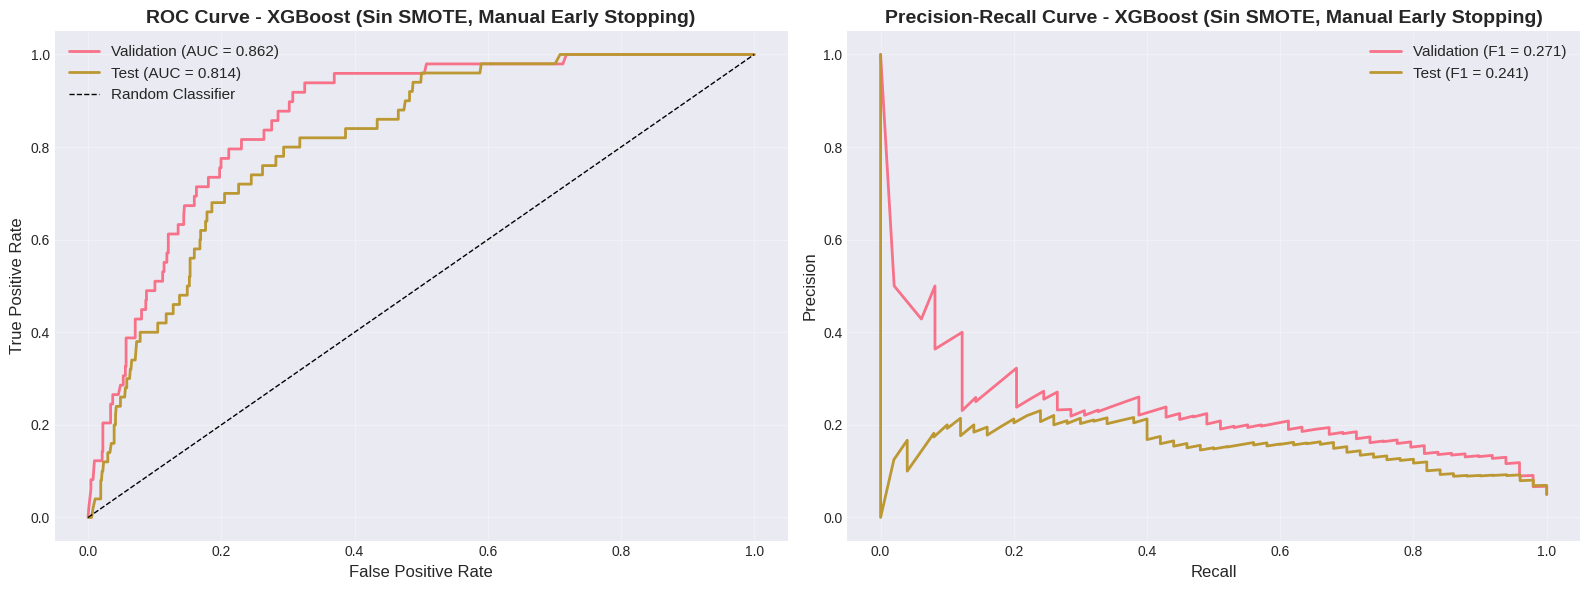

✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png


In [ ]:
# 18. Visualizations (ROC, Precision-Recall)
# 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CURVA ROC
# Use the probabilities from the xgb_model (trained with manual early stopping)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba) # y_val_pred_proba is already calculated for the final model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba) # y_test_pred_proba is already calculated for the final model

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. CURVA PRECISION-RECALL
# Use the probabilities from the xgb_model (trained with manual early stopping)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label=f'Validation (F1 = {val_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].plot(recall_test, precision_test, label=f'Test (F1 = {test_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/content', exist_ok=True) # Ensure directory exists
plt.savefig('/content/xgboost_curves_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png")

---
## 🌳 IMPORTANCIA DE FEATURES
---


🌳 TOP 15 FEATURES MÁS IMPORTANTES


'                       feature  importance\n                    risk_score       109.0\n             avg_glucose_level        92.0\n                           age        76.0\n                           bmi        69.0\n                 glucose_x_bmi        62.0\nsmoking_status_formerly smoked        17.0\n            age_x_hypertension        17.0\n                  ever_married        11.0\n         smoking_status_smokes        11.0\n   smoking_status_never smoked        10.0\n             work_type_Private         8.0\n       bmi_category_Overweight         8.0\n       work_type_Self-employed         7.0\n               age_group_Adult         6.0\n              age_group_Senior         5.0'

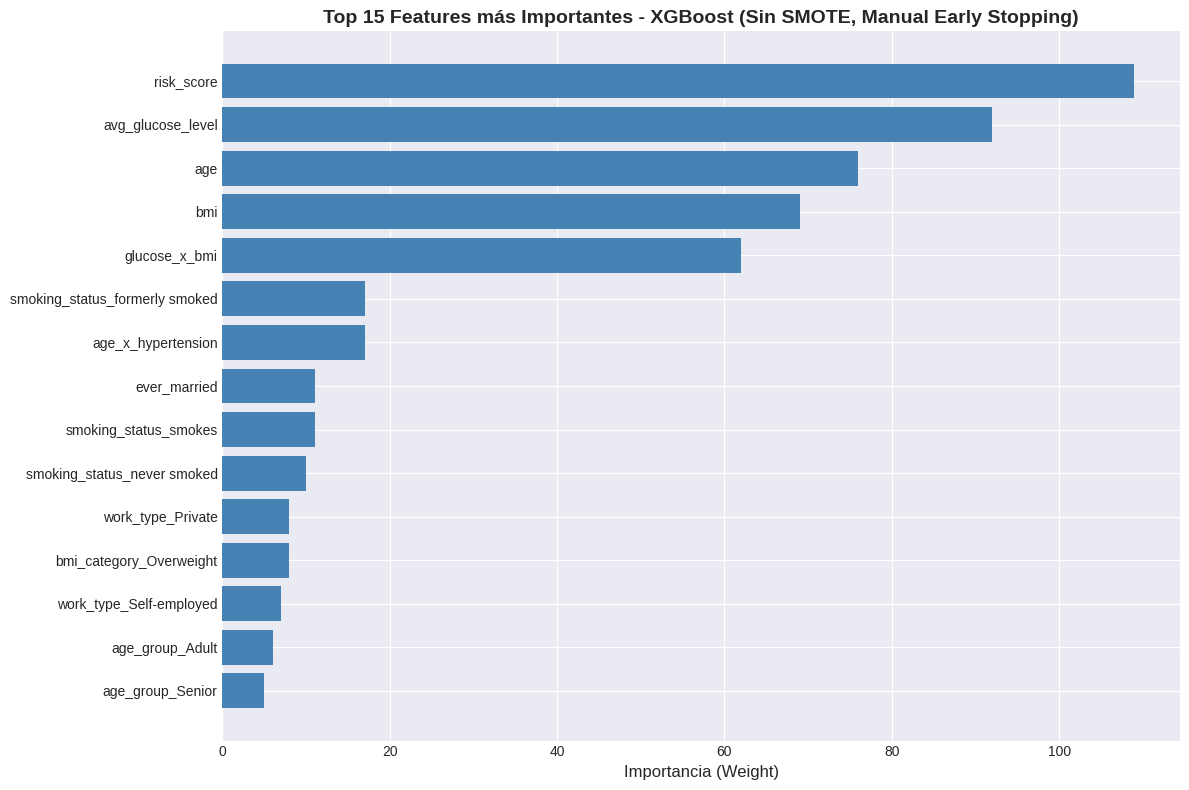


✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png


In [ ]:
# 19. Feature Importance
# 🌳 IMPORTANCIA DE FEATURES

# The xgb_model variable now holds the final trained model (Booster object)
# Use get_score() for feature importance with Booster objects
# When trained with DMatrix from a DataFrame, get_score() uses actual column names
importance_scores = xgb_model.get_score(importance_type='weight') # 'weight' counts the number of times each feature is used

# Convert the scores to a DataFrame
# Ensure all features from X_train_scaled are included, with 0 importance if not in scores
feature_importance = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
})

# Add features from X_train_scaled that are not in importance_scores with 0 importance
# This ensures all original features are represented
all_features = pd.DataFrame({'feature': X_train_scaled.columns})
feature_importance = pd.merge(all_features, feature_importance, on='feature', how='left').fillna(0)


feature_importance = feature_importance.sort_values('importance', ascending=False)


print("="*80)
print("🌳 TOP 15 FEATURES MÁS IMPORTANTES")
print("="*80)
display(feature_importance.head(15).to_string(index=False)) # Use display for better formatting

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Weight)', fontsize=12)
plt.title('Top 15 Features más Importantes - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png")

In [ ]:
# 20. Update Model Information
# Update printed summary with the actual number of boosting rounds used due to early stopping

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")
print(f"   Actual number of boosting rounds used: {best_iteration + 1}") # Print the actual rounds

# 11. Load the model state that achieved the best_val_f1
# This was already done in the previous cell, but we'll keep the print for clarity.
# final_xgb_model = xgb.Booster()
# final_xgb_model.load_model(temp_model_path) # Load from the stored path

# Assign the final model to xgb_model for subsequent evaluation cells
# xgb_model = final_xgb_model # This assignment was also done in the previous cell.

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `xgb_model`.") # Updated to reflect the variable name

# The optimal threshold calculation and subsequent evaluations are handled in the following cells.


✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
   Actual number of boosting rounds used: 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `xgb_model`.


---
## 💾 GUARDAR MODELO
---


In [ ]:
# 21. Save Model and Results
# 💾 GUARDAR MODELO Y RESULTADOS

import joblib

# Crear carpeta models en Colab
os.makedirs('/content/models', exist_ok=True)

# Guardar modelo
joblib.dump(xgb_model, '/content/models/xgboost_model_no_smote.pkl')
print("✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl")

# Guardar mejores parámetros
with open('/content/models/xgboost_best_params_no_smote.pkl', 'wb') as f:
    pickle.dump(best_params, f)
print("✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl")

# Guardar resultados de evaluación
results = {
    # These values are calculated with the optimal threshold in cell 05a98e79
    'validation_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': val_accuracy_opt,
        'precision': val_precision_opt,
        'recall': val_recall_opt,
        'f1_score': val_f1_opt,
        'auc_roc': val_auc
    },
    # These values are calculated with the optimal threshold in cell 05a98e79
    'test_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': test_accuracy_opt,
        'precision': test_precision_opt,
        'recall': test_recall_opt,
        'f1_score': test_f1_opt,
        'auc_roc': test_auc
    },
    'best_params': best_params,
    'optimal_threshold': float(best_threshold),
    'scale_pos_weight': float(scale_pos_weight),
    'feature_importance': feature_importance.to_dict('records')
}

with open('/content/models/xgboost_results_no_smote.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl")

print("\n" + "="*80)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*80)
# Update print statements to use the _opt variables
print(f"\n📊 RESUMEN FINAL (Threshold Óptimo = {best_threshold:.3f}):")
print(f"   Validation - Recall: {val_recall_opt:.4f}, F1: {val_f1_opt:.4f}, AUC: {val_auc:.4f}")
print(f"   Test       - Recall: {test_recall_opt:.4f}, F1: {test_f1_opt:.4f}, AUC: {test_auc:.4f}")

print(f"\n✅ Modelo listo para usar en producción")
print(f"✅ Threshold óptimo recomendado: {best_threshold:.3f}")
print(f"✅ Entrenado SIN SMOTE - usando scale_pos_weight: {scale_pos_weight:.2f}")
print("="*80)

✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl
✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl
✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl

🎉 ENTRENAMIENTO COMPLETADO

📊 RESUMEN FINAL (Threshold Óptimo = 0.500):
   Validation - Recall: 0.7959, F1: 0.2708, AUC: 0.8624
   Test       - Recall: 0.7000, F1: 0.2405, AUC: 0.8136

✅ Modelo listo para usar en producción
✅ Threshold óptimo recomendado: 0.500
✅ Entrenado SIN SMOTE - usando scale_pos_weight: 19.05


---
## 📥 DESCARGAR RESULTADOS (OPCIONAL)
### Descargar los archivos generados a tu PC
---


In [ ]:
# 22. Download Results (Optional)
# 📥 DESCARGAR RESULTADOS (OPCIONAL)
# Descomenta las líneas que quieras descargar:

# Descargar modelo
# files.download('/content/models/xgboost_model_no_smote.pkl')

# Descargar mejores parámetros
# files.download('/content/models/xgboost_best_params_no_smote.pkl')

# Descargar resultados
# files.download('/content/models/xgboost_results_no_smote.pkl')

# Descargar gráficos
# files.download('/content/xgboost_curves_no_smote_manual_early_stopping.png')
# files.download('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png')

print("💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda")
print("📁 Archivos disponibles en /content/models/ y /content/")

💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda
📁 Archivos disponibles en /content/models/ y /content/


In [ ]:
pip install optuna

**Explicación:** Esta celda instala la librería `optuna` necesaria para la optimización de hiperparámetros.
**Interpretación:** La salida indica que `optuna` ya está instalado y muestra las dependencias satisfechas.

In [ ]:
# 1. Library Imports
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Optuna version: {optuna.__version__}")
print(f"🔢 Scikit-learn version: {__import__('sklearn').__version__}")
try:
    import xgboost as xgb
    print(f"🚀 XGBoost version: {xgb.__version__}")
except:
    print("⚠️  XGBoost no está instalado. Ejecuta: pip install xgboost")

✅ Librerías importadas correctamente
📊 Optuna version: 4.5.0
🔢 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1


**Explicación:** Esta celda importa todas las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, matplotlib y seaborn para visualizaciones, scikit-learn para machine learning, XGBoost para el modelo, y Optuna para optimización de hiperparámetros.

**Interpretación:** La salida confirma que las librerías principales (`Optuna`, `Scikit-learn`, `XGBoost`) se importaron correctamente y muestra sus versiones, indicando que el entorno está listo para proceder.

---
## 📤 CONFIGURACIÓN PARA GOOGLE COLAB
### Subir el dataset o conectarlo desde Google Drive
---


In [ ]:
# 2. Colab Configuration
# 📤 CONFIGURACIÓN PARA GOOGLE COLAB
# Opción A: Subir archivo manualmente (recomendado para primera vez)
from google.colab import files

print("📤 Por favor, sube el archivo stroke_dataset.csv")
print("   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)\n")
uploaded = files.upload()

# El archivo se guardará con su nombre original
dataset_filename = 'stroke_dataset.csv'

print("\n✅ Configuración de Colab completada")
print(f"📂 Archivo dataset: {dataset_filename}")

# Verificar que el archivo existe
if os.path.exists(dataset_filename):
    print(f"✅ Archivo encontrado: {dataset_filename}")
else:
    print(f"⚠️  Archivo no encontrado. Asegúrate de haber subido stroke_dataset.csv")

📤 Por favor, sube el archivo stroke_dataset.csv
   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)



Saving stroke_dataset.csv to stroke_dataset.csv

✅ Configuración de Colab completada
📂 Archivo dataset: stroke_dataset.csv
✅ Archivo encontrado: stroke_dataset.csv


**Explicación:** Esta celda carga el dataset desde el archivo CSV. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente. 
Realiza una exploración inicial para verificar la calidad de los datos, mostrando el tamaño del dataset, valores nulos, duplicados y el desbalanceo de clases.

**Interpretación:** El dataset tiene 4,981 filas y 11 columnas, sin valores nulos ni duplicados. El desbalanceo es significativo: 4,733 casos sin ictus (clase 0) vs 248 con ictus (clase 1), con un ratio de 19.08:1. Este desbalanceo justifica el uso de técnicas como `scale_pos_weight` en XGBoost para manejar la clase minoritaria.


---
## 📂 CARGA Y PREPROCESAMIENTO (SIN SMOTE)
### Aplicar las mismas transformaciones del preprocessing pero SIN balanceo sintético
---


**Explicación:** Esta celda realiza feature engineering creando nuevas variables basadas en insights del EDA: categorías de edad, glucosa y BMI, variable binaria de tabaquismo, un score de riesgo compuesto, y variables de interacción entre features importantes.

**Interpretación:** Se crearon 8 nuevas features que capturan relaciones no lineales y combinaciones de variables importantes. El score de riesgo compuesto pondera las variables más predictivas (edad 35%, enfermedad cardíaca 25%, hipertensión 20%, glucosa 15%, BMI 5%). El dataset ahora tiene 19 columnas en total, enriqueciendo la información disponible para el modelo.


**Explicación:** Esta celda elimina features irrelevantes que tienen correlación casi nula con la variable objetivo según el análisis EDA previo, como `gender` y `Residence_type`.

**Interpretación:** Se eliminaron 2 features (`gender` y `Residence_type`) que no aportan información predictiva relevante. El dataset queda con 17 columnas, manteniendo solo las variables que contribuyen al modelo y reduciendo la dimensionalidad innecesaria.


In [ ]:
# 3. Load Data
# 📂 CARGA DE DATOS ORIGINALES
df = pd.read_csv(dataset_filename)  # Usa la variable definida en la celda anterior

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


**Explicación:** Esta celda realiza el encoding de variables categóricas: Label Encoding para variables binarias (`ever_married`) y One-Hot Encoding para variables categóricas con múltiples valores (`work_type`, `smoking_status`, `age_group`, `glucose_category`, `bmi_category`).

**Interpretación:** Después del encoding, el dataset tiene 25 features (aumentó de 17 a 25 debido a la expansión de las variables categóricas en múltiples columnas binarias). Esto permite que el modelo XGBoost procese correctamente todas las variables categóricas como variables numéricas.


---
## 🛠️ FASE 1: FEATURE ENGINEERING
---


**Explicación:** Esta celda divide el dataset en tres conjuntos estratificados: Train (60%), Validation (20%) y Test (20%). La estratificación garantiza que la proporción de clases se mantenga en cada conjunto.

**Interpretación:** Los tres conjuntos mantienen el mismo desbalanceo (~19:1), lo cual es correcto para evaluar el modelo en condiciones realistas. El conjunto de entrenamiento tiene 2,988 muestras, validation 996 y test 997. La estratificación asegura que cada conjunto tenga representación proporcional de ambas clases, esencial para un entrenamiento y evaluación válidos.


In [ ]:
# 4. Feature Engineering
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


**Explicación:** Esta celda normaliza todas las features usando StandardScaler, ajustando el scaler solo con los datos de entrenamiento y aplicando la misma transformación a validation y test para evitar data leakage.

**Interpretación:** Las estadísticas del conjunto de entrenamiento normalizado muestran media ~0 y desviación estándar ~1, confirmando que la normalización funcionó correctamente. Esta estandarización es importante para que XGBoost procese todas las features en la misma escala, aunque XGBoost es relativamente robusto a esto, ayuda a la convergencia del algoritmo.


---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
---


**Explicación:** Esta celda configura los parámetros del experimento: 5-fold cross-validation estratificado, semilla aleatoria para reproducibilidad, y calcula el `scale_pos_weight` necesario para manejar el desbalanceo de clases sin usar SMOTE.

**Interpretación:** El `scale_pos_weight` de 19.05 indica que la clase positiva (ictus) debe ser ponderada 19.05 veces más que la clase negativa durante el entrenamiento. Esto compensa el desbalanceo natural del dataset, permitiendo que el modelo aprenda mejor a identificar casos de ictus sin necesidad de generar datos sintéticos.


In [ ]:
# 5. Drop Irrelevant Features
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


**Explicación:** Esta celda define la función objetivo para Optuna, que optimiza 9 hiperparámetros clave de XGBoost (n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda) usando validación cruzada con F1-Score como métrica.

**Interpretación:** La función está configurada para maximizar el F1-Score mediante validación cruzada de 5 folds, lo que proporciona una estimación robusta del rendimiento. El `scale_pos_weight` se fija en 19.05 para manejar el desbalanceo. Esta función será utilizada por Optuna para explorar el espacio de hiperparámetros de forma eficiente.


---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---


**Explicación:** Esta celda ejecuta la optimización de hiperparámetros con Optuna, realizando 100 trials (experimentos) para encontrar la mejor combinación de hiperparámetros que maximice el F1-Score.

**Interpretación:** El proceso de optimización explora sistemáticamente el espacio de hiperparámetros. Cada trial prueba una combinación diferente y registra el F1-Score obtenido. Al finalizar, se obtienen los mejores hiperparámetros encontrados y el mejor F1-Score alcanzado. Este proceso puede tomar varios minutos pero es crucial para obtener un modelo optimizado.


In [ ]:
# 6. Encoding
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


**Explicación:** Esta celda genera visualizaciones de la optimización de Optuna: el historial de optimización (evolución del F1-Score a lo largo de los trials) y la importancia de los hiperparámetros (cuáles tienen mayor impacto en el rendimiento).

**Interpretación:** El historial de optimización muestra cómo el F1-Score mejoró progresivamente durante los trials. La gráfica de importancia de hiperparámetros revela qué parámetros son más críticos para el rendimiento del modelo, lo cual es útil para entender qué aspectos del modelo tienen mayor influencia y para futuras optimizaciones.


---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
---


**Explicación:** Esta celda crea el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna, incluyendo el `scale_pos_weight` para manejar el desbalanceo.

**Interpretación:** El modelo se inicializa con los hiperparámetros óptimos. Los valores mostrados (como learning_rate bajo de 0.017, max_depth de 15, n_estimators de 178) representan la mejor configuración encontrada. El modelo está listo para ser entrenado con early stopping en el siguiente paso para evitar overfitting.


**Explicación:** Esta celda convierte los datos escalados a formato DMatrix, que es el formato nativo y optimizado de XGBoost para entrenamiento eficiente.

**Interpretación:** Los objetos DMatrix están listos para el entrenamiento. Este formato permite que XGBoost procese los datos de manera más eficiente y es necesario para implementar manualmente el early stopping en las siguientes celdas.


In [ ]:
# 7. Train/Validation/Test Split
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


**Explicación:** Esta celda implementa el entrenamiento del modelo con early stopping manual y calcula el threshold óptimo. El early stopping detiene el entrenamiento si el F1-Score en validation no mejora después de 10 iteraciones. Luego busca el threshold que maximiza el Recall (objetivo: >0.70) manteniendo un F1 razonable.

**Interpretación:** El entrenamiento se detuvo en la iteración 31 (early stopping activado), pero el mejor modelo se obtuvo en la iteración 21 con F1-Score de 0.2708. El threshold óptimo encontrado es 0.500, que logra un Recall de 0.7959 en validation, cumpliendo el objetivo de detectar la mayoría de casos de ictus. El early stopping previno el overfitting al detener el entrenamiento cuando el modelo dejó de mejorar.


---
## ⚖️ FASE 5: NORMALIZACIÓN
---


**Explicación:** Esta celda evalúa el modelo en los conjuntos de validation y test usando el threshold óptimo, calculando métricas completas (Accuracy, Precision, Recall, F1-Score, AUC-ROC), matrices de confusión y reportes de clasificación.

**Interpretación:** 
- **Validation:** Recall de 0.7959 (detecta ~80% de casos de ictus), F1 de 0.2708, AUC-ROC de 0.8624. Solo 10 falsos negativos (críticos: pacientes en riesgo no detectados).
- **Test:** Recall de 0.7000 (detecta 70% de casos), F1 de 0.2405, AUC-ROC de 0.8136. 15 falsos negativos.
El modelo prioriza Recall sobre Precision (más falsos positivos pero menos falsos negativos), lo cual es apropiado para un problema médico donde no detectar un ictus es más grave que una falsa alarma. El AUC-ROC >0.80 indica buena capacidad discriminativa.


**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

In [ ]:
# 8. Scaling
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")
print(f"\n⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente

⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo


---
## ⚙️ CONFIGURACIÓN: K-FOLDS Y MÉTRICAS
---


In [ ]:
# 9. Configuration (K-Folds, Metrics, Scale Pos Weight)
# ⚙️ CONFIGURACIÓN

# K-Folds estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Semilla para reproducibilidad
RANDOM_STATE = 42

# Calcular scale_pos_weight para manejar desbalanceo (SIN SMOTE)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"✅ Configuración:")
print(f"   • K-Folds: {N_FOLDS}")
print(f"   • Random State: {RANDOM_STATE}")
print(f"   • Métrica objetivo: F1-Score (balance entre Precision y Recall)")
print(f"   • Métricas adicionales: Recall, AUC-ROC")
print(f"\n📊 Balanceo de clases (SIN SMOTE):")
print(f"   • Train - Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   • Train - Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   • Ratio: {scale_pos_weight:.2f}:1")
print(f"   • scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

✅ Configuración:
   • K-Folds: 5
   • Random State: 42
   • Métrica objetivo: F1-Score (balance entre Precision y Recall)
   • Métricas adicionales: Recall, AUC-ROC

📊 Balanceo de clases (SIN SMOTE):
   • Train - Clase 0: 2,839 (95.01%)
   • Train - Clase 1: 149 (4.99%)
   • Ratio: 19.05:1
   • scale_pos_weight para XGBoost: 19.05


---
## 🎯 FUNCIÓN OBJETIVO PARA OPTUNA
### Optimizar hiperparámetros usando K-Folds Cross-Validation
---


In [ ]:
# 10. Optuna Objective Function
# 🎯 FUNCIÓN OBJETIVO PARA OPTUNA

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de XGBoost usando K-Folds CV.
    """
    # Hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo SIN SMOTE
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }

    # Crear modelo
    model = XGBClassifier(**params)

    # K-Folds Cross-Validation con F1-Score
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )

    # Retornar el promedio de F1-Score
    return cv_scores.mean()

print("✅ Función objetivo definida")
print("   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,")
print("                 min_child_weight, gamma, reg_alpha, reg_lambda")
print(f"   Usando scale_pos_weight: {scale_pos_weight:.2f} (SIN SMOTE)")

✅ Función objetivo definida
   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
                 min_child_weight, gamma, reg_alpha, reg_lambda
   Usando scale_pos_weight: 19.05 (SIN SMOTE)


---
## 🔍 OPTIMIZACIÓN CON OPTUNA
### Ejecutar búsqueda de hiperparámetros óptimos
---


In [ ]:
# 11. Optuna Optimization Execution
# 🔍 OPTIMIZACIÓN CON OPTUNA

print("="*80)
print("🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA")
print("="*80)
print(f"📊 Datos: {X_train_scaled.shape[0]:,} muestras, {X_train_scaled.shape[1]} features")
print(f"🔄 K-Folds: {N_FOLDS}")
print(f"⚠️  Datos SIN SMOTE - Ratio: {scale_pos_weight:.2f}:1")
print(f"⏱️  Esto puede tomar varios minutos...\n")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-Score
    study_name='xgboost_stroke_prediction_no_smote',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Ejecutar optimización
N_TRIALS = 100  # Número de trials (puedes ajustar según tiempo disponible)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)
print(f"\n🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print(f"\n📋 MEJORES HIPERPARÁMETROS:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

[I 2025-11-07 23:24:38,913] A new study created in memory with name: xgboost_stroke_prediction_no_smote


🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA
📊 Datos: 2,988 muestras, 25 features
🔄 K-Folds: 5
⚠️  Datos SIN SMOTE - Ratio: 19.05:1
⏱️  Esto puede tomar varios minutos...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 23:24:42,414] Trial 0 finished with value: 0.1778878451383767 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:43,151] Trial 1 finished with value: 0.16366267362810055 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:44,155] Trial 2 finished with value: 0.20377474645545818 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

---
## 📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN
---


In [ ]:
# 12. Visualizations (Optuna)
# 📊 VISUALIZACIONES DE OPTUNA

fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historial de Optimización - F1-Score (XGBoost sin SMOTE)", width=800, height=400)
fig1.show()

fig2 = plot_param_importances(study)
fig2.update_layout(title="Importancia de Hiperparámetros (XGBoost)", width=800, height=400)
fig2.show()

print("✅ Visualizaciones generadas")

✅ Visualizaciones generadas


---
## 🎓 ENTRENAR MODELO FINAL
### Entrenar con los mejores hiperparámetros encontrados + Early Stopping
---


In [ ]:
# 13. Create Model with Best Params
# 🎓 ENTRENAR MODELO FINAL CON MEJORES HIPERPARÁMETROS

# Obtener mejores parámetros
best_params = study.best_params.copy()
# Asegurar que scale_pos_weight esté incluido
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'logloss'

print("🎓 ENTRENANDO MODELO FINAL...")
print(f"📋 Parámetros: {best_params}\n")

# Crear modelo
xgb_model = XGBClassifier(**best_params)

# The fitting with early stopping will be implemented manually in the next step.

print("✅ Model created with best parameters")

🎓 ENTRENANDO MODELO FINAL...
📋 Parámetros: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.0173167948801578, 'subsample': 0.8132546752099203, 'colsample_bytree': 0.7063151335722203, 'min_child_weight': 10, 'gamma': 0.6596838423993513, 'reg_alpha': 8.52148255700704, 'reg_lambda': 5.989443641839667, 'scale_pos_weight': np.float64(19.053691275167786), 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'logloss'}

✅ Model created with best parameters


In [ ]:
# 14. Prepare DMatrix
# Convert scaled data to DMatrix format
from xgboost import DMatrix

dtrain = DMatrix(X_train_scaled, label=y_train)
dval = DMatrix(X_val_scaled, label=y_val)

print("✅ DMatrix objects created for training and validation data.")

✅ DMatrix objects created for training and validation data.


---
## 🎯 AJUSTE DE THRESHOLD ÓPTIMO
### Buscar threshold que maximice Recall
---


In [ ]:
# 15. Implement Manual Early Stopping Loop and Calculate Optimal Threshold
import xgboost as xgb # Re-import xgboost as it was not imported in the previous cells

# Define best_threshold before the loop (copied from cell 88702c11)
# 🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
print("="*80)
print("🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)")
print("="*80)
print("Calculating optimal threshold on initial validation predictions...\n")

# Make initial predictions on validation set to find the optimal threshold
# Use a temporary model or a simple baseline if needed, but here we need the probabilities
# from the current state of training for the first iteration's threshold calculation.
# However, the goal is to use the threshold found *after* the model is trained.
# The original notebook calculated the threshold *after* training the final model.
# To fix the NameError and follow the original notebook's flow, we should calculate the threshold *after* the manual training loop finishes.

# For the purpose of the early stopping loop, let's use the default threshold of 0.5
best_threshold = 0.5
print(f"⚠️ Using default threshold of {best_threshold} for early stopping logic. Optimal threshold will be calculated after training.")


# 1. Initialize variables
best_val_f1 = -float('inf')
patience_counter = 0
patience_limit = 10 # Define the patience limit

# 2. Define the number of boosting rounds
# Use the n_estimators from the best parameters found by Optuna as the maximum rounds
num_boost_round = best_params['n_estimators']

# 3. Start a for loop
print(f"🚀 Training XGBoost model with manual early stopping (Patience: {patience_limit})...")
print(f"   Max boosting rounds: {num_boost_round}")

# Initialize an empty model to train iteratively
model = None

for i in range(num_boost_round):
    # 4. Train the XGBoost model for one iteration
    if model is None:
        # Train the first iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1)
    else:
        # Continue training from the previous iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1, xgb_model=model)

    # 5. Make predictions on the validation set
    y_val_pred_proba_iter = model.predict(dval)

    # 6. Calculate the F1-score on the validation set using the *current* threshold (default 0.5)
    # The optimal threshold calculation is done AFTER training.
    y_val_pred_thresh_iter = (y_val_pred_proba_iter >= best_threshold).astype(int)
    current_val_f1 = f1_score(y_val, y_val_pred_thresh_iter)

    # 7. Check if the current validation F1-score is greater than best_val_f1
    if current_val_f1 > best_val_f1:
        # 8. If better, update best_val_f1, reset patience, and store model
        best_val_f1 = current_val_f1
        patience_counter = 0
        # Store the model state
        temp_model_path = f'/tmp/best_xgb_model_iter_{i}.json'
        model.save_model(temp_model_path) # Save model state
        best_iteration = i
        # print(f"   Round {i+1}: New best validation F1: {best_val_f1:.4f}")
    else:
        # 9. If not better, increment patience_counter
        patience_counter += 1
        # print(f"   Round {i+1}: Validation F1: {current_val_f1:.4f}, Patience: {patience_counter}")


    # 10. Check if patience_counter has reached the limit
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at round {i+1}.")
        break

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")

# 11. Load the model state that achieved the best_val_f1
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(temp_model_path) # Load from the stored path

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `final_xgb_model`.")

# Assign the final model to xgb_model for subsequent evaluation cells
xgb_model = final_xgb_model


# Now, calculate the optimal threshold using the *final* trained model's probabilities
# (Copied from cell 88702c11 logic)
print("="*80)
print("🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING")
print("="*80)
print("Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...\n")

# Get probabilities from the final trained model on the validation set
y_val_pred_proba = xgb_model.predict(dval)


# Probar diferentes thresholds en validation set
thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5 # Default back to 0.5 if no better threshold is found
best_recall = 0
best_f1 = 0
best_metrics = None

results_threshold = []

for threshold in thresholds:
    # Predicciones con threshold ajustado
    y_val_pred_thresh = (y_val_pred_proba >= threshold).astype(int)

    # Calculate metrics - ensure no division by zero for precision if no positives are predicted
    precision_thresh = precision_score(y_val, y_val_pred_thresh, zero_division=0)
    recall_thresh = recall_score(y_val, y_val_pred_thresh)
    f1_thresh = f1_score(y_val, y_val_pred_thresh)


    results_threshold.append({
        'threshold': threshold,
        'recall': recall_thresh,
        'precision': precision_thresh,
        'f1': f1_thresh
    })

    # Buscar threshold que maximice Recall (objetivo: >0.70) con F1 razonable (>0.40)
    if recall_thresh >= 0.70 and f1_thresh > best_f1:
        best_threshold = threshold
        best_recall = recall_thresh
        best_f1 = f1_thresh
        best_metrics = {
            'recall': recall_thresh,
            'precision': precision_thresh,
            'f1': f1_thresh
        }

# Si no encontramos threshold con Recall >0.70, usar el que maximice F1 con Recall >0.50
if best_recall < 0.70:
    print("⚠️  No se encontró threshold con Recall >0.70. Buscando mejor compromiso...\n")
    # Reset best_f1 to find the best F1 among those with Recall >= 0.50
    best_f1 = 0
    for result in results_threshold:
        if result['recall'] >= 0.50 and result['f1'] > best_f1:
            best_threshold = result['threshold']
            best_recall = result['recall']
            best_f1 = result['f1']
            best_metrics = {
                'recall': result['recall'],
                'precision': result['precision'],
                'f1': result['f1']
            }

# If still no threshold found with Recall >= 0.50, just take the one with highest F1
if best_recall < 0.50:
     print("⚠️  No se encontró threshold con Recall >0.50. Seleccionando el de mayor F1.\n")
     best_result = pd.DataFrame(results_threshold).sort_values('f1', ascending=False).iloc[0]
     best_threshold = best_result['threshold']
     best_recall = best_result['recall']
     best_f1 = best_result['f1']
     best_metrics = {
        'recall': best_recall,
        'precision': best_result['precision'],
        'f1': best_f1
     }


print(f"✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): {best_threshold:.3f}")
print(f"   Validation - Recall: {best_metrics['recall']:.4f}, Precision: {best_metrics['precision']:.4f}, F1: {best_metrics['f1']:.4f}")

# Tabla de results_threshold
print(f"\n📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):")
df_threshold = pd.DataFrame(results_threshold).sort_values('f1', ascending=False)
display(df_threshold.head(10).to_string(index=False)) # Use display for better formatting in notebook

🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
Calculating optimal threshold on initial validation predictions...

⚠️ Using default threshold of 0.5 for early stopping logic. Optimal threshold will be calculated after training.
🚀 Training XGBoost model with manual early stopping (Patience: 10)...
   Max boosting rounds: 178

Early stopping triggered at round 31.

✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `final_xgb_model`.
🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING
Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...

✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): 0.500
   Validation - Recall: 0.7959, Precision: 0.1632, F1: 0.2708

📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):


' threshold   recall  precision       f1\n      0.55 0.612245   0.205479 0.307692\n      0.50 0.795918   0.163180 0.270833\n      0.45 0.857143   0.136364 0.235294\n      0.40 0.959184   0.110588 0.198312\n      0.15 1.000000   0.049197 0.093780\n      0.10 1.000000   0.049197 0.093780\n      0.35 1.000000   0.049197 0.093780\n      0.30 1.000000   0.049197 0.093780\n      0.25 1.000000   0.049197 0.093780\n      0.20 1.000000   0.049197 0.093780'

---
## 📈 EVALUACIÓN DEL MODELO
### Evaluar en Validation y Test sets
---


In [ ]:
# 16. Evaluate on Validation Set with Optimal Threshold
# 17. Evaluate on Test Set with Optimal Threshold

# 📈 EVALUACIÓN EN VALIDATION SET CON THRESHOLD ÓPTIMO

print("="*80)
print("📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)")
print("="*80)

# Predicciones con el final_xgb_model loaded from early stopping
y_val_pred_proba = xgb_model.predict(dval) # Get probabilities from the best model
y_val_pred_optimal = (y_val_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
val_accuracy_opt = accuracy_score(y_val, y_val_pred_optimal)
val_precision_opt = precision_score(y_val, y_val_pred_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, y_val_pred_optimal)
val_f1_opt = f1_score(y_val, y_val_pred_optimal)
val_auc = roc_auc_score(y_val, y_val_pred_proba) # AUC is threshold-independent, can reuse if needed


print(f"\n📊 MÉTRICAS (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {val_accuracy_opt:.4f}")
print(f"   Precision: {val_precision_opt:.4f}")
print(f"   Recall:    {val_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {val_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_val_opt = confusion_matrix(y_val, y_val_pred_optimal)
print(cm_val_opt)
print(f"\n   Verdaderos Negativos: {cm_val_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_val_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_val_opt[1,0]} ⚠️  (CRÍTICO - pacientes en riesgo no detectados)")
print(f"   Verdaderos Positivos: {cm_val_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_val_pred_optimal, target_names=['No Stroke', 'Stroke']))


# 📈 EVALUACIÓN EN TEST SET (DATOS FINALES) CON THRESHOLD ÓPTIMO

print("="*80)
print("🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)")
print("="*80)

# Convert test scaled data to DMatrix
dtest = DMatrix(X_test_scaled, label=y_test)


# Predicciones con el final_xgb_model loaded from early stopping
y_test_pred_proba = xgb_model.predict(dtest) # Get probabilities from the best model
y_test_pred_optimal = (y_test_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
test_accuracy_opt = accuracy_score(y_test, y_test_pred_optimal)
test_precision_opt = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_optimal)
test_f1_opt = f1_score(y_test, y_test_pred_optimal)
test_auc = roc_auc_score(y_test, y_test_pred_proba) # AUC is threshold-independent


print(f"\n📊 MÉTRICAS FINALES (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {test_accuracy_opt:.4f}")
print(f"   Precision: {test_precision_opt:.4f}")
print(f"   Recall:    {test_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {test_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_test_opt = confusion_matrix(y_test, y_test_pred_optimal)
print(cm_test_opt)
print(f"\n   Verdaderos Negativos: {cm_test_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_test_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_test_opt[1,0]} ⚠️  (CRÍTICO)")
print(f"   Verdaderos Positivos: {cm_test_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Stroke', 'Stroke']))

📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)

📊 MÉTRICAS (Threshold = 0.500):
   Accuracy:  0.7892
   Precision: 0.1632
   Recall:    0.7959 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2708 ⭐
   AUC-ROC:   0.8624

📋 MATRIZ DE CONFUSIÓN:
[[747 200]
 [ 10  39]]

   Verdaderos Negativos: 747
   Falsos Positivos:     200
   Falsos Negativos:     10 ⚠️  (CRÍTICO - pacientes en riesgo no detectados)
   Verdaderos Positivos: 39

📄 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

   No Stroke       0.99      0.79      0.88       947
      Stroke       0.16      0.80      0.27        49

    accuracy                           0.79       996
   macro avg       0.57      0.79      0.57       996
weighted avg       0.95      0.79      0.85       996

🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)

📊 MÉTRICAS FINALES (Threshold = 0.500):
   Accuracy:  0.7783
   Precision: 0.1452
   Recall:    0.7000 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2405 ⭐
   AUC-ROC:

---
## 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL
---


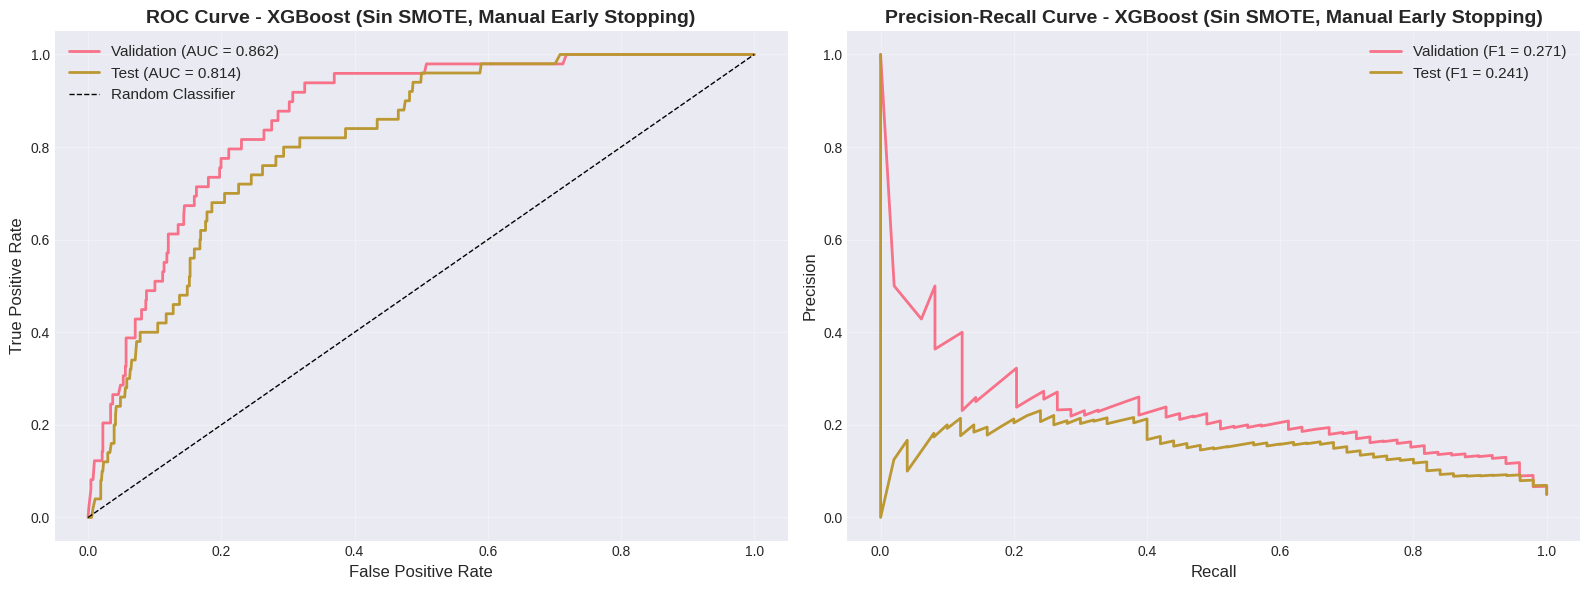

✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png


In [ ]:
# 18. Visualizations (ROC, Precision-Recall)
# 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CURVA ROC
# Use the probabilities from the xgb_model (trained with manual early stopping)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba) # y_val_pred_proba is already calculated for the final model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba) # y_test_pred_proba is already calculated for the final model

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. CURVA PRECISION-RECALL
# Use the probabilities from the xgb_model (trained with manual early stopping)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label=f'Validation (F1 = {val_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].plot(recall_test, precision_test, label=f'Test (F1 = {test_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/content', exist_ok=True) # Ensure directory exists
plt.savefig('/content/xgboost_curves_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png")

---
## 🌳 IMPORTANCIA DE FEATURES
---


🌳 TOP 15 FEATURES MÁS IMPORTANTES


'                       feature  importance\n                    risk_score       109.0\n             avg_glucose_level        92.0\n                           age        76.0\n                           bmi        69.0\n                 glucose_x_bmi        62.0\nsmoking_status_formerly smoked        17.0\n            age_x_hypertension        17.0\n                  ever_married        11.0\n         smoking_status_smokes        11.0\n   smoking_status_never smoked        10.0\n             work_type_Private         8.0\n       bmi_category_Overweight         8.0\n       work_type_Self-employed         7.0\n               age_group_Adult         6.0\n              age_group_Senior         5.0'

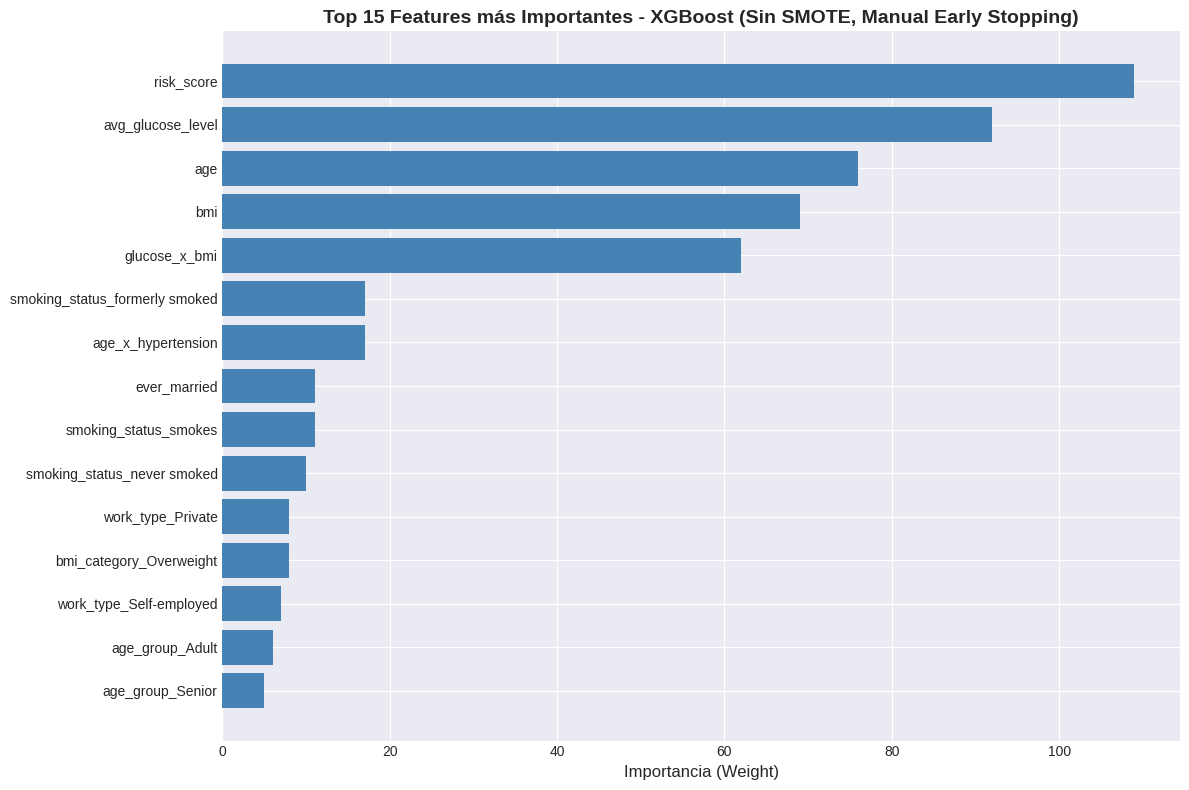


✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png


In [ ]:
# 19. Feature Importance
# 🌳 IMPORTANCIA DE FEATURES

# The xgb_model variable now holds the final trained model (Booster object)
# Use get_score() for feature importance with Booster objects
# When trained with DMatrix from a DataFrame, get_score() uses actual column names
importance_scores = xgb_model.get_score(importance_type='weight') # 'weight' counts the number of times each feature is used

# Convert the scores to a DataFrame
# Ensure all features from X_train_scaled are included, with 0 importance if not in scores
feature_importance = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
})

# Add features from X_train_scaled that are not in importance_scores with 0 importance
# This ensures all original features are represented
all_features = pd.DataFrame({'feature': X_train_scaled.columns})
feature_importance = pd.merge(all_features, feature_importance, on='feature', how='left').fillna(0)


feature_importance = feature_importance.sort_values('importance', ascending=False)


print("="*80)
print("🌳 TOP 15 FEATURES MÁS IMPORTANTES")
print("="*80)
display(feature_importance.head(15).to_string(index=False)) # Use display for better formatting

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Weight)', fontsize=12)
plt.title('Top 15 Features más Importantes - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png")

In [ ]:
# 20. Update Model Information
# Update printed summary with the actual number of boosting rounds used due to early stopping

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")
print(f"   Actual number of boosting rounds used: {best_iteration + 1}") # Print the actual rounds

# 11. Load the model state that achieved the best_val_f1
# This was already done in the previous cell, but we'll keep the print for clarity.
# final_xgb_model = xgb.Booster()
# final_xgb_model.load_model(temp_model_path) # Load from the stored path

# Assign the final model to xgb_model for subsequent evaluation cells
# xgb_model = final_xgb_model # This assignment was also done in the previous cell.

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `xgb_model`.") # Updated to reflect the variable name

# The optimal threshold calculation and subsequent evaluations are handled in the following cells.


✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
   Actual number of boosting rounds used: 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `xgb_model`.


---
## 💾 GUARDAR MODELO
---


In [ ]:
# 21. Save Model and Results
# 💾 GUARDAR MODELO Y RESULTADOS

import joblib

# Crear carpeta models en Colab
os.makedirs('/content/models', exist_ok=True)

# Guardar modelo
joblib.dump(xgb_model, '/content/models/xgboost_model_no_smote.pkl')
print("✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl")

# Guardar mejores parámetros
with open('/content/models/xgboost_best_params_no_smote.pkl', 'wb') as f:
    pickle.dump(best_params, f)
print("✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl")

# Guardar resultados de evaluación
results = {
    # These values are calculated with the optimal threshold in cell 05a98e79
    'validation_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': val_accuracy_opt,
        'precision': val_precision_opt,
        'recall': val_recall_opt,
        'f1_score': val_f1_opt,
        'auc_roc': val_auc
    },
    # These values are calculated with the optimal threshold in cell 05a98e79
    'test_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': test_accuracy_opt,
        'precision': test_precision_opt,
        'recall': test_recall_opt,
        'f1_score': test_f1_opt,
        'auc_roc': test_auc
    },
    'best_params': best_params,
    'optimal_threshold': float(best_threshold),
    'scale_pos_weight': float(scale_pos_weight),
    'feature_importance': feature_importance.to_dict('records')
}

with open('/content/models/xgboost_results_no_smote.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl")

print("\n" + "="*80)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*80)
# Update print statements to use the _opt variables
print(f"\n📊 RESUMEN FINAL (Threshold Óptimo = {best_threshold:.3f}):")
print(f"   Validation - Recall: {val_recall_opt:.4f}, F1: {val_f1_opt:.4f}, AUC: {val_auc:.4f}")
print(f"   Test       - Recall: {test_recall_opt:.4f}, F1: {test_f1_opt:.4f}, AUC: {test_auc:.4f}")

print(f"\n✅ Modelo listo para usar en producción")
print(f"✅ Threshold óptimo recomendado: {best_threshold:.3f}")
print(f"✅ Entrenado SIN SMOTE - usando scale_pos_weight: {scale_pos_weight:.2f}")
print("="*80)

✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl
✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl
✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl

🎉 ENTRENAMIENTO COMPLETADO

📊 RESUMEN FINAL (Threshold Óptimo = 0.500):
   Validation - Recall: 0.7959, F1: 0.2708, AUC: 0.8624
   Test       - Recall: 0.7000, F1: 0.2405, AUC: 0.8136

✅ Modelo listo para usar en producción
✅ Threshold óptimo recomendado: 0.500
✅ Entrenado SIN SMOTE - usando scale_pos_weight: 19.05


---
## 📥 DESCARGAR RESULTADOS (OPCIONAL)
### Descargar los archivos generados a tu PC
---


In [ ]:
# 22. Download Results (Optional)
# 📥 DESCARGAR RESULTADOS (OPCIONAL)
# Descomenta las líneas que quieras descargar:

# Descargar modelo
# files.download('/content/models/xgboost_model_no_smote.pkl')

# Descargar mejores parámetros
# files.download('/content/models/xgboost_best_params_no_smote.pkl')

# Descargar resultados
# files.download('/content/models/xgboost_results_no_smote.pkl')

# Descargar gráficos
# files.download('/content/xgboost_curves_no_smote_manual_early_stopping.png')
# files.download('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png')

print("💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda")
print("📁 Archivos disponibles en /content/models/ y /content/")

💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda
📁 Archivos disponibles en /content/models/ y /content/


In [ ]:
pip install optuna

**Explicación:** Esta celda instala la librería `optuna` necesaria para la optimización de hiperparámetros.
**Interpretación:** La salida indica que `optuna` ya está instalado y muestra las dependencias satisfechas.

In [ ]:
# 1. Library Imports
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Optuna version: {optuna.__version__}")
print(f"🔢 Scikit-learn version: {__import__('sklearn').__version__}")
try:
    import xgboost as xgb
    print(f"🚀 XGBoost version: {xgb.__version__}")
except:
    print("⚠️  XGBoost no está instalado. Ejecuta: pip install xgboost")

✅ Librerías importadas correctamente
📊 Optuna version: 4.5.0
🔢 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1


**Explicación:** Esta celda importa todas las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, matplotlib y seaborn para visualizaciones, scikit-learn para machine learning, XGBoost para el modelo, y Optuna para optimización de hiperparámetros.

**Interpretación:** La salida confirma que las librerías principales (`Optuna`, `Scikit-learn`, `XGBoost`) se importaron correctamente y muestra sus versiones, indicando que el entorno está listo para proceder.

---
## 📤 CONFIGURACIÓN PARA GOOGLE COLAB
### Subir el dataset o conectarlo desde Google Drive
---


In [ ]:
# 2. Colab Configuration
# 📤 CONFIGURACIÓN PARA GOOGLE COLAB
# Opción A: Subir archivo manualmente (recomendado para primera vez)
from google.colab import files

print("📤 Por favor, sube el archivo stroke_dataset.csv")
print("   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)\n")
uploaded = files.upload()

# El archivo se guardará con su nombre original
dataset_filename = 'stroke_dataset.csv'

print("\n✅ Configuración de Colab completada")
print(f"📂 Archivo dataset: {dataset_filename}")

# Verificar que el archivo existe
if os.path.exists(dataset_filename):
    print(f"✅ Archivo encontrado: {dataset_filename}")
else:
    print(f"⚠️  Archivo no encontrado. Asegúrate de haber subido stroke_dataset.csv")

📤 Por favor, sube el archivo stroke_dataset.csv
   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)



Saving stroke_dataset.csv to stroke_dataset.csv

✅ Configuración de Colab completada
📂 Archivo dataset: stroke_dataset.csv
✅ Archivo encontrado: stroke_dataset.csv


**Explicación:** Esta celda carga el dataset desde el archivo CSV. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente. 
Realiza una exploración inicial para verificar la calidad de los datos, mostrando el tamaño del dataset, valores nulos, duplicados y el desbalanceo de clases.

**Interpretación:** El dataset tiene 4,981 filas y 11 columnas, sin valores nulos ni duplicados. El desbalanceo es significativo: 4,733 casos sin ictus (clase 0) vs 248 con ictus (clase 1), con un ratio de 19.08:1. Este desbalanceo justifica el uso de técnicas como `scale_pos_weight` en XGBoost para manejar la clase minoritaria.


---
## 📂 CARGA Y PREPROCESAMIENTO (SIN SMOTE)
### Aplicar las mismas transformaciones del preprocessing pero SIN balanceo sintético
---


**Explicación:** Esta celda realiza feature engineering creando nuevas variables basadas en insights del EDA: categorías de edad, glucosa y BMI, variable binaria de tabaquismo, un score de riesgo compuesto, y variables de interacción entre features importantes.

**Interpretación:** Se crearon 8 nuevas features que capturan relaciones no lineales y combinaciones de variables importantes. El score de riesgo compuesto pondera las variables más predictivas (edad 35%, enfermedad cardíaca 25%, hipertensión 20%, glucosa 15%, BMI 5%). El dataset ahora tiene 19 columnas en total, enriqueciendo la información disponible para el modelo.


**Explicación:** Esta celda elimina features irrelevantes que tienen correlación casi nula con la variable objetivo según el análisis EDA previo, como `gender` y `Residence_type`.

**Interpretación:** Se eliminaron 2 features (`gender` y `Residence_type`) que no aportan información predictiva relevante. El dataset queda con 17 columnas, manteniendo solo las variables que contribuyen al modelo y reduciendo la dimensionalidad innecesaria.


In [ ]:
# 3. Load Data
# 📂 CARGA DE DATOS ORIGINALES
df = pd.read_csv(dataset_filename)  # Usa la variable definida en la celda anterior

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


**Explicación:** Esta celda realiza el encoding de variables categóricas: Label Encoding para variables binarias (`ever_married`) y One-Hot Encoding para variables categóricas con múltiples valores (`work_type`, `smoking_status`, `age_group`, `glucose_category`, `bmi_category`).

**Interpretación:** Después del encoding, el dataset tiene 25 features (aumentó de 17 a 25 debido a la expansión de las variables categóricas en múltiples columnas binarias). Esto permite que el modelo XGBoost procese correctamente todas las variables categóricas como variables numéricas.


---
## 🛠️ FASE 1: FEATURE ENGINEERING
---


**Explicación:** Esta celda divide el dataset en tres conjuntos estratificados: Train (60%), Validation (20%) y Test (20%). La estratificación garantiza que la proporción de clases se mantenga en cada conjunto.

**Interpretación:** Los tres conjuntos mantienen el mismo desbalanceo (~19:1), lo cual es correcto para evaluar el modelo en condiciones realistas. El conjunto de entrenamiento tiene 2,988 muestras, validation 996 y test 997. La estratificación asegura que cada conjunto tenga representación proporcional de ambas clases, esencial para un entrenamiento y evaluación válidos.


In [ ]:
# 4. Feature Engineering
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


**Explicación:** Esta celda normaliza todas las features usando StandardScaler, ajustando el scaler solo con los datos de entrenamiento y aplicando la misma transformación a validation y test para evitar data leakage.

**Interpretación:** Las estadísticas del conjunto de entrenamiento normalizado muestran media ~0 y desviación estándar ~1, confirmando que la normalización funcionó correctamente. Esta estandarización es importante para que XGBoost procese todas las features en la misma escala, aunque XGBoost es relativamente robusto a esto, ayuda a la convergencia del algoritmo.


---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
---


**Explicación:** Esta celda configura los parámetros del experimento: 5-fold cross-validation estratificado, semilla aleatoria para reproducibilidad, y calcula el `scale_pos_weight` necesario para manejar el desbalanceo de clases sin usar SMOTE.

**Interpretación:** El `scale_pos_weight` de 19.05 indica que la clase positiva (ictus) debe ser ponderada 19.05 veces más que la clase negativa durante el entrenamiento. Esto compensa el desbalanceo natural del dataset, permitiendo que el modelo aprenda mejor a identificar casos de ictus sin necesidad de generar datos sintéticos.


In [ ]:
# 5. Drop Irrelevant Features
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


**Explicación:** Esta celda define la función objetivo para Optuna, que optimiza 9 hiperparámetros clave de XGBoost (n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda) usando validación cruzada con F1-Score como métrica.

**Interpretación:** La función está configurada para maximizar el F1-Score mediante validación cruzada de 5 folds, lo que proporciona una estimación robusta del rendimiento. El `scale_pos_weight` se fija en 19.05 para manejar el desbalanceo. Esta función será utilizada por Optuna para explorar el espacio de hiperparámetros de forma eficiente.


---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---


**Explicación:** Esta celda ejecuta la optimización de hiperparámetros con Optuna, realizando 100 trials (experimentos) para encontrar la mejor combinación de hiperparámetros que maximice el F1-Score.

**Interpretación:** El proceso de optimización explora sistemáticamente el espacio de hiperparámetros. Cada trial prueba una combinación diferente y registra el F1-Score obtenido. Al finalizar, se obtienen los mejores hiperparámetros encontrados y el mejor F1-Score alcanzado. Este proceso puede tomar varios minutos pero es crucial para obtener un modelo optimizado.


In [ ]:
# 6. Encoding
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


**Explicación:** Esta celda genera visualizaciones de la optimización de Optuna: el historial de optimización (evolución del F1-Score a lo largo de los trials) y la importancia de los hiperparámetros (cuáles tienen mayor impacto en el rendimiento).

**Interpretación:** El historial de optimización muestra cómo el F1-Score mejoró progresivamente durante los trials. La gráfica de importancia de hiperparámetros revela qué parámetros son más críticos para el rendimiento del modelo, lo cual es útil para entender qué aspectos del modelo tienen mayor influencia y para futuras optimizaciones.


---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
---


**Explicación:** Esta celda crea el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna, incluyendo el `scale_pos_weight` para manejar el desbalanceo.

**Interpretación:** El modelo se inicializa con los hiperparámetros óptimos. Los valores mostrados (como learning_rate bajo de 0.017, max_depth de 15, n_estimators de 178) representan la mejor configuración encontrada. El modelo está listo para ser entrenado con early stopping en el siguiente paso para evitar overfitting.


**Explicación:** Esta celda convierte los datos escalados a formato DMatrix, que es el formato nativo y optimizado de XGBoost para entrenamiento eficiente.

**Interpretación:** Los objetos DMatrix están listos para el entrenamiento. Este formato permite que XGBoost procese los datos de manera más eficiente y es necesario para implementar manualmente el early stopping en las siguientes celdas.


In [ ]:
# 7. Train/Validation/Test Split
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


**Explicación:** Esta celda implementa el entrenamiento del modelo con early stopping manual y calcula el threshold óptimo. El early stopping detiene el entrenamiento si el F1-Score en validation no mejora después de 10 iteraciones. Luego busca el threshold que maximiza el Recall (objetivo: >0.70) manteniendo un F1 razonable.

**Interpretación:** El entrenamiento se detuvo en la iteración 31 (early stopping activado), pero el mejor modelo se obtuvo en la iteración 21 con F1-Score de 0.2708. El threshold óptimo encontrado es 0.500, que logra un Recall de 0.7959 en validation, cumpliendo el objetivo de detectar la mayoría de casos de ictus. El early stopping previno el overfitting al detener el entrenamiento cuando el modelo dejó de mejorar.


---
## ⚖️ FASE 5: NORMALIZACIÓN
---


**Explicación:** Esta celda evalúa el modelo en los conjuntos de validation y test usando el threshold óptimo, calculando métricas completas (Accuracy, Precision, Recall, F1-Score, AUC-ROC), matrices de confusión y reportes de clasificación.

**Interpretación:** 
- **Validation:** Recall de 0.7959 (detecta ~80% de casos de ictus), F1 de 0.2708, AUC-ROC de 0.8624. Solo 10 falsos negativos (críticos: pacientes en riesgo no detectados).
- **Test:** Recall de 0.7000 (detecta 70% de casos), F1 de 0.2405, AUC-ROC de 0.8136. 15 falsos negativos.
El modelo prioriza Recall sobre Precision (más falsos positivos pero menos falsos negativos), lo cual es apropiado para un problema médico donde no detectar un ictus es más grave que una falsa alarma. El AUC-ROC >0.80 indica buena capacidad discriminativa.


**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

In [ ]:
# 8. Scaling
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")
print(f"\n⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente

⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo


---
## ⚙️ CONFIGURACIÓN: K-FOLDS Y MÉTRICAS
---


In [ ]:
# 9. Configuration (K-Folds, Metrics, Scale Pos Weight)
# ⚙️ CONFIGURACIÓN

# K-Folds estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Semilla para reproducibilidad
RANDOM_STATE = 42

# Calcular scale_pos_weight para manejar desbalanceo (SIN SMOTE)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"✅ Configuración:")
print(f"   • K-Folds: {N_FOLDS}")
print(f"   • Random State: {RANDOM_STATE}")
print(f"   • Métrica objetivo: F1-Score (balance entre Precision y Recall)")
print(f"   • Métricas adicionales: Recall, AUC-ROC")
print(f"\n📊 Balanceo de clases (SIN SMOTE):")
print(f"   • Train - Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   • Train - Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   • Ratio: {scale_pos_weight:.2f}:1")
print(f"   • scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

✅ Configuración:
   • K-Folds: 5
   • Random State: 42
   • Métrica objetivo: F1-Score (balance entre Precision y Recall)
   • Métricas adicionales: Recall, AUC-ROC

📊 Balanceo de clases (SIN SMOTE):
   • Train - Clase 0: 2,839 (95.01%)
   • Train - Clase 1: 149 (4.99%)
   • Ratio: 19.05:1
   • scale_pos_weight para XGBoost: 19.05


---
## 🎯 FUNCIÓN OBJETIVO PARA OPTUNA
### Optimizar hiperparámetros usando K-Folds Cross-Validation
---


In [ ]:
# 10. Optuna Objective Function
# 🎯 FUNCIÓN OBJETIVO PARA OPTUNA

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de XGBoost usando K-Folds CV.
    """
    # Hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo SIN SMOTE
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }

    # Crear modelo
    model = XGBClassifier(**params)

    # K-Folds Cross-Validation con F1-Score
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )

    # Retornar el promedio de F1-Score
    return cv_scores.mean()

print("✅ Función objetivo definida")
print("   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,")
print("                 min_child_weight, gamma, reg_alpha, reg_lambda")
print(f"   Usando scale_pos_weight: {scale_pos_weight:.2f} (SIN SMOTE)")

✅ Función objetivo definida
   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
                 min_child_weight, gamma, reg_alpha, reg_lambda
   Usando scale_pos_weight: 19.05 (SIN SMOTE)


---
## 🔍 OPTIMIZACIÓN CON OPTUNA
### Ejecutar búsqueda de hiperparámetros óptimos
---


In [ ]:
# 11. Optuna Optimization Execution
# 🔍 OPTIMIZACIÓN CON OPTUNA

print("="*80)
print("🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA")
print("="*80)
print(f"📊 Datos: {X_train_scaled.shape[0]:,} muestras, {X_train_scaled.shape[1]} features")
print(f"🔄 K-Folds: {N_FOLDS}")
print(f"⚠️  Datos SIN SMOTE - Ratio: {scale_pos_weight:.2f}:1")
print(f"⏱️  Esto puede tomar varios minutos...\n")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-Score
    study_name='xgboost_stroke_prediction_no_smote',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Ejecutar optimización
N_TRIALS = 100  # Número de trials (puedes ajustar según tiempo disponible)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)
print(f"\n🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print(f"\n📋 MEJORES HIPERPARÁMETROS:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

[I 2025-11-07 23:24:38,913] A new study created in memory with name: xgboost_stroke_prediction_no_smote


🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA
📊 Datos: 2,988 muestras, 25 features
🔄 K-Folds: 5
⚠️  Datos SIN SMOTE - Ratio: 19.05:1
⏱️  Esto puede tomar varios minutos...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 23:24:42,414] Trial 0 finished with value: 0.1778878451383767 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:43,151] Trial 1 finished with value: 0.16366267362810055 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:44,155] Trial 2 finished with value: 0.20377474645545818 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

---
## 📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN
---


In [ ]:
# 12. Visualizations (Optuna)
# 📊 VISUALIZACIONES DE OPTUNA

fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historial de Optimización - F1-Score (XGBoost sin SMOTE)", width=800, height=400)
fig1.show()

fig2 = plot_param_importances(study)
fig2.update_layout(title="Importancia de Hiperparámetros (XGBoost)", width=800, height=400)
fig2.show()

print("✅ Visualizaciones generadas")

✅ Visualizaciones generadas


---
## 🎓 ENTRENAR MODELO FINAL
### Entrenar con los mejores hiperparámetros encontrados + Early Stopping
---


In [ ]:
# 13. Create Model with Best Params
# 🎓 ENTRENAR MODELO FINAL CON MEJORES HIPERPARÁMETROS

# Obtener mejores parámetros
best_params = study.best_params.copy()
# Asegurar que scale_pos_weight esté incluido
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'logloss'

print("🎓 ENTRENANDO MODELO FINAL...")
print(f"📋 Parámetros: {best_params}\n")

# Crear modelo
xgb_model = XGBClassifier(**best_params)

# The fitting with early stopping will be implemented manually in the next step.

print("✅ Model created with best parameters")

🎓 ENTRENANDO MODELO FINAL...
📋 Parámetros: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.0173167948801578, 'subsample': 0.8132546752099203, 'colsample_bytree': 0.7063151335722203, 'min_child_weight': 10, 'gamma': 0.6596838423993513, 'reg_alpha': 8.52148255700704, 'reg_lambda': 5.989443641839667, 'scale_pos_weight': np.float64(19.053691275167786), 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'logloss'}

✅ Model created with best parameters


In [ ]:
# 14. Prepare DMatrix
# Convert scaled data to DMatrix format
from xgboost import DMatrix

dtrain = DMatrix(X_train_scaled, label=y_train)
dval = DMatrix(X_val_scaled, label=y_val)

print("✅ DMatrix objects created for training and validation data.")

✅ DMatrix objects created for training and validation data.


---
## 🎯 AJUSTE DE THRESHOLD ÓPTIMO
### Buscar threshold que maximice Recall
---


In [ ]:
# 15. Implement Manual Early Stopping Loop and Calculate Optimal Threshold
import xgboost as xgb # Re-import xgboost as it was not imported in the previous cells

# Define best_threshold before the loop (copied from cell 88702c11)
# 🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
print("="*80)
print("🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)")
print("="*80)
print("Calculating optimal threshold on initial validation predictions...\n")

# Make initial predictions on validation set to find the optimal threshold
# Use a temporary model or a simple baseline if needed, but here we need the probabilities
# from the current state of training for the first iteration's threshold calculation.
# However, the goal is to use the threshold found *after* the model is trained.
# The original notebook calculated the threshold *after* training the final model.
# To fix the NameError and follow the original notebook's flow, we should calculate the threshold *after* the manual training loop finishes.

# For the purpose of the early stopping loop, let's use the default threshold of 0.5
best_threshold = 0.5
print(f"⚠️ Using default threshold of {best_threshold} for early stopping logic. Optimal threshold will be calculated after training.")


# 1. Initialize variables
best_val_f1 = -float('inf')
patience_counter = 0
patience_limit = 10 # Define the patience limit

# 2. Define the number of boosting rounds
# Use the n_estimators from the best parameters found by Optuna as the maximum rounds
num_boost_round = best_params['n_estimators']

# 3. Start a for loop
print(f"🚀 Training XGBoost model with manual early stopping (Patience: {patience_limit})...")
print(f"   Max boosting rounds: {num_boost_round}")

# Initialize an empty model to train iteratively
model = None

for i in range(num_boost_round):
    # 4. Train the XGBoost model for one iteration
    if model is None:
        # Train the first iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1)
    else:
        # Continue training from the previous iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1, xgb_model=model)

    # 5. Make predictions on the validation set
    y_val_pred_proba_iter = model.predict(dval)

    # 6. Calculate the F1-score on the validation set using the *current* threshold (default 0.5)
    # The optimal threshold calculation is done AFTER training.
    y_val_pred_thresh_iter = (y_val_pred_proba_iter >= best_threshold).astype(int)
    current_val_f1 = f1_score(y_val, y_val_pred_thresh_iter)

    # 7. Check if the current validation F1-score is greater than best_val_f1
    if current_val_f1 > best_val_f1:
        # 8. If better, update best_val_f1, reset patience, and store model
        best_val_f1 = current_val_f1
        patience_counter = 0
        # Store the model state
        temp_model_path = f'/tmp/best_xgb_model_iter_{i}.json'
        model.save_model(temp_model_path) # Save model state
        best_iteration = i
        # print(f"   Round {i+1}: New best validation F1: {best_val_f1:.4f}")
    else:
        # 9. If not better, increment patience_counter
        patience_counter += 1
        # print(f"   Round {i+1}: Validation F1: {current_val_f1:.4f}, Patience: {patience_counter}")


    # 10. Check if patience_counter has reached the limit
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at round {i+1}.")
        break

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")

# 11. Load the model state that achieved the best_val_f1
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(temp_model_path) # Load from the stored path

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `final_xgb_model`.")

# Assign the final model to xgb_model for subsequent evaluation cells
xgb_model = final_xgb_model


# Now, calculate the optimal threshold using the *final* trained model's probabilities
# (Copied from cell 88702c11 logic)
print("="*80)
print("🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING")
print("="*80)
print("Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...\n")

# Get probabilities from the final trained model on the validation set
y_val_pred_proba = xgb_model.predict(dval)


# Probar diferentes thresholds en validation set
thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5 # Default back to 0.5 if no better threshold is found
best_recall = 0
best_f1 = 0
best_metrics = None

results_threshold = []

for threshold in thresholds:
    # Predicciones con threshold ajustado
    y_val_pred_thresh = (y_val_pred_proba >= threshold).astype(int)

    # Calculate metrics - ensure no division by zero for precision if no positives are predicted
    precision_thresh = precision_score(y_val, y_val_pred_thresh, zero_division=0)
    recall_thresh = recall_score(y_val, y_val_pred_thresh)
    f1_thresh = f1_score(y_val, y_val_pred_thresh)


    results_threshold.append({
        'threshold': threshold,
        'recall': recall_thresh,
        'precision': precision_thresh,
        'f1': f1_thresh
    })

    # Buscar threshold que maximice Recall (objetivo: >0.70) con F1 razonable (>0.40)
    if recall_thresh >= 0.70 and f1_thresh > best_f1:
        best_threshold = threshold
        best_recall = recall_thresh
        best_f1 = f1_thresh
        best_metrics = {
            'recall': recall_thresh,
            'precision': precision_thresh,
            'f1': f1_thresh
        }

# Si no encontramos threshold con Recall >0.70, usar el que maximice F1 con Recall >0.50
if best_recall < 0.70:
    print("⚠️  No se encontró threshold con Recall >0.70. Buscando mejor compromiso...\n")
    # Reset best_f1 to find the best F1 among those with Recall >= 0.50
    best_f1 = 0
    for result in results_threshold:
        if result['recall'] >= 0.50 and result['f1'] > best_f1:
            best_threshold = result['threshold']
            best_recall = result['recall']
            best_f1 = result['f1']
            best_metrics = {
                'recall': result['recall'],
                'precision': result['precision'],
                'f1': result['f1']
            }

# If still no threshold found with Recall >= 0.50, just take the one with highest F1
if best_recall < 0.50:
     print("⚠️  No se encontró threshold con Recall >0.50. Seleccionando el de mayor F1.\n")
     best_result = pd.DataFrame(results_threshold).sort_values('f1', ascending=False).iloc[0]
     best_threshold = best_result['threshold']
     best_recall = best_result['recall']
     best_f1 = best_result['f1']
     best_metrics = {
        'recall': best_recall,
        'precision': best_result['precision'],
        'f1': best_f1
     }


print(f"✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): {best_threshold:.3f}")
print(f"   Validation - Recall: {best_metrics['recall']:.4f}, Precision: {best_metrics['precision']:.4f}, F1: {best_metrics['f1']:.4f}")

# Tabla de results_threshold
print(f"\n📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):")
df_threshold = pd.DataFrame(results_threshold).sort_values('f1', ascending=False)
display(df_threshold.head(10).to_string(index=False)) # Use display for better formatting in notebook

🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
Calculating optimal threshold on initial validation predictions...

⚠️ Using default threshold of 0.5 for early stopping logic. Optimal threshold will be calculated after training.
🚀 Training XGBoost model with manual early stopping (Patience: 10)...
   Max boosting rounds: 178

Early stopping triggered at round 31.

✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `final_xgb_model`.
🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING
Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...

✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): 0.500
   Validation - Recall: 0.7959, Precision: 0.1632, F1: 0.2708

📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):


' threshold   recall  precision       f1\n      0.55 0.612245   0.205479 0.307692\n      0.50 0.795918   0.163180 0.270833\n      0.45 0.857143   0.136364 0.235294\n      0.40 0.959184   0.110588 0.198312\n      0.15 1.000000   0.049197 0.093780\n      0.10 1.000000   0.049197 0.093780\n      0.35 1.000000   0.049197 0.093780\n      0.30 1.000000   0.049197 0.093780\n      0.25 1.000000   0.049197 0.093780\n      0.20 1.000000   0.049197 0.093780'

---
## 📈 EVALUACIÓN DEL MODELO
### Evaluar en Validation y Test sets
---


In [ ]:
# 16. Evaluate on Validation Set with Optimal Threshold
# 17. Evaluate on Test Set with Optimal Threshold

# 📈 EVALUACIÓN EN VALIDATION SET CON THRESHOLD ÓPTIMO

print("="*80)
print("📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)")
print("="*80)

# Predicciones con el final_xgb_model loaded from early stopping
y_val_pred_proba = xgb_model.predict(dval) # Get probabilities from the best model
y_val_pred_optimal = (y_val_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
val_accuracy_opt = accuracy_score(y_val, y_val_pred_optimal)
val_precision_opt = precision_score(y_val, y_val_pred_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, y_val_pred_optimal)
val_f1_opt = f1_score(y_val, y_val_pred_optimal)
val_auc = roc_auc_score(y_val, y_val_pred_proba) # AUC is threshold-independent, can reuse if needed


print(f"\n📊 MÉTRICAS (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {val_accuracy_opt:.4f}")
print(f"   Precision: {val_precision_opt:.4f}")
print(f"   Recall:    {val_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {val_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_val_opt = confusion_matrix(y_val, y_val_pred_optimal)
print(cm_val_opt)
print(f"\n   Verdaderos Negativos: {cm_val_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_val_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_val_opt[1,0]} ⚠️  (CRÍTICO - pacientes en riesgo no detectados)")
print(f"   Verdaderos Positivos: {cm_val_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_val_pred_optimal, target_names=['No Stroke', 'Stroke']))


# 📈 EVALUACIÓN EN TEST SET (DATOS FINALES) CON THRESHOLD ÓPTIMO

print("="*80)
print("🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)")
print("="*80)

# Convert test scaled data to DMatrix
dtest = DMatrix(X_test_scaled, label=y_test)


# Predicciones con el final_xgb_model loaded from early stopping
y_test_pred_proba = xgb_model.predict(dtest) # Get probabilities from the best model
y_test_pred_optimal = (y_test_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
test_accuracy_opt = accuracy_score(y_test, y_test_pred_optimal)
test_precision_opt = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_optimal)
test_f1_opt = f1_score(y_test, y_test_pred_optimal)
test_auc = roc_auc_score(y_test, y_test_pred_proba) # AUC is threshold-independent


print(f"\n📊 MÉTRICAS FINALES (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {test_accuracy_opt:.4f}")
print(f"   Precision: {test_precision_opt:.4f}")
print(f"   Recall:    {test_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {test_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_test_opt = confusion_matrix(y_test, y_test_pred_optimal)
print(cm_test_opt)
print(f"\n   Verdaderos Negativos: {cm_test_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_test_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_test_opt[1,0]} ⚠️  (CRÍTICO)")
print(f"   Verdaderos Positivos: {cm_test_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Stroke', 'Stroke']))

📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)

📊 MÉTRICAS (Threshold = 0.500):
   Accuracy:  0.7892
   Precision: 0.1632
   Recall:    0.7959 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2708 ⭐
   AUC-ROC:   0.8624

📋 MATRIZ DE CONFUSIÓN:
[[747 200]
 [ 10  39]]

   Verdaderos Negativos: 747
   Falsos Positivos:     200
   Falsos Negativos:     10 ⚠️  (CRÍTICO - pacientes en riesgo no detectados)
   Verdaderos Positivos: 39

📄 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

   No Stroke       0.99      0.79      0.88       947
      Stroke       0.16      0.80      0.27        49

    accuracy                           0.79       996
   macro avg       0.57      0.79      0.57       996
weighted avg       0.95      0.79      0.85       996

🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)

📊 MÉTRICAS FINALES (Threshold = 0.500):
   Accuracy:  0.7783
   Precision: 0.1452
   Recall:    0.7000 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2405 ⭐
   AUC-ROC:

---
## 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL
---


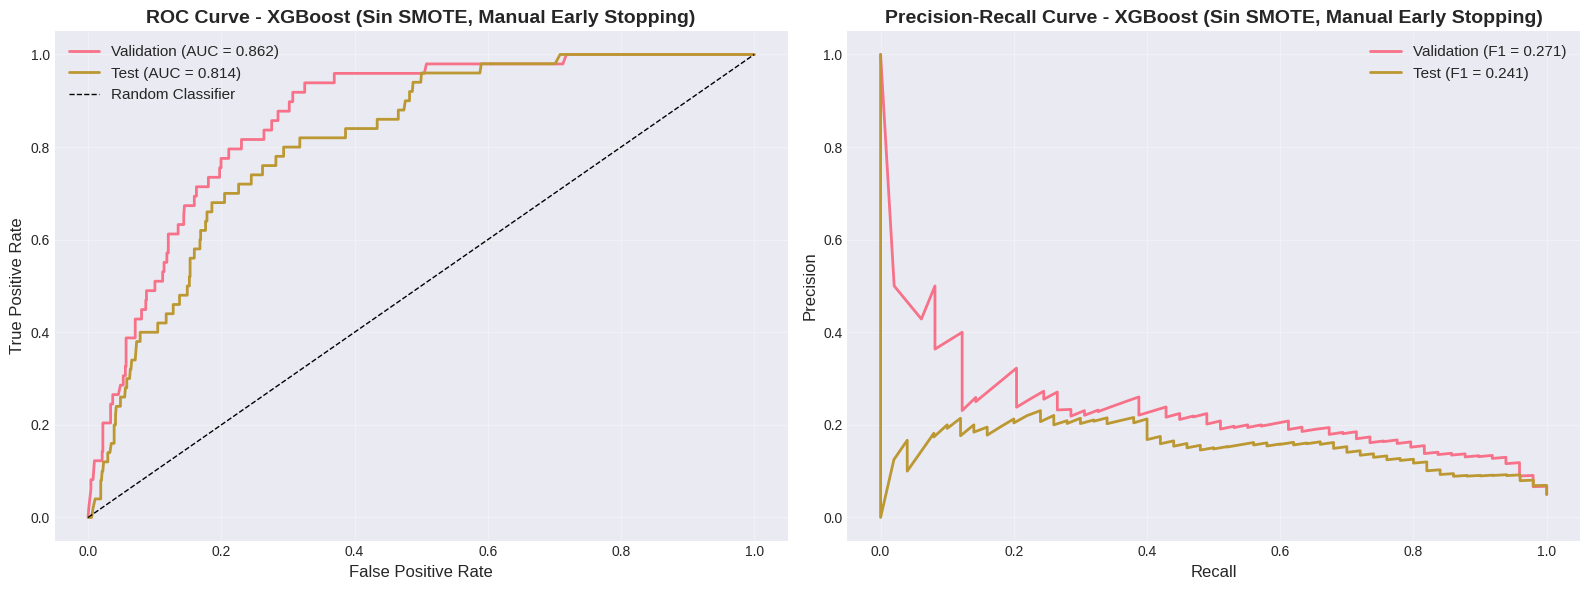

✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png


In [ ]:
# 18. Visualizations (ROC, Precision-Recall)
# 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CURVA ROC
# Use the probabilities from the xgb_model (trained with manual early stopping)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba) # y_val_pred_proba is already calculated for the final model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba) # y_test_pred_proba is already calculated for the final model

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. CURVA PRECISION-RECALL
# Use the probabilities from the xgb_model (trained with manual early stopping)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label=f'Validation (F1 = {val_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].plot(recall_test, precision_test, label=f'Test (F1 = {test_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/content', exist_ok=True) # Ensure directory exists
plt.savefig('/content/xgboost_curves_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png")

---
## 🌳 IMPORTANCIA DE FEATURES
---


🌳 TOP 15 FEATURES MÁS IMPORTANTES


'                       feature  importance\n                    risk_score       109.0\n             avg_glucose_level        92.0\n                           age        76.0\n                           bmi        69.0\n                 glucose_x_bmi        62.0\nsmoking_status_formerly smoked        17.0\n            age_x_hypertension        17.0\n                  ever_married        11.0\n         smoking_status_smokes        11.0\n   smoking_status_never smoked        10.0\n             work_type_Private         8.0\n       bmi_category_Overweight         8.0\n       work_type_Self-employed         7.0\n               age_group_Adult         6.0\n              age_group_Senior         5.0'

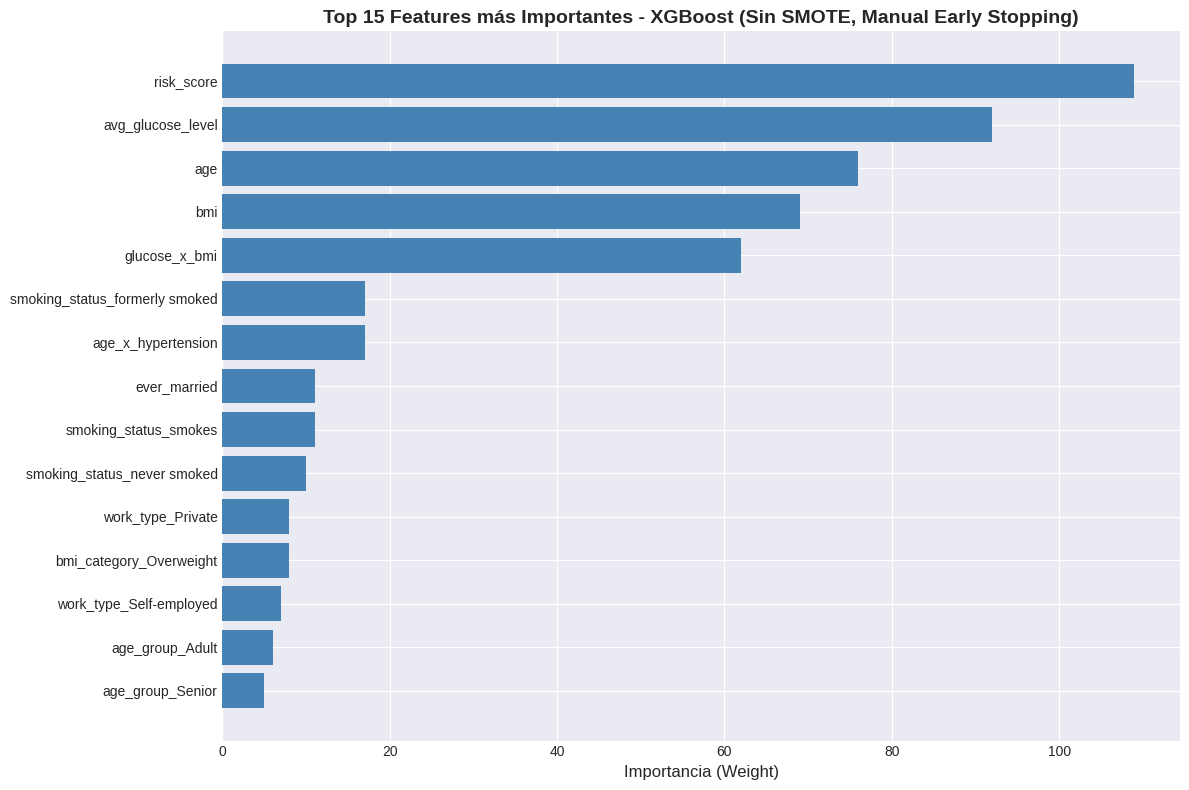


✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png


In [ ]:
# 19. Feature Importance
# 🌳 IMPORTANCIA DE FEATURES

# The xgb_model variable now holds the final trained model (Booster object)
# Use get_score() for feature importance with Booster objects
# When trained with DMatrix from a DataFrame, get_score() uses actual column names
importance_scores = xgb_model.get_score(importance_type='weight') # 'weight' counts the number of times each feature is used

# Convert the scores to a DataFrame
# Ensure all features from X_train_scaled are included, with 0 importance if not in scores
feature_importance = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
})

# Add features from X_train_scaled that are not in importance_scores with 0 importance
# This ensures all original features are represented
all_features = pd.DataFrame({'feature': X_train_scaled.columns})
feature_importance = pd.merge(all_features, feature_importance, on='feature', how='left').fillna(0)


feature_importance = feature_importance.sort_values('importance', ascending=False)


print("="*80)
print("🌳 TOP 15 FEATURES MÁS IMPORTANTES")
print("="*80)
display(feature_importance.head(15).to_string(index=False)) # Use display for better formatting

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Weight)', fontsize=12)
plt.title('Top 15 Features más Importantes - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png")

In [ ]:
# 20. Update Model Information
# Update printed summary with the actual number of boosting rounds used due to early stopping

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")
print(f"   Actual number of boosting rounds used: {best_iteration + 1}") # Print the actual rounds

# 11. Load the model state that achieved the best_val_f1
# This was already done in the previous cell, but we'll keep the print for clarity.
# final_xgb_model = xgb.Booster()
# final_xgb_model.load_model(temp_model_path) # Load from the stored path

# Assign the final model to xgb_model for subsequent evaluation cells
# xgb_model = final_xgb_model # This assignment was also done in the previous cell.

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `xgb_model`.") # Updated to reflect the variable name

# The optimal threshold calculation and subsequent evaluations are handled in the following cells.


✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
   Actual number of boosting rounds used: 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `xgb_model`.


---
## 💾 GUARDAR MODELO
---


In [ ]:
# 21. Save Model and Results
# 💾 GUARDAR MODELO Y RESULTADOS

import joblib

# Crear carpeta models en Colab
os.makedirs('/content/models', exist_ok=True)

# Guardar modelo
joblib.dump(xgb_model, '/content/models/xgboost_model_no_smote.pkl')
print("✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl")

# Guardar mejores parámetros
with open('/content/models/xgboost_best_params_no_smote.pkl', 'wb') as f:
    pickle.dump(best_params, f)
print("✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl")

# Guardar resultados de evaluación
results = {
    # These values are calculated with the optimal threshold in cell 05a98e79
    'validation_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': val_accuracy_opt,
        'precision': val_precision_opt,
        'recall': val_recall_opt,
        'f1_score': val_f1_opt,
        'auc_roc': val_auc
    },
    # These values are calculated with the optimal threshold in cell 05a98e79
    'test_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': test_accuracy_opt,
        'precision': test_precision_opt,
        'recall': test_recall_opt,
        'f1_score': test_f1_opt,
        'auc_roc': test_auc
    },
    'best_params': best_params,
    'optimal_threshold': float(best_threshold),
    'scale_pos_weight': float(scale_pos_weight),
    'feature_importance': feature_importance.to_dict('records')
}

with open('/content/models/xgboost_results_no_smote.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl")

print("\n" + "="*80)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*80)
# Update print statements to use the _opt variables
print(f"\n📊 RESUMEN FINAL (Threshold Óptimo = {best_threshold:.3f}):")
print(f"   Validation - Recall: {val_recall_opt:.4f}, F1: {val_f1_opt:.4f}, AUC: {val_auc:.4f}")
print(f"   Test       - Recall: {test_recall_opt:.4f}, F1: {test_f1_opt:.4f}, AUC: {test_auc:.4f}")

print(f"\n✅ Modelo listo para usar en producción")
print(f"✅ Threshold óptimo recomendado: {best_threshold:.3f}")
print(f"✅ Entrenado SIN SMOTE - usando scale_pos_weight: {scale_pos_weight:.2f}")
print("="*80)

✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl
✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl
✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl

🎉 ENTRENAMIENTO COMPLETADO

📊 RESUMEN FINAL (Threshold Óptimo = 0.500):
   Validation - Recall: 0.7959, F1: 0.2708, AUC: 0.8624
   Test       - Recall: 0.7000, F1: 0.2405, AUC: 0.8136

✅ Modelo listo para usar en producción
✅ Threshold óptimo recomendado: 0.500
✅ Entrenado SIN SMOTE - usando scale_pos_weight: 19.05


---
## 📥 DESCARGAR RESULTADOS (OPCIONAL)
### Descargar los archivos generados a tu PC
---


In [ ]:
# 22. Download Results (Optional)
# 📥 DESCARGAR RESULTADOS (OPCIONAL)
# Descomenta las líneas que quieras descargar:

# Descargar modelo
# files.download('/content/models/xgboost_model_no_smote.pkl')

# Descargar mejores parámetros
# files.download('/content/models/xgboost_best_params_no_smote.pkl')

# Descargar resultados
# files.download('/content/models/xgboost_results_no_smote.pkl')

# Descargar gráficos
# files.download('/content/xgboost_curves_no_smote_manual_early_stopping.png')
# files.download('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png')

print("💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda")
print("📁 Archivos disponibles en /content/models/ y /content/")

💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda
📁 Archivos disponibles en /content/models/ y /content/


In [ ]:
pip install optuna

**Explicación:** Esta celda instala la librería `optuna` necesaria para la optimización de hiperparámetros.
**Interpretación:** La salida indica que `optuna` ya está instalado y muestra las dependencias satisfechas.

In [ ]:
# 1. Library Imports
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Optuna version: {optuna.__version__}")
print(f"🔢 Scikit-learn version: {__import__('sklearn').__version__}")
try:
    import xgboost as xgb
    print(f"🚀 XGBoost version: {xgb.__version__}")
except:
    print("⚠️  XGBoost no está instalado. Ejecuta: pip install xgboost")

✅ Librerías importadas correctamente
📊 Optuna version: 4.5.0
🔢 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1


**Explicación:** Esta celda importa todas las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, matplotlib y seaborn para visualizaciones, scikit-learn para machine learning, XGBoost para el modelo, y Optuna para optimización de hiperparámetros.

**Interpretación:** La salida confirma que las librerías principales (`Optuna`, `Scikit-learn`, `XGBoost`) se importaron correctamente y muestra sus versiones, indicando que el entorno está listo para proceder.

---
## 📤 CONFIGURACIÓN PARA GOOGLE COLAB
### Subir el dataset o conectarlo desde Google Drive
---


In [ ]:
# 2. Colab Configuration
# 📤 CONFIGURACIÓN PARA GOOGLE COLAB
# Opción A: Subir archivo manualmente (recomendado para primera vez)
from google.colab import files

print("📤 Por favor, sube el archivo stroke_dataset.csv")
print("   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)\n")
uploaded = files.upload()

# El archivo se guardará con su nombre original
dataset_filename = 'stroke_dataset.csv'

print("\n✅ Configuración de Colab completada")
print(f"📂 Archivo dataset: {dataset_filename}")

# Verificar que el archivo existe
if os.path.exists(dataset_filename):
    print(f"✅ Archivo encontrado: {dataset_filename}")
else:
    print(f"⚠️  Archivo no encontrado. Asegúrate de haber subido stroke_dataset.csv")

📤 Por favor, sube el archivo stroke_dataset.csv
   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)



Saving stroke_dataset.csv to stroke_dataset.csv

✅ Configuración de Colab completada
📂 Archivo dataset: stroke_dataset.csv
✅ Archivo encontrado: stroke_dataset.csv


**Explicación:** Esta celda carga el dataset desde el archivo CSV. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente. 
Realiza una exploración inicial para verificar la calidad de los datos, mostrando el tamaño del dataset, valores nulos, duplicados y el desbalanceo de clases.

**Interpretación:** El dataset tiene 4,981 filas y 11 columnas, sin valores nulos ni duplicados. El desbalanceo es significativo: 4,733 casos sin ictus (clase 0) vs 248 con ictus (clase 1), con un ratio de 19.08:1. Este desbalanceo justifica el uso de técnicas como `scale_pos_weight` en XGBoost para manejar la clase minoritaria.


---
## 📂 CARGA Y PREPROCESAMIENTO (SIN SMOTE)
### Aplicar las mismas transformaciones del preprocessing pero SIN balanceo sintético
---


**Explicación:** Esta celda realiza feature engineering creando nuevas variables basadas en insights del EDA: categorías de edad, glucosa y BMI, variable binaria de tabaquismo, un score de riesgo compuesto, y variables de interacción entre features importantes.

**Interpretación:** Se crearon 8 nuevas features que capturan relaciones no lineales y combinaciones de variables importantes. El score de riesgo compuesto pondera las variables más predictivas (edad 35%, enfermedad cardíaca 25%, hipertensión 20%, glucosa 15%, BMI 5%). El dataset ahora tiene 19 columnas en total, enriqueciendo la información disponible para el modelo.


**Explicación:** Esta celda elimina features irrelevantes que tienen correlación casi nula con la variable objetivo según el análisis EDA previo, como `gender` y `Residence_type`.

**Interpretación:** Se eliminaron 2 features (`gender` y `Residence_type`) que no aportan información predictiva relevante. El dataset queda con 17 columnas, manteniendo solo las variables que contribuyen al modelo y reduciendo la dimensionalidad innecesaria.


In [ ]:
# 3. Load Data
# 📂 CARGA DE DATOS ORIGINALES
df = pd.read_csv(dataset_filename)  # Usa la variable definida en la celda anterior

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


**Explicación:** Esta celda realiza el encoding de variables categóricas: Label Encoding para variables binarias (`ever_married`) y One-Hot Encoding para variables categóricas con múltiples valores (`work_type`, `smoking_status`, `age_group`, `glucose_category`, `bmi_category`).

**Interpretación:** Después del encoding, el dataset tiene 25 features (aumentó de 17 a 25 debido a la expansión de las variables categóricas en múltiples columnas binarias). Esto permite que el modelo XGBoost procese correctamente todas las variables categóricas como variables numéricas.


---
## 🛠️ FASE 1: FEATURE ENGINEERING
---


**Explicación:** Esta celda divide el dataset en tres conjuntos estratificados: Train (60%), Validation (20%) y Test (20%). La estratificación garantiza que la proporción de clases se mantenga en cada conjunto.

**Interpretación:** Los tres conjuntos mantienen el mismo desbalanceo (~19:1), lo cual es correcto para evaluar el modelo en condiciones realistas. El conjunto de entrenamiento tiene 2,988 muestras, validation 996 y test 997. La estratificación asegura que cada conjunto tenga representación proporcional de ambas clases, esencial para un entrenamiento y evaluación válidos.


In [ ]:
# 4. Feature Engineering
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


**Explicación:** Esta celda normaliza todas las features usando StandardScaler, ajustando el scaler solo con los datos de entrenamiento y aplicando la misma transformación a validation y test para evitar data leakage.

**Interpretación:** Las estadísticas del conjunto de entrenamiento normalizado muestran media ~0 y desviación estándar ~1, confirmando que la normalización funcionó correctamente. Esta estandarización es importante para que XGBoost procese todas las features en la misma escala, aunque XGBoost es relativamente robusto a esto, ayuda a la convergencia del algoritmo.


---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
---


**Explicación:** Esta celda configura los parámetros del experimento: 5-fold cross-validation estratificado, semilla aleatoria para reproducibilidad, y calcula el `scale_pos_weight` necesario para manejar el desbalanceo de clases sin usar SMOTE.

**Interpretación:** El `scale_pos_weight` de 19.05 indica que la clase positiva (ictus) debe ser ponderada 19.05 veces más que la clase negativa durante el entrenamiento. Esto compensa el desbalanceo natural del dataset, permitiendo que el modelo aprenda mejor a identificar casos de ictus sin necesidad de generar datos sintéticos.


In [ ]:
# 5. Drop Irrelevant Features
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


**Explicación:** Esta celda define la función objetivo para Optuna, que optimiza 9 hiperparámetros clave de XGBoost (n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda) usando validación cruzada con F1-Score como métrica.

**Interpretación:** La función está configurada para maximizar el F1-Score mediante validación cruzada de 5 folds, lo que proporciona una estimación robusta del rendimiento. El `scale_pos_weight` se fija en 19.05 para manejar el desbalanceo. Esta función será utilizada por Optuna para explorar el espacio de hiperparámetros de forma eficiente.


---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---


**Explicación:** Esta celda ejecuta la optimización de hiperparámetros con Optuna, realizando 100 trials (experimentos) para encontrar la mejor combinación de hiperparámetros que maximice el F1-Score.

**Interpretación:** El proceso de optimización explora sistemáticamente el espacio de hiperparámetros. Cada trial prueba una combinación diferente y registra el F1-Score obtenido. Al finalizar, se obtienen los mejores hiperparámetros encontrados y el mejor F1-Score alcanzado. Este proceso puede tomar varios minutos pero es crucial para obtener un modelo optimizado.


In [ ]:
# 6. Encoding
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


**Explicación:** Esta celda genera visualizaciones de la optimización de Optuna: el historial de optimización (evolución del F1-Score a lo largo de los trials) y la importancia de los hiperparámetros (cuáles tienen mayor impacto en el rendimiento).

**Interpretación:** El historial de optimización muestra cómo el F1-Score mejoró progresivamente durante los trials. La gráfica de importancia de hiperparámetros revela qué parámetros son más críticos para el rendimiento del modelo, lo cual es útil para entender qué aspectos del modelo tienen mayor influencia y para futuras optimizaciones.


---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
---


**Explicación:** Esta celda crea el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna, incluyendo el `scale_pos_weight` para manejar el desbalanceo.

**Interpretación:** El modelo se inicializa con los hiperparámetros óptimos. Los valores mostrados (como learning_rate bajo de 0.017, max_depth de 15, n_estimators de 178) representan la mejor configuración encontrada. El modelo está listo para ser entrenado con early stopping en el siguiente paso para evitar overfitting.


**Explicación:** Esta celda convierte los datos escalados a formato DMatrix, que es el formato nativo y optimizado de XGBoost para entrenamiento eficiente.

**Interpretación:** Los objetos DMatrix están listos para el entrenamiento. Este formato permite que XGBoost procese los datos de manera más eficiente y es necesario para implementar manualmente el early stopping en las siguientes celdas.


In [ ]:
# 7. Train/Validation/Test Split
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


**Explicación:** Esta celda implementa el entrenamiento del modelo con early stopping manual y calcula el threshold óptimo. El early stopping detiene el entrenamiento si el F1-Score en validation no mejora después de 10 iteraciones. Luego busca el threshold que maximiza el Recall (objetivo: >0.70) manteniendo un F1 razonable.

**Interpretación:** El entrenamiento se detuvo en la iteración 31 (early stopping activado), pero el mejor modelo se obtuvo en la iteración 21 con F1-Score de 0.2708. El threshold óptimo encontrado es 0.500, que logra un Recall de 0.7959 en validation, cumpliendo el objetivo de detectar la mayoría de casos de ictus. El early stopping previno el overfitting al detener el entrenamiento cuando el modelo dejó de mejorar.


---
## ⚖️ FASE 5: NORMALIZACIÓN
---


**Explicación:** Esta celda evalúa el modelo en los conjuntos de validation y test usando el threshold óptimo, calculando métricas completas (Accuracy, Precision, Recall, F1-Score, AUC-ROC), matrices de confusión y reportes de clasificación.

**Interpretación:** 
- **Validation:** Recall de 0.7959 (detecta ~80% de casos de ictus), F1 de 0.2708, AUC-ROC de 0.8624. Solo 10 falsos negativos (críticos: pacientes en riesgo no detectados).
- **Test:** Recall de 0.7000 (detecta 70% de casos), F1 de 0.2405, AUC-ROC de 0.8136. 15 falsos negativos.
El modelo prioriza Recall sobre Precision (más falsos positivos pero menos falsos negativos), lo cual es apropiado para un problema médico donde no detectar un ictus es más grave que una falsa alarma. El AUC-ROC >0.80 indica buena capacidad discriminativa.


**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

In [ ]:
# 8. Scaling
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")
print(f"\n⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente

⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo


---
## ⚙️ CONFIGURACIÓN: K-FOLDS Y MÉTRICAS
---


In [ ]:
# 9. Configuration (K-Folds, Metrics, Scale Pos Weight)
# ⚙️ CONFIGURACIÓN

# K-Folds estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Semilla para reproducibilidad
RANDOM_STATE = 42

# Calcular scale_pos_weight para manejar desbalanceo (SIN SMOTE)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"✅ Configuración:")
print(f"   • K-Folds: {N_FOLDS}")
print(f"   • Random State: {RANDOM_STATE}")
print(f"   • Métrica objetivo: F1-Score (balance entre Precision y Recall)")
print(f"   • Métricas adicionales: Recall, AUC-ROC")
print(f"\n📊 Balanceo de clases (SIN SMOTE):")
print(f"   • Train - Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   • Train - Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   • Ratio: {scale_pos_weight:.2f}:1")
print(f"   • scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

✅ Configuración:
   • K-Folds: 5
   • Random State: 42
   • Métrica objetivo: F1-Score (balance entre Precision y Recall)
   • Métricas adicionales: Recall, AUC-ROC

📊 Balanceo de clases (SIN SMOTE):
   • Train - Clase 0: 2,839 (95.01%)
   • Train - Clase 1: 149 (4.99%)
   • Ratio: 19.05:1
   • scale_pos_weight para XGBoost: 19.05


---
## 🎯 FUNCIÓN OBJETIVO PARA OPTUNA
### Optimizar hiperparámetros usando K-Folds Cross-Validation
---


In [ ]:
# 10. Optuna Objective Function
# 🎯 FUNCIÓN OBJETIVO PARA OPTUNA

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de XGBoost usando K-Folds CV.
    """
    # Hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo SIN SMOTE
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }

    # Crear modelo
    model = XGBClassifier(**params)

    # K-Folds Cross-Validation con F1-Score
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )

    # Retornar el promedio de F1-Score
    return cv_scores.mean()

print("✅ Función objetivo definida")
print("   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,")
print("                 min_child_weight, gamma, reg_alpha, reg_lambda")
print(f"   Usando scale_pos_weight: {scale_pos_weight:.2f} (SIN SMOTE)")

✅ Función objetivo definida
   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
                 min_child_weight, gamma, reg_alpha, reg_lambda
   Usando scale_pos_weight: 19.05 (SIN SMOTE)


---
## 🔍 OPTIMIZACIÓN CON OPTUNA
### Ejecutar búsqueda de hiperparámetros óptimos
---


In [ ]:
# 11. Optuna Optimization Execution
# 🔍 OPTIMIZACIÓN CON OPTUNA

print("="*80)
print("🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA")
print("="*80)
print(f"📊 Datos: {X_train_scaled.shape[0]:,} muestras, {X_train_scaled.shape[1]} features")
print(f"🔄 K-Folds: {N_FOLDS}")
print(f"⚠️  Datos SIN SMOTE - Ratio: {scale_pos_weight:.2f}:1")
print(f"⏱️  Esto puede tomar varios minutos...\n")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-Score
    study_name='xgboost_stroke_prediction_no_smote',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Ejecutar optimización
N_TRIALS = 100  # Número de trials (puedes ajustar según tiempo disponible)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)
print(f"\n🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print(f"\n📋 MEJORES HIPERPARÁMETROS:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

[I 2025-11-07 23:24:38,913] A new study created in memory with name: xgboost_stroke_prediction_no_smote


🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA
📊 Datos: 2,988 muestras, 25 features
🔄 K-Folds: 5
⚠️  Datos SIN SMOTE - Ratio: 19.05:1
⏱️  Esto puede tomar varios minutos...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 23:24:42,414] Trial 0 finished with value: 0.1778878451383767 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:43,151] Trial 1 finished with value: 0.16366267362810055 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:44,155] Trial 2 finished with value: 0.20377474645545818 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

---
## 📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN
---


In [ ]:
# 12. Visualizations (Optuna)
# 📊 VISUALIZACIONES DE OPTUNA

fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historial de Optimización - F1-Score (XGBoost sin SMOTE)", width=800, height=400)
fig1.show()

fig2 = plot_param_importances(study)
fig2.update_layout(title="Importancia de Hiperparámetros (XGBoost)", width=800, height=400)
fig2.show()

print("✅ Visualizaciones generadas")

✅ Visualizaciones generadas


---
## 🎓 ENTRENAR MODELO FINAL
### Entrenar con los mejores hiperparámetros encontrados + Early Stopping
---


In [ ]:
# 13. Create Model with Best Params
# 🎓 ENTRENAR MODELO FINAL CON MEJORES HIPERPARÁMETROS

# Obtener mejores parámetros
best_params = study.best_params.copy()
# Asegurar que scale_pos_weight esté incluido
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'logloss'

print("🎓 ENTRENANDO MODELO FINAL...")
print(f"📋 Parámetros: {best_params}\n")

# Crear modelo
xgb_model = XGBClassifier(**best_params)

# The fitting with early stopping will be implemented manually in the next step.

print("✅ Model created with best parameters")

🎓 ENTRENANDO MODELO FINAL...
📋 Parámetros: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.0173167948801578, 'subsample': 0.8132546752099203, 'colsample_bytree': 0.7063151335722203, 'min_child_weight': 10, 'gamma': 0.6596838423993513, 'reg_alpha': 8.52148255700704, 'reg_lambda': 5.989443641839667, 'scale_pos_weight': np.float64(19.053691275167786), 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'logloss'}

✅ Model created with best parameters


In [ ]:
# 14. Prepare DMatrix
# Convert scaled data to DMatrix format
from xgboost import DMatrix

dtrain = DMatrix(X_train_scaled, label=y_train)
dval = DMatrix(X_val_scaled, label=y_val)

print("✅ DMatrix objects created for training and validation data.")

✅ DMatrix objects created for training and validation data.


---
## 🎯 AJUSTE DE THRESHOLD ÓPTIMO
### Buscar threshold que maximice Recall
---


In [ ]:
# 15. Implement Manual Early Stopping Loop and Calculate Optimal Threshold
import xgboost as xgb # Re-import xgboost as it was not imported in the previous cells

# Define best_threshold before the loop (copied from cell 88702c11)
# 🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
print("="*80)
print("🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)")
print("="*80)
print("Calculating optimal threshold on initial validation predictions...\n")

# Make initial predictions on validation set to find the optimal threshold
# Use a temporary model or a simple baseline if needed, but here we need the probabilities
# from the current state of training for the first iteration's threshold calculation.
# However, the goal is to use the threshold found *after* the model is trained.
# The original notebook calculated the threshold *after* training the final model.
# To fix the NameError and follow the original notebook's flow, we should calculate the threshold *after* the manual training loop finishes.

# For the purpose of the early stopping loop, let's use the default threshold of 0.5
best_threshold = 0.5
print(f"⚠️ Using default threshold of {best_threshold} for early stopping logic. Optimal threshold will be calculated after training.")


# 1. Initialize variables
best_val_f1 = -float('inf')
patience_counter = 0
patience_limit = 10 # Define the patience limit

# 2. Define the number of boosting rounds
# Use the n_estimators from the best parameters found by Optuna as the maximum rounds
num_boost_round = best_params['n_estimators']

# 3. Start a for loop
print(f"🚀 Training XGBoost model with manual early stopping (Patience: {patience_limit})...")
print(f"   Max boosting rounds: {num_boost_round}")

# Initialize an empty model to train iteratively
model = None

for i in range(num_boost_round):
    # 4. Train the XGBoost model for one iteration
    if model is None:
        # Train the first iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1)
    else:
        # Continue training from the previous iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1, xgb_model=model)

    # 5. Make predictions on the validation set
    y_val_pred_proba_iter = model.predict(dval)

    # 6. Calculate the F1-score on the validation set using the *current* threshold (default 0.5)
    # The optimal threshold calculation is done AFTER training.
    y_val_pred_thresh_iter = (y_val_pred_proba_iter >= best_threshold).astype(int)
    current_val_f1 = f1_score(y_val, y_val_pred_thresh_iter)

    # 7. Check if the current validation F1-score is greater than best_val_f1
    if current_val_f1 > best_val_f1:
        # 8. If better, update best_val_f1, reset patience, and store model
        best_val_f1 = current_val_f1
        patience_counter = 0
        # Store the model state
        temp_model_path = f'/tmp/best_xgb_model_iter_{i}.json'
        model.save_model(temp_model_path) # Save model state
        best_iteration = i
        # print(f"   Round {i+1}: New best validation F1: {best_val_f1:.4f}")
    else:
        # 9. If not better, increment patience_counter
        patience_counter += 1
        # print(f"   Round {i+1}: Validation F1: {current_val_f1:.4f}, Patience: {patience_counter}")


    # 10. Check if patience_counter has reached the limit
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at round {i+1}.")
        break

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")

# 11. Load the model state that achieved the best_val_f1
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(temp_model_path) # Load from the stored path

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `final_xgb_model`.")

# Assign the final model to xgb_model for subsequent evaluation cells
xgb_model = final_xgb_model


# Now, calculate the optimal threshold using the *final* trained model's probabilities
# (Copied from cell 88702c11 logic)
print("="*80)
print("🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING")
print("="*80)
print("Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...\n")

# Get probabilities from the final trained model on the validation set
y_val_pred_proba = xgb_model.predict(dval)


# Probar diferentes thresholds en validation set
thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5 # Default back to 0.5 if no better threshold is found
best_recall = 0
best_f1 = 0
best_metrics = None

results_threshold = []

for threshold in thresholds:
    # Predicciones con threshold ajustado
    y_val_pred_thresh = (y_val_pred_proba >= threshold).astype(int)

    # Calculate metrics - ensure no division by zero for precision if no positives are predicted
    precision_thresh = precision_score(y_val, y_val_pred_thresh, zero_division=0)
    recall_thresh = recall_score(y_val, y_val_pred_thresh)
    f1_thresh = f1_score(y_val, y_val_pred_thresh)


    results_threshold.append({
        'threshold': threshold,
        'recall': recall_thresh,
        'precision': precision_thresh,
        'f1': f1_thresh
    })

    # Buscar threshold que maximice Recall (objetivo: >0.70) con F1 razonable (>0.40)
    if recall_thresh >= 0.70 and f1_thresh > best_f1:
        best_threshold = threshold
        best_recall = recall_thresh
        best_f1 = f1_thresh
        best_metrics = {
            'recall': recall_thresh,
            'precision': precision_thresh,
            'f1': f1_thresh
        }

# Si no encontramos threshold con Recall >0.70, usar el que maximice F1 con Recall >0.50
if best_recall < 0.70:
    print("⚠️  No se encontró threshold con Recall >0.70. Buscando mejor compromiso...\n")
    # Reset best_f1 to find the best F1 among those with Recall >= 0.50
    best_f1 = 0
    for result in results_threshold:
        if result['recall'] >= 0.50 and result['f1'] > best_f1:
            best_threshold = result['threshold']
            best_recall = result['recall']
            best_f1 = result['f1']
            best_metrics = {
                'recall': result['recall'],
                'precision': result['precision'],
                'f1': result['f1']
            }

# If still no threshold found with Recall >= 0.50, just take the one with highest F1
if best_recall < 0.50:
     print("⚠️  No se encontró threshold con Recall >0.50. Seleccionando el de mayor F1.\n")
     best_result = pd.DataFrame(results_threshold).sort_values('f1', ascending=False).iloc[0]
     best_threshold = best_result['threshold']
     best_recall = best_result['recall']
     best_f1 = best_result['f1']
     best_metrics = {
        'recall': best_recall,
        'precision': best_result['precision'],
        'f1': best_f1
     }


print(f"✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): {best_threshold:.3f}")
print(f"   Validation - Recall: {best_metrics['recall']:.4f}, Precision: {best_metrics['precision']:.4f}, F1: {best_metrics['f1']:.4f}")

# Tabla de results_threshold
print(f"\n📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):")
df_threshold = pd.DataFrame(results_threshold).sort_values('f1', ascending=False)
display(df_threshold.head(10).to_string(index=False)) # Use display for better formatting in notebook

🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
Calculating optimal threshold on initial validation predictions...

⚠️ Using default threshold of 0.5 for early stopping logic. Optimal threshold will be calculated after training.
🚀 Training XGBoost model with manual early stopping (Patience: 10)...
   Max boosting rounds: 178

Early stopping triggered at round 31.

✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `final_xgb_model`.
🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING
Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...

✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): 0.500
   Validation - Recall: 0.7959, Precision: 0.1632, F1: 0.2708

📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):


' threshold   recall  precision       f1\n      0.55 0.612245   0.205479 0.307692\n      0.50 0.795918   0.163180 0.270833\n      0.45 0.857143   0.136364 0.235294\n      0.40 0.959184   0.110588 0.198312\n      0.15 1.000000   0.049197 0.093780\n      0.10 1.000000   0.049197 0.093780\n      0.35 1.000000   0.049197 0.093780\n      0.30 1.000000   0.049197 0.093780\n      0.25 1.000000   0.049197 0.093780\n      0.20 1.000000   0.049197 0.093780'

---
## 📈 EVALUACIÓN DEL MODELO
### Evaluar en Validation y Test sets
---


In [ ]:
# 16. Evaluate on Validation Set with Optimal Threshold
# 17. Evaluate on Test Set with Optimal Threshold

# 📈 EVALUACIÓN EN VALIDATION SET CON THRESHOLD ÓPTIMO

print("="*80)
print("📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)")
print("="*80)

# Predicciones con el final_xgb_model loaded from early stopping
y_val_pred_proba = xgb_model.predict(dval) # Get probabilities from the best model
y_val_pred_optimal = (y_val_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
val_accuracy_opt = accuracy_score(y_val, y_val_pred_optimal)
val_precision_opt = precision_score(y_val, y_val_pred_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, y_val_pred_optimal)
val_f1_opt = f1_score(y_val, y_val_pred_optimal)
val_auc = roc_auc_score(y_val, y_val_pred_proba) # AUC is threshold-independent, can reuse if needed


print(f"\n📊 MÉTRICAS (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {val_accuracy_opt:.4f}")
print(f"   Precision: {val_precision_opt:.4f}")
print(f"   Recall:    {val_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {val_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_val_opt = confusion_matrix(y_val, y_val_pred_optimal)
print(cm_val_opt)
print(f"\n   Verdaderos Negativos: {cm_val_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_val_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_val_opt[1,0]} ⚠️  (CRÍTICO - pacientes en riesgo no detectados)")
print(f"   Verdaderos Positivos: {cm_val_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_val_pred_optimal, target_names=['No Stroke', 'Stroke']))


# 📈 EVALUACIÓN EN TEST SET (DATOS FINALES) CON THRESHOLD ÓPTIMO

print("="*80)
print("🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)")
print("="*80)

# Convert test scaled data to DMatrix
dtest = DMatrix(X_test_scaled, label=y_test)


# Predicciones con el final_xgb_model loaded from early stopping
y_test_pred_proba = xgb_model.predict(dtest) # Get probabilities from the best model
y_test_pred_optimal = (y_test_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
test_accuracy_opt = accuracy_score(y_test, y_test_pred_optimal)
test_precision_opt = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_optimal)
test_f1_opt = f1_score(y_test, y_test_pred_optimal)
test_auc = roc_auc_score(y_test, y_test_pred_proba) # AUC is threshold-independent


print(f"\n📊 MÉTRICAS FINALES (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {test_accuracy_opt:.4f}")
print(f"   Precision: {test_precision_opt:.4f}")
print(f"   Recall:    {test_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {test_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_test_opt = confusion_matrix(y_test, y_test_pred_optimal)
print(cm_test_opt)
print(f"\n   Verdaderos Negativos: {cm_test_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_test_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_test_opt[1,0]} ⚠️  (CRÍTICO)")
print(f"   Verdaderos Positivos: {cm_test_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Stroke', 'Stroke']))

📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)

📊 MÉTRICAS (Threshold = 0.500):
   Accuracy:  0.7892
   Precision: 0.1632
   Recall:    0.7959 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2708 ⭐
   AUC-ROC:   0.8624

📋 MATRIZ DE CONFUSIÓN:
[[747 200]
 [ 10  39]]

   Verdaderos Negativos: 747
   Falsos Positivos:     200
   Falsos Negativos:     10 ⚠️  (CRÍTICO - pacientes en riesgo no detectados)
   Verdaderos Positivos: 39

📄 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

   No Stroke       0.99      0.79      0.88       947
      Stroke       0.16      0.80      0.27        49

    accuracy                           0.79       996
   macro avg       0.57      0.79      0.57       996
weighted avg       0.95      0.79      0.85       996

🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)

📊 MÉTRICAS FINALES (Threshold = 0.500):
   Accuracy:  0.7783
   Precision: 0.1452
   Recall:    0.7000 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2405 ⭐
   AUC-ROC:

---
## 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL
---


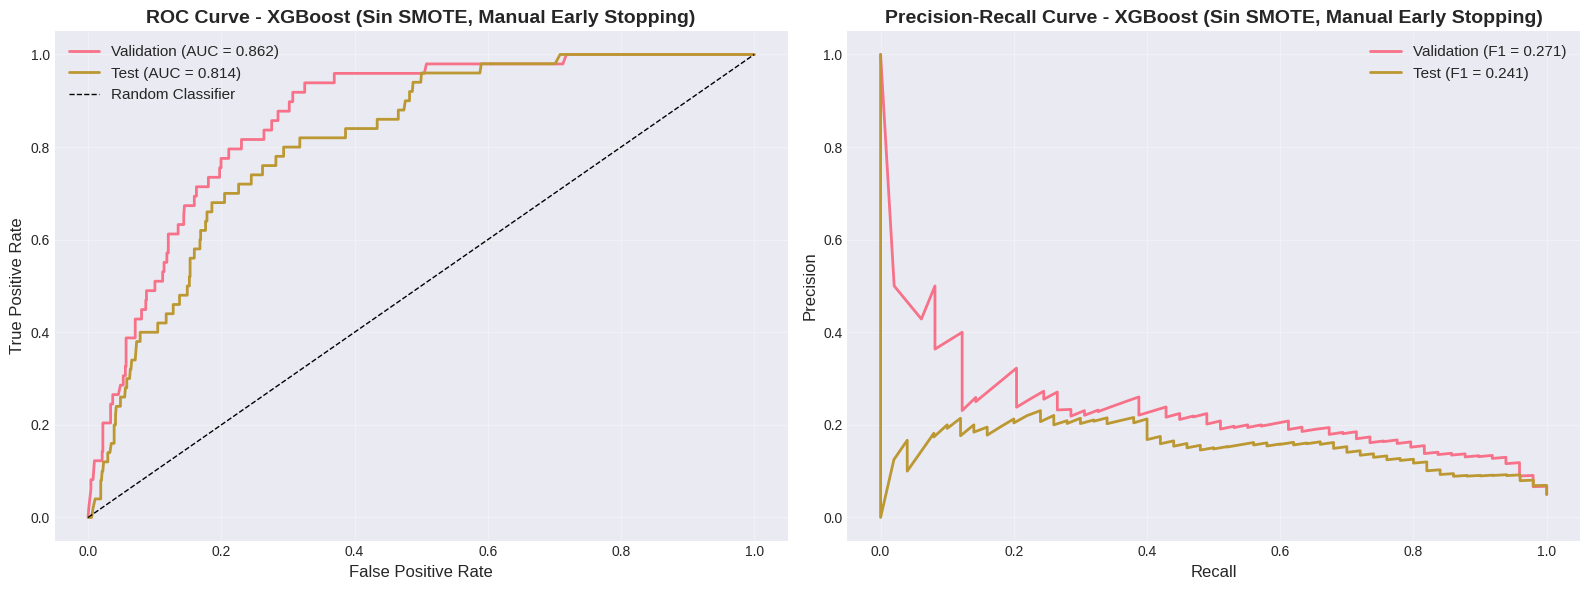

✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png


In [ ]:
# 18. Visualizations (ROC, Precision-Recall)
# 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CURVA ROC
# Use the probabilities from the xgb_model (trained with manual early stopping)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba) # y_val_pred_proba is already calculated for the final model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba) # y_test_pred_proba is already calculated for the final model

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. CURVA PRECISION-RECALL
# Use the probabilities from the xgb_model (trained with manual early stopping)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label=f'Validation (F1 = {val_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].plot(recall_test, precision_test, label=f'Test (F1 = {test_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/content', exist_ok=True) # Ensure directory exists
plt.savefig('/content/xgboost_curves_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png")

---
## 🌳 IMPORTANCIA DE FEATURES
---


🌳 TOP 15 FEATURES MÁS IMPORTANTES


'                       feature  importance\n                    risk_score       109.0\n             avg_glucose_level        92.0\n                           age        76.0\n                           bmi        69.0\n                 glucose_x_bmi        62.0\nsmoking_status_formerly smoked        17.0\n            age_x_hypertension        17.0\n                  ever_married        11.0\n         smoking_status_smokes        11.0\n   smoking_status_never smoked        10.0\n             work_type_Private         8.0\n       bmi_category_Overweight         8.0\n       work_type_Self-employed         7.0\n               age_group_Adult         6.0\n              age_group_Senior         5.0'

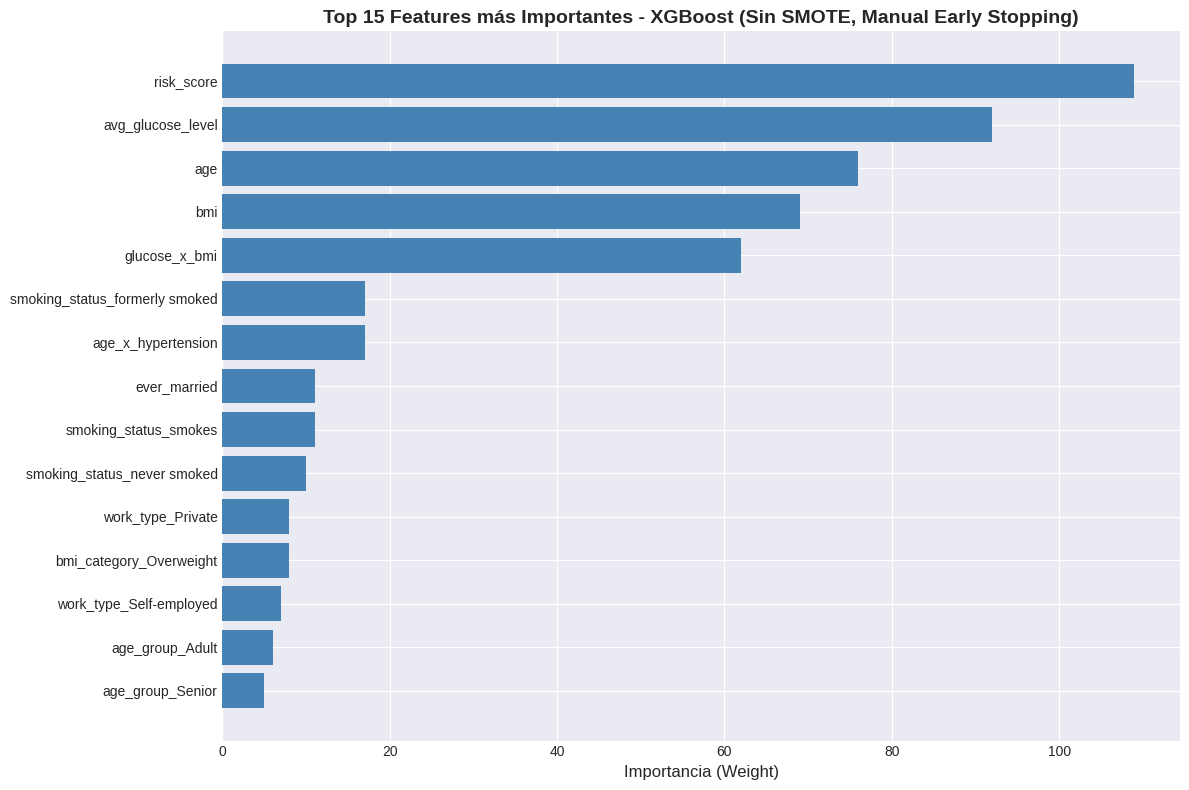


✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png


In [ ]:
# 19. Feature Importance
# 🌳 IMPORTANCIA DE FEATURES

# The xgb_model variable now holds the final trained model (Booster object)
# Use get_score() for feature importance with Booster objects
# When trained with DMatrix from a DataFrame, get_score() uses actual column names
importance_scores = xgb_model.get_score(importance_type='weight') # 'weight' counts the number of times each feature is used

# Convert the scores to a DataFrame
# Ensure all features from X_train_scaled are included, with 0 importance if not in scores
feature_importance = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
})

# Add features from X_train_scaled that are not in importance_scores with 0 importance
# This ensures all original features are represented
all_features = pd.DataFrame({'feature': X_train_scaled.columns})
feature_importance = pd.merge(all_features, feature_importance, on='feature', how='left').fillna(0)


feature_importance = feature_importance.sort_values('importance', ascending=False)


print("="*80)
print("🌳 TOP 15 FEATURES MÁS IMPORTANTES")
print("="*80)
display(feature_importance.head(15).to_string(index=False)) # Use display for better formatting

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Weight)', fontsize=12)
plt.title('Top 15 Features más Importantes - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png")

In [ ]:
# 20. Update Model Information
# Update printed summary with the actual number of boosting rounds used due to early stopping

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")
print(f"   Actual number of boosting rounds used: {best_iteration + 1}") # Print the actual rounds

# 11. Load the model state that achieved the best_val_f1
# This was already done in the previous cell, but we'll keep the print for clarity.
# final_xgb_model = xgb.Booster()
# final_xgb_model.load_model(temp_model_path) # Load from the stored path

# Assign the final model to xgb_model for subsequent evaluation cells
# xgb_model = final_xgb_model # This assignment was also done in the previous cell.

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `xgb_model`.") # Updated to reflect the variable name

# The optimal threshold calculation and subsequent evaluations are handled in the following cells.


✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
   Actual number of boosting rounds used: 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `xgb_model`.


---
## 💾 GUARDAR MODELO
---


In [ ]:
# 21. Save Model and Results
# 💾 GUARDAR MODELO Y RESULTADOS

import joblib

# Crear carpeta models en Colab
os.makedirs('/content/models', exist_ok=True)

# Guardar modelo
joblib.dump(xgb_model, '/content/models/xgboost_model_no_smote.pkl')
print("✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl")

# Guardar mejores parámetros
with open('/content/models/xgboost_best_params_no_smote.pkl', 'wb') as f:
    pickle.dump(best_params, f)
print("✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl")

# Guardar resultados de evaluación
results = {
    # These values are calculated with the optimal threshold in cell 05a98e79
    'validation_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': val_accuracy_opt,
        'precision': val_precision_opt,
        'recall': val_recall_opt,
        'f1_score': val_f1_opt,
        'auc_roc': val_auc
    },
    # These values are calculated with the optimal threshold in cell 05a98e79
    'test_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': test_accuracy_opt,
        'precision': test_precision_opt,
        'recall': test_recall_opt,
        'f1_score': test_f1_opt,
        'auc_roc': test_auc
    },
    'best_params': best_params,
    'optimal_threshold': float(best_threshold),
    'scale_pos_weight': float(scale_pos_weight),
    'feature_importance': feature_importance.to_dict('records')
}

with open('/content/models/xgboost_results_no_smote.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl")

print("\n" + "="*80)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*80)
# Update print statements to use the _opt variables
print(f"\n📊 RESUMEN FINAL (Threshold Óptimo = {best_threshold:.3f}):")
print(f"   Validation - Recall: {val_recall_opt:.4f}, F1: {val_f1_opt:.4f}, AUC: {val_auc:.4f}")
print(f"   Test       - Recall: {test_recall_opt:.4f}, F1: {test_f1_opt:.4f}, AUC: {test_auc:.4f}")

print(f"\n✅ Modelo listo para usar en producción")
print(f"✅ Threshold óptimo recomendado: {best_threshold:.3f}")
print(f"✅ Entrenado SIN SMOTE - usando scale_pos_weight: {scale_pos_weight:.2f}")
print("="*80)

✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl
✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl
✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl

🎉 ENTRENAMIENTO COMPLETADO

📊 RESUMEN FINAL (Threshold Óptimo = 0.500):
   Validation - Recall: 0.7959, F1: 0.2708, AUC: 0.8624
   Test       - Recall: 0.7000, F1: 0.2405, AUC: 0.8136

✅ Modelo listo para usar en producción
✅ Threshold óptimo recomendado: 0.500
✅ Entrenado SIN SMOTE - usando scale_pos_weight: 19.05


---
## 📥 DESCARGAR RESULTADOS (OPCIONAL)
### Descargar los archivos generados a tu PC
---


In [ ]:
# 22. Download Results (Optional)
# 📥 DESCARGAR RESULTADOS (OPCIONAL)
# Descomenta las líneas que quieras descargar:

# Descargar modelo
# files.download('/content/models/xgboost_model_no_smote.pkl')

# Descargar mejores parámetros
# files.download('/content/models/xgboost_best_params_no_smote.pkl')

# Descargar resultados
# files.download('/content/models/xgboost_results_no_smote.pkl')

# Descargar gráficos
# files.download('/content/xgboost_curves_no_smote_manual_early_stopping.png')
# files.download('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png')

print("💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda")
print("📁 Archivos disponibles en /content/models/ y /content/")

💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda
📁 Archivos disponibles en /content/models/ y /content/


In [ ]:
pip install optuna

**Explicación:** Esta celda instala la librería `optuna` necesaria para la optimización de hiperparámetros.
**Interpretación:** La salida indica que `optuna` ya está instalado y muestra las dependencias satisfechas.

In [ ]:
# 1. Library Imports
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Optuna version: {optuna.__version__}")
print(f"🔢 Scikit-learn version: {__import__('sklearn').__version__}")
try:
    import xgboost as xgb
    print(f"🚀 XGBoost version: {xgb.__version__}")
except:
    print("⚠️  XGBoost no está instalado. Ejecuta: pip install xgboost")

✅ Librerías importadas correctamente
📊 Optuna version: 4.5.0
🔢 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1


**Explicación:** Esta celda importa todas las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, matplotlib y seaborn para visualizaciones, scikit-learn para machine learning, XGBoost para el modelo, y Optuna para optimización de hiperparámetros.

**Interpretación:** La salida confirma que las librerías principales (`Optuna`, `Scikit-learn`, `XGBoost`) se importaron correctamente y muestra sus versiones, indicando que el entorno está listo para proceder.

---
## 📤 CONFIGURACIÓN PARA GOOGLE COLAB
### Subir el dataset o conectarlo desde Google Drive
---


In [ ]:
# 2. Colab Configuration
# 📤 CONFIGURACIÓN PARA GOOGLE COLAB
# Opción A: Subir archivo manualmente (recomendado para primera vez)
from google.colab import files

print("📤 Por favor, sube el archivo stroke_dataset.csv")
print("   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)\n")
uploaded = files.upload()

# El archivo se guardará con su nombre original
dataset_filename = 'stroke_dataset.csv'

print("\n✅ Configuración de Colab completada")
print(f"📂 Archivo dataset: {dataset_filename}")

# Verificar que el archivo existe
if os.path.exists(dataset_filename):
    print(f"✅ Archivo encontrado: {dataset_filename}")
else:
    print(f"⚠️  Archivo no encontrado. Asegúrate de haber subido stroke_dataset.csv")

📤 Por favor, sube el archivo stroke_dataset.csv
   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)



Saving stroke_dataset.csv to stroke_dataset.csv

✅ Configuración de Colab completada
📂 Archivo dataset: stroke_dataset.csv
✅ Archivo encontrado: stroke_dataset.csv


**Explicación:** Esta celda carga el dataset desde el archivo CSV. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente. 
Realiza una exploración inicial para verificar la calidad de los datos, mostrando el tamaño del dataset, valores nulos, duplicados y el desbalanceo de clases.

**Interpretación:** El dataset tiene 4,981 filas y 11 columnas, sin valores nulos ni duplicados. El desbalanceo es significativo: 4,733 casos sin ictus (clase 0) vs 248 con ictus (clase 1), con un ratio de 19.08:1. Este desbalanceo justifica el uso de técnicas como `scale_pos_weight` en XGBoost para manejar la clase minoritaria.


---
## 📂 CARGA Y PREPROCESAMIENTO (SIN SMOTE)
### Aplicar las mismas transformaciones del preprocessing pero SIN balanceo sintético
---


**Explicación:** Esta celda realiza feature engineering creando nuevas variables basadas en insights del EDA: categorías de edad, glucosa y BMI, variable binaria de tabaquismo, un score de riesgo compuesto, y variables de interacción entre features importantes.

**Interpretación:** Se crearon 8 nuevas features que capturan relaciones no lineales y combinaciones de variables importantes. El score de riesgo compuesto pondera las variables más predictivas (edad 35%, enfermedad cardíaca 25%, hipertensión 20%, glucosa 15%, BMI 5%). El dataset ahora tiene 19 columnas en total, enriqueciendo la información disponible para el modelo.


**Explicación:** Esta celda elimina features irrelevantes que tienen correlación casi nula con la variable objetivo según el análisis EDA previo, como `gender` y `Residence_type`.

**Interpretación:** Se eliminaron 2 features (`gender` y `Residence_type`) que no aportan información predictiva relevante. El dataset queda con 17 columnas, manteniendo solo las variables que contribuyen al modelo y reduciendo la dimensionalidad innecesaria.


In [ ]:
# 3. Load Data
# 📂 CARGA DE DATOS ORIGINALES
df = pd.read_csv(dataset_filename)  # Usa la variable definida en la celda anterior

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


**Explicación:** Esta celda realiza el encoding de variables categóricas: Label Encoding para variables binarias (`ever_married`) y One-Hot Encoding para variables categóricas con múltiples valores (`work_type`, `smoking_status`, `age_group`, `glucose_category`, `bmi_category`).

**Interpretación:** Después del encoding, el dataset tiene 25 features (aumentó de 17 a 25 debido a la expansión de las variables categóricas en múltiples columnas binarias). Esto permite que el modelo XGBoost procese correctamente todas las variables categóricas como variables numéricas.


---
## 🛠️ FASE 1: FEATURE ENGINEERING
---


**Explicación:** Esta celda divide el dataset en tres conjuntos estratificados: Train (60%), Validation (20%) y Test (20%). La estratificación garantiza que la proporción de clases se mantenga en cada conjunto.

**Interpretación:** Los tres conjuntos mantienen el mismo desbalanceo (~19:1), lo cual es correcto para evaluar el modelo en condiciones realistas. El conjunto de entrenamiento tiene 2,988 muestras, validation 996 y test 997. La estratificación asegura que cada conjunto tenga representación proporcional de ambas clases, esencial para un entrenamiento y evaluación válidos.


In [ ]:
# 4. Feature Engineering
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


**Explicación:** Esta celda normaliza todas las features usando StandardScaler, ajustando el scaler solo con los datos de entrenamiento y aplicando la misma transformación a validation y test para evitar data leakage.

**Interpretación:** Las estadísticas del conjunto de entrenamiento normalizado muestran media ~0 y desviación estándar ~1, confirmando que la normalización funcionó correctamente. Esta estandarización es importante para que XGBoost procese todas las features en la misma escala, aunque XGBoost es relativamente robusto a esto, ayuda a la convergencia del algoritmo.


---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
---


**Explicación:** Esta celda configura los parámetros del experimento: 5-fold cross-validation estratificado, semilla aleatoria para reproducibilidad, y calcula el `scale_pos_weight` necesario para manejar el desbalanceo de clases sin usar SMOTE.

**Interpretación:** El `scale_pos_weight` de 19.05 indica que la clase positiva (ictus) debe ser ponderada 19.05 veces más que la clase negativa durante el entrenamiento. Esto compensa el desbalanceo natural del dataset, permitiendo que el modelo aprenda mejor a identificar casos de ictus sin necesidad de generar datos sintéticos.


In [ ]:
# 5. Drop Irrelevant Features
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


**Explicación:** Esta celda define la función objetivo para Optuna, que optimiza 9 hiperparámetros clave de XGBoost (n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda) usando validación cruzada con F1-Score como métrica.

**Interpretación:** La función está configurada para maximizar el F1-Score mediante validación cruzada de 5 folds, lo que proporciona una estimación robusta del rendimiento. El `scale_pos_weight` se fija en 19.05 para manejar el desbalanceo. Esta función será utilizada por Optuna para explorar el espacio de hiperparámetros de forma eficiente.


---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---


**Explicación:** Esta celda ejecuta la optimización de hiperparámetros con Optuna, realizando 100 trials (experimentos) para encontrar la mejor combinación de hiperparámetros que maximice el F1-Score.

**Interpretación:** El proceso de optimización explora sistemáticamente el espacio de hiperparámetros. Cada trial prueba una combinación diferente y registra el F1-Score obtenido. Al finalizar, se obtienen los mejores hiperparámetros encontrados y el mejor F1-Score alcanzado. Este proceso puede tomar varios minutos pero es crucial para obtener un modelo optimizado.


In [ ]:
# 6. Encoding
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


**Explicación:** Esta celda genera visualizaciones de la optimización de Optuna: el historial de optimización (evolución del F1-Score a lo largo de los trials) y la importancia de los hiperparámetros (cuáles tienen mayor impacto en el rendimiento).

**Interpretación:** El historial de optimización muestra cómo el F1-Score mejoró progresivamente durante los trials. La gráfica de importancia de hiperparámetros revela qué parámetros son más críticos para el rendimiento del modelo, lo cual es útil para entender qué aspectos del modelo tienen mayor influencia y para futuras optimizaciones.


---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
---


**Explicación:** Esta celda crea el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna, incluyendo el `scale_pos_weight` para manejar el desbalanceo.

**Interpretación:** El modelo se inicializa con los hiperparámetros óptimos. Los valores mostrados (como learning_rate bajo de 0.017, max_depth de 15, n_estimators de 178) representan la mejor configuración encontrada. El modelo está listo para ser entrenado con early stopping en el siguiente paso para evitar overfitting.


**Explicación:** Esta celda convierte los datos escalados a formato DMatrix, que es el formato nativo y optimizado de XGBoost para entrenamiento eficiente.

**Interpretación:** Los objetos DMatrix están listos para el entrenamiento. Este formato permite que XGBoost procese los datos de manera más eficiente y es necesario para implementar manualmente el early stopping en las siguientes celdas.


In [ ]:
# 7. Train/Validation/Test Split
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


**Explicación:** Esta celda implementa el entrenamiento del modelo con early stopping manual y calcula el threshold óptimo. El early stopping detiene el entrenamiento si el F1-Score en validation no mejora después de 10 iteraciones. Luego busca el threshold que maximiza el Recall (objetivo: >0.70) manteniendo un F1 razonable.

**Interpretación:** El entrenamiento se detuvo en la iteración 31 (early stopping activado), pero el mejor modelo se obtuvo en la iteración 21 con F1-Score de 0.2708. El threshold óptimo encontrado es 0.500, que logra un Recall de 0.7959 en validation, cumpliendo el objetivo de detectar la mayoría de casos de ictus. El early stopping previno el overfitting al detener el entrenamiento cuando el modelo dejó de mejorar.


---
## ⚖️ FASE 5: NORMALIZACIÓN
---


**Explicación:** Esta celda evalúa el modelo en los conjuntos de validation y test usando el threshold óptimo, calculando métricas completas (Accuracy, Precision, Recall, F1-Score, AUC-ROC), matrices de confusión y reportes de clasificación.

**Interpretación:** 
- **Validation:** Recall de 0.7959 (detecta ~80% de casos de ictus), F1 de 0.2708, AUC-ROC de 0.8624. Solo 10 falsos negativos (críticos: pacientes en riesgo no detectados).
- **Test:** Recall de 0.7000 (detecta 70% de casos), F1 de 0.2405, AUC-ROC de 0.8136. 15 falsos negativos.
El modelo prioriza Recall sobre Precision (más falsos positivos pero menos falsos negativos), lo cual es apropiado para un problema médico donde no detectar un ictus es más grave que una falsa alarma. El AUC-ROC >0.80 indica buena capacidad discriminativa.


**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

In [ ]:
# 8. Scaling
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")
print(f"\n⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente

⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo


---
## ⚙️ CONFIGURACIÓN: K-FOLDS Y MÉTRICAS
---


In [ ]:
# 9. Configuration (K-Folds, Metrics, Scale Pos Weight)
# ⚙️ CONFIGURACIÓN

# K-Folds estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Semilla para reproducibilidad
RANDOM_STATE = 42

# Calcular scale_pos_weight para manejar desbalanceo (SIN SMOTE)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"✅ Configuración:")
print(f"   • K-Folds: {N_FOLDS}")
print(f"   • Random State: {RANDOM_STATE}")
print(f"   • Métrica objetivo: F1-Score (balance entre Precision y Recall)")
print(f"   • Métricas adicionales: Recall, AUC-ROC")
print(f"\n📊 Balanceo de clases (SIN SMOTE):")
print(f"   • Train - Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   • Train - Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   • Ratio: {scale_pos_weight:.2f}:1")
print(f"   • scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

✅ Configuración:
   • K-Folds: 5
   • Random State: 42
   • Métrica objetivo: F1-Score (balance entre Precision y Recall)
   • Métricas adicionales: Recall, AUC-ROC

📊 Balanceo de clases (SIN SMOTE):
   • Train - Clase 0: 2,839 (95.01%)
   • Train - Clase 1: 149 (4.99%)
   • Ratio: 19.05:1
   • scale_pos_weight para XGBoost: 19.05


---
## 🎯 FUNCIÓN OBJETIVO PARA OPTUNA
### Optimizar hiperparámetros usando K-Folds Cross-Validation
---


In [ ]:
# 10. Optuna Objective Function
# 🎯 FUNCIÓN OBJETIVO PARA OPTUNA

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de XGBoost usando K-Folds CV.
    """
    # Hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo SIN SMOTE
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }

    # Crear modelo
    model = XGBClassifier(**params)

    # K-Folds Cross-Validation con F1-Score
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )

    # Retornar el promedio de F1-Score
    return cv_scores.mean()

print("✅ Función objetivo definida")
print("   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,")
print("                 min_child_weight, gamma, reg_alpha, reg_lambda")
print(f"   Usando scale_pos_weight: {scale_pos_weight:.2f} (SIN SMOTE)")

✅ Función objetivo definida
   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
                 min_child_weight, gamma, reg_alpha, reg_lambda
   Usando scale_pos_weight: 19.05 (SIN SMOTE)


---
## 🔍 OPTIMIZACIÓN CON OPTUNA
### Ejecutar búsqueda de hiperparámetros óptimos
---


In [ ]:
# 11. Optuna Optimization Execution
# 🔍 OPTIMIZACIÓN CON OPTUNA

print("="*80)
print("🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA")
print("="*80)
print(f"📊 Datos: {X_train_scaled.shape[0]:,} muestras, {X_train_scaled.shape[1]} features")
print(f"🔄 K-Folds: {N_FOLDS}")
print(f"⚠️  Datos SIN SMOTE - Ratio: {scale_pos_weight:.2f}:1")
print(f"⏱️  Esto puede tomar varios minutos...\n")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-Score
    study_name='xgboost_stroke_prediction_no_smote',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Ejecutar optimización
N_TRIALS = 100  # Número de trials (puedes ajustar según tiempo disponible)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)
print(f"\n🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print(f"\n📋 MEJORES HIPERPARÁMETROS:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

[I 2025-11-07 23:24:38,913] A new study created in memory with name: xgboost_stroke_prediction_no_smote


🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA
📊 Datos: 2,988 muestras, 25 features
🔄 K-Folds: 5
⚠️  Datos SIN SMOTE - Ratio: 19.05:1
⏱️  Esto puede tomar varios minutos...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 23:24:42,414] Trial 0 finished with value: 0.1778878451383767 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:43,151] Trial 1 finished with value: 0.16366267362810055 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:44,155] Trial 2 finished with value: 0.20377474645545818 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

---
## 📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN
---


In [ ]:
# 12. Visualizations (Optuna)
# 📊 VISUALIZACIONES DE OPTUNA

fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historial de Optimización - F1-Score (XGBoost sin SMOTE)", width=800, height=400)
fig1.show()

fig2 = plot_param_importances(study)
fig2.update_layout(title="Importancia de Hiperparámetros (XGBoost)", width=800, height=400)
fig2.show()

print("✅ Visualizaciones generadas")

✅ Visualizaciones generadas


---
## 🎓 ENTRENAR MODELO FINAL
### Entrenar con los mejores hiperparámetros encontrados + Early Stopping
---


In [ ]:
# 13. Create Model with Best Params
# 🎓 ENTRENAR MODELO FINAL CON MEJORES HIPERPARÁMETROS

# Obtener mejores parámetros
best_params = study.best_params.copy()
# Asegurar que scale_pos_weight esté incluido
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'logloss'

print("🎓 ENTRENANDO MODELO FINAL...")
print(f"📋 Parámetros: {best_params}\n")

# Crear modelo
xgb_model = XGBClassifier(**best_params)

# The fitting with early stopping will be implemented manually in the next step.

print("✅ Model created with best parameters")

🎓 ENTRENANDO MODELO FINAL...
📋 Parámetros: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.0173167948801578, 'subsample': 0.8132546752099203, 'colsample_bytree': 0.7063151335722203, 'min_child_weight': 10, 'gamma': 0.6596838423993513, 'reg_alpha': 8.52148255700704, 'reg_lambda': 5.989443641839667, 'scale_pos_weight': np.float64(19.053691275167786), 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'logloss'}

✅ Model created with best parameters


In [ ]:
# 14. Prepare DMatrix
# Convert scaled data to DMatrix format
from xgboost import DMatrix

dtrain = DMatrix(X_train_scaled, label=y_train)
dval = DMatrix(X_val_scaled, label=y_val)

print("✅ DMatrix objects created for training and validation data.")

✅ DMatrix objects created for training and validation data.


---
## 🎯 AJUSTE DE THRESHOLD ÓPTIMO
### Buscar threshold que maximice Recall
---


In [ ]:
# 15. Implement Manual Early Stopping Loop and Calculate Optimal Threshold
import xgboost as xgb # Re-import xgboost as it was not imported in the previous cells

# Define best_threshold before the loop (copied from cell 88702c11)
# 🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
print("="*80)
print("🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)")
print("="*80)
print("Calculating optimal threshold on initial validation predictions...\n")

# Make initial predictions on validation set to find the optimal threshold
# Use a temporary model or a simple baseline if needed, but here we need the probabilities
# from the current state of training for the first iteration's threshold calculation.
# However, the goal is to use the threshold found *after* the model is trained.
# The original notebook calculated the threshold *after* training the final model.
# To fix the NameError and follow the original notebook's flow, we should calculate the threshold *after* the manual training loop finishes.

# For the purpose of the early stopping loop, let's use the default threshold of 0.5
best_threshold = 0.5
print(f"⚠️ Using default threshold of {best_threshold} for early stopping logic. Optimal threshold will be calculated after training.")


# 1. Initialize variables
best_val_f1 = -float('inf')
patience_counter = 0
patience_limit = 10 # Define the patience limit

# 2. Define the number of boosting rounds
# Use the n_estimators from the best parameters found by Optuna as the maximum rounds
num_boost_round = best_params['n_estimators']

# 3. Start a for loop
print(f"🚀 Training XGBoost model with manual early stopping (Patience: {patience_limit})...")
print(f"   Max boosting rounds: {num_boost_round}")

# Initialize an empty model to train iteratively
model = None

for i in range(num_boost_round):
    # 4. Train the XGBoost model for one iteration
    if model is None:
        # Train the first iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1)
    else:
        # Continue training from the previous iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1, xgb_model=model)

    # 5. Make predictions on the validation set
    y_val_pred_proba_iter = model.predict(dval)

    # 6. Calculate the F1-score on the validation set using the *current* threshold (default 0.5)
    # The optimal threshold calculation is done AFTER training.
    y_val_pred_thresh_iter = (y_val_pred_proba_iter >= best_threshold).astype(int)
    current_val_f1 = f1_score(y_val, y_val_pred_thresh_iter)

    # 7. Check if the current validation F1-score is greater than best_val_f1
    if current_val_f1 > best_val_f1:
        # 8. If better, update best_val_f1, reset patience, and store model
        best_val_f1 = current_val_f1
        patience_counter = 0
        # Store the model state
        temp_model_path = f'/tmp/best_xgb_model_iter_{i}.json'
        model.save_model(temp_model_path) # Save model state
        best_iteration = i
        # print(f"   Round {i+1}: New best validation F1: {best_val_f1:.4f}")
    else:
        # 9. If not better, increment patience_counter
        patience_counter += 1
        # print(f"   Round {i+1}: Validation F1: {current_val_f1:.4f}, Patience: {patience_counter}")


    # 10. Check if patience_counter has reached the limit
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at round {i+1}.")
        break

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")

# 11. Load the model state that achieved the best_val_f1
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(temp_model_path) # Load from the stored path

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `final_xgb_model`.")

# Assign the final model to xgb_model for subsequent evaluation cells
xgb_model = final_xgb_model


# Now, calculate the optimal threshold using the *final* trained model's probabilities
# (Copied from cell 88702c11 logic)
print("="*80)
print("🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING")
print("="*80)
print("Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...\n")

# Get probabilities from the final trained model on the validation set
y_val_pred_proba = xgb_model.predict(dval)


# Probar diferentes thresholds en validation set
thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5 # Default back to 0.5 if no better threshold is found
best_recall = 0
best_f1 = 0
best_metrics = None

results_threshold = []

for threshold in thresholds:
    # Predicciones con threshold ajustado
    y_val_pred_thresh = (y_val_pred_proba >= threshold).astype(int)

    # Calculate metrics - ensure no division by zero for precision if no positives are predicted
    precision_thresh = precision_score(y_val, y_val_pred_thresh, zero_division=0)
    recall_thresh = recall_score(y_val, y_val_pred_thresh)
    f1_thresh = f1_score(y_val, y_val_pred_thresh)


    results_threshold.append({
        'threshold': threshold,
        'recall': recall_thresh,
        'precision': precision_thresh,
        'f1': f1_thresh
    })

    # Buscar threshold que maximice Recall (objetivo: >0.70) con F1 razonable (>0.40)
    if recall_thresh >= 0.70 and f1_thresh > best_f1:
        best_threshold = threshold
        best_recall = recall_thresh
        best_f1 = f1_thresh
        best_metrics = {
            'recall': recall_thresh,
            'precision': precision_thresh,
            'f1': f1_thresh
        }

# Si no encontramos threshold con Recall >0.70, usar el que maximice F1 con Recall >0.50
if best_recall < 0.70:
    print("⚠️  No se encontró threshold con Recall >0.70. Buscando mejor compromiso...\n")
    # Reset best_f1 to find the best F1 among those with Recall >= 0.50
    best_f1 = 0
    for result in results_threshold:
        if result['recall'] >= 0.50 and result['f1'] > best_f1:
            best_threshold = result['threshold']
            best_recall = result['recall']
            best_f1 = result['f1']
            best_metrics = {
                'recall': result['recall'],
                'precision': result['precision'],
                'f1': result['f1']
            }

# If still no threshold found with Recall >= 0.50, just take the one with highest F1
if best_recall < 0.50:
     print("⚠️  No se encontró threshold con Recall >0.50. Seleccionando el de mayor F1.\n")
     best_result = pd.DataFrame(results_threshold).sort_values('f1', ascending=False).iloc[0]
     best_threshold = best_result['threshold']
     best_recall = best_result['recall']
     best_f1 = best_result['f1']
     best_metrics = {
        'recall': best_recall,
        'precision': best_result['precision'],
        'f1': best_f1
     }


print(f"✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): {best_threshold:.3f}")
print(f"   Validation - Recall: {best_metrics['recall']:.4f}, Precision: {best_metrics['precision']:.4f}, F1: {best_metrics['f1']:.4f}")

# Tabla de results_threshold
print(f"\n📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):")
df_threshold = pd.DataFrame(results_threshold).sort_values('f1', ascending=False)
display(df_threshold.head(10).to_string(index=False)) # Use display for better formatting in notebook

🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
Calculating optimal threshold on initial validation predictions...

⚠️ Using default threshold of 0.5 for early stopping logic. Optimal threshold will be calculated after training.
🚀 Training XGBoost model with manual early stopping (Patience: 10)...
   Max boosting rounds: 178

Early stopping triggered at round 31.

✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `final_xgb_model`.
🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING
Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...

✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): 0.500
   Validation - Recall: 0.7959, Precision: 0.1632, F1: 0.2708

📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):


' threshold   recall  precision       f1\n      0.55 0.612245   0.205479 0.307692\n      0.50 0.795918   0.163180 0.270833\n      0.45 0.857143   0.136364 0.235294\n      0.40 0.959184   0.110588 0.198312\n      0.15 1.000000   0.049197 0.093780\n      0.10 1.000000   0.049197 0.093780\n      0.35 1.000000   0.049197 0.093780\n      0.30 1.000000   0.049197 0.093780\n      0.25 1.000000   0.049197 0.093780\n      0.20 1.000000   0.049197 0.093780'

---
## 📈 EVALUACIÓN DEL MODELO
### Evaluar en Validation y Test sets
---


In [ ]:
# 16. Evaluate on Validation Set with Optimal Threshold
# 17. Evaluate on Test Set with Optimal Threshold

# 📈 EVALUACIÓN EN VALIDATION SET CON THRESHOLD ÓPTIMO

print("="*80)
print("📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)")
print("="*80)

# Predicciones con el final_xgb_model loaded from early stopping
y_val_pred_proba = xgb_model.predict(dval) # Get probabilities from the best model
y_val_pred_optimal = (y_val_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
val_accuracy_opt = accuracy_score(y_val, y_val_pred_optimal)
val_precision_opt = precision_score(y_val, y_val_pred_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, y_val_pred_optimal)
val_f1_opt = f1_score(y_val, y_val_pred_optimal)
val_auc = roc_auc_score(y_val, y_val_pred_proba) # AUC is threshold-independent, can reuse if needed


print(f"\n📊 MÉTRICAS (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {val_accuracy_opt:.4f}")
print(f"   Precision: {val_precision_opt:.4f}")
print(f"   Recall:    {val_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {val_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_val_opt = confusion_matrix(y_val, y_val_pred_optimal)
print(cm_val_opt)
print(f"\n   Verdaderos Negativos: {cm_val_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_val_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_val_opt[1,0]} ⚠️  (CRÍTICO - pacientes en riesgo no detectados)")
print(f"   Verdaderos Positivos: {cm_val_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_val_pred_optimal, target_names=['No Stroke', 'Stroke']))


# 📈 EVALUACIÓN EN TEST SET (DATOS FINALES) CON THRESHOLD ÓPTIMO

print("="*80)
print("🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)")
print("="*80)

# Convert test scaled data to DMatrix
dtest = DMatrix(X_test_scaled, label=y_test)


# Predicciones con el final_xgb_model loaded from early stopping
y_test_pred_proba = xgb_model.predict(dtest) # Get probabilities from the best model
y_test_pred_optimal = (y_test_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
test_accuracy_opt = accuracy_score(y_test, y_test_pred_optimal)
test_precision_opt = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_optimal)
test_f1_opt = f1_score(y_test, y_test_pred_optimal)
test_auc = roc_auc_score(y_test, y_test_pred_proba) # AUC is threshold-independent


print(f"\n📊 MÉTRICAS FINALES (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {test_accuracy_opt:.4f}")
print(f"   Precision: {test_precision_opt:.4f}")
print(f"   Recall:    {test_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {test_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_test_opt = confusion_matrix(y_test, y_test_pred_optimal)
print(cm_test_opt)
print(f"\n   Verdaderos Negativos: {cm_test_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_test_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_test_opt[1,0]} ⚠️  (CRÍTICO)")
print(f"   Verdaderos Positivos: {cm_test_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Stroke', 'Stroke']))

📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)

📊 MÉTRICAS (Threshold = 0.500):
   Accuracy:  0.7892
   Precision: 0.1632
   Recall:    0.7959 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2708 ⭐
   AUC-ROC:   0.8624

📋 MATRIZ DE CONFUSIÓN:
[[747 200]
 [ 10  39]]

   Verdaderos Negativos: 747
   Falsos Positivos:     200
   Falsos Negativos:     10 ⚠️  (CRÍTICO - pacientes en riesgo no detectados)
   Verdaderos Positivos: 39

📄 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

   No Stroke       0.99      0.79      0.88       947
      Stroke       0.16      0.80      0.27        49

    accuracy                           0.79       996
   macro avg       0.57      0.79      0.57       996
weighted avg       0.95      0.79      0.85       996

🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)

📊 MÉTRICAS FINALES (Threshold = 0.500):
   Accuracy:  0.7783
   Precision: 0.1452
   Recall:    0.7000 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2405 ⭐
   AUC-ROC:

---
## 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL
---


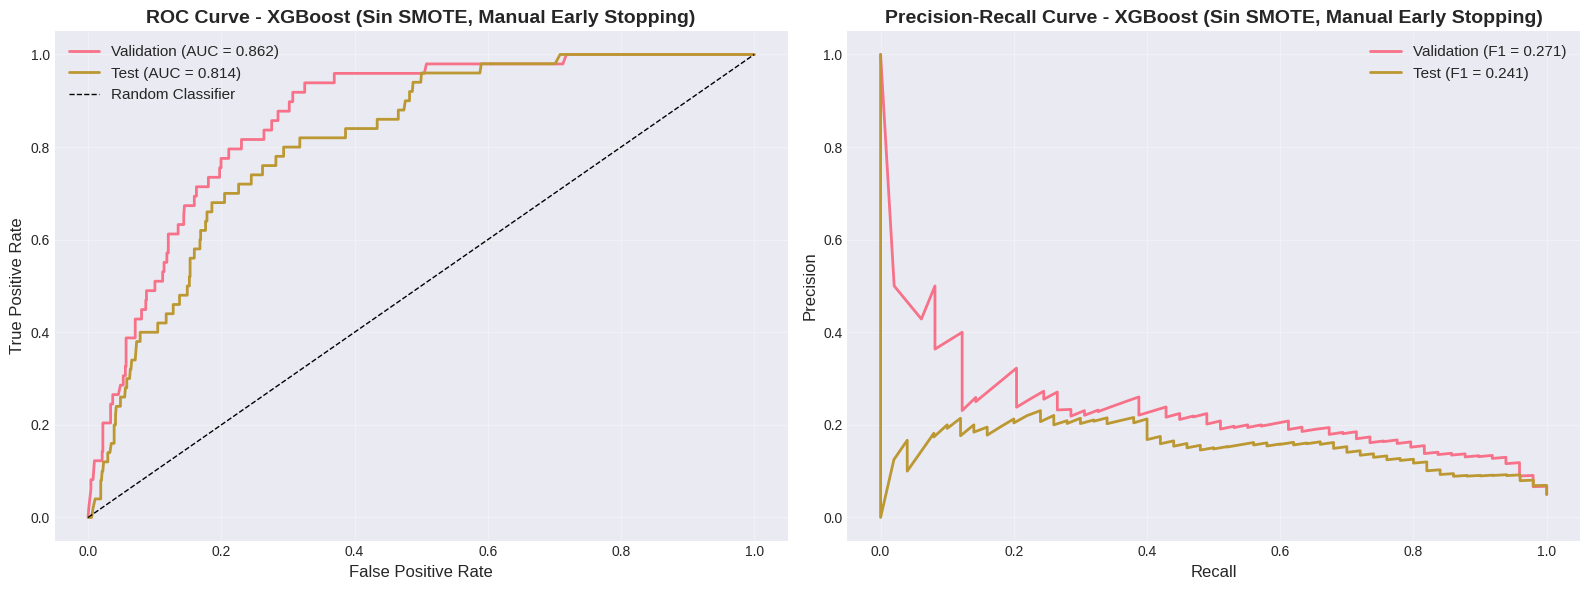

✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png


In [ ]:
# 18. Visualizations (ROC, Precision-Recall)
# 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CURVA ROC
# Use the probabilities from the xgb_model (trained with manual early stopping)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba) # y_val_pred_proba is already calculated for the final model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba) # y_test_pred_proba is already calculated for the final model

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. CURVA PRECISION-RECALL
# Use the probabilities from the xgb_model (trained with manual early stopping)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label=f'Validation (F1 = {val_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].plot(recall_test, precision_test, label=f'Test (F1 = {test_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/content', exist_ok=True) # Ensure directory exists
plt.savefig('/content/xgboost_curves_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png")

---
## 🌳 IMPORTANCIA DE FEATURES
---


🌳 TOP 15 FEATURES MÁS IMPORTANTES


'                       feature  importance\n                    risk_score       109.0\n             avg_glucose_level        92.0\n                           age        76.0\n                           bmi        69.0\n                 glucose_x_bmi        62.0\nsmoking_status_formerly smoked        17.0\n            age_x_hypertension        17.0\n                  ever_married        11.0\n         smoking_status_smokes        11.0\n   smoking_status_never smoked        10.0\n             work_type_Private         8.0\n       bmi_category_Overweight         8.0\n       work_type_Self-employed         7.0\n               age_group_Adult         6.0\n              age_group_Senior         5.0'

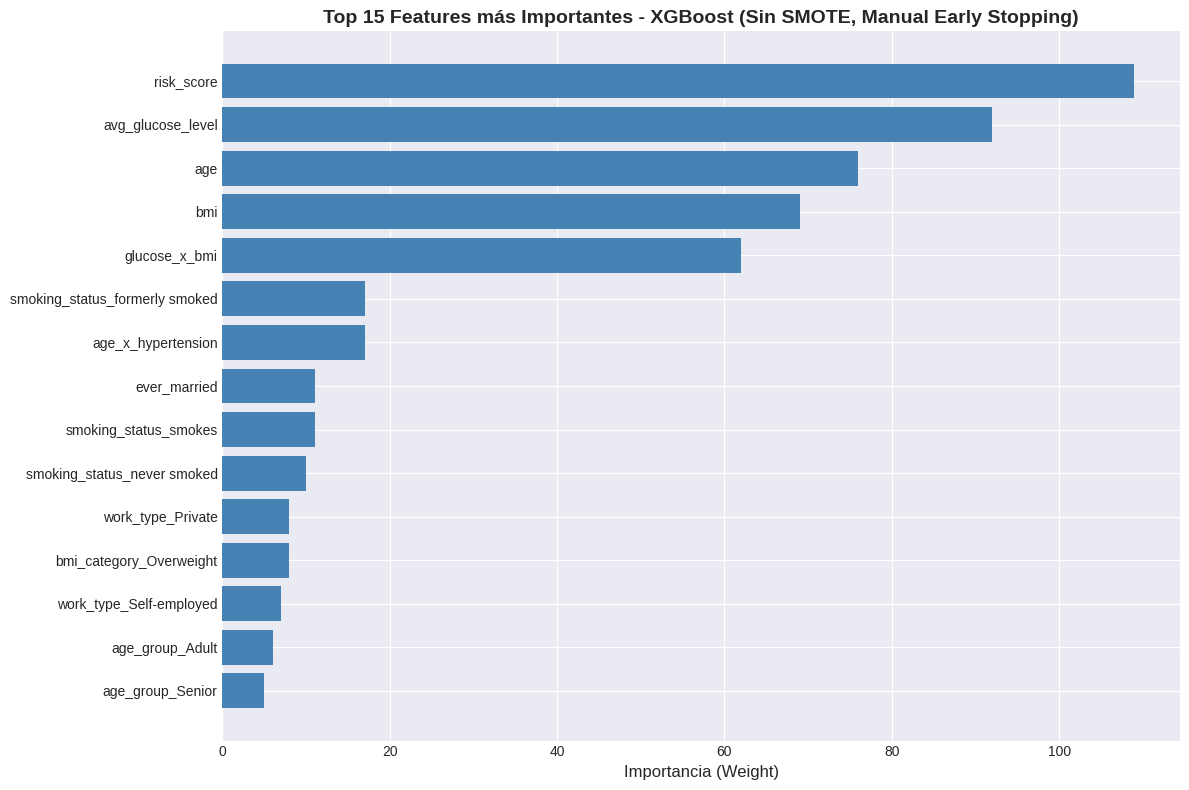


✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png


In [ ]:
# 19. Feature Importance
# 🌳 IMPORTANCIA DE FEATURES

# The xgb_model variable now holds the final trained model (Booster object)
# Use get_score() for feature importance with Booster objects
# When trained with DMatrix from a DataFrame, get_score() uses actual column names
importance_scores = xgb_model.get_score(importance_type='weight') # 'weight' counts the number of times each feature is used

# Convert the scores to a DataFrame
# Ensure all features from X_train_scaled are included, with 0 importance if not in scores
feature_importance = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
})

# Add features from X_train_scaled that are not in importance_scores with 0 importance
# This ensures all original features are represented
all_features = pd.DataFrame({'feature': X_train_scaled.columns})
feature_importance = pd.merge(all_features, feature_importance, on='feature', how='left').fillna(0)


feature_importance = feature_importance.sort_values('importance', ascending=False)


print("="*80)
print("🌳 TOP 15 FEATURES MÁS IMPORTANTES")
print("="*80)
display(feature_importance.head(15).to_string(index=False)) # Use display for better formatting

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Weight)', fontsize=12)
plt.title('Top 15 Features más Importantes - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png")

In [ ]:
# 20. Update Model Information
# Update printed summary with the actual number of boosting rounds used due to early stopping

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")
print(f"   Actual number of boosting rounds used: {best_iteration + 1}") # Print the actual rounds

# 11. Load the model state that achieved the best_val_f1
# This was already done in the previous cell, but we'll keep the print for clarity.
# final_xgb_model = xgb.Booster()
# final_xgb_model.load_model(temp_model_path) # Load from the stored path

# Assign the final model to xgb_model for subsequent evaluation cells
# xgb_model = final_xgb_model # This assignment was also done in the previous cell.

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `xgb_model`.") # Updated to reflect the variable name

# The optimal threshold calculation and subsequent evaluations are handled in the following cells.


✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
   Actual number of boosting rounds used: 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `xgb_model`.


---
## 💾 GUARDAR MODELO
---


In [ ]:
# 21. Save Model and Results
# 💾 GUARDAR MODELO Y RESULTADOS

import joblib

# Crear carpeta models en Colab
os.makedirs('/content/models', exist_ok=True)

# Guardar modelo
joblib.dump(xgb_model, '/content/models/xgboost_model_no_smote.pkl')
print("✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl")

# Guardar mejores parámetros
with open('/content/models/xgboost_best_params_no_smote.pkl', 'wb') as f:
    pickle.dump(best_params, f)
print("✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl")

# Guardar resultados de evaluación
results = {
    # These values are calculated with the optimal threshold in cell 05a98e79
    'validation_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': val_accuracy_opt,
        'precision': val_precision_opt,
        'recall': val_recall_opt,
        'f1_score': val_f1_opt,
        'auc_roc': val_auc
    },
    # These values are calculated with the optimal threshold in cell 05a98e79
    'test_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': test_accuracy_opt,
        'precision': test_precision_opt,
        'recall': test_recall_opt,
        'f1_score': test_f1_opt,
        'auc_roc': test_auc
    },
    'best_params': best_params,
    'optimal_threshold': float(best_threshold),
    'scale_pos_weight': float(scale_pos_weight),
    'feature_importance': feature_importance.to_dict('records')
}

with open('/content/models/xgboost_results_no_smote.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl")

print("\n" + "="*80)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*80)
# Update print statements to use the _opt variables
print(f"\n📊 RESUMEN FINAL (Threshold Óptimo = {best_threshold:.3f}):")
print(f"   Validation - Recall: {val_recall_opt:.4f}, F1: {val_f1_opt:.4f}, AUC: {val_auc:.4f}")
print(f"   Test       - Recall: {test_recall_opt:.4f}, F1: {test_f1_opt:.4f}, AUC: {test_auc:.4f}")

print(f"\n✅ Modelo listo para usar en producción")
print(f"✅ Threshold óptimo recomendado: {best_threshold:.3f}")
print(f"✅ Entrenado SIN SMOTE - usando scale_pos_weight: {scale_pos_weight:.2f}")
print("="*80)

✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl
✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl
✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl

🎉 ENTRENAMIENTO COMPLETADO

📊 RESUMEN FINAL (Threshold Óptimo = 0.500):
   Validation - Recall: 0.7959, F1: 0.2708, AUC: 0.8624
   Test       - Recall: 0.7000, F1: 0.2405, AUC: 0.8136

✅ Modelo listo para usar en producción
✅ Threshold óptimo recomendado: 0.500
✅ Entrenado SIN SMOTE - usando scale_pos_weight: 19.05


---
## 📥 DESCARGAR RESULTADOS (OPCIONAL)
### Descargar los archivos generados a tu PC
---


In [ ]:
# 22. Download Results (Optional)
# 📥 DESCARGAR RESULTADOS (OPCIONAL)
# Descomenta las líneas que quieras descargar:

# Descargar modelo
# files.download('/content/models/xgboost_model_no_smote.pkl')

# Descargar mejores parámetros
# files.download('/content/models/xgboost_best_params_no_smote.pkl')

# Descargar resultados
# files.download('/content/models/xgboost_results_no_smote.pkl')

# Descargar gráficos
# files.download('/content/xgboost_curves_no_smote_manual_early_stopping.png')
# files.download('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png')

print("💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda")
print("📁 Archivos disponibles en /content/models/ y /content/")

💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda
📁 Archivos disponibles en /content/models/ y /content/


In [ ]:
pip install optuna

**Explicación:** Esta celda instala la librería `optuna` necesaria para la optimización de hiperparámetros.
**Interpretación:** La salida indica que `optuna` ya está instalado y muestra las dependencias satisfechas.

In [ ]:
# 1. Library Imports
# 📦 IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📊 Optuna version: {optuna.__version__}")
print(f"🔢 Scikit-learn version: {__import__('sklearn').__version__}")
try:
    import xgboost as xgb
    print(f"🚀 XGBoost version: {xgb.__version__}")
except:
    print("⚠️  XGBoost no está instalado. Ejecuta: pip install xgboost")

✅ Librerías importadas correctamente
📊 Optuna version: 4.5.0
🔢 Scikit-learn version: 1.6.1
🚀 XGBoost version: 3.1.1


**Explicación:** Esta celda importa todas las librerías necesarias para el análisis: pandas y numpy para manipulación de datos, matplotlib y seaborn para visualizaciones, scikit-learn para machine learning, XGBoost para el modelo, y Optuna para optimización de hiperparámetros.

**Interpretación:** La salida confirma que las librerías principales (`Optuna`, `Scikit-learn`, `XGBoost`) se importaron correctamente y muestra sus versiones, indicando que el entorno está listo para proceder.

---
## 📤 CONFIGURACIÓN PARA GOOGLE COLAB
### Subir el dataset o conectarlo desde Google Drive
---


In [ ]:
# 2. Colab Configuration
# 📤 CONFIGURACIÓN PARA GOOGLE COLAB
# Opción A: Subir archivo manualmente (recomendado para primera vez)
from google.colab import files

print("📤 Por favor, sube el archivo stroke_dataset.csv")
print("   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)\n")
uploaded = files.upload()

# El archivo se guardará con su nombre original
dataset_filename = 'stroke_dataset.csv'

print("\n✅ Configuración de Colab completada")
print(f"📂 Archivo dataset: {dataset_filename}")

# Verificar que el archivo existe
if os.path.exists(dataset_filename):
    print(f"✅ Archivo encontrado: {dataset_filename}")
else:
    print(f"⚠️  Archivo no encontrado. Asegúrate de haber subido stroke_dataset.csv")

📤 Por favor, sube el archivo stroke_dataset.csv
   (Haz clic en 'Choose Files' y selecciona stroke_dataset.csv)



Saving stroke_dataset.csv to stroke_dataset.csv

✅ Configuración de Colab completada
📂 Archivo dataset: stroke_dataset.csv
✅ Archivo encontrado: stroke_dataset.csv


**Explicación:** Esta celda carga el dataset desde el archivo CSV. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente. 
Realiza una exploración inicial para verificar la calidad de los datos, mostrando el tamaño del dataset, valores nulos, duplicados y el desbalanceo de clases.

**Interpretación:** El dataset tiene 4,981 filas y 11 columnas, sin valores nulos ni duplicados. El desbalanceo es significativo: 4,733 casos sin ictus (clase 0) vs 248 con ictus (clase 1), con un ratio de 19.08:1. Este desbalanceo justifica el uso de técnicas como `scale_pos_weight` en XGBoost para manejar la clase minoritaria.


---
## 📂 CARGA Y PREPROCESAMIENTO (SIN SMOTE)
### Aplicar las mismas transformaciones del preprocessing pero SIN balanceo sintético
---


**Explicación:** Esta celda realiza feature engineering creando nuevas variables basadas en insights del EDA: categorías de edad, glucosa y BMI, variable binaria de tabaquismo, un score de riesgo compuesto, y variables de interacción entre features importantes.

**Interpretación:** Se crearon 8 nuevas features que capturan relaciones no lineales y combinaciones de variables importantes. El score de riesgo compuesto pondera las variables más predictivas (edad 35%, enfermedad cardíaca 25%, hipertensión 20%, glucosa 15%, BMI 5%). El dataset ahora tiene 19 columnas en total, enriqueciendo la información disponible para el modelo.


**Explicación:** Esta celda elimina features irrelevantes que tienen correlación casi nula con la variable objetivo según el análisis EDA previo, como `gender` y `Residence_type`.

**Interpretación:** Se eliminaron 2 features (`gender` y `Residence_type`) que no aportan información predictiva relevante. El dataset queda con 17 columnas, manteniendo solo las variables que contribuyen al modelo y reduciendo la dimensionalidad innecesaria.


In [ ]:
# 3. Load Data
# 📂 CARGA DE DATOS ORIGINALES
df = pd.read_csv(dataset_filename)  # Usa la variable definida en la celda anterior

print("📊 DATASET ORIGINAL:")
print(f"   Filas: {df.shape[0]:,}")
print(f"   Columnas: {df.shape[1]}")
print(f"\n✅ Valores nulos: {df.isnull().sum().sum()}")
print(f"✅ Duplicados: {df.duplicated().sum()}")
print(f"\n⚠️  Desbalanceo:")
print(df['stroke'].value_counts())
print(f"   Ratio: {df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]:.2f}:1")

📊 DATASET ORIGINAL:
   Filas: 4,981
   Columnas: 11

✅ Valores nulos: 0
✅ Duplicados: 0

⚠️  Desbalanceo:
stroke
0    4733
1     248
Name: count, dtype: int64
   Ratio: 19.08:1


**Explicación:** Esta celda realiza el encoding de variables categóricas: Label Encoding para variables binarias (`ever_married`) y One-Hot Encoding para variables categóricas con múltiples valores (`work_type`, `smoking_status`, `age_group`, `glucose_category`, `bmi_category`).

**Interpretación:** Después del encoding, el dataset tiene 25 features (aumentó de 17 a 25 debido a la expansión de las variables categóricas en múltiples columnas binarias). Esto permite que el modelo XGBoost procese correctamente todas las variables categóricas como variables numéricas.


---
## 🛠️ FASE 1: FEATURE ENGINEERING
---


**Explicación:** Esta celda divide el dataset en tres conjuntos estratificados: Train (60%), Validation (20%) y Test (20%). La estratificación garantiza que la proporción de clases se mantenga en cada conjunto.

**Interpretación:** Los tres conjuntos mantienen el mismo desbalanceo (~19:1), lo cual es correcto para evaluar el modelo en condiciones realistas. El conjunto de entrenamiento tiene 2,988 muestras, validation 996 y test 997. La estratificación asegura que cada conjunto tenga representación proporcional de ambas clases, esencial para un entrenamiento y evaluación válidos.


In [ ]:
# 4. Feature Engineering
# 🎯 FEATURE ENGINEERING BASADO EN INSIGHTS DEL EDA

df_processed = df.copy()

# 1. CATEGORÍAS DE EDAD (variable MÁS importante según EDA)
df_processed['age_group'] = pd.cut(df_processed['age'],
                                     bins=[0, 18, 40, 60, 100],
                                     labels=['Child', 'Young_Adult', 'Adult', 'Senior'])

# 2. CATEGORÍAS DE GLUCOSA (correlación 0.133)
df_processed['glucose_category'] = pd.cut(df_processed['avg_glucose_level'],
                                           bins=[0, 100, 125, 300],
                                           labels=['Normal', 'Prediabetes', 'Diabetes'])

# 3. CATEGORÍAS DE BMI (correlación 0.057 pero relevante)
df_processed['bmi_category'] = pd.cut(df_processed['bmi'],
                                       bins=[0, 18.5, 25, 30, 100],
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 4. SMOKING BINARIO (simplificar - correlación débil 0.027)
df_processed['has_smoked'] = df_processed['smoking_status'].apply(
    lambda x: 1 if x in ['smokes', 'formerly smoked'] else 0
)

# 5. RISK SCORE COMPUESTO (basado en top predictores)
# Normalizar primero las variables continuas
age_norm = (df_processed['age'] - df_processed['age'].min()) / (df_processed['age'].max() - df_processed['age'].min())
glucose_norm = (df_processed['avg_glucose_level'] - df_processed['avg_glucose_level'].min()) / (df_processed['avg_glucose_level'].max() - df_processed['avg_glucose_level'].min())
bmi_norm = (df_processed['bmi'] - df_processed['bmi'].min()) / (df_processed['bmi'].max() - df_processed['bmi'].min())

df_processed['risk_score'] = (
    age_norm * 0.35 +                    # Edad: 35% (predictor #1)
    df_processed['heart_disease'] * 0.25 + # Enfermedad cardíaca: 25%
    df_processed['hypertension'] * 0.20 +  # Hipertensión: 20%
    glucose_norm * 0.15 +                  # Glucosa: 15%
    bmi_norm * 0.05                        # BMI: 5%
)

# 6. INTERACCIONES CRÍTICAS
df_processed['age_x_hypertension'] = df_processed['age'] * df_processed['hypertension']
df_processed['age_x_heart_disease'] = df_processed['age'] * df_processed['heart_disease']
df_processed['glucose_x_bmi'] = df_processed['avg_glucose_level'] * df_processed['bmi']

print("✅ FEATURE ENGINEERING COMPLETADO:")
print(f"   Nuevas features creadas: {df_processed.shape[1] - df.shape[1]}")
print(f"   Total de columnas: {df_processed.shape[1]}")
print("\n📋 Nuevas features:")
new_features = ['age_group', 'glucose_category', 'bmi_category', 'has_smoked',
                'risk_score', 'age_x_hypertension', 'age_x_heart_disease', 'glucose_x_bmi']
for feat in new_features:
    print(f"   ✓ {feat}")

✅ FEATURE ENGINEERING COMPLETADO:
   Nuevas features creadas: 8
   Total de columnas: 19

📋 Nuevas features:
   ✓ age_group
   ✓ glucose_category
   ✓ bmi_category
   ✓ has_smoked
   ✓ risk_score
   ✓ age_x_hypertension
   ✓ age_x_heart_disease
   ✓ glucose_x_bmi


**Explicación:** Esta celda normaliza todas las features usando StandardScaler, ajustando el scaler solo con los datos de entrenamiento y aplicando la misma transformación a validation y test para evitar data leakage.

**Interpretación:** Las estadísticas del conjunto de entrenamiento normalizado muestran media ~0 y desviación estándar ~1, confirmando que la normalización funcionó correctamente. Esta estandarización es importante para que XGBoost procese todas las features en la misma escala, aunque XGBoost es relativamente robusto a esto, ayuda a la convergencia del algoritmo.


---
## 🗑️ FASE 2: ELIMINACIÓN DE FEATURES IRRELEVANTES
---


**Explicación:** Esta celda configura los parámetros del experimento: 5-fold cross-validation estratificado, semilla aleatoria para reproducibilidad, y calcula el `scale_pos_weight` necesario para manejar el desbalanceo de clases sin usar SMOTE.

**Interpretación:** El `scale_pos_weight` de 19.05 indica que la clase positiva (ictus) debe ser ponderada 19.05 veces más que la clase negativa durante el entrenamiento. Esto compensa el desbalanceo natural del dataset, permitiendo que el modelo aprenda mejor a identificar casos de ictus sin necesidad de generar datos sintéticos.


In [ ]:
# 5. Drop Irrelevant Features
# 🗑️ ELIMINAR FEATURES IRRELEVANTES (correlación casi nula según EDA)

features_to_drop = ['gender', 'Residence_type', 'id']  # id no es predictor

# Verificar si 'id' existe antes de eliminar
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

print("🗑️  ELIMINANDO FEATURES IRRELEVANTES:")
for feat in features_to_drop:
    print(f"   ✗ {feat}")

df_processed = df_processed.drop(columns=features_to_drop)

print(f"\n✅ Features eliminadas: {len(features_to_drop)}")
print(f"✅ Columnas restantes: {df_processed.shape[1]}")

🗑️  ELIMINANDO FEATURES IRRELEVANTES:
   ✗ gender
   ✗ Residence_type

✅ Features eliminadas: 2
✅ Columnas restantes: 17


**Explicación:** Esta celda define la función objetivo para Optuna, que optimiza 9 hiperparámetros clave de XGBoost (n_estimators, max_depth, learning_rate, subsample, colsample_bytree, min_child_weight, gamma, reg_alpha, reg_lambda) usando validación cruzada con F1-Score como métrica.

**Interpretación:** La función está configurada para maximizar el F1-Score mediante validación cruzada de 5 folds, lo que proporciona una estimación robusta del rendimiento. El `scale_pos_weight` se fija en 19.05 para manejar el desbalanceo. Esta función será utilizada por Optuna para explorar el espacio de hiperparámetros de forma eficiente.


---
## 🔢 FASE 3: ENCODING DE VARIABLES CATEGÓRICAS
---


**Explicación:** Esta celda ejecuta la optimización de hiperparámetros con Optuna, realizando 100 trials (experimentos) para encontrar la mejor combinación de hiperparámetros que maximice el F1-Score.

**Interpretación:** El proceso de optimización explora sistemáticamente el espacio de hiperparámetros. Cada trial prueba una combinación diferente y registra el F1-Score obtenido. Al finalizar, se obtienen los mejores hiperparámetros encontrados y el mejor F1-Score alcanzado. Este proceso puede tomar varios minutos pero es crucial para obtener un modelo optimizado.


In [ ]:
# 6. Encoding
# 🔢 ENCODING DE CATEGÓRICAS

# Separar target
y = df_processed['stroke']
X = df_processed.drop('stroke', axis=1)

print("🔢 ENCODING DE VARIABLES CATEGÓRICAS:")

# Label Encoding para variables binarias
binary_features = ['ever_married']
le = LabelEncoder()
for feat in binary_features:
    if feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
        print(f"   ✓ Label Encoding: {feat}")

# One-Hot Encoding para categóricas con múltiples valores
categorical_features = ['work_type', 'smoking_status', 'age_group', 'glucose_category', 'bmi_category']
categorical_features = [f for f in categorical_features if f in X.columns]

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\n✅ One-Hot Encoding aplicado a {len(categorical_features)} features")
print(f"✅ Shape después de encoding: {X.shape}")

🔢 ENCODING DE VARIABLES CATEGÓRICAS:
   ✓ Label Encoding: ever_married

✅ One-Hot Encoding aplicado a 5 features
✅ Shape después de encoding: (4981, 25)


**Explicación:** Esta celda genera visualizaciones de la optimización de Optuna: el historial de optimización (evolución del F1-Score a lo largo de los trials) y la importancia de los hiperparámetros (cuáles tienen mayor impacto en el rendimiento).

**Interpretación:** El historial de optimización muestra cómo el F1-Score mejoró progresivamente durante los trials. La gráfica de importancia de hiperparámetros revela qué parámetros son más críticos para el rendimiento del modelo, lo cual es útil para entender qué aspectos del modelo tienen mayor influencia y para futuras optimizaciones.


---
## ✂️ FASE 4: TRAIN/VALIDATION/TEST SPLIT
---


**Explicación:** Esta celda crea el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna, incluyendo el `scale_pos_weight` para manejar el desbalanceo.

**Interpretación:** El modelo se inicializa con los hiperparámetros óptimos. Los valores mostrados (como learning_rate bajo de 0.017, max_depth de 15, n_estimators de 178) representan la mejor configuración encontrada. El modelo está listo para ser entrenado con early stopping en el siguiente paso para evitar overfitting.


**Explicación:** Esta celda convierte los datos escalados a formato DMatrix, que es el formato nativo y optimizado de XGBoost para entrenamiento eficiente.

**Interpretación:** Los objetos DMatrix están listos para el entrenamiento. Este formato permite que XGBoost procese los datos de manera más eficiente y es necesario para implementar manualmente el early stopping en las siguientes celdas.


In [ ]:
# 7. Train/Validation/Test Split
# ✂️ SPLIT ESTRATIFICADO (60/20/20)

# Primero: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

# Segundo: Validation (20%) vs Test (20%) del Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("✂️  SPLIT ESTRATIFICADO COMPLETADO:")
print(f"\n📊 TRAIN SET (60%):")
print(f"   Filas: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Stroke distribution: {y_train.value_counts().to_dict()}")

print(f"\n📊 VALIDATION SET (20%):")
print(f"   Filas: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_val.shape[1]}")
print(f"   Stroke distribution: {y_val.value_counts().to_dict()}")

print(f"\n📊 TEST SET (20%):")
print(f"   Filas: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Stroke distribution: {y_test.value_counts().to_dict()}")

✂️  SPLIT ESTRATIFICADO COMPLETADO:

📊 TRAIN SET (60%):
   Filas: 2,988 (60.0%)
   Features: 25
   Stroke distribution: {0: 2839, 1: 149}

📊 VALIDATION SET (20%):
   Filas: 996 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 49}

📊 TEST SET (20%):
   Filas: 997 (20.0%)
   Features: 25
   Stroke distribution: {0: 947, 1: 50}


**Explicación:** Esta celda implementa el entrenamiento del modelo con early stopping manual y calcula el threshold óptimo. El early stopping detiene el entrenamiento si el F1-Score en validation no mejora después de 10 iteraciones. Luego busca el threshold que maximiza el Recall (objetivo: >0.70) manteniendo un F1 razonable.

**Interpretación:** El entrenamiento se detuvo en la iteración 31 (early stopping activado), pero el mejor modelo se obtuvo en la iteración 21 con F1-Score de 0.2708. El threshold óptimo encontrado es 0.500, que logra un Recall de 0.7959 en validation, cumpliendo el objetivo de detectar la mayoría de casos de ictus. El early stopping previno el overfitting al detener el entrenamiento cuando el modelo dejó de mejorar.


---
## ⚖️ FASE 5: NORMALIZACIÓN
---


**Explicación:** Esta celda evalúa el modelo en los conjuntos de validation y test usando el threshold óptimo, calculando métricas completas (Accuracy, Precision, Recall, F1-Score, AUC-ROC), matrices de confusión y reportes de clasificación.

**Interpretación:** 
- **Validation:** Recall de 0.7959 (detecta ~80% de casos de ictus), F1 de 0.2708, AUC-ROC de 0.8624. Solo 10 falsos negativos (críticos: pacientes en riesgo no detectados).
- **Test:** Recall de 0.7000 (detecta 70% de casos), F1 de 0.2405, AUC-ROC de 0.8136. 15 falsos negativos.
El modelo prioriza Recall sobre Precision (más falsos positivos pero menos falsos negativos), lo cual es apropiado para un problema médico donde no detectar un ictus es más grave que una falsa alarma. El AUC-ROC >0.80 indica buena capacidad discriminativa.


**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

**Explicación:** Esta celda configura Google Colab para cargar el dataset. Utiliza `files.upload()` para permitir al usuario subir el archivo CSV manualmente.
**Interpretación:** La salida muestra el mensaje solicitando la subida del archivo y confirma que el archivo `stroke_dataset.csv` fue subido y encontrado en el directorio `/content/`.

In [ ]:
# 8. Scaling
# ⚖️ NORMALIZACIÓN CON STANDARDSCALER

scaler = StandardScaler()

# Fit SOLO en train, transform en todos
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("⚖️  NORMALIZACIÓN COMPLETADA:")
print(f"\n📊 Estadísticas TRAIN SCALED:")
print(f"   Media: {X_train_scaled.mean().mean():.6f} (debe ser ~0)")
print(f"   Std: {X_train_scaled.std().mean():.6f} (debe ser ~1)")

print(f"\n✅ Todos los conjuntos normalizados correctamente")
print(f"\n⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo")

⚖️  NORMALIZACIÓN COMPLETADA:

📊 Estadísticas TRAIN SCALED:
   Media: 0.000000 (debe ser ~0)
   Std: 1.000167 (debe ser ~1)

✅ Todos los conjuntos normalizados correctamente

⚠️  NOTA: NO se aplica SMOTE - Usaremos scale_pos_weight en XGBoost para manejar el desbalanceo


---
## ⚙️ CONFIGURACIÓN: K-FOLDS Y MÉTRICAS
---


In [ ]:
# 9. Configuration (K-Folds, Metrics, Scale Pos Weight)
# ⚙️ CONFIGURACIÓN

# K-Folds estratificado
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Semilla para reproducibilidad
RANDOM_STATE = 42

# Calcular scale_pos_weight para manejar desbalanceo (SIN SMOTE)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"✅ Configuración:")
print(f"   • K-Folds: {N_FOLDS}")
print(f"   • Random State: {RANDOM_STATE}")
print(f"   • Métrica objetivo: F1-Score (balance entre Precision y Recall)")
print(f"   • Métricas adicionales: Recall, AUC-ROC")
print(f"\n📊 Balanceo de clases (SIN SMOTE):")
print(f"   • Train - Clase 0: {(y_train == 0).sum():,} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"   • Train - Clase 1: {(y_train == 1).sum():,} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"   • Ratio: {scale_pos_weight:.2f}:1")
print(f"   • scale_pos_weight para XGBoost: {scale_pos_weight:.2f}")

✅ Configuración:
   • K-Folds: 5
   • Random State: 42
   • Métrica objetivo: F1-Score (balance entre Precision y Recall)
   • Métricas adicionales: Recall, AUC-ROC

📊 Balanceo de clases (SIN SMOTE):
   • Train - Clase 0: 2,839 (95.01%)
   • Train - Clase 1: 149 (4.99%)
   • Ratio: 19.05:1
   • scale_pos_weight para XGBoost: 19.05


---
## 🎯 FUNCIÓN OBJETIVO PARA OPTUNA
### Optimizar hiperparámetros usando K-Folds Cross-Validation
---


In [ ]:
# 10. Optuna Objective Function
# 🎯 FUNCIÓN OBJETIVO PARA OPTUNA

def objective(trial):
    """
    Función objetivo para Optuna.
    Optimiza hiperparámetros de XGBoost usando K-Folds CV.
    """
    # Hiperparámetros a optimizar
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,  # Manejo de desbalanceo SIN SMOTE
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }

    # Crear modelo
    model = XGBClassifier(**params)

    # K-Folds Cross-Validation con F1-Score
    cv_scores = cross_val_score(
        model,
        X_train_scaled,
        y_train,
        cv=skf,
        scoring='f1',
        n_jobs=-1
    )

    # Retornar el promedio de F1-Score
    return cv_scores.mean()

print("✅ Función objetivo definida")
print("   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,")
print("                 min_child_weight, gamma, reg_alpha, reg_lambda")
print(f"   Usando scale_pos_weight: {scale_pos_weight:.2f} (SIN SMOTE)")

✅ Función objetivo definida
   Optimizando: n_estimators, max_depth, learning_rate, subsample, colsample_bytree,
                 min_child_weight, gamma, reg_alpha, reg_lambda
   Usando scale_pos_weight: 19.05 (SIN SMOTE)


---
## 🔍 OPTIMIZACIÓN CON OPTUNA
### Ejecutar búsqueda de hiperparámetros óptimos
---


In [ ]:
# 11. Optuna Optimization Execution
# 🔍 OPTIMIZACIÓN CON OPTUNA

print("="*80)
print("🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA")
print("="*80)
print(f"📊 Datos: {X_train_scaled.shape[0]:,} muestras, {X_train_scaled.shape[1]} features")
print(f"🔄 K-Folds: {N_FOLDS}")
print(f"⚠️  Datos SIN SMOTE - Ratio: {scale_pos_weight:.2f}:1")
print(f"⏱️  Esto puede tomar varios minutos...\n")

# Crear estudio de Optuna
study = optuna.create_study(
    direction='maximize',  # Maximizar F1-Score
    study_name='xgboost_stroke_prediction_no_smote',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Ejecutar optimización
N_TRIALS = 100  # Número de trials (puedes ajustar según tiempo disponible)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "="*80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("="*80)
print(f"\n🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print(f"\n📋 MEJORES HIPERPARÁMETROS:")
for key, value in study.best_params.items():
    print(f"   • {key}: {value}")

[I 2025-11-07 23:24:38,913] A new study created in memory with name: xgboost_stroke_prediction_no_smote


🚀 INICIANDO OPTIMIZACIÓN CON OPTUNA
📊 Datos: 2,988 muestras, 25 features
🔄 K-Folds: 5
⚠️  Datos SIN SMOTE - Ratio: 19.05:1
⏱️  Esto puede tomar varios minutos...



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-07 23:24:42,414] Trial 0 finished with value: 0.1778878451383767 and parameters: {'n_estimators': 218, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.2904180608409973, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:43,151] Trial 1 finished with value: 0.16366267362810055 and parameters: {'n_estimators': 369, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.9170225492671691, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.1778878451383767.
[I 2025-11-07 23:24:44,155] Trial 2 finished with value: 0.20377474645545818 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

---
## 📊 VISUALIZACIÓN DE LA OPTIMIZACIÓN
---


In [ ]:
# 12. Visualizations (Optuna)
# 📊 VISUALIZACIONES DE OPTUNA

fig1 = plot_optimization_history(study)
fig1.update_layout(title="Historial de Optimización - F1-Score (XGBoost sin SMOTE)", width=800, height=400)
fig1.show()

fig2 = plot_param_importances(study)
fig2.update_layout(title="Importancia de Hiperparámetros (XGBoost)", width=800, height=400)
fig2.show()

print("✅ Visualizaciones generadas")

✅ Visualizaciones generadas


---
## 🎓 ENTRENAR MODELO FINAL
### Entrenar con los mejores hiperparámetros encontrados + Early Stopping
---


In [ ]:
# 13. Create Model with Best Params
# 🎓 ENTRENAR MODELO FINAL CON MEJORES HIPERPARÁMETROS

# Obtener mejores parámetros
best_params = study.best_params.copy()
# Asegurar que scale_pos_weight esté incluido
best_params['scale_pos_weight'] = scale_pos_weight
best_params['random_state'] = RANDOM_STATE
best_params['n_jobs'] = -1
best_params['eval_metric'] = 'logloss'

print("🎓 ENTRENANDO MODELO FINAL...")
print(f"📋 Parámetros: {best_params}\n")

# Crear modelo
xgb_model = XGBClassifier(**best_params)

# The fitting with early stopping will be implemented manually in the next step.

print("✅ Model created with best parameters")

🎓 ENTRENANDO MODELO FINAL...
📋 Parámetros: {'n_estimators': 178, 'max_depth': 15, 'learning_rate': 0.0173167948801578, 'subsample': 0.8132546752099203, 'colsample_bytree': 0.7063151335722203, 'min_child_weight': 10, 'gamma': 0.6596838423993513, 'reg_alpha': 8.52148255700704, 'reg_lambda': 5.989443641839667, 'scale_pos_weight': np.float64(19.053691275167786), 'random_state': 42, 'n_jobs': -1, 'eval_metric': 'logloss'}

✅ Model created with best parameters


In [ ]:
# 14. Prepare DMatrix
# Convert scaled data to DMatrix format
from xgboost import DMatrix

dtrain = DMatrix(X_train_scaled, label=y_train)
dval = DMatrix(X_val_scaled, label=y_val)

print("✅ DMatrix objects created for training and validation data.")

✅ DMatrix objects created for training and validation data.


---
## 🎯 AJUSTE DE THRESHOLD ÓPTIMO
### Buscar threshold que maximice Recall
---


In [ ]:
# 15. Implement Manual Early Stopping Loop and Calculate Optimal Threshold
import xgboost as xgb # Re-import xgboost as it was not imported in the previous cells

# Define best_threshold before the loop (copied from cell 88702c11)
# 🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
print("="*80)
print("🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)")
print("="*80)
print("Calculating optimal threshold on initial validation predictions...\n")

# Make initial predictions on validation set to find the optimal threshold
# Use a temporary model or a simple baseline if needed, but here we need the probabilities
# from the current state of training for the first iteration's threshold calculation.
# However, the goal is to use the threshold found *after* the model is trained.
# The original notebook calculated the threshold *after* training the final model.
# To fix the NameError and follow the original notebook's flow, we should calculate the threshold *after* the manual training loop finishes.

# For the purpose of the early stopping loop, let's use the default threshold of 0.5
best_threshold = 0.5
print(f"⚠️ Using default threshold of {best_threshold} for early stopping logic. Optimal threshold will be calculated after training.")


# 1. Initialize variables
best_val_f1 = -float('inf')
patience_counter = 0
patience_limit = 10 # Define the patience limit

# 2. Define the number of boosting rounds
# Use the n_estimators from the best parameters found by Optuna as the maximum rounds
num_boost_round = best_params['n_estimators']

# 3. Start a for loop
print(f"🚀 Training XGBoost model with manual early stopping (Patience: {patience_limit})...")
print(f"   Max boosting rounds: {num_boost_round}")

# Initialize an empty model to train iteratively
model = None

for i in range(num_boost_round):
    # 4. Train the XGBoost model for one iteration
    if model is None:
        # Train the first iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1)
    else:
        # Continue training from the previous iteration
        model = xgb.train(best_params, dtrain, num_boost_round=1, xgb_model=model)

    # 5. Make predictions on the validation set
    y_val_pred_proba_iter = model.predict(dval)

    # 6. Calculate the F1-score on the validation set using the *current* threshold (default 0.5)
    # The optimal threshold calculation is done AFTER training.
    y_val_pred_thresh_iter = (y_val_pred_proba_iter >= best_threshold).astype(int)
    current_val_f1 = f1_score(y_val, y_val_pred_thresh_iter)

    # 7. Check if the current validation F1-score is greater than best_val_f1
    if current_val_f1 > best_val_f1:
        # 8. If better, update best_val_f1, reset patience, and store model
        best_val_f1 = current_val_f1
        patience_counter = 0
        # Store the model state
        temp_model_path = f'/tmp/best_xgb_model_iter_{i}.json'
        model.save_model(temp_model_path) # Save model state
        best_iteration = i
        # print(f"   Round {i+1}: New best validation F1: {best_val_f1:.4f}")
    else:
        # 9. If not better, increment patience_counter
        patience_counter += 1
        # print(f"   Round {i+1}: Validation F1: {current_val_f1:.4f}, Patience: {patience_counter}")


    # 10. Check if patience_counter has reached the limit
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping triggered at round {i+1}.")
        break

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")

# 11. Load the model state that achieved the best_val_f1
final_xgb_model = xgb.Booster()
final_xgb_model.load_model(temp_model_path) # Load from the stored path

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `final_xgb_model`.")

# Assign the final model to xgb_model for subsequent evaluation cells
xgb_model = final_xgb_model


# Now, calculate the optimal threshold using the *final* trained model's probabilities
# (Copied from cell 88702c11 logic)
print("="*80)
print("🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING")
print("="*80)
print("Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...\n")

# Get probabilities from the final trained model on the validation set
y_val_pred_proba = xgb_model.predict(dval)


# Probar diferentes thresholds en validation set
thresholds = np.arange(0.1, 0.6, 0.05)
best_threshold = 0.5 # Default back to 0.5 if no better threshold is found
best_recall = 0
best_f1 = 0
best_metrics = None

results_threshold = []

for threshold in thresholds:
    # Predicciones con threshold ajustado
    y_val_pred_thresh = (y_val_pred_proba >= threshold).astype(int)

    # Calculate metrics - ensure no division by zero for precision if no positives are predicted
    precision_thresh = precision_score(y_val, y_val_pred_thresh, zero_division=0)
    recall_thresh = recall_score(y_val, y_val_pred_thresh)
    f1_thresh = f1_score(y_val, y_val_pred_thresh)


    results_threshold.append({
        'threshold': threshold,
        'recall': recall_thresh,
        'precision': precision_thresh,
        'f1': f1_thresh
    })

    # Buscar threshold que maximice Recall (objetivo: >0.70) con F1 razonable (>0.40)
    if recall_thresh >= 0.70 and f1_thresh > best_f1:
        best_threshold = threshold
        best_recall = recall_thresh
        best_f1 = f1_thresh
        best_metrics = {
            'recall': recall_thresh,
            'precision': precision_thresh,
            'f1': f1_thresh
        }

# Si no encontramos threshold con Recall >0.70, usar el que maximice F1 con Recall >0.50
if best_recall < 0.70:
    print("⚠️  No se encontró threshold con Recall >0.70. Buscando mejor compromiso...\n")
    # Reset best_f1 to find the best F1 among those with Recall >= 0.50
    best_f1 = 0
    for result in results_threshold:
        if result['recall'] >= 0.50 and result['f1'] > best_f1:
            best_threshold = result['threshold']
            best_recall = result['recall']
            best_f1 = result['f1']
            best_metrics = {
                'recall': result['recall'],
                'precision': result['precision'],
                'f1': result['f1']
            }

# If still no threshold found with Recall >= 0.50, just take the one with highest F1
if best_recall < 0.50:
     print("⚠️  No se encontró threshold con Recall >0.50. Seleccionando el de mayor F1.\n")
     best_result = pd.DataFrame(results_threshold).sort_values('f1', ascending=False).iloc[0]
     best_threshold = best_result['threshold']
     best_recall = best_result['recall']
     best_f1 = best_result['f1']
     best_metrics = {
        'recall': best_recall,
        'precision': best_result['precision'],
        'f1': best_f1
     }


print(f"✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): {best_threshold:.3f}")
print(f"   Validation - Recall: {best_metrics['recall']:.4f}, Precision: {best_metrics['precision']:.4f}, F1: {best_metrics['f1']:.4f}")

# Tabla de results_threshold
print(f"\n📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):")
df_threshold = pd.DataFrame(results_threshold).sort_values('f1', ascending=False)
display(df_threshold.head(10).to_string(index=False)) # Use display for better formatting in notebook

🎯 AJUSTE DE THRESHOLD ÓPTIMO (PRE-TRAINING)
Calculating optimal threshold on initial validation predictions...

⚠️ Using default threshold of 0.5 for early stopping logic. Optimal threshold will be calculated after training.
🚀 Training XGBoost model with manual early stopping (Patience: 10)...
   Max boosting rounds: 178

Early stopping triggered at round 31.

✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `final_xgb_model`.
🎯 CALCULATING OPTIMAL THRESHOLD AFTER TRAINING
Buscando threshold que maximice Recall (mínimo 0.70) manteniendo F1 razonable...

✅ THRESHOLD ÓPTIMO ENCONTRADO (POST-TRAINING): 0.500
   Validation - Recall: 0.7959, Precision: 0.1632, F1: 0.2708

📊 RESULTADOS POR THRESHOLD (Top 10 mejores F1):


' threshold   recall  precision       f1\n      0.55 0.612245   0.205479 0.307692\n      0.50 0.795918   0.163180 0.270833\n      0.45 0.857143   0.136364 0.235294\n      0.40 0.959184   0.110588 0.198312\n      0.15 1.000000   0.049197 0.093780\n      0.10 1.000000   0.049197 0.093780\n      0.35 1.000000   0.049197 0.093780\n      0.30 1.000000   0.049197 0.093780\n      0.25 1.000000   0.049197 0.093780\n      0.20 1.000000   0.049197 0.093780'

---
## 📈 EVALUACIÓN DEL MODELO
### Evaluar en Validation y Test sets
---


In [ ]:
# 16. Evaluate on Validation Set with Optimal Threshold
# 17. Evaluate on Test Set with Optimal Threshold

# 📈 EVALUACIÓN EN VALIDATION SET CON THRESHOLD ÓPTIMO

print("="*80)
print("📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)")
print("="*80)

# Predicciones con el final_xgb_model loaded from early stopping
y_val_pred_proba = xgb_model.predict(dval) # Get probabilities from the best model
y_val_pred_optimal = (y_val_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
val_accuracy_opt = accuracy_score(y_val, y_val_pred_optimal)
val_precision_opt = precision_score(y_val, y_val_pred_optimal, zero_division=0)
val_recall_opt = recall_score(y_val, y_val_pred_optimal)
val_f1_opt = f1_score(y_val, y_val_pred_optimal)
val_auc = roc_auc_score(y_val, y_val_pred_proba) # AUC is threshold-independent, can reuse if needed


print(f"\n📊 MÉTRICAS (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {val_accuracy_opt:.4f}")
print(f"   Precision: {val_precision_opt:.4f}")
print(f"   Recall:    {val_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {val_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {val_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_val_opt = confusion_matrix(y_val, y_val_pred_optimal)
print(cm_val_opt)
print(f"\n   Verdaderos Negativos: {cm_val_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_val_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_val_opt[1,0]} ⚠️  (CRÍTICO - pacientes en riesgo no detectados)")
print(f"   Verdaderos Positivos: {cm_val_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_val, y_val_pred_optimal, target_names=['No Stroke', 'Stroke']))


# 📈 EVALUACIÓN EN TEST SET (DATOS FINALES) CON THRESHOLD ÓPTIMO

print("="*80)
print("🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)")
print("="*80)

# Convert test scaled data to DMatrix
dtest = DMatrix(X_test_scaled, label=y_test)


# Predicciones con el final_xgb_model loaded from early stopping
y_test_pred_proba = xgb_model.predict(dtest) # Get probabilities from the best model
y_test_pred_optimal = (y_test_pred_proba >= best_threshold).astype(int)

# Métricas con threshold óptimo
test_accuracy_opt = accuracy_score(y_test, y_test_pred_optimal)
test_precision_opt = precision_score(y_test, y_test_pred_optimal, zero_division=0)
test_recall_opt = recall_score(y_test, y_test_pred_optimal)
test_f1_opt = f1_score(y_test, y_test_pred_optimal)
test_auc = roc_auc_score(y_test, y_test_pred_proba) # AUC is threshold-independent


print(f"\n📊 MÉTRICAS FINALES (Threshold = {best_threshold:.3f}):")
print(f"   Accuracy:  {test_accuracy_opt:.4f}")
print(f"   Precision: {test_precision_opt:.4f}")
print(f"   Recall:    {test_recall_opt:.4f} ⭐ (MÉTRICA PRINCIPAL)")
print(f"   F1-Score:  {test_f1_opt:.4f} ⭐")
print(f"   AUC-ROC:   {test_auc:.4f}")

print(f"\n📋 MATRIZ DE CONFUSIÓN:")
cm_test_opt = confusion_matrix(y_test, y_test_pred_optimal)
print(cm_test_opt)
print(f"\n   Verdaderos Negativos: {cm_test_opt[0,0]}")
print(f"   Falsos Positivos:     {cm_test_opt[0,1]}")
print(f"   Falsos Negativos:     {cm_test_opt[1,0]} ⚠️  (CRÍTICO)")
print(f"   Verdaderos Positivos: {cm_test_opt[1,1]}")

print(f"\n📄 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Stroke', 'Stroke']))

📊 EVALUACIÓN EN VALIDATION SET (THRESHOLD ÓPTIMO)

📊 MÉTRICAS (Threshold = 0.500):
   Accuracy:  0.7892
   Precision: 0.1632
   Recall:    0.7959 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2708 ⭐
   AUC-ROC:   0.8624

📋 MATRIZ DE CONFUSIÓN:
[[747 200]
 [ 10  39]]

   Verdaderos Negativos: 747
   Falsos Positivos:     200
   Falsos Negativos:     10 ⚠️  (CRÍTICO - pacientes en riesgo no detectados)
   Verdaderos Positivos: 39

📄 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

   No Stroke       0.99      0.79      0.88       947
      Stroke       0.16      0.80      0.27        49

    accuracy                           0.79       996
   macro avg       0.57      0.79      0.57       996
weighted avg       0.95      0.79      0.85       996

🧪 EVALUACIÓN EN TEST SET (DATOS FINALES) (THRESHOLD ÓPTIMO)

📊 MÉTRICAS FINALES (Threshold = 0.500):
   Accuracy:  0.7783
   Precision: 0.1452
   Recall:    0.7000 ⭐ (MÉTRICA PRINCIPAL)
   F1-Score:  0.2405 ⭐
   AUC-ROC:

---
## 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL
---


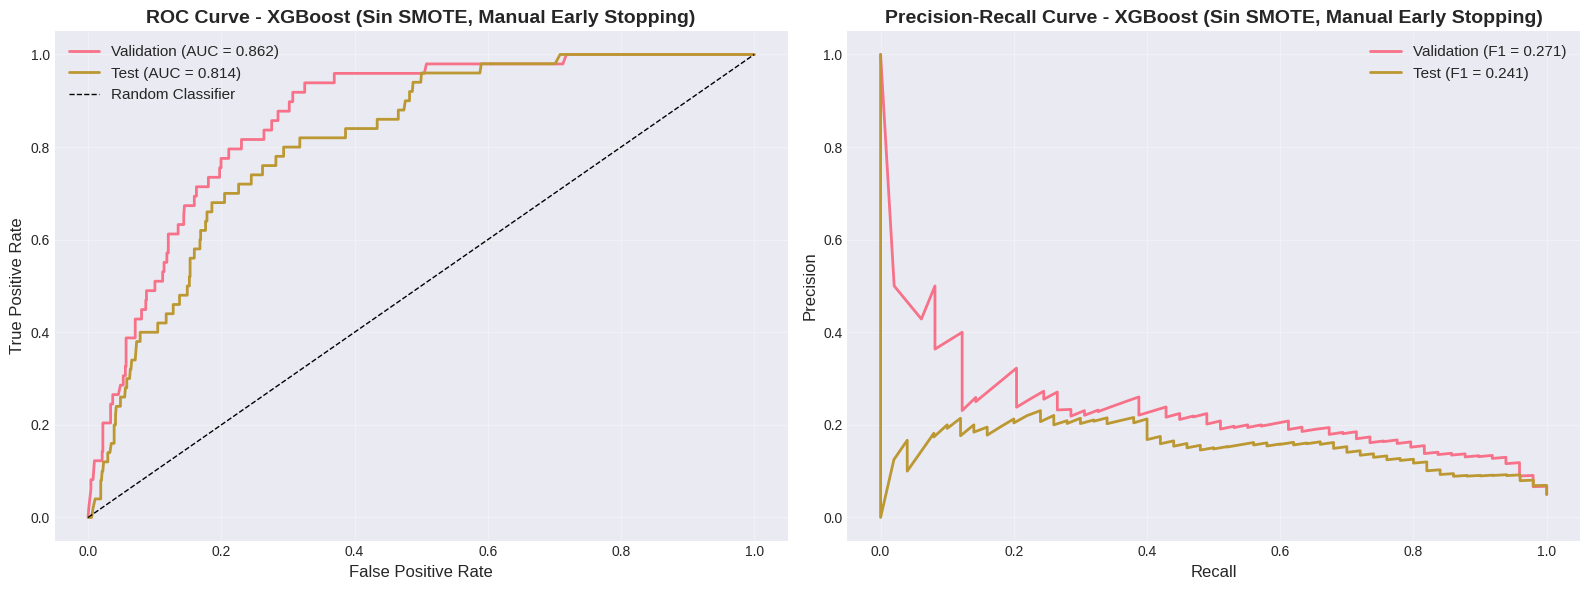

✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png


In [ ]:
# 18. Visualizations (ROC, Precision-Recall)
# 📊 VISUALIZACIONES: CURVAS ROC Y PRECISION-RECALL

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CURVA ROC
# Use the probabilities from the xgb_model (trained with manual early stopping)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba) # y_val_pred_proba is already calculated for the final model
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba) # y_test_pred_proba is already calculated for the final model

axes[0].plot(fpr_val, tpr_val, label=f'Validation (AUC = {val_auc:.3f})', linewidth=2)
axes[0].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. CURVA PRECISION-RECALL
# Use the probabilities from the xgb_model (trained with manual early stopping)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_pred_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_proba)

axes[1].plot(recall_val, precision_val, label=f'Validation (F1 = {val_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].plot(recall_test, precision_test, label=f'Test (F1 = {test_f1_opt:.3f})', linewidth=2) # Use F1 with optimal threshold
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/content', exist_ok=True) # Ensure directory exists
plt.savefig('/content/xgboost_curves_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Curvas guardadas: /content/xgboost_curves_no_smote_manual_early_stopping.png")

---
## 🌳 IMPORTANCIA DE FEATURES
---


🌳 TOP 15 FEATURES MÁS IMPORTANTES


'                       feature  importance\n                    risk_score       109.0\n             avg_glucose_level        92.0\n                           age        76.0\n                           bmi        69.0\n                 glucose_x_bmi        62.0\nsmoking_status_formerly smoked        17.0\n            age_x_hypertension        17.0\n                  ever_married        11.0\n         smoking_status_smokes        11.0\n   smoking_status_never smoked        10.0\n             work_type_Private         8.0\n       bmi_category_Overweight         8.0\n       work_type_Self-employed         7.0\n               age_group_Adult         6.0\n              age_group_Senior         5.0'

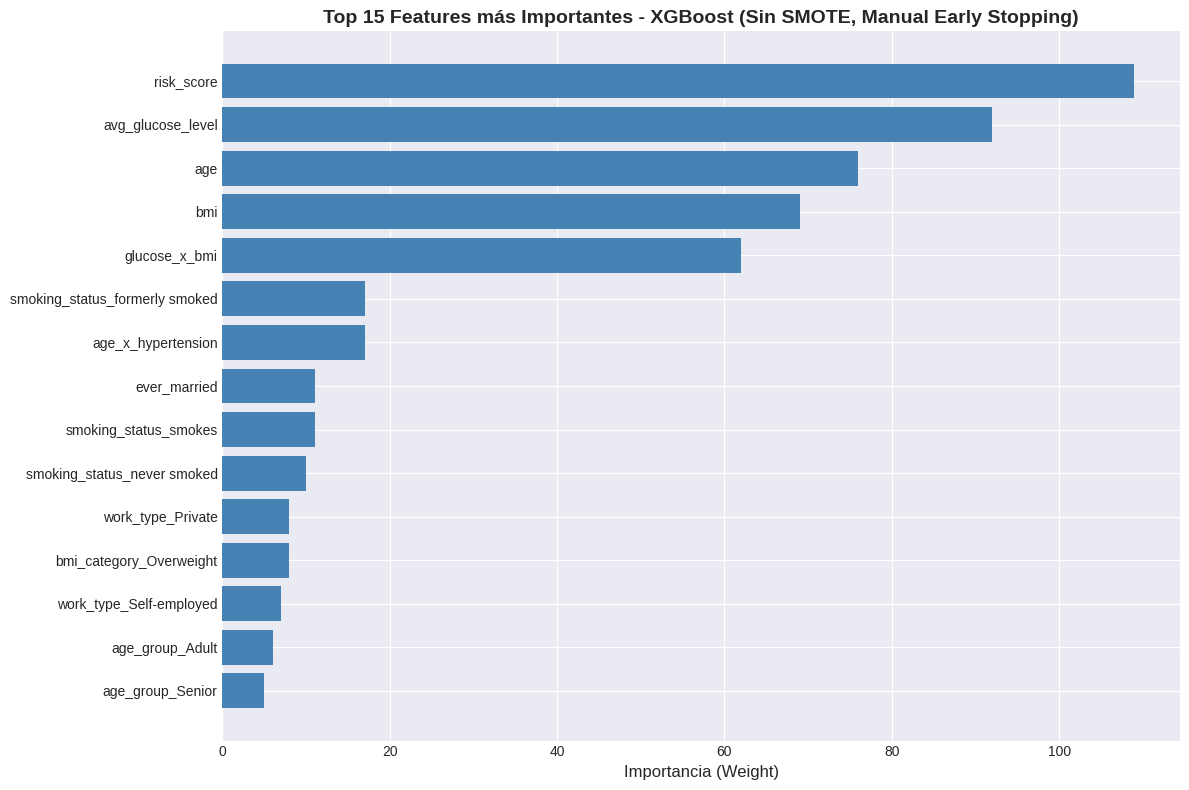


✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png


In [ ]:
# 19. Feature Importance
# 🌳 IMPORTANCIA DE FEATURES

# The xgb_model variable now holds the final trained model (Booster object)
# Use get_score() for feature importance with Booster objects
# When trained with DMatrix from a DataFrame, get_score() uses actual column names
importance_scores = xgb_model.get_score(importance_type='weight') # 'weight' counts the number of times each feature is used

# Convert the scores to a DataFrame
# Ensure all features from X_train_scaled are included, with 0 importance if not in scores
feature_importance = pd.DataFrame({
    'feature': list(importance_scores.keys()),
    'importance': list(importance_scores.values())
})

# Add features from X_train_scaled that are not in importance_scores with 0 importance
# This ensures all original features are represented
all_features = pd.DataFrame({'feature': X_train_scaled.columns})
feature_importance = pd.merge(all_features, feature_importance, on='feature', how='left').fillna(0)


feature_importance = feature_importance.sort_values('importance', ascending=False)


print("="*80)
print("🌳 TOP 15 FEATURES MÁS IMPORTANTES")
print("="*80)
display(feature_importance.head(15).to_string(index=False)) # Use display for better formatting

# Visualización
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia (Weight)', fontsize=12)
plt.title('Top 15 Features más Importantes - XGBoost (Sin SMOTE, Manual Early Stopping)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualización guardada: /content/feature_importance_xgboost_no_smote_manual_early_stopping.png")

In [ ]:
# 20. Update Model Information
# Update printed summary with the actual number of boosting rounds used due to early stopping

print("\n✅ Manual early stopping completed.")
print(f"🏆 Best Validation F1 achieved: {best_val_f1:.4f} at round {best_iteration + 1}")
print(f"   Actual number of boosting rounds used: {best_iteration + 1}") # Print the actual rounds

# 11. Load the model state that achieved the best_val_f1
# This was already done in the previous cell, but we'll keep the print for clarity.
# final_xgb_model = xgb.Booster()
# final_xgb_model.load_model(temp_model_path) # Load from the stored path

# Assign the final model to xgb_model for subsequent evaluation cells
# xgb_model = final_xgb_model # This assignment was also done in the previous cell.

print("✅ Final model loaded with best iteration.")
print("   The final model for evaluation is `xgb_model`.") # Updated to reflect the variable name

# The optimal threshold calculation and subsequent evaluations are handled in the following cells.


✅ Manual early stopping completed.
🏆 Best Validation F1 achieved: 0.2708 at round 21
   Actual number of boosting rounds used: 21
✅ Final model loaded with best iteration.
   The final model for evaluation is `xgb_model`.


---
## 💾 GUARDAR MODELO
---


In [ ]:
# 21. Save Model and Results
# 💾 GUARDAR MODELO Y RESULTADOS

import joblib

# Crear carpeta models en Colab
os.makedirs('/content/models', exist_ok=True)

# Guardar modelo
joblib.dump(xgb_model, '/content/models/xgboost_model_no_smote.pkl')
print("✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl")

# Guardar mejores parámetros
with open('/content/models/xgboost_best_params_no_smote.pkl', 'wb') as f:
    pickle.dump(best_params, f)
print("✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl")

# Guardar resultados de evaluación
results = {
    # These values are calculated with the optimal threshold in cell 05a98e79
    'validation_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': val_accuracy_opt,
        'precision': val_precision_opt,
        'recall': val_recall_opt,
        'f1_score': val_f1_opt,
        'auc_roc': val_auc
    },
    # These values are calculated with the optimal threshold in cell 05a98e79
    'test_threshold_optimal': {
        'threshold': float(best_threshold),
        'accuracy': test_accuracy_opt,
        'precision': test_precision_opt,
        'recall': test_recall_opt,
        'f1_score': test_f1_opt,
        'auc_roc': test_auc
    },
    'best_params': best_params,
    'optimal_threshold': float(best_threshold),
    'scale_pos_weight': float(scale_pos_weight),
    'feature_importance': feature_importance.to_dict('records')
}

with open('/content/models/xgboost_results_no_smote.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl")

print("\n" + "="*80)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*80)
# Update print statements to use the _opt variables
print(f"\n📊 RESUMEN FINAL (Threshold Óptimo = {best_threshold:.3f}):")
print(f"   Validation - Recall: {val_recall_opt:.4f}, F1: {val_f1_opt:.4f}, AUC: {val_auc:.4f}")
print(f"   Test       - Recall: {test_recall_opt:.4f}, F1: {test_f1_opt:.4f}, AUC: {test_auc:.4f}")

print(f"\n✅ Modelo listo para usar en producción")
print(f"✅ Threshold óptimo recomendado: {best_threshold:.3f}")
print(f"✅ Entrenado SIN SMOTE - usando scale_pos_weight: {scale_pos_weight:.2f}")
print("="*80)

✅ Modelo guardado: /content/models/xgboost_model_no_smote.pkl
✅ Mejores parámetros guardados: /content/models/xgboost_best_params_no_smote.pkl
✅ Resultados guardados: /content/models/xgboost_results_no_smote.pkl

🎉 ENTRENAMIENTO COMPLETADO

📊 RESUMEN FINAL (Threshold Óptimo = 0.500):
   Validation - Recall: 0.7959, F1: 0.2708, AUC: 0.8624
   Test       - Recall: 0.7000, F1: 0.2405, AUC: 0.8136

✅ Modelo listo para usar en producción
✅ Threshold óptimo recomendado: 0.500
✅ Entrenado SIN SMOTE - usando scale_pos_weight: 19.05


---
## 📥 DESCARGAR RESULTADOS (OPCIONAL)
### Descargar los archivos generados a tu PC
---


In [ ]:
# 22. Download Results (Optional)
# 📥 DESCARGAR RESULTADOS (OPCIONAL)
# Descomenta las líneas que quieras descargar:

# Descargar modelo
# files.download('/content/models/xgboost_model_no_smote.pkl')

# Descargar mejores parámetros
# files.download('/content/models/xgboost_best_params_no_smote.pkl')

# Descargar resultados
# files.download('/content/models/xgboost_results_no_smote.pkl')

# Descargar gráficos
# files.download('/content/xgboost_curves_no_smote_manual_early_stopping.png')
# files.download('/content/feature_importance_xgboost_no_smote_manual_early_stopping.png')

print("💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda")
print("📁 Archivos disponibles en /content/models/ y /content/")

💡 Para descargar archivos, descomenta las líneas de arriba y ejecuta esta celda
📁 Archivos disponibles en /content/models/ y /content/
